In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br

from pycbc import conversions as conv
from  pycbc.filter.matchedfilter import optimized_match

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter

from pycbc import types, fft, waveform

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


# PYCBC Waveform and Plotting Functions

In [3]:
## GENERATE PYCBC WAVEFORMS
def get_pycbc_waveforms_fd(net_true, net_ap):
    delta_f = net_ap.f[1] - net_ap.f[0]

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_ap.f, net_ap.detectors[0].f, assume_unique=True)

    hp1_fs = FrequencySeries(net_true.hfp[freq_mask], delta_f=delta_f)
    hc1_fs = FrequencySeries(net_true.hfc[freq_mask], delta_f=delta_f)

    hp2_fs = FrequencySeries(net_ap.hfp[freq_mask], delta_f=delta_f)
    hc2_fs = FrequencySeries(net_ap.hfc[freq_mask], delta_f=delta_f)

    # Combine frequency-domain waveforms
    h1_fs = hp1_fs+ 1.j*hc1_fs
    h2_fs = hp2_fs+ 1.j*hc2_fs

    return [h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs]


# FFT it to the time-domain
def get_pycbc_waveforms_td(net_true, net_ap):
    delta_t=1.0/4096
    delta_f = net_ap.f[1] - net_ap.f[0]

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_ap.f, net_ap.detectors[0].f, assume_unique=True)

    hp1_fs = FrequencySeries(net_true.hfp[freq_mask], delta_f=delta_f)
    hc1_fs = FrequencySeries(net_true.hfc[freq_mask], delta_f=delta_f)

    hp2_fs = FrequencySeries(net_ap.hfp[freq_mask], delta_f=delta_f)
    hc2_fs = FrequencySeries(net_ap.hfc[freq_mask], delta_f=delta_f)

    tlen = int(1.0 / delta_t / hp1_fs.delta_f)
    hp1_fs.resize(tlen/2 + 1)
    hp1_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hp1_fs, hp1_ts)

    tlen = int(1.0 / delta_t / hc1_fs.delta_f)
    hc1_fs.resize(tlen/2 + 1)
    hc1_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hc1_fs, hc1_ts)


    tlen = int(1.0 / delta_t / hp2_fs.delta_f)
    hp2_fs.resize(tlen/2 + 1)
    hp2_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hp2_fs, hp2_ts)

    tlen = int(1.0 / delta_t / hc2_fs.delta_f)
    hc2_fs.resize(tlen/2 + 1)
    hc2_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hc2_fs, hp2_ts)

    h1_ts = hp1_ts+ 1.j*hc1_ts
    h2_ts = hp2_ts+ 1.j*hc2_ts

    return [h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts]

In [4]:
def plot_f_series(h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs):    
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8, 8))

    axes[0].plot(hp1_fs.sample_frequencies, h1_fs, label=approx1)
    axes[0].plot(hp2_fs.sample_frequencies, h2_fs, label=approx2)
    axes[0].set_ylabel("$h (f)$")
    axes[0].legend()


    axes[1].plot(hp1_fs.sample_frequencies, np.abs(h1_fs), label=approx1)
    axes[1].plot(hp2_fs.sample_frequencies, np.abs(h2_fs), label=approx2)
    axes[1].set_ylabel("Amplitude")
    axes[1].legend()

    axes[2].plot(hp1_fs.sample_frequencies, np.unwrap(np.angle(h1_fs)), label=approx1)
    axes[2].plot(hp2_fs.sample_frequencies, np.unwrap(np.angle(h2_fs)), label=approx2)
    axes[2].set_ylabel("Phase")
    axes[2].legend()
    axes[2].set_ylim(0, 150)

    plt.xlabel("$f$")
    plt.xlim(0, 20)
    plt.show()

In [5]:
def plot_t_series(h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts):

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3))

    axes = [axes]
    axes[0].plot(h1_ts.sample_times, h1_ts, label=approx1)
    axes[0].plot(h2_ts.sample_times, h2_ts, label=approx2)

    axes[0].set_ylabel("$h(t)$")
    axes[0].legend()
    axes[0].set_xlim(5, 17)

    # amp1 = waveform.utils.amplitude_from_polarizations(hp1_ts, hc1_ts)
    # amp2 = waveform.utils.amplitude_from_polarizations(hp2_ts, hc2_ts)
    # axes[1].plot(hp1_ts.sample_times, amp1, label=approx1)
    # axes[1].plot(hp2_ts.sample_times, amp2, label=approx2)
    # axes[1].set_ylabel("$|h(t)|$")

    # phase1 = waveform.utils.phase_from_polarizations(hp1_ts, hc1_ts)
    # phase2 = waveform.utils.phase_from_polarizations(hp2_ts, hc2_ts)
    # axes[2].plot(hp1_ts.sample_times, phase1, label=approx1)
    # axes[2].plot(hp2_ts.sample_times, phase2, label=approx2)
    # axes[2].set_ylabel("Phase")
    # axes[2].set_xlabel("Time (s)")
    # axes[2].legend()
    # axes[2].set_xlim(5, 17)

    plt.xlabel('$t$')

    # plt.show()

# Read Binaries from Population file

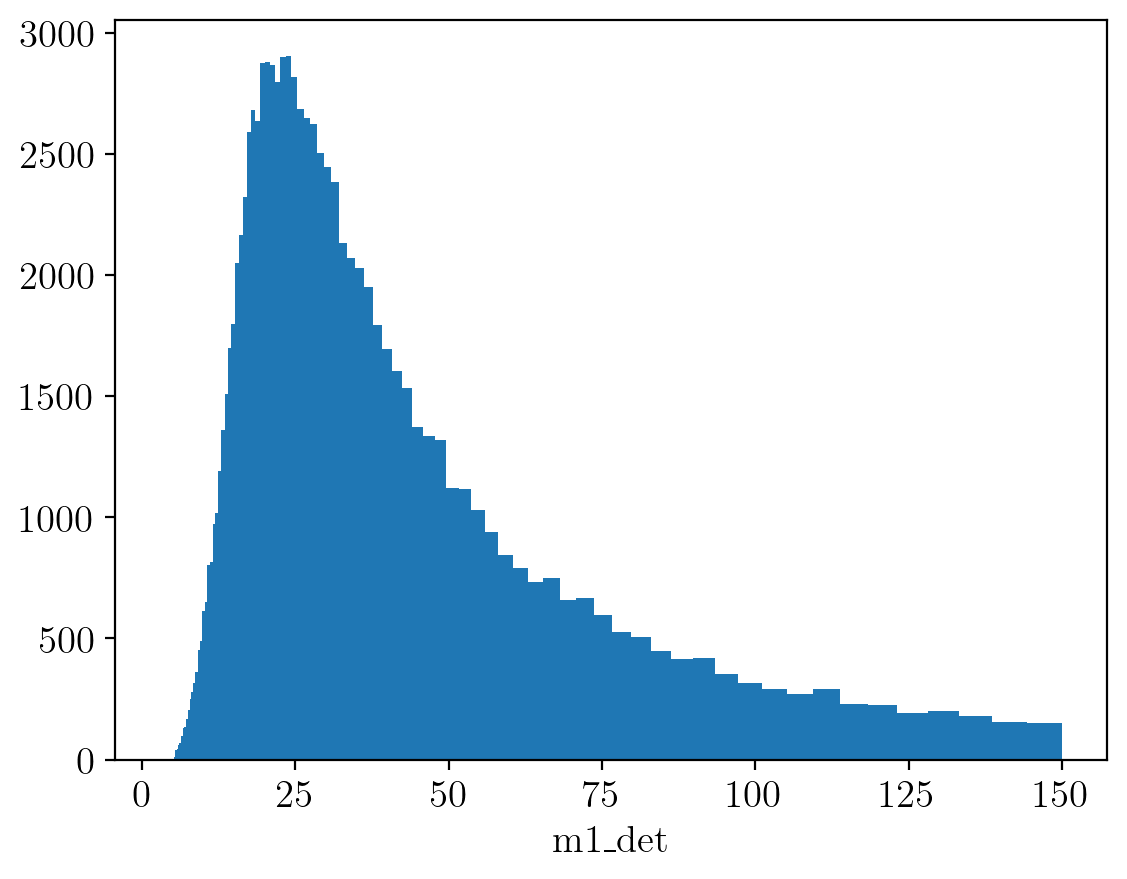

In [6]:
input_file = 'smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])

m1s = conv.mass1_from_mchirp_eta(Mcs, etas)
mtots = conv.mtotal_from_mchirp_eta(Mcs, etas)


plt.hist(m1s, bins = np.geomspace(3.0, 150.0, 100))
plt.xlabel('m1_det')
plt.show()

# No Phic or tc opt

In [8]:
i = 54837

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 

net_key = '3G'
# net_key = 'aLIGO'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)

2023-11-11 12:16:13,398 - Network - INFO : Polarizations calculated.
2023-11-11 12:16:13,399 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-11 12:16:13,408 - Network - INFO : Polarizations calculated.
2023-11-11 12:16:14,851 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-11 12:16:14,880 - Network - INFO : PSDs loaded.
2023-11-11 12:16:14,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-11 12:16:14,909 - Network - INFO : Detector responses calculated.
2023-11-11 12:16:14,910 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-11 12:16:14,911 - Network - INFO :    aLIGO_H
2023-11-11 12:16:15,842 - Network - INFO :    aLIGO_L
2023-11-11 12:16:16,811 - Network - INFO :    V+_V
2023-11-11 12:16:17,775 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-11 12:16:17,777 - Network - INFO : SNRs calculated.
2023-11-11 12:16:17,778 - Network - INFO : Calculate errors 

In [9]:
net_ap.cutler_vallisneri_bias.tolist()[0]

[-2.027400418560319,
 0.39079363626746044,
 -59.73521399230958,
 74.4249281201046,
 2392.4200715348125,
 0.4066856525033131,
 26.999806693027494,
 0.8986114604704198,
 0.002831053707609499,
 0.013461712940738835,
 -0.7587027083609428]

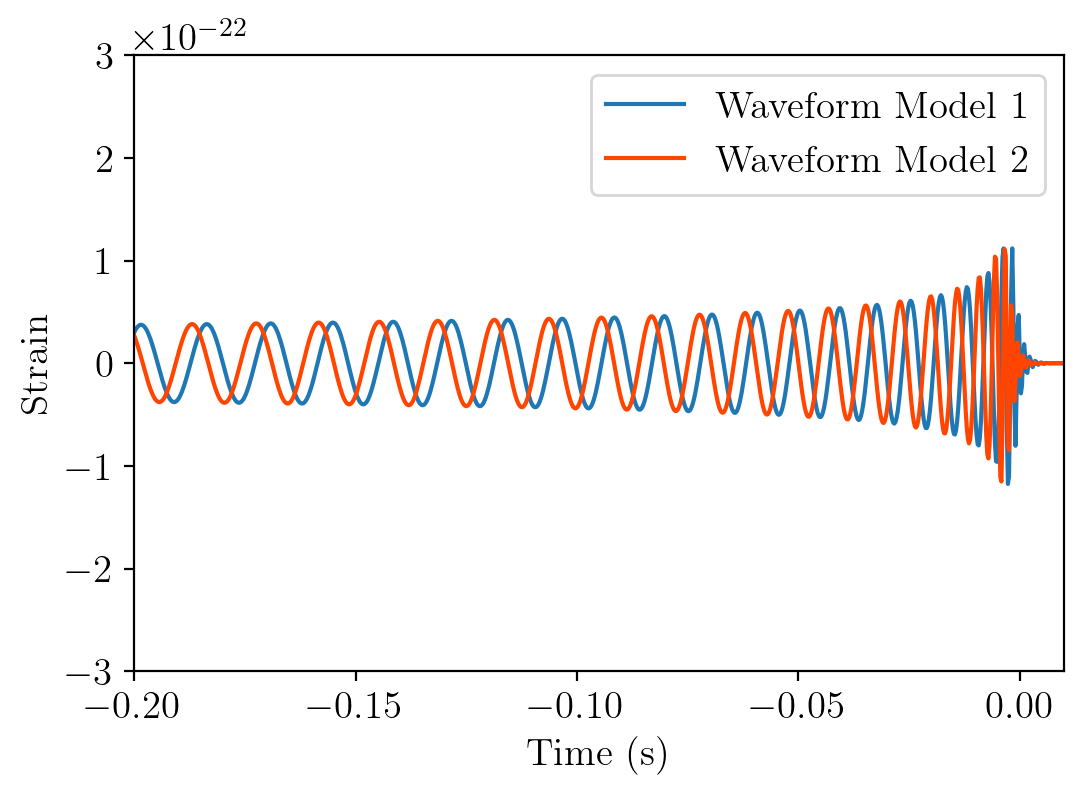

In [8]:
# GW151226

import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector


labels=['Waveform Model 1', 'Waveform Model 2']
colors=['tab:blue', 'orangered']

fig, ax = pp.subplots(figsize=(6, 4))
for i, apx in enumerate(['IMRPhenomXAS', 'IMRPhenomD']):
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=14.2,
                                 mass2=7.5,
                                 delta_t=1.0/4096,
                                 distance=440,
                                 f_lower=10)
    det_l1 = Detector('L1')
    declination = 0.65
    right_ascension = 4.67
    polarization = 2.34
    signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
    pp.plot(signal_l1.sample_times, signal_l1, lw=1.5, label=labels[i], color=colors[i])

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.xlim(-0.2, 0.01)
pp.ylim(-0.3e-21, 0.3e-21)
pp.show()

In [70]:
fd_waveforms_no_opt = get_pycbc_waveforms_fd(net_true, net_ap)
td_waveforms_no_opt = get_pycbc_waveforms_td(net_true, net_ap)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


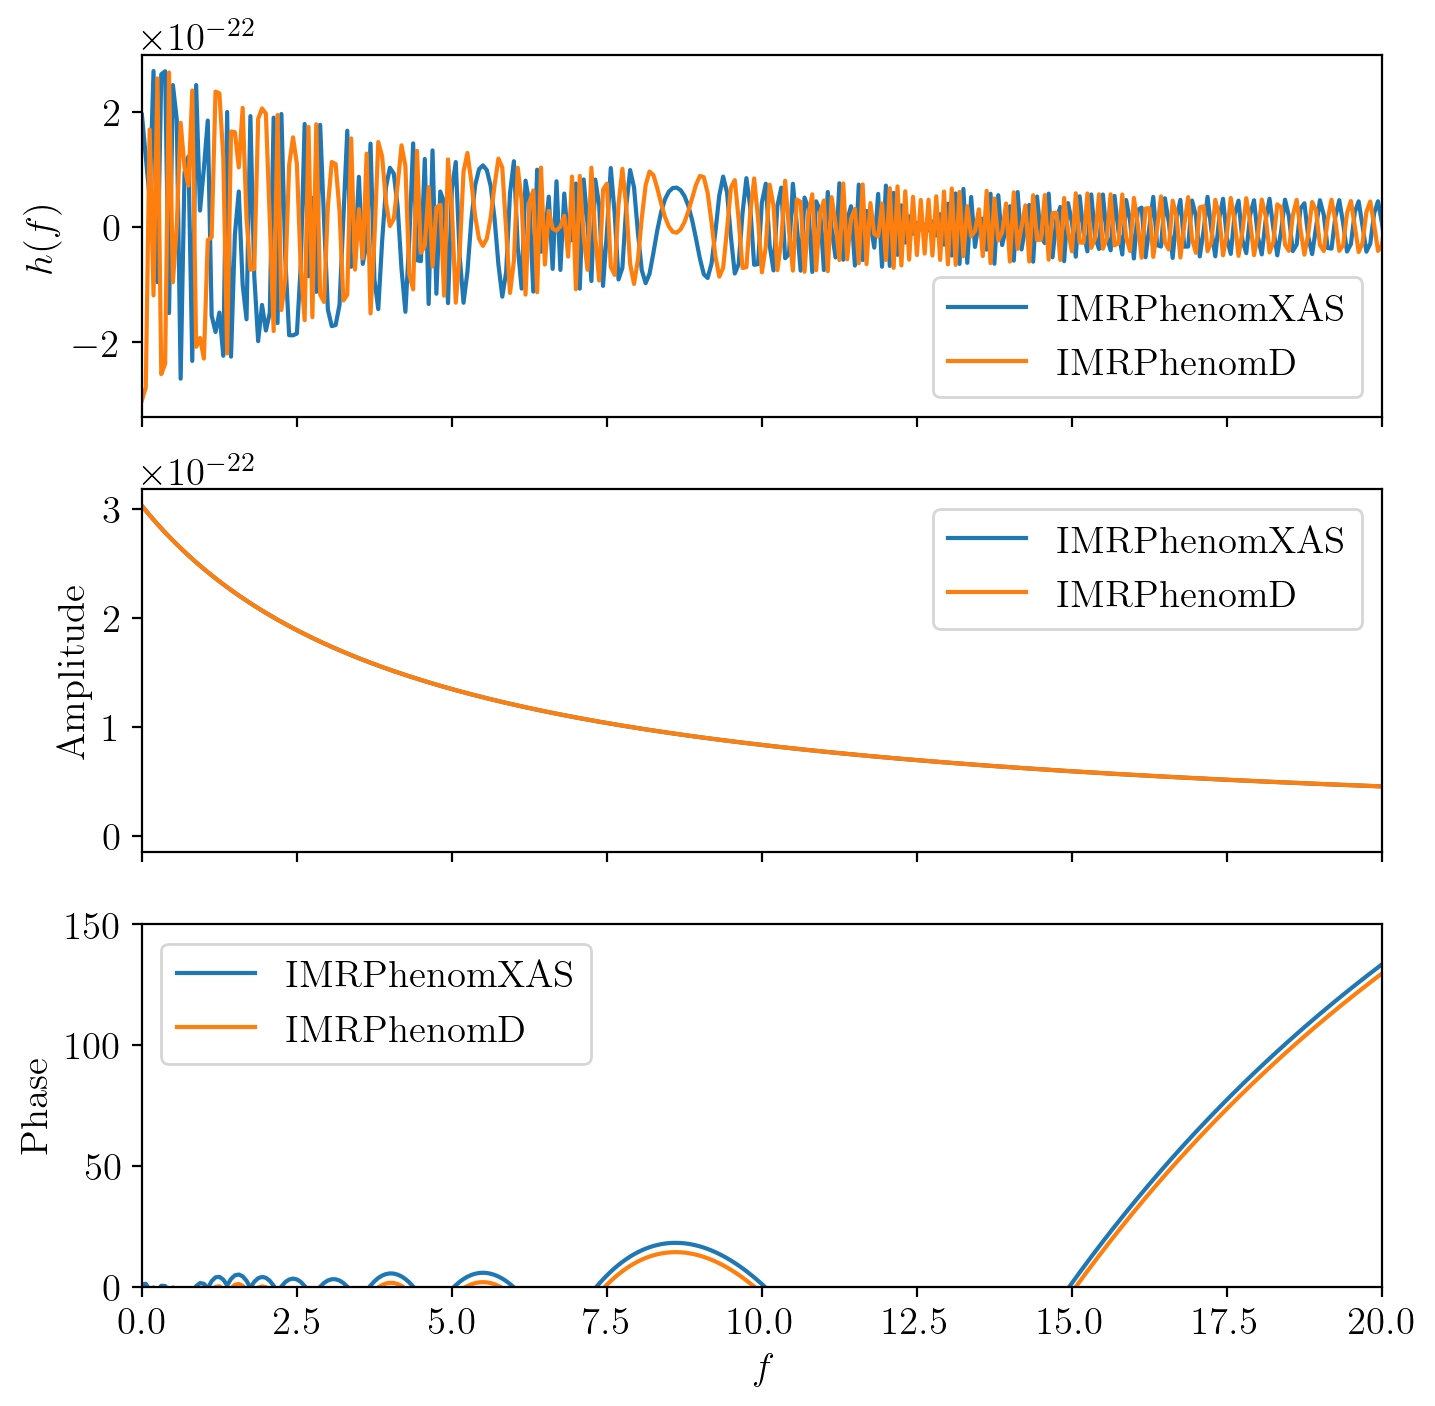

In [71]:
plot_f_series(*fd_waveforms_no_opt)

ValueError: x and y must have same first dimension, but have shapes (65536,) and (1,)

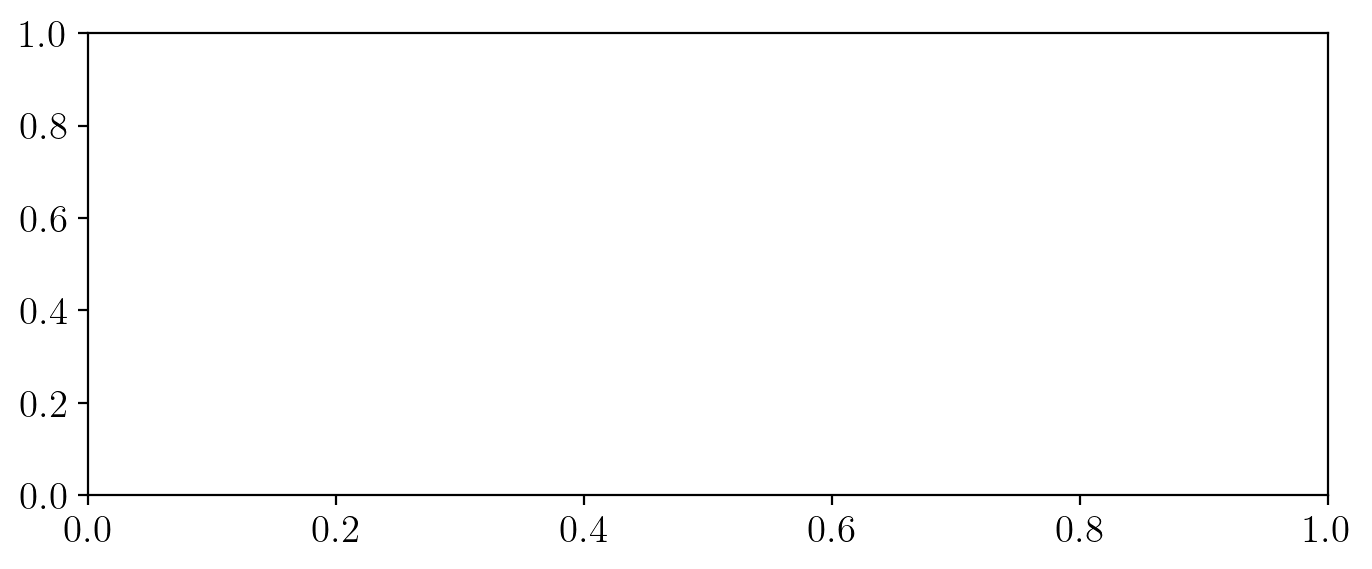

In [73]:
plot_t_series(*td_waveforms_no_opt)
plt.xlim(15, 16.1)

## Biases

Biases: [0.07556366334233644, -0.028200968787132297, 2.368778282077983, -2.798184705665335, -7277.531819633325, -0.015571274416288361, 112.09852832113393, 11.967273468604162, -0.021258779579255815, -0.007996928408715576, 56.75551970578272]
Errors: [2.72423658e-03 1.62393542e-03 1.57143861e-01 1.93263516e-01
 1.02780182e+02 1.04163971e-03 7.27044523e-01 1.35313228e-01
 4.76610701e-04 4.04111110e-04 3.63363743e-01]


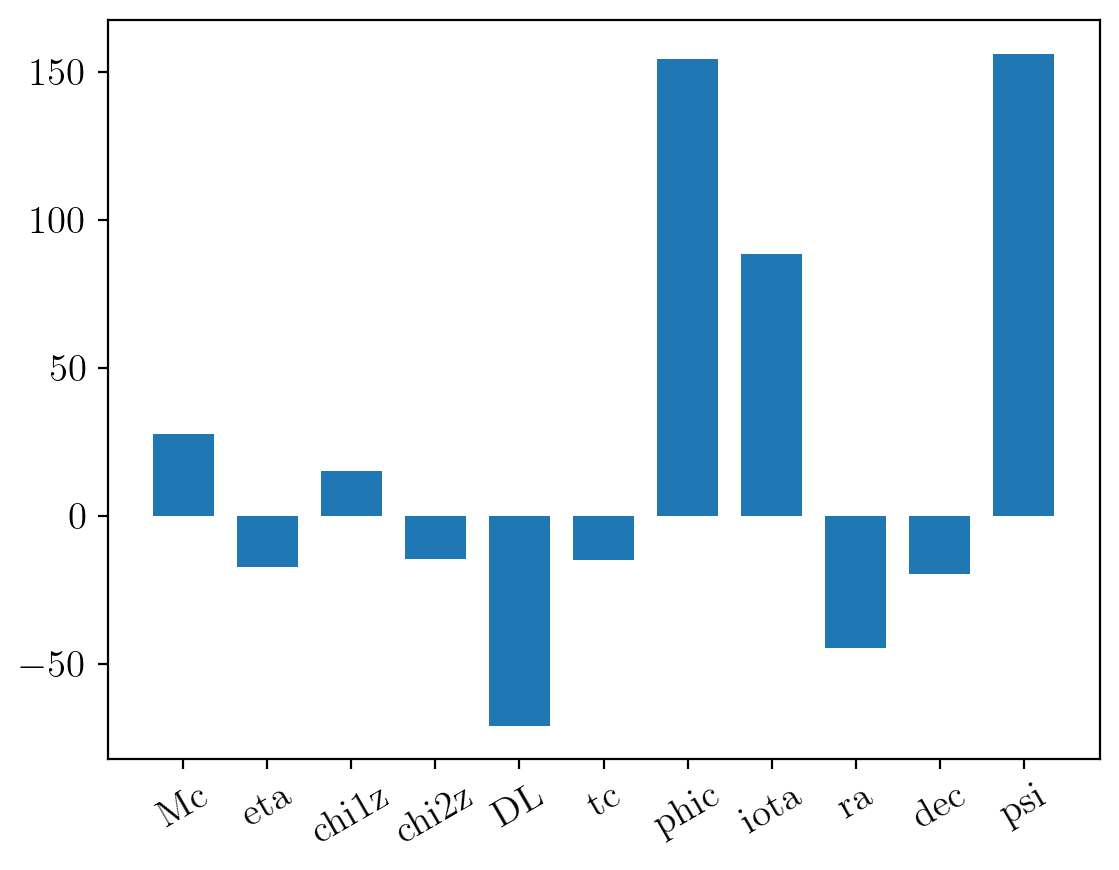

In [32]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))

for i, param in enumerate(net_ap.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]

print("Biases:", bias_no_opt)
print("Errors:", err_no_opt)

x = np.linspace(0, len(bias_no_opt), len(bias_no_opt))
plt.bar(x, bias_no_opt/err_no_opt)
plt.xticks(x, net_ap.deriv_variables, rotation=30)
plt.show()

# $\phi_c$ AND $t_c$ optimized

In [142]:
h1_ts = td_waveforms_no_opt[0]
h1_fs = fd_waveforms_no_opt[0]
h2_fs = fd_waveforms_no_opt[3]

delta_t = h1_ts.delta_t
print(1/delta_t)

match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
tc = -index * delta_t
phic = -phi

print(match, tc, phic)

4096.0
0.9999246518995833 -1.4828648898100516 2.366996263253947


In [20]:
# set the injection parameters
inj_params_opt = inj_params.copy()
inj_params_opt['tc'] = tc
inj_params_opt['phic'] = phic


net_key = '3G'

approx1 = 'IMRPhenomHM'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap_opt = gwnet.get_hybrid_network_response(inj_params=inj_params_opt, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

NameError: name 'tc' is not defined

In [144]:
fd_waveforms_opt = get_pycbc_waveforms_fd(net_true, net_ap_opt)

td_waveforms_opt = get_pycbc_waveforms_td(net_true, net_ap_opt)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


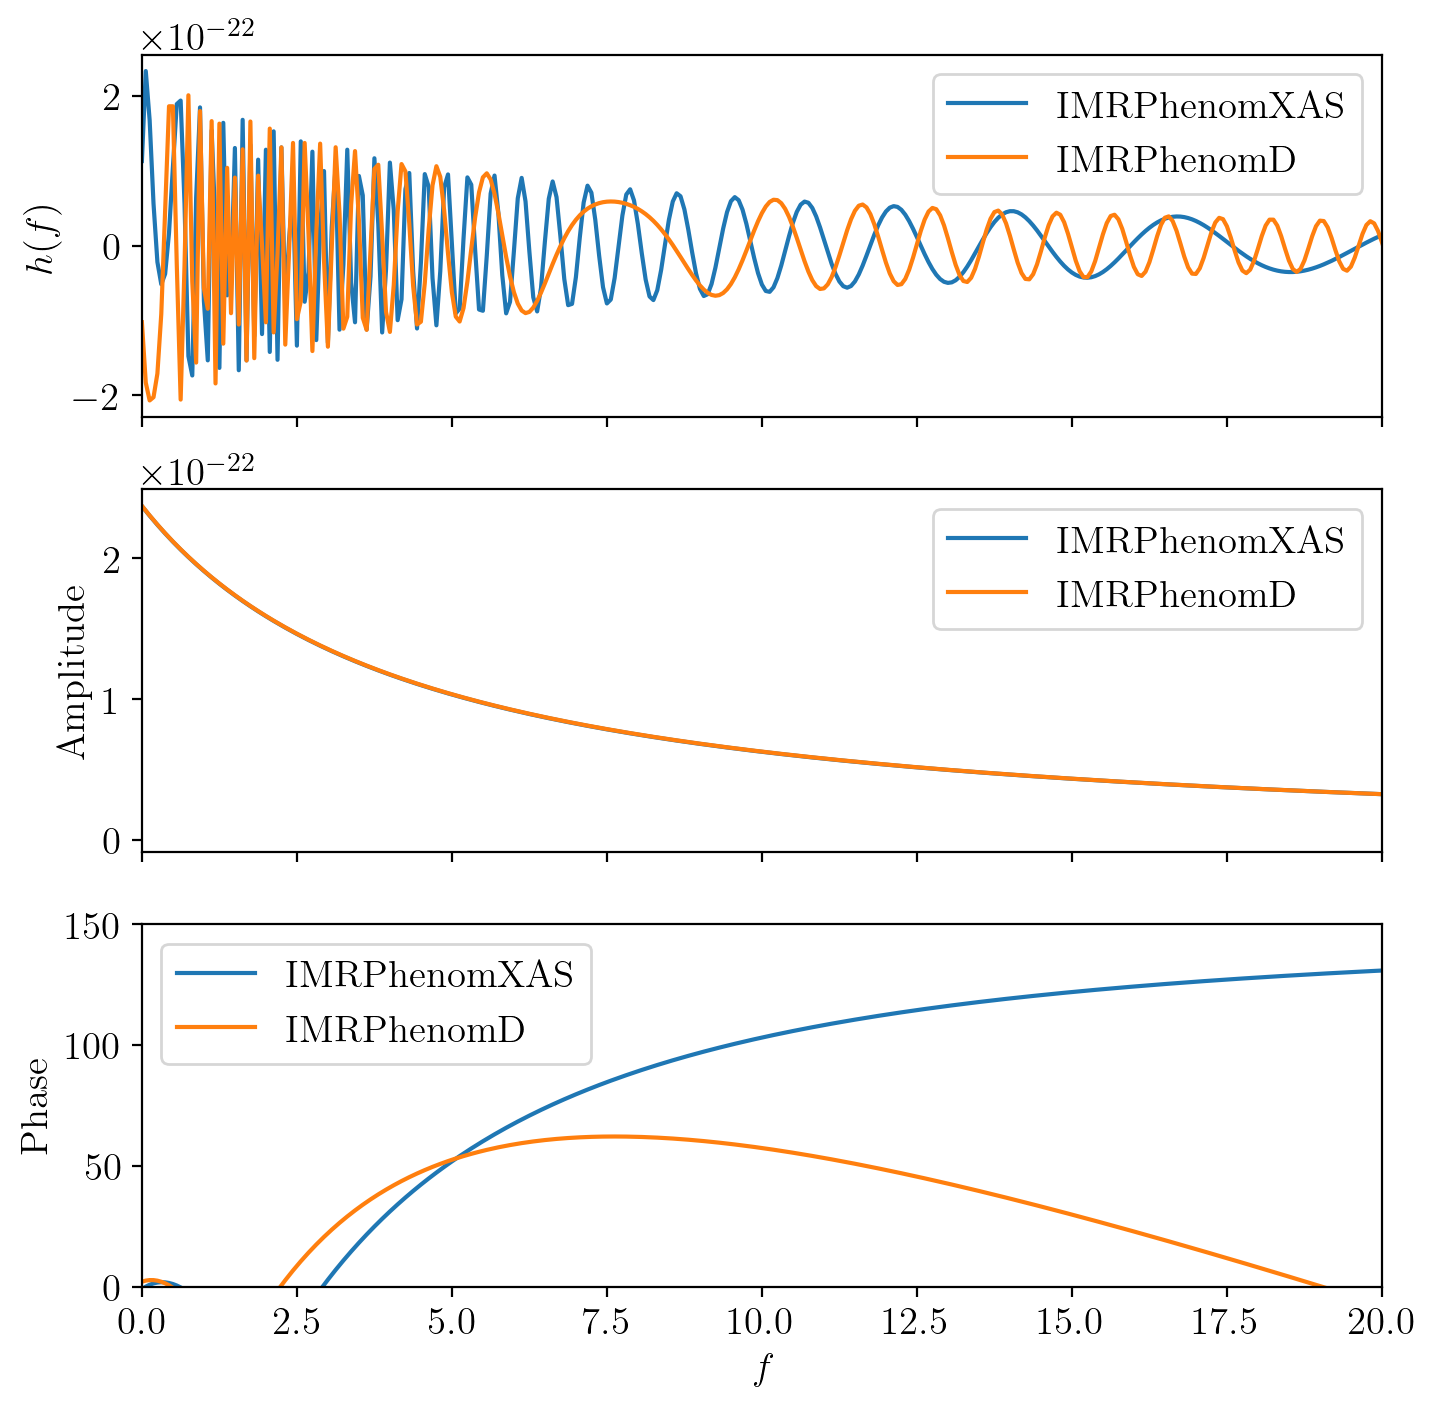

In [145]:
plot_f_series(*fd_waveforms_opt)

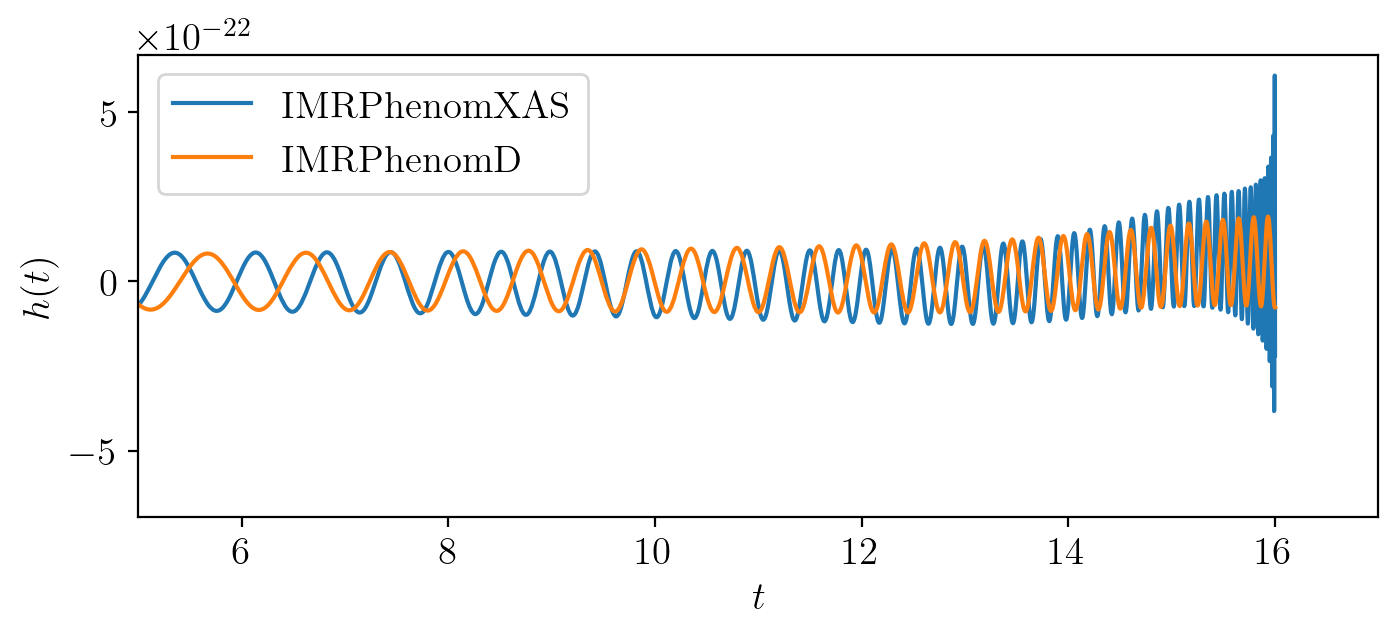

In [146]:
plot_t_series(*td_waveforms_opt)

## Biases

Biases: [0.6965420688025574, 0.2945066255036295, -38.04439677204027, 47.514417298149056, 803.9018486281857, 0.254766738597894, 12.804589522212154, 3.5642558216022735, -0.012571362173155798, 0.0057700030218956755, 2.3811520486582367]
Errors: [2.72536348e-03 1.62407395e-03 1.57180339e-01 1.93310678e-01
 1.02475136e+02 1.04190595e-03 7.27119625e-01 1.34910196e-01
 4.76170448e-04 4.03802580e-04 3.63307685e-01]


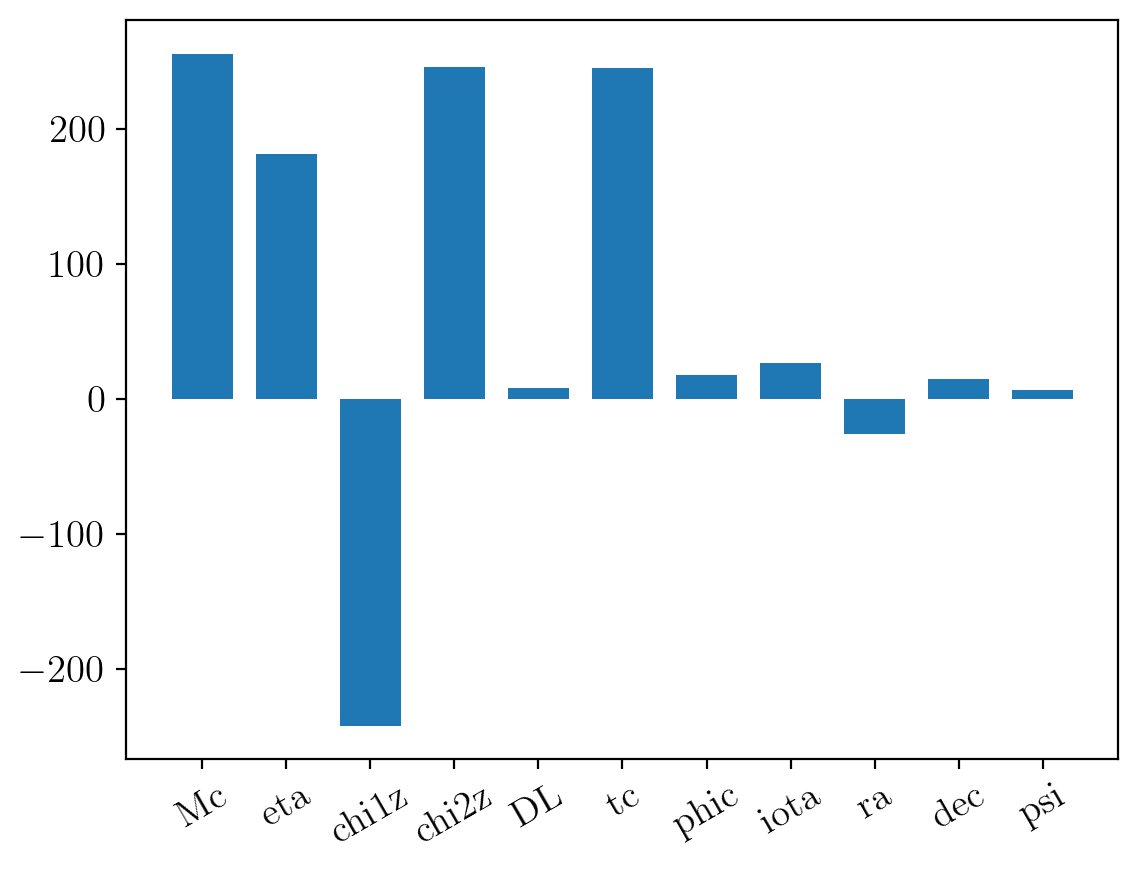

In [95]:
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
err_opt = np.zeros(len(bias_opt))

for i, param in enumerate(net_ap_opt.deriv_variables):
    err_opt[i] = net_ap_opt.errs[param]

print("Biases:", bias_opt)
print("Errors:", err_opt)

x = np.linspace(0, len(bias_opt), len(bias_opt))
plt.bar(x, bias_opt/err_opt)
plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)
plt.show()

In [19]:
bias_no_opt

[0.6962290091003212,
 0.29442187702835554,
 -38.027401983812524,
 47.49267381292702,
 803.6568649755791,
 0.2546528961344876,
 12.617324783942422,
 3.5648347962023763,
 -0.012529401878046187,
 0.005769350115615524,
 2.289716517137549]

## Bias Comparison

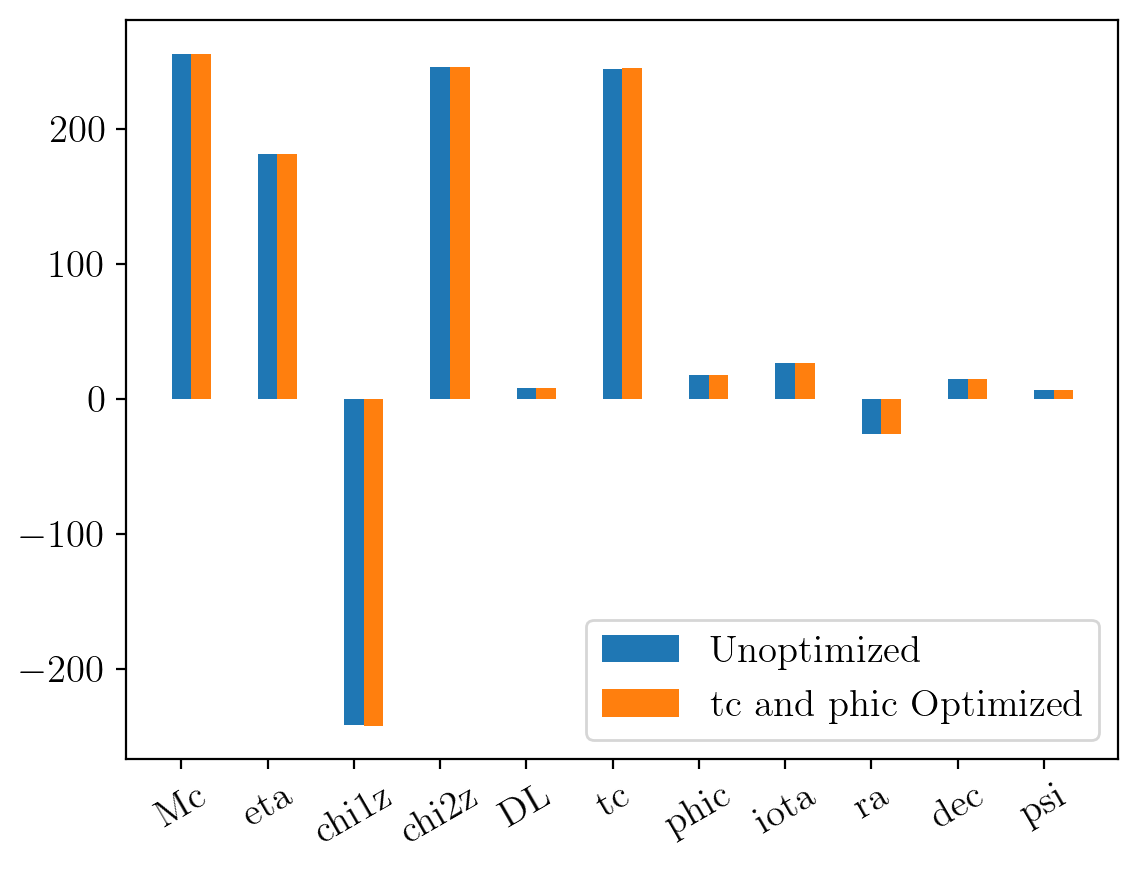

In [96]:
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
err_opt = np.zeros(len(bias_opt))

bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))


for i, param in enumerate(net_ap_opt.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]
    err_opt[i] = net_ap_opt.errs[param]


x = np.linspace(0, len(bias_opt), len(bias_opt))

width = 0.25
plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, bias_opt/err_opt, width=width, label='tc and phic Optimized')

plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

In [97]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]

for i, param in enumerate(net_ap.deriv_variables):
    bias1 = bias_no_opt[i]/net_ap.errs[param]
    bias2 = bias_opt[i]/net_ap_opt.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

Mc bias diff: -0.00%
Mc, not: 255.568 sigma
Mc, opt: 255.578 sigma

eta bias diff: -0.02%
eta, not: 181.301 sigma
eta, opt: 181.338 sigma

chi1z bias diff: -0.02%
chi1z, not: -241.991 sigma
chi1z, opt: -242.043 sigma

chi2z bias diff: -0.02%
chi2z, not: 245.741 sigma
chi2z, opt: 245.793 sigma

DL bias diff: -0.33%
DL, not: 7.819 sigma
DL, opt: 7.845 sigma

tc bias diff: -0.02%
tc, not: 244.473 sigma
tc, opt: 244.520 sigma

phic bias diff: -1.47%
phic, not: 17.354 sigma
phic, opt: 17.610 sigma

iota bias diff: -0.28%
iota, not: 26.345 sigma
iota, opt: 26.419 sigma

ra bias diff: -0.43%
ra, not: -26.289 sigma
ra, opt: -26.401 sigma

dec bias diff: -0.09%
dec, not: 14.277 sigma
dec, opt: 14.289 sigma

psi bias diff: -4.01%
psi, not: 6.301 sigma
psi, opt: 6.554 sigma



# Only $\phi_c$ optimized

In [98]:
h1_ts = td_waveforms_no_opt[0]
h1_fs = fd_waveforms_no_opt[0]
h2_fs = fd_waveforms_no_opt[3]

delta_t = h1_ts.delta_t

match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
tc = -index * delta_t
phic = -phi

print(match, tc, phic)

0.9999246518995833 -1.4828648898100516 2.366996263253947


In [99]:
# set the injection parameters
inj_params_opt_phic = inj_params.copy()
inj_params_opt_phic['phic'] = phic


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap_opt_phic = gwnet.get_hybrid_network_response(inj_params=inj_params_opt_phic, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

2023-10-17 08:53:07,148 - Network - INFO : Polarizations calculated.
2023-10-17 08:53:07,150 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 08:53:07,163 - Network - INFO : Polarizations calculated.
2023-10-17 08:53:08,561 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 08:53:08,629 - Network - INFO : PSDs loaded.
2023-10-17 08:53:08,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 08:53:08,663 - Network - INFO : Detector responses calculated.
2023-10-17 08:53:08,664 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 08:53:08,665 - Network - INFO :    CE-40_C
2023-10-17 08:53:09,661 - Network - INFO :    CE-20_S
2023-10-17 08:53:10,587 - Network - INFO :    ET_ET1
2023-10-17 08:53:11,499 - Network - INFO :    ET_ET2
2023-10-17 08:53:12,478 - Network - INFO :    ET_ET3
2023-10-17 08:53:13,693 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 0

In [100]:
fd_waveforms_opt_phic = get_pycbc_waveforms_fd(net_true, net_ap_opt_phic)

td_waveforms_opt_phic = get_pycbc_waveforms_td(net_true, net_ap_opt_phic)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


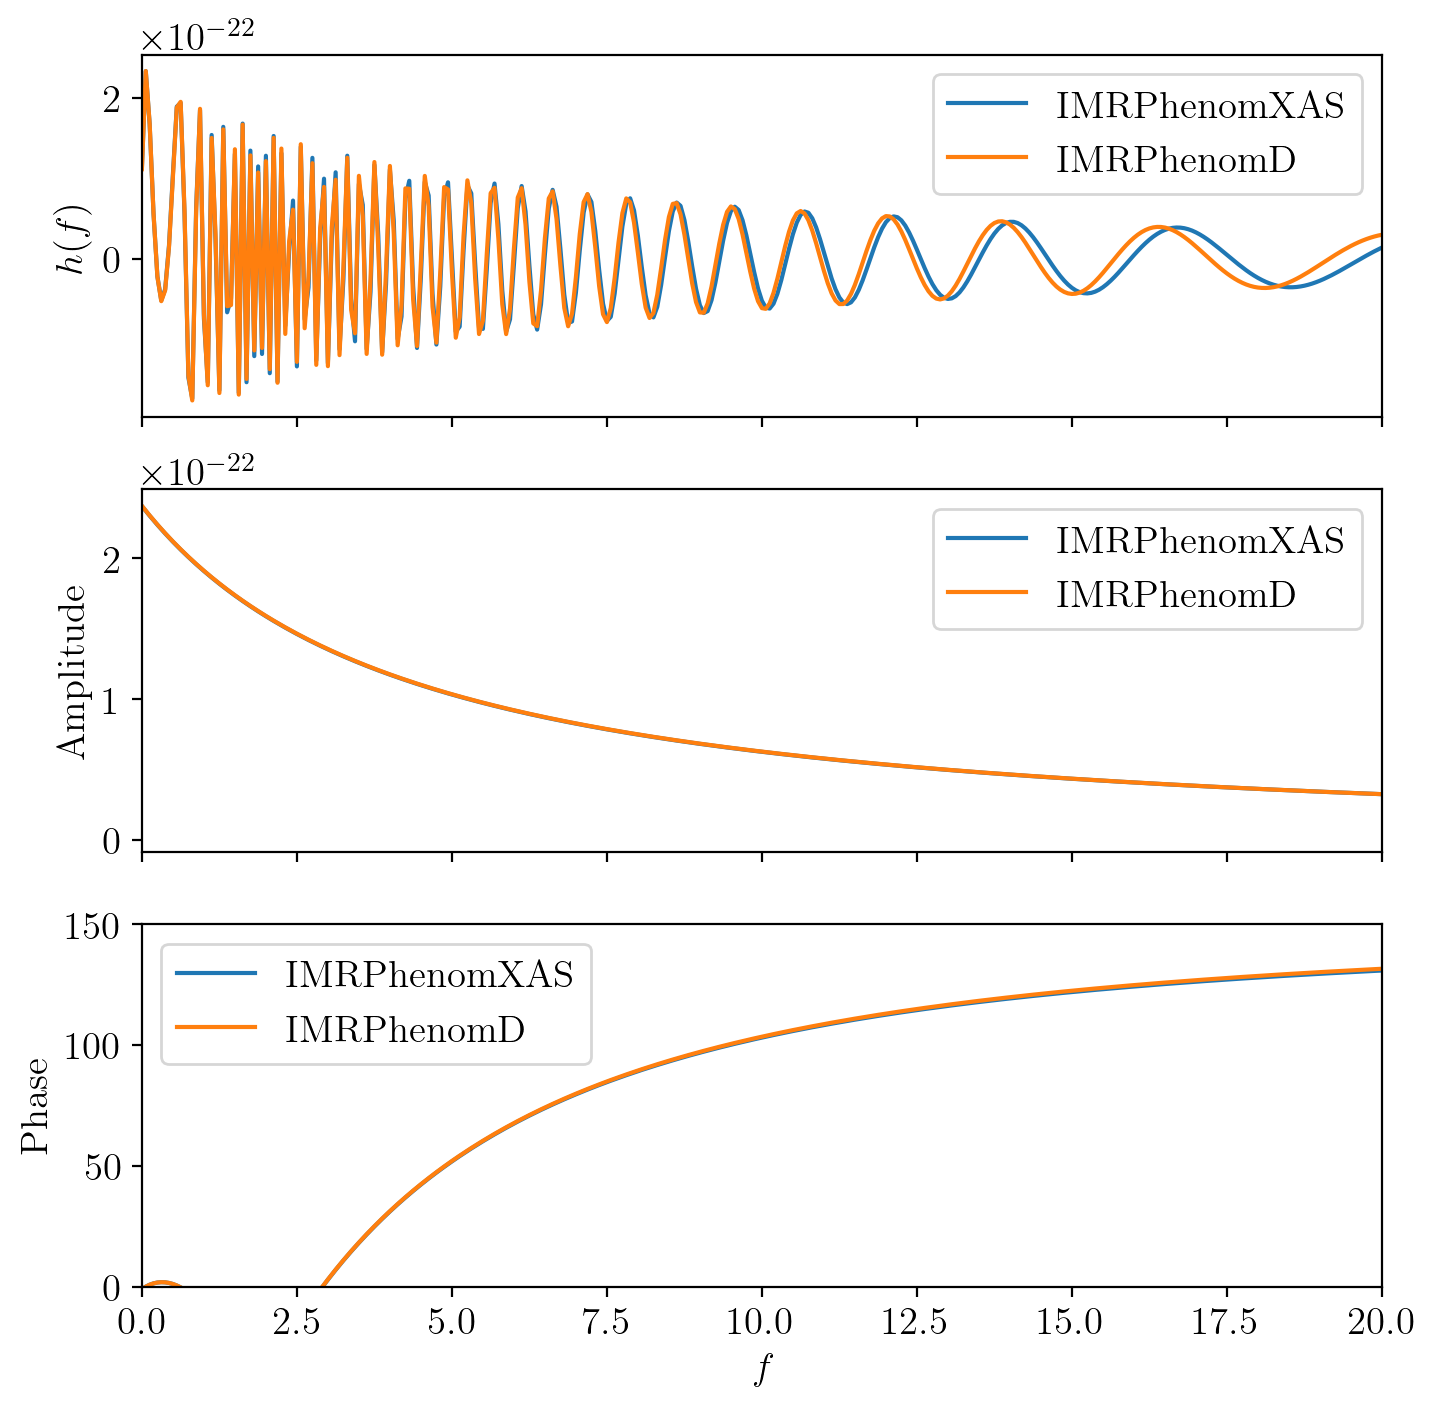

In [101]:
plot_f_series(*fd_waveforms_opt_phic)

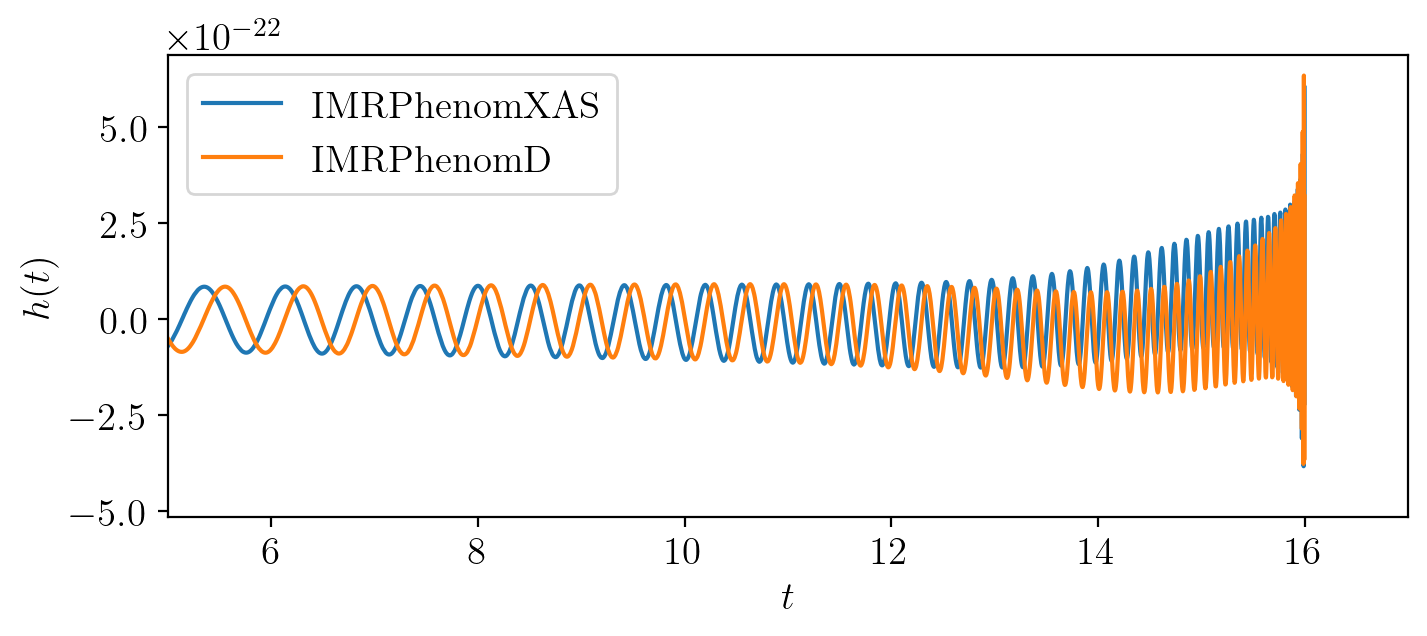

In [102]:
plot_t_series(*td_waveforms_opt_phic)

## Biases

Biases: [0.6961938202885278, 0.2944364217628106, -38.02737637033533, 47.493963280496246, 791.8424193635583, 0.2546516558126939, 12.49304826673233, 3.580253739390173, -0.012485974970565472, 0.00575531310768973, 2.2253358851507414]
Errors: [2.72433017e-03 1.62395439e-03 1.57147124e-01 1.93267658e-01
 1.02453018e+02 1.04166288e-03 7.27329910e-01 1.34883568e-01
 4.76740475e-04 4.03995597e-04 3.63495499e-01]


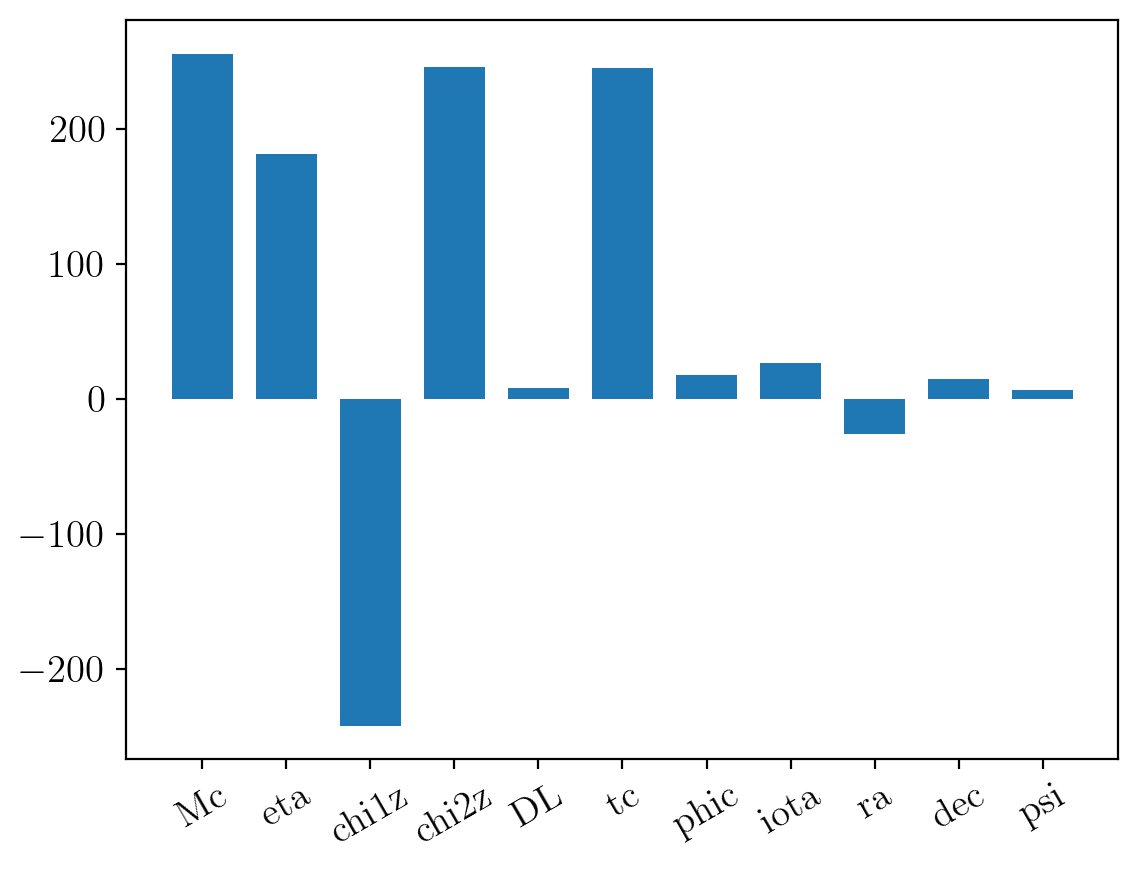

In [103]:
bias_opt_phic = net_ap_opt_phic.cutler_vallisneri_bias.tolist()[0]
err_opt_phic = np.zeros(len(bias_opt_phic))

for i, param in enumerate(net_ap_opt_phic.deriv_variables):
    err_opt_phic[i] = net_ap_opt_phic.errs[param]

print("Biases:", bias_opt_phic)
print("Errors:", err_opt_phic)

x = np.linspace(0, len(bias_opt_phic), len(bias_opt_phic))
plt.bar(x, bias_opt_phic/err_opt_phic)
plt.xticks(x, net_ap_opt_phic.deriv_variables, rotation=30)
plt.show()

## Bias Comparison

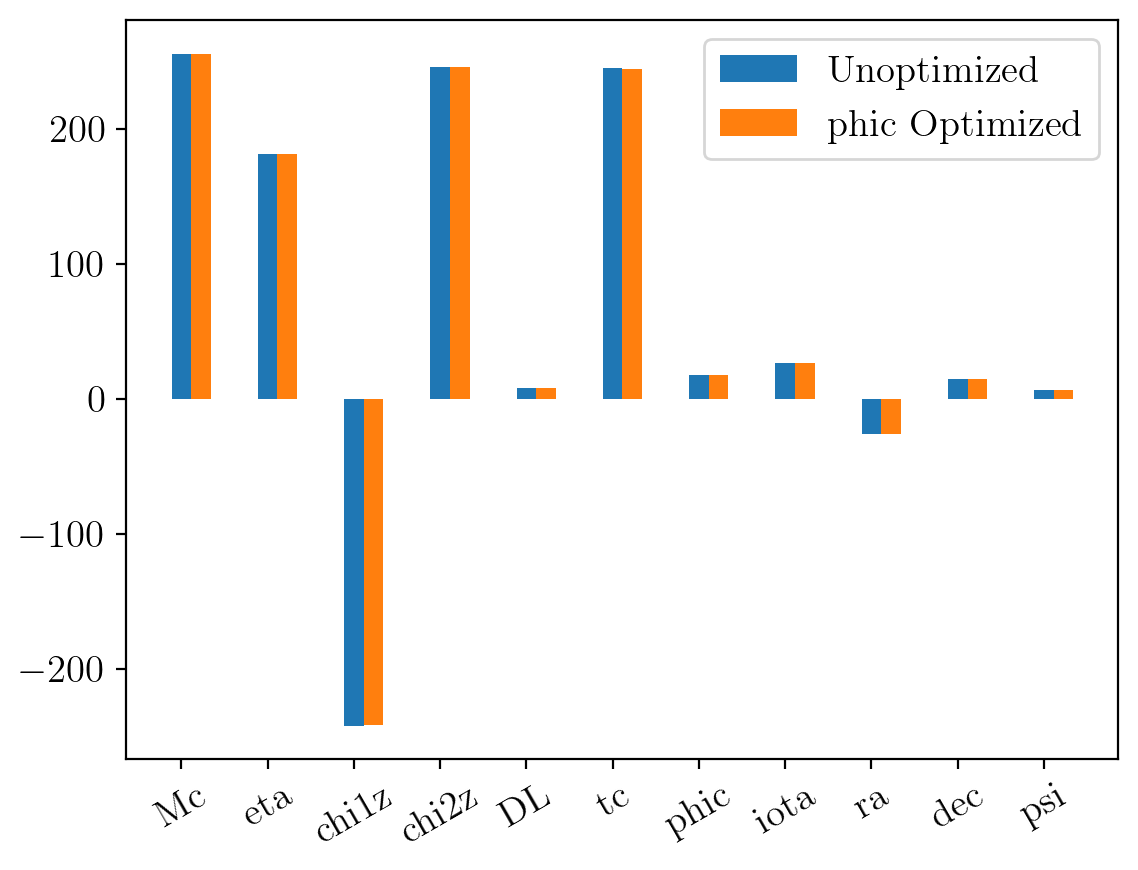

In [104]:
bias_opt_phic = net_ap_opt_phic.cutler_vallisneri_bias.tolist()[0]
err_opt_phic = np.zeros(len(bias_opt_phic))

bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))


for i, param in enumerate(net_ap_opt_phic.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]
    err_opt_phic[i] = net_ap_opt_phic.errs[param]


x = np.linspace(0, len(bias_opt_phic), len(bias_opt_phic))

width = 0.25
plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, bias_opt_phic/err_opt_phic, width=width, label='phic Optimized')

plt.xticks(x, net_ap_opt_phic.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

In [113]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
bias_opt_phic = net_ap_opt_phic.cutler_vallisneri_bias.tolist()[0]

for i, param in enumerate(net_ap.deriv_variables):
    bias1 = bias_no_opt[i]/net_ap.errs[param]
    bias2 = bias_opt_phic[i]/net_ap_opt_phic.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

Mc bias diff: 0.01%
Mc, not: 255.568 sigma
Mc, opt: 255.547 sigma

eta bias diff: -0.00%
eta, not: 181.301 sigma
eta, opt: 181.308 sigma

chi1z bias diff: 0.00%
chi1z, not: -241.991 sigma
chi1z, opt: -241.986 sigma

chi2z bias diff: -0.00%
chi2z, not: 245.741 sigma
chi2z, opt: 245.742 sigma

DL bias diff: 1.16%
DL, not: 7.819 sigma
DL, opt: 7.729 sigma

tc bias diff: 0.00%
tc, not: 244.473 sigma
tc, opt: 244.466 sigma

phic bias diff: 1.02%
phic, not: 17.354 sigma
phic, opt: 17.177 sigma

iota bias diff: -0.75%
iota, not: 26.345 sigma
iota, opt: 26.543 sigma

ra bias diff: 0.37%
ra, not: -26.289 sigma
ra, opt: -26.190 sigma

dec bias diff: 0.21%
dec, not: 14.277 sigma
dec, opt: 14.246 sigma

psi bias diff: 2.85%
psi, not: 6.301 sigma
psi, opt: 6.122 sigma



# Only $t_c$ optimized

In [106]:
h1_ts = td_waveforms_no_opt[0]
h1_fs = fd_waveforms_no_opt[0]
h2_fs = fd_waveforms_no_opt[3]

delta_t = h1_ts.delta_t

match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
tc = -index * delta_t
phic = -phi

print(match, tc, phic)

0.9999246518995833 -1.4828648898100516 2.366996263253947


In [114]:
# set the injection parameters
inj_params_opt_tc = inj_params.copy()
inj_params_opt_tc['tc'] = tc


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap_opt_tc = gwnet.get_hybrid_network_response(inj_params=inj_params_opt_tc, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

2023-10-17 08:57:09,561 - Network - INFO : Polarizations calculated.
2023-10-17 08:57:09,562 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 08:57:09,570 - Network - INFO : Polarizations calculated.
2023-10-17 08:57:10,940 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 08:57:11,129 - Network - INFO : PSDs loaded.
2023-10-17 08:57:11,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 08:57:11,162 - Network - INFO : Detector responses calculated.
2023-10-17 08:57:11,163 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 08:57:11,164 - Network - INFO :    CE-40_C
2023-10-17 08:57:12,086 - Network - INFO :    CE-20_S
2023-10-17 08:57:12,993 - Network - INFO :    ET_ET1
2023-10-17 08:57:13,869 - Network - INFO :    ET_ET2
2023-10-17 08:57:14,806 - Network - INFO :    ET_ET3
2023-10-17 08:57:15,672 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 0

In [115]:
fd_waveforms_opt_tc = get_pycbc_waveforms_fd(net_true, net_ap_opt_tc)

td_waveforms_opt_tc = get_pycbc_waveforms_td(net_true, net_ap_opt_tc)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


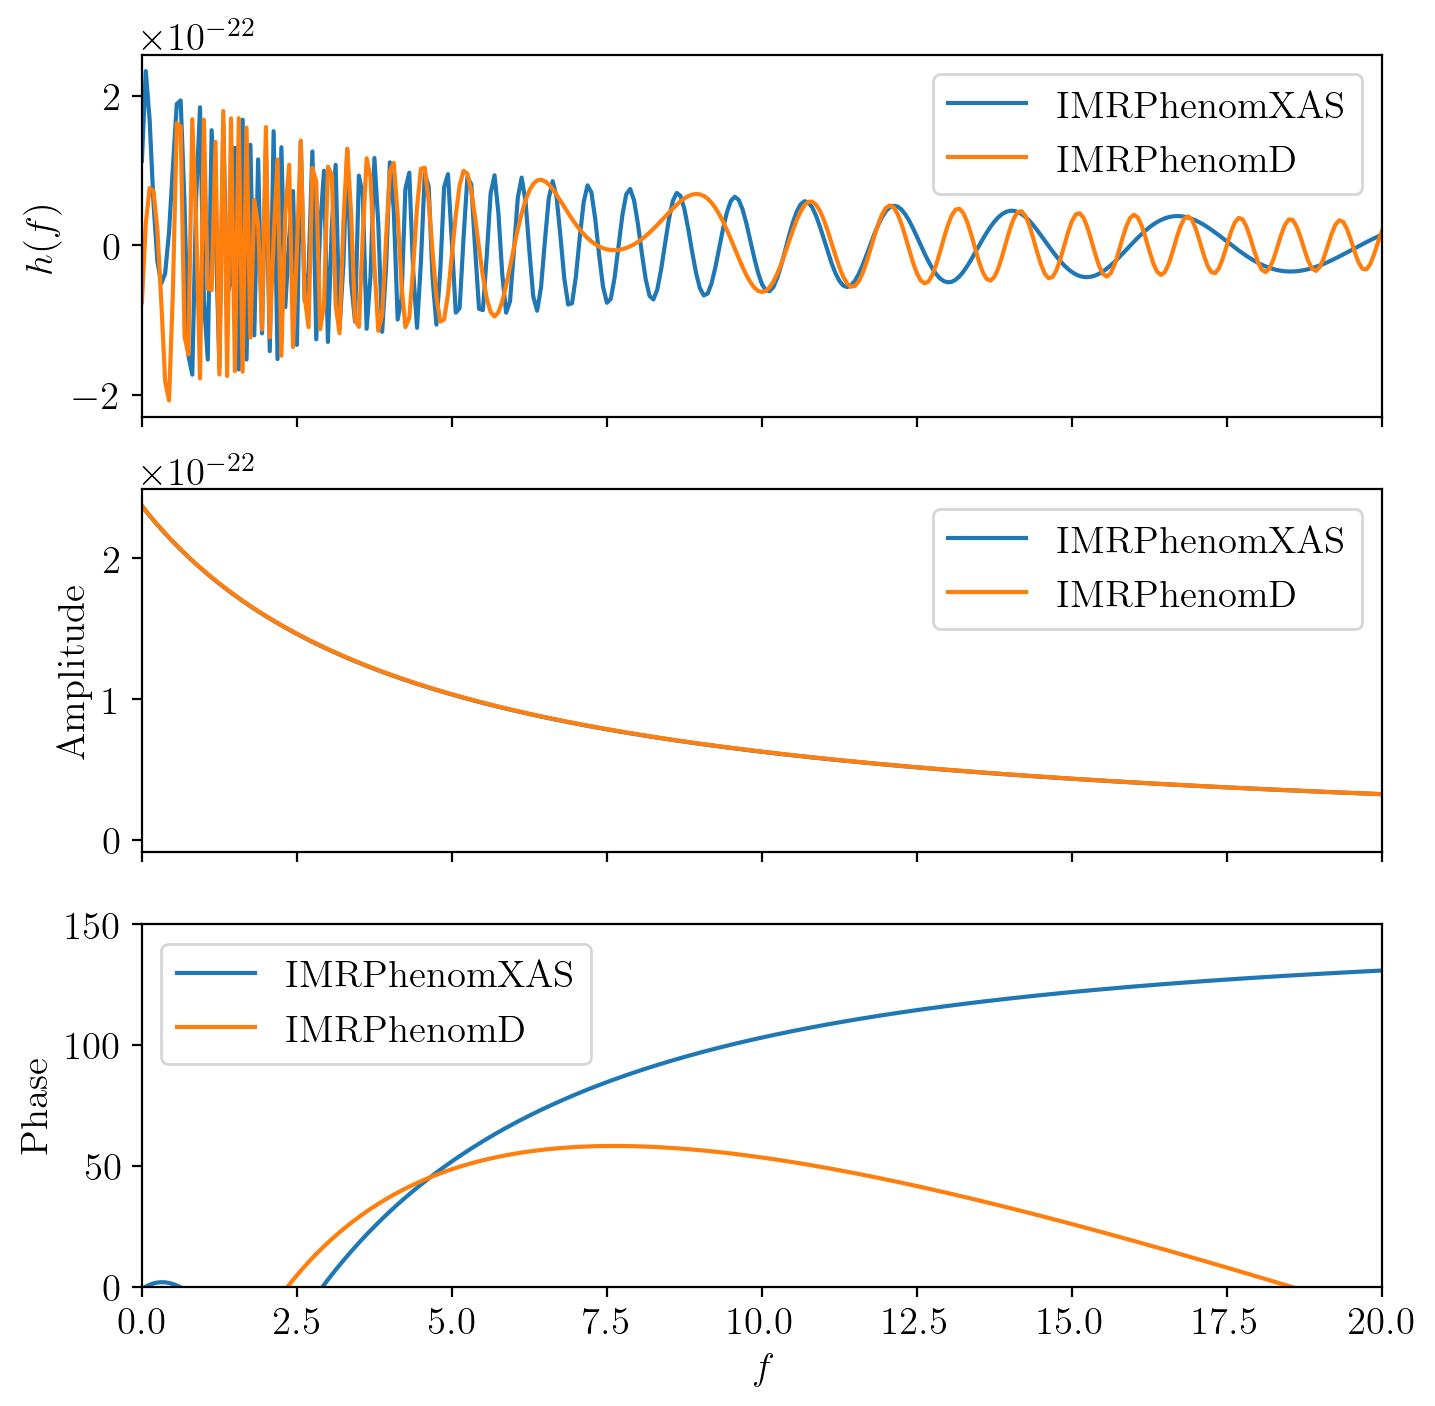

In [116]:
plot_f_series(*fd_waveforms_opt_tc)

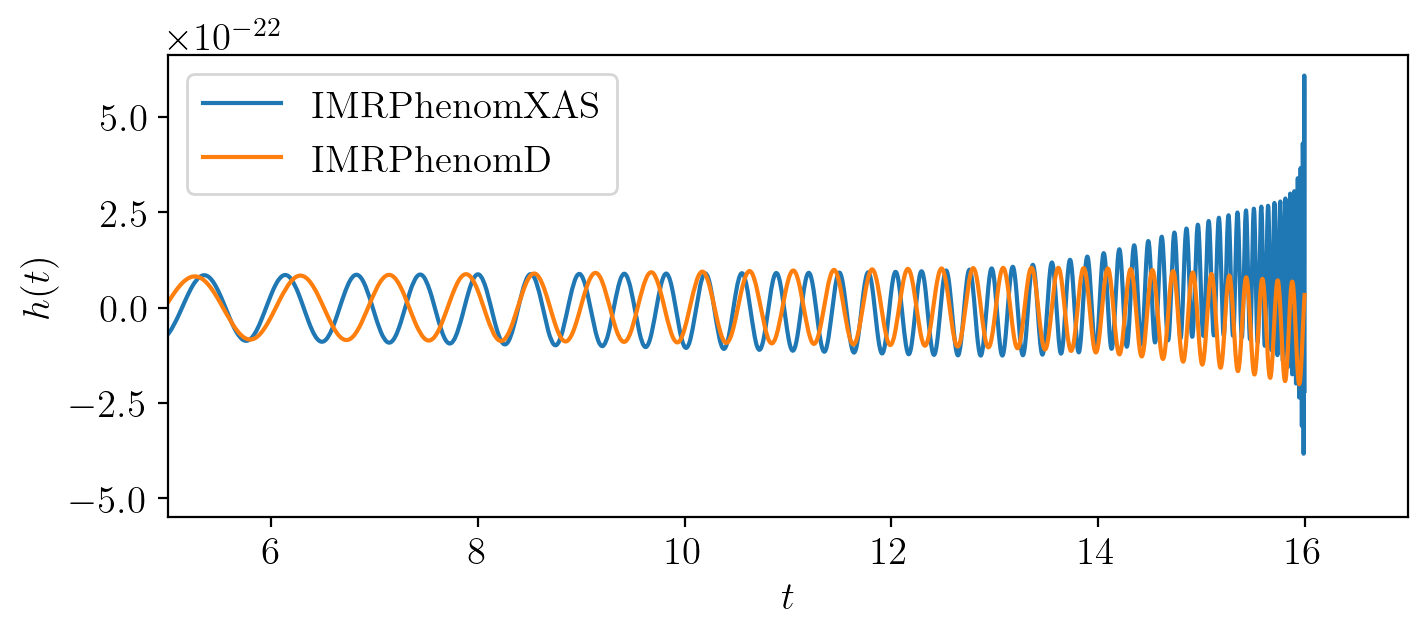

In [110]:
plot_t_series(*td_waveforms_opt_tc)

## Biases

Biases: [0.6965248035535438, 0.29457306858768106, -38.03557575094237, 47.50278904979132, 846.6850878167897, 0.2546963914820992, 12.327579121377312, 3.508921172116061, -0.012566290026169824, 0.005776960564340072, 2.1448770848727463]
Errors: [2.72739725e-03 1.62424077e-03 1.57169998e-01 1.93295196e-01
 1.02140656e+02 1.04179280e-03 7.27239132e-01 1.34431526e-01
 4.78059403e-04 3.99893819e-04 3.63473892e-01]


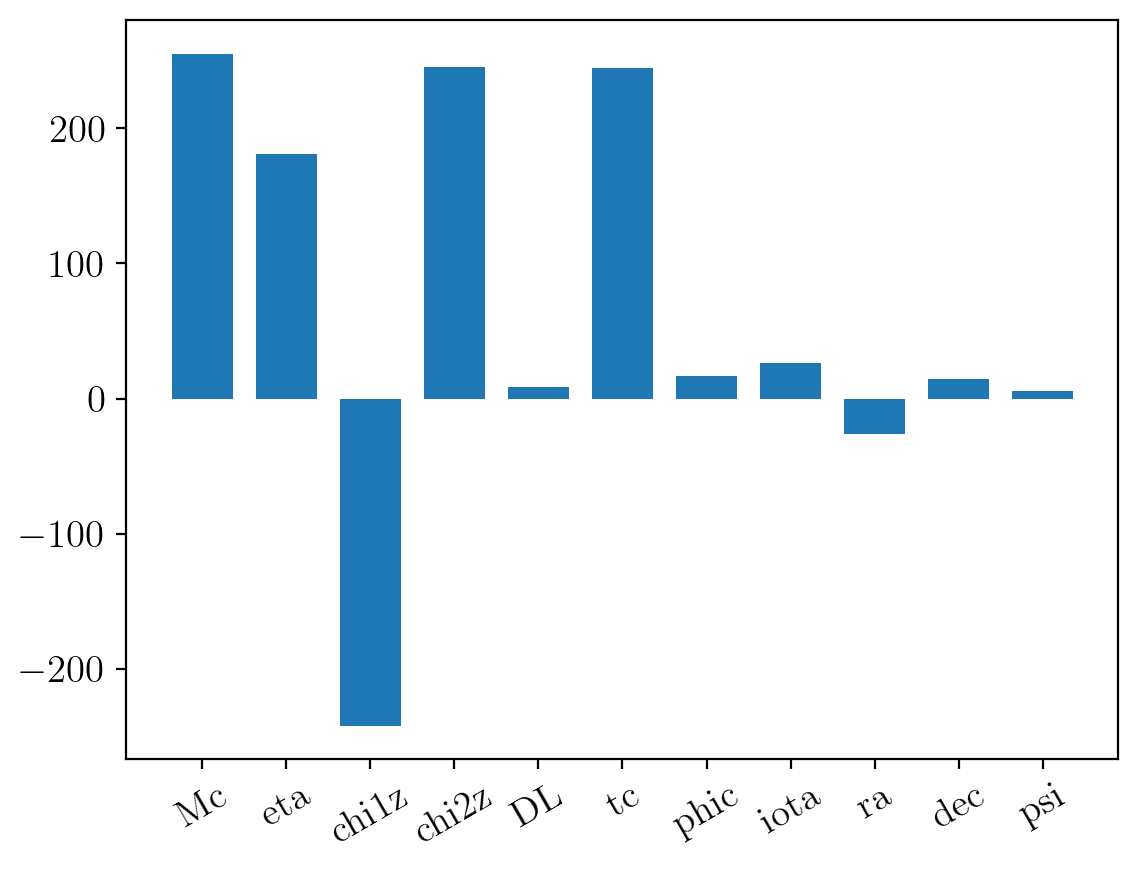

In [117]:
bias_opt_tc = net_ap_opt_tc.cutler_vallisneri_bias.tolist()[0]
err_opt_tc = np.zeros(len(bias_opt_tc))

for i, param in enumerate(net_ap_opt_tc.deriv_variables):
    err_opt_tc[i] = net_ap_opt_tc.errs[param]

print("Biases:", bias_opt_tc)
print("Errors:", err_opt_tc)

x = np.linspace(0, len(bias_opt_tc), len(bias_opt_tc))
plt.bar(x, bias_opt_tc/err_opt_tc)
plt.xticks(x, net_ap_opt_tc.deriv_variables, rotation=30)
plt.show()

## Bias Comparison

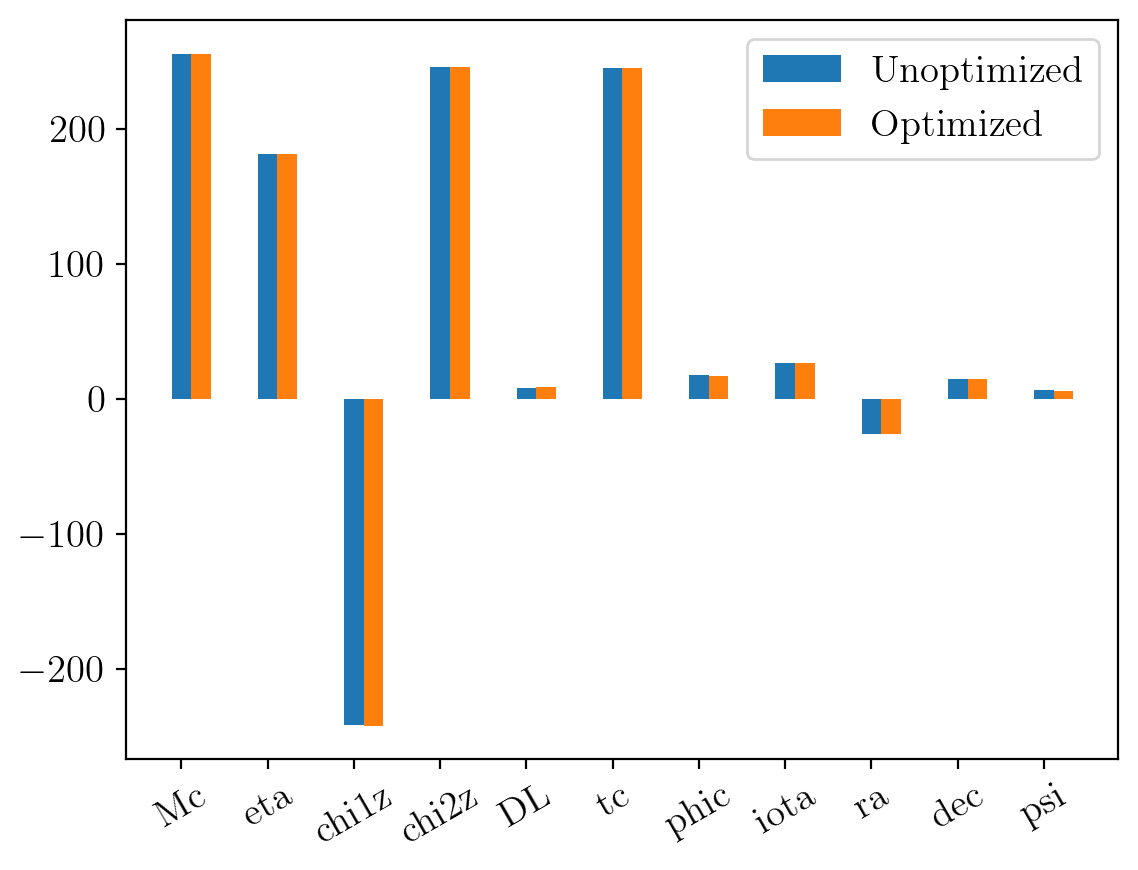

In [112]:
bias_opt_tc = net_ap_opt_tc.cutler_vallisneri_bias.tolist()[0]
err_opt_tc = np.zeros(len(bias_opt_tc))

bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))


for i, param in enumerate(net_ap_opt_tc.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]
    err_opt_tc[i] = net_ap_opt_tc.errs[param]


x = np.linspace(0, len(bias_opt_tc), len(bias_opt_tc))

width = 0.25
plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, bias_opt_tc/err_opt_tc, width=width, label='Optimized')

plt.xticks(x, net_ap_opt_tc.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

In [118]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
bias_opt_tc = net_ap_opt_tc.cutler_vallisneri_bias.tolist()[0]

for i, param in enumerate(net_ap.deriv_variables):
    bias1 = bias_no_opt[i]/net_ap.errs[param]
    bias2 = bias_opt_tc[i]/net_ap_opt_tc.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

Mc bias diff: 0.07%
Mc, not: 255.568 sigma
Mc, opt: 255.381 sigma

eta bias diff: -0.03%
eta, not: 181.301 sigma
eta, opt: 181.360 sigma

chi1z bias diff: -0.00%
chi1z, not: -241.991 sigma
chi1z, opt: -242.003 sigma

chi2z bias diff: -0.00%
chi2z, not: 245.741 sigma
chi2z, opt: 245.753 sigma

DL bias diff: -6.01%
DL, not: 7.819 sigma
DL, opt: 8.289 sigma

tc bias diff: -0.00%
tc, not: 244.473 sigma
tc, opt: 244.479 sigma

phic bias diff: 2.32%
phic, not: 17.354 sigma
phic, opt: 16.951 sigma

iota bias diff: 0.92%
iota, not: 26.345 sigma
iota, opt: 26.102 sigma

ra bias diff: 0.01%
ra, not: -26.289 sigma
ra, opt: -26.286 sigma

dec bias diff: -1.19%
dec, not: 14.277 sigma
dec, opt: 14.446 sigma

psi bias diff: 6.35%
psi, not: 6.301 sigma
psi, opt: 5.901 sigma



# Test over some random binaries

2023-10-17 10:13:35,868 - Network - INFO : Polarizations calculated.
2023-10-17 10:13:35,869 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:13:35,878 - Network - INFO : Polarizations calculated.


######  Binary 0  ######


2023-10-17 10:13:39,258 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:13:39,352 - Network - INFO : PSDs loaded.
2023-10-17 10:13:39,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:13:39,471 - Network - INFO : Detector responses calculated.
2023-10-17 10:13:39,473 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:13:39,474 - Network - INFO :    CE-40_C
2023-10-17 10:13:41,444 - Network - INFO :    CE-20_S
2023-10-17 10:13:43,228 - Network - INFO :    ET_ET1
2023-10-17 10:13:45,264 - Network - INFO :    ET_ET2
2023-10-17 10:13:46,826 - Network - INFO :    ET_ET3
2023-10-17 10:13:48,537 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:13:48,541 - Network - INFO : SNRs calculated.
2023-10-17 10:13:48,542 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:13:48,543 - Network - INFO :    CE-40_C
2023-10-17 10:13:48,621 - Network - INFO :

Mc bias diff: -12.36%
Mc, not: 0.049 sigma
Mc, opt: 0.055 sigma

eta bias diff: -0.63%
eta, not: -0.162 sigma
eta, opt: -0.163 sigma

chi1z bias diff: 1.23%
chi1z, not: 0.181 sigma
chi1z, opt: 0.179 sigma

chi2z bias diff: 1.72%
chi2z, not: -0.178 sigma
chi2z, opt: -0.175 sigma

DL bias diff: -0.73%
DL, not: 2.319 sigma
DL, opt: 2.336 sigma

tc bias diff: -0.32%
tc, not: -0.174 sigma
tc, opt: -0.174 sigma

phic bias diff: -15.15%
phic, not: 0.106 sigma
phic, opt: 0.122 sigma

iota bias diff: -17.61%
iota, not: 0.078 sigma
iota, opt: 0.092 sigma

ra bias diff: 2367.40%
ra, not: -0.000 sigma
ra, opt: 0.005 sigma

dec bias diff: 15.53%
dec, not: 0.057 sigma
dec, opt: 0.049 sigma

psi bias diff: 25.40%
psi, not: -0.047 sigma
psi, opt: -0.035 sigma



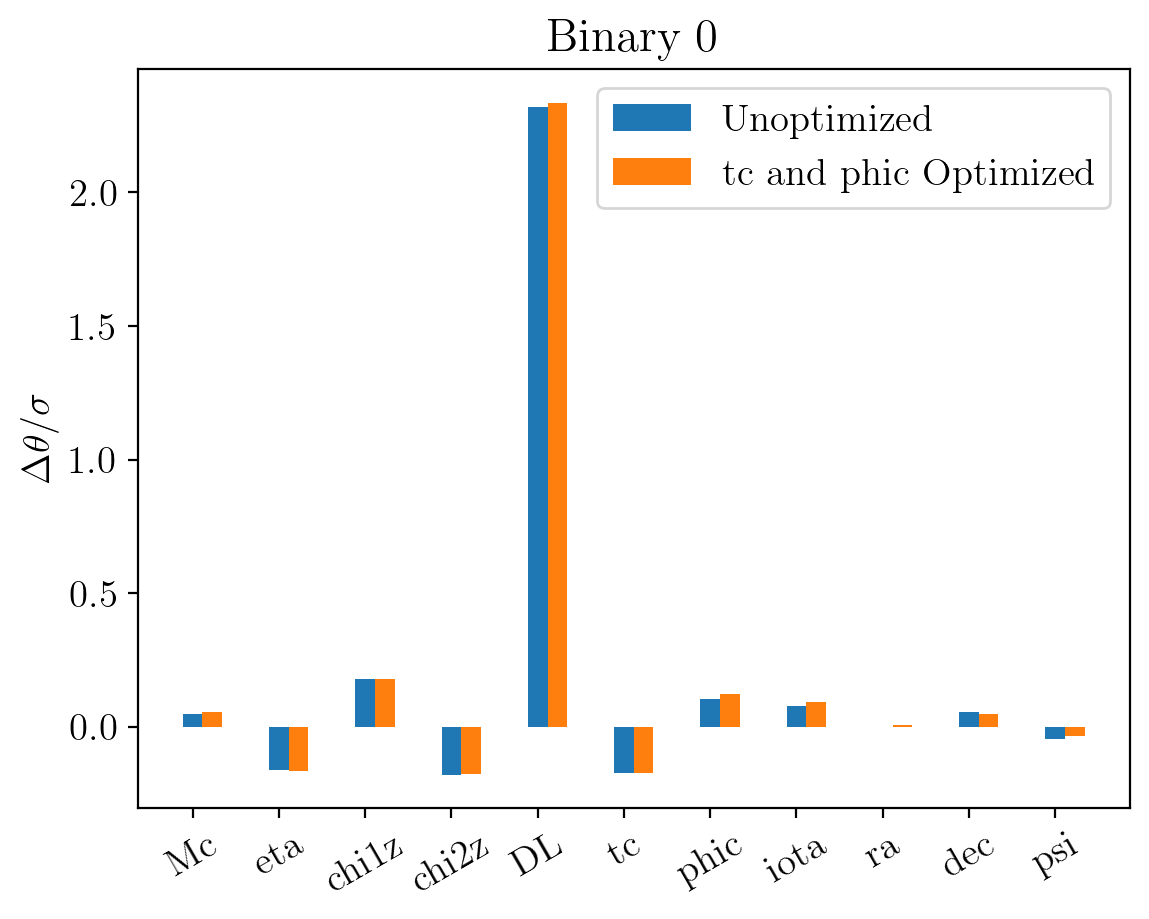

2023-10-17 10:13:59,882 - Network - INFO : Polarizations calculated.
2023-10-17 10:13:59,883 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:13:59,890 - Network - INFO : Polarizations calculated.


######  Binary 1  ######


2023-10-17 10:14:01,010 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:14:01,082 - Network - INFO : PSDs loaded.
2023-10-17 10:14:01,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:14:01,127 - Network - INFO : Detector responses calculated.
2023-10-17 10:14:01,128 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:14:01,129 - Network - INFO :    CE-40_C
2023-10-17 10:14:01,910 - Network - INFO :    CE-20_S
2023-10-17 10:14:02,700 - Network - INFO :    ET_ET1
2023-10-17 10:14:03,491 - Network - INFO :    ET_ET2
2023-10-17 10:14:04,277 - Network - INFO :    ET_ET3
2023-10-17 10:14:05,056 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:14:05,061 - Network - INFO : SNRs calculated.
2023-10-17 10:14:05,062 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:14:05,062 - Network - INFO :    CE-40_C
2023-10-17 10:14:05,135 - Network - INFO :

Mc bias diff: 19.96%
Mc, not: 0.836 sigma
Mc, opt: 0.669 sigma

eta bias diff: 17.06%
eta, not: 2.030 sigma
eta, opt: 1.684 sigma

chi1z bias diff: 15.75%
chi1z, not: -2.509 sigma
chi1z, opt: -2.114 sigma

chi2z bias diff: 15.62%
chi2z, not: 2.563 sigma
chi2z, opt: 2.163 sigma

DL bias diff: 7.53%
DL, not: 6.282 sigma
DL, opt: 5.809 sigma

tc bias diff: 15.50%
tc, not: 2.581 sigma
tc, opt: 2.181 sigma

phic bias diff: 14.00%
phic, not: 2.267 sigma
phic, opt: 1.950 sigma

iota bias diff: 260.20%
iota, not: -0.084 sigma
iota, opt: 0.135 sigma

ra bias diff: -228.48%
ra, not: 0.039 sigma
ra, opt: 0.129 sigma

dec bias diff: -723.33%
dec, not: 0.059 sigma
dec, opt: 0.487 sigma

psi bias diff: -598.47%
psi, not: -0.111 sigma
psi, opt: -0.773 sigma

######  Binary 2  ######


2023-10-17 10:14:13,202 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:14:13,251 - Network - INFO : PSDs loaded.
2023-10-17 10:14:13,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:14:13,289 - Network - INFO : Detector responses calculated.
2023-10-17 10:14:13,290 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:14:13,291 - Network - INFO :    CE-40_C
2023-10-17 10:14:14,557 - Network - INFO :    CE-20_S
2023-10-17 10:14:15,816 - Network - INFO :    ET_ET1
2023-10-17 10:14:17,096 - Network - INFO :    ET_ET2
2023-10-17 10:14:18,356 - Network - INFO :    ET_ET3
2023-10-17 10:14:19,525 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:14:19,530 - Network - INFO : SNRs calculated.
2023-10-17 10:14:19,530 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:14:19,531 - Network - INFO :    CE-40_C
2023-10-17 10:14:19,598 - Network - INFO :

Mc bias diff: -4.87%
Mc, not: 1.277 sigma
Mc, opt: 1.340 sigma

eta bias diff: -1.76%
eta, not: 1.937 sigma
eta, opt: 1.971 sigma

chi1z bias diff: -5.25%
chi1z, not: -1.447 sigma
chi1z, opt: -1.522 sigma

chi2z bias diff: -5.42%
chi2z, not: 1.430 sigma
chi2z, opt: 1.508 sigma

DL bias diff: 2.14%
DL, not: 7.574 sigma
DL, opt: 7.411 sigma

tc bias diff: -4.71%
tc, not: 1.531 sigma
tc, opt: 1.603 sigma

phic bias diff: -4.74%
phic, not: 1.265 sigma
phic, opt: 1.325 sigma

iota bias diff: -44.92%
iota, not: 0.847 sigma
iota, opt: 1.228 sigma

ra bias diff: 83.93%
ra, not: 0.080 sigma
ra, opt: 0.013 sigma

dec bias diff: 49.92%
dec, not: -0.069 sigma
dec, opt: -0.035 sigma

psi bias diff: -10.62%
psi, not: -0.109 sigma
psi, opt: -0.120 sigma

######  Binary 3  ######


2023-10-17 10:14:30,364 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:14:30,407 - Network - INFO : PSDs loaded.
2023-10-17 10:14:30,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:14:30,448 - Network - INFO : Detector responses calculated.
2023-10-17 10:14:30,449 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:14:30,449 - Network - INFO :    CE-40_C
2023-10-17 10:14:31,968 - Network - INFO :    CE-20_S
2023-10-17 10:14:33,490 - Network - INFO :    ET_ET1
2023-10-17 10:14:35,006 - Network - INFO :    ET_ET2
2023-10-17 10:14:36,541 - Network - INFO :    ET_ET3
2023-10-17 10:14:38,043 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:14:38,046 - Network - INFO : SNRs calculated.
2023-10-17 10:14:38,047 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:14:38,047 - Network - INFO :    CE-40_C
2023-10-17 10:14:38,105 - Network - INFO :

Mc bias diff: -0.32%
Mc, not: -2.008 sigma
Mc, opt: -2.014 sigma

eta bias diff: 0.03%
eta, not: 3.259 sigma
eta, opt: 3.258 sigma

chi1z bias diff: -0.65%
chi1z, not: -2.676 sigma
chi1z, opt: -2.694 sigma

chi2z bias diff: 0.26%
chi2z, not: 2.667 sigma
chi2z, opt: 2.660 sigma

DL bias diff: 0.93%
DL, not: 5.546 sigma
DL, opt: 5.494 sigma

tc bias diff: -0.51%
tc, not: 2.687 sigma
tc, opt: 2.700 sigma

phic bias diff: -0.39%
phic, not: 1.495 sigma
phic, opt: 1.500 sigma

iota bias diff: 243.55%
iota, not: 0.042 sigma
iota, opt: -0.061 sigma

ra bias diff: 22.99%
ra, not: -0.145 sigma
ra, opt: -0.112 sigma

dec bias diff: 37.35%
dec, not: -0.120 sigma
dec, opt: -0.075 sigma

psi bias diff: 0.05%
psi, not: -0.583 sigma
psi, opt: -0.583 sigma

######  Binary 4  ######


2023-10-17 10:14:51,317 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:14:51,359 - Network - INFO : PSDs loaded.
2023-10-17 10:14:51,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:14:51,398 - Network - INFO : Detector responses calculated.
2023-10-17 10:14:51,399 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:14:51,399 - Network - INFO :    CE-40_C
2023-10-17 10:14:52,867 - Network - INFO :    CE-20_S
2023-10-17 10:14:54,346 - Network - INFO :    ET_ET1
2023-10-17 10:14:55,835 - Network - INFO :    ET_ET2
2023-10-17 10:14:57,296 - Network - INFO :    ET_ET3
2023-10-17 10:14:58,784 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:14:58,788 - Network - INFO : SNRs calculated.
2023-10-17 10:14:58,788 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:14:58,788 - Network - INFO :    CE-40_C
2023-10-17 10:14:58,846 - Network - INFO :

Mc bias diff: -0.20%
Mc, not: -6.902 sigma
Mc, opt: -6.915 sigma

eta bias diff: 1.88%
eta, not: 7.291 sigma
eta, opt: 7.154 sigma

chi1z bias diff: 3.76%
chi1z, not: -5.067 sigma
chi1z, opt: -4.877 sigma

chi2z bias diff: 4.18%
chi2z, not: 4.637 sigma
chi2z, opt: 4.443 sigma

DL bias diff: 1.95%
DL, not: 23.120 sigma
DL, opt: 22.668 sigma

tc bias diff: 3.50%
tc, not: 4.861 sigma
tc, opt: 4.691 sigma

phic bias diff: 2.75%
phic, not: 5.871 sigma
phic, opt: 5.710 sigma

iota bias diff: 190.18%
iota, not: -0.519 sigma
iota, opt: 0.468 sigma

ra bias diff: 237.71%
ra, not: 0.424 sigma
ra, opt: -0.584 sigma

dec bias diff: 214.70%
dec, not: 0.423 sigma
dec, opt: -0.485 sigma

psi bias diff: -425.84%
psi, not: -0.200 sigma
psi, opt: -1.049 sigma

######  Binary 5  ######


2023-10-17 10:15:11,837 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:15:11,879 - Network - INFO : PSDs loaded.
2023-10-17 10:15:11,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:15:11,922 - Network - INFO : Detector responses calculated.
2023-10-17 10:15:11,923 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:15:11,923 - Network - INFO :    CE-40_C
2023-10-17 10:15:13,422 - Network - INFO :    CE-20_S
2023-10-17 10:15:14,894 - Network - INFO :    ET_ET1
2023-10-17 10:15:16,345 - Network - INFO :    ET_ET2
2023-10-17 10:15:17,871 - Network - INFO :    ET_ET3
2023-10-17 10:15:19,361 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:15:19,365 - Network - INFO : SNRs calculated.
2023-10-17 10:15:19,365 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:15:19,366 - Network - INFO :    CE-40_C
2023-10-17 10:15:19,426 - Network - INFO :

Mc bias diff: 4.60%
Mc, not: -2.615 sigma
Mc, opt: -2.494 sigma

eta bias diff: 2.83%
eta, not: 2.988 sigma
eta, opt: 2.903 sigma

chi1z bias diff: 1.80%
chi1z, not: -2.361 sigma
chi1z, opt: -2.318 sigma

chi2z bias diff: 1.48%
chi2z, not: 2.204 sigma
chi2z, opt: 2.172 sigma

DL bias diff: 32.59%
DL, not: 5.384 sigma
DL, opt: 3.629 sigma

tc bias diff: 1.68%
tc, not: 2.220 sigma
tc, opt: 2.183 sigma

phic bias diff: 31.10%
phic, not: 0.974 sigma
phic, opt: 0.671 sigma

iota bias diff: 1113.87%
iota, not: 0.315 sigma
iota, opt: -3.192 sigma

ra bias diff: 1838.68%
ra, not: -0.018 sigma
ra, opt: 0.319 sigma

dec bias diff: 579.04%
dec, not: 0.073 sigma
dec, opt: -0.348 sigma

psi bias diff: 249.84%
psi, not: -0.122 sigma
psi, opt: 0.183 sigma

######  Binary 6  ######


2023-10-17 10:15:30,893 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:15:30,962 - Network - INFO : PSDs loaded.
2023-10-17 10:15:30,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:15:31,002 - Network - INFO : Detector responses calculated.
2023-10-17 10:15:31,003 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:15:31,004 - Network - INFO :    CE-40_C
2023-10-17 10:15:31,650 - Network - INFO :    CE-20_S
2023-10-17 10:15:32,297 - Network - INFO :    ET_ET1
2023-10-17 10:15:32,943 - Network - INFO :    ET_ET2
2023-10-17 10:15:33,591 - Network - INFO :    ET_ET3
2023-10-17 10:15:34,241 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:15:34,245 - Network - INFO : SNRs calculated.
2023-10-17 10:15:34,246 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:15:34,246 - Network - INFO :    CE-40_C
2023-10-17 10:15:34,327 - Network - INFO :

Mc bias diff: -130.64%
Mc, not: 0.132 sigma
Mc, opt: 0.304 sigma

eta bias diff: 0.02%
eta, not: 1.494 sigma
eta, opt: 1.494 sigma

chi1z bias diff: -0.89%
chi1z, not: -1.723 sigma
chi1z, opt: -1.738 sigma

chi2z bias diff: -1.53%
chi2z, not: 1.798 sigma
chi2z, opt: 1.825 sigma

DL bias diff: 7.35%
DL, not: 4.313 sigma
DL, opt: 3.996 sigma

tc bias diff: -0.59%
tc, not: 1.758 sigma
tc, opt: 1.768 sigma

phic bias diff: -1.51%
phic, not: 1.728 sigma
phic, opt: 1.754 sigma

iota bias diff: 6143.33%
iota, not: -0.011 sigma
iota, opt: 0.659 sigma

ra bias diff: 2.13%
ra, not: 0.127 sigma
ra, opt: 0.124 sigma

dec bias diff: -677.92%
dec, not: 0.157 sigma
dec, opt: 1.218 sigma

psi bias diff: 917.31%
psi, not: -0.050 sigma
psi, opt: 0.409 sigma

######  Binary 7  ######


2023-10-17 10:15:42,852 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:15:42,969 - Network - INFO : PSDs loaded.
2023-10-17 10:15:42,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:15:43,028 - Network - INFO : Detector responses calculated.
2023-10-17 10:15:43,029 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:15:43,030 - Network - INFO :    CE-40_C
2023-10-17 10:15:45,475 - Network - INFO :    CE-20_S
2023-10-17 10:15:47,996 - Network - INFO :    ET_ET1
2023-10-17 10:15:50,367 - Network - INFO :    ET_ET2
2023-10-17 10:15:52,776 - Network - INFO :    ET_ET3
2023-10-17 10:15:55,170 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:15:55,176 - Network - INFO : SNRs calculated.
2023-10-17 10:15:55,176 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:15:55,176 - Network - INFO :    CE-40_C
2023-10-17 10:15:55,248 - Network - INFO :

Mc bias diff: 3.81%
Mc, not: -0.333 sigma
Mc, opt: -0.321 sigma

eta bias diff: -94.78%
eta, not: 0.085 sigma
eta, opt: 0.166 sigma

chi1z bias diff: 115.37%
chi1z, not: 0.055 sigma
chi1z, opt: -0.008 sigma

chi2z bias diff: -187.00%
chi2z, not: -0.036 sigma
chi2z, opt: -0.104 sigma

DL bias diff: 0.01%
DL, not: 24.819 sigma
DL, opt: 24.817 sigma

tc bias diff: 9.39%
tc, not: -0.277 sigma
tc, opt: -0.251 sigma

phic bias diff: -0.63%
phic, not: 1.611 sigma
phic, opt: 1.622 sigma

iota bias diff: 0.61%
iota, not: -0.380 sigma
iota, opt: -0.378 sigma

ra bias diff: -1.82%
ra, not: 0.123 sigma
ra, opt: 0.125 sigma

dec bias diff: 0.44%
dec, not: 0.124 sigma
dec, opt: 0.123 sigma

psi bias diff: 1.98%
psi, not: -0.146 sigma
psi, opt: -0.143 sigma

######  Binary 8  ######


2023-10-17 10:16:15,544 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:16:15,588 - Network - INFO : PSDs loaded.
2023-10-17 10:16:15,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:16:15,636 - Network - INFO : Detector responses calculated.
2023-10-17 10:16:15,637 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:16:15,637 - Network - INFO :    CE-40_C
2023-10-17 10:16:17,639 - Network - INFO :    CE-20_S
2023-10-17 10:16:19,559 - Network - INFO :    ET_ET1
2023-10-17 10:16:21,495 - Network - INFO :    ET_ET2
2023-10-17 10:16:23,395 - Network - INFO :    ET_ET3
2023-10-17 10:16:26,430 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:16:26,435 - Network - INFO : SNRs calculated.
2023-10-17 10:16:26,436 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:16:26,436 - Network - INFO :    CE-40_C
2023-10-17 10:16:26,509 - Network - INFO :

Mc bias diff: 0.33%
Mc, not: -10.742 sigma
Mc, opt: -10.707 sigma

eta bias diff: -0.04%
eta, not: 9.787 sigma
eta, opt: 9.791 sigma

chi1z bias diff: -0.31%
chi1z, not: -7.549 sigma
chi1z, opt: -7.573 sigma

chi2z bias diff: -0.46%
chi2z, not: 7.215 sigma
chi2z, opt: 7.249 sigma

DL bias diff: 1.18%
DL, not: 13.407 sigma
DL, opt: 13.248 sigma

tc bias diff: -0.30%
tc, not: 7.478 sigma
tc, opt: 7.501 sigma

phic bias diff: -0.84%
phic, not: 2.741 sigma
phic, opt: 2.764 sigma

iota bias diff: 16.44%
iota, not: 1.723 sigma
iota, opt: 1.440 sigma

ra bias diff: 74.05%
ra, not: -0.056 sigma
ra, opt: -0.014 sigma

dec bias diff: -37.24%
dec, not: 0.196 sigma
dec, opt: 0.269 sigma

psi bias diff: -48.45%
psi, not: -0.051 sigma
psi, opt: -0.076 sigma

######  Binary 9  ######


2023-10-17 10:16:43,253 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:16:43,324 - Network - INFO : PSDs loaded.
2023-10-17 10:16:43,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:16:43,364 - Network - INFO : Detector responses calculated.
2023-10-17 10:16:43,365 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:16:43,366 - Network - INFO :    CE-40_C
2023-10-17 10:16:44,008 - Network - INFO :    CE-20_S
2023-10-17 10:16:44,640 - Network - INFO :    ET_ET1
2023-10-17 10:16:45,297 - Network - INFO :    ET_ET2
2023-10-17 10:16:45,949 - Network - INFO :    ET_ET3
2023-10-17 10:16:46,572 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:16:46,576 - Network - INFO : SNRs calculated.
2023-10-17 10:16:46,577 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:16:46,577 - Network - INFO :    CE-40_C
2023-10-17 10:16:46,657 - Network - INFO :

Mc bias diff: 8.35%
Mc, not: 0.320 sigma
Mc, opt: 0.293 sigma

eta bias diff: 21.97%
eta, not: 1.954 sigma
eta, opt: 1.525 sigma

chi1z bias diff: 8.46%
chi1z, not: -2.342 sigma
chi1z, opt: -2.144 sigma

chi2z bias diff: 8.33%
chi2z, not: 2.349 sigma
chi2z, opt: 2.153 sigma

DL bias diff: 12.76%
DL, not: 4.994 sigma
DL, opt: 4.357 sigma

tc bias diff: 7.86%
tc, not: 2.320 sigma
tc, opt: 2.137 sigma

phic bias diff: 8.31%
phic, not: 2.274 sigma
phic, opt: 2.085 sigma

iota bias diff: -1335.49%
iota, not: -0.078 sigma
iota, opt: -1.118 sigma

ra bias diff: -498.23%
ra, not: 0.257 sigma
ra, opt: 1.540 sigma

dec bias diff: -1647.43%
dec, not: -0.104 sigma
dec, opt: -1.826 sigma

psi bias diff: -2111.05%
psi, not: -0.046 sigma
psi, opt: -1.022 sigma

######  Binary 10  ######


2023-10-17 10:16:53,525 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:16:53,567 - Network - INFO : PSDs loaded.
2023-10-17 10:16:53,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:16:53,606 - Network - INFO : Detector responses calculated.
2023-10-17 10:16:53,607 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:16:53,608 - Network - INFO :    CE-40_C
2023-10-17 10:16:55,001 - Network - INFO :    CE-20_S
2023-10-17 10:16:56,372 - Network - INFO :    ET_ET1
2023-10-17 10:16:57,781 - Network - INFO :    ET_ET2
2023-10-17 10:16:59,123 - Network - INFO :    ET_ET3
2023-10-17 10:17:00,487 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:17:00,490 - Network - INFO : SNRs calculated.
2023-10-17 10:17:00,491 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:17:00,491 - Network - INFO :    CE-40_C
2023-10-17 10:17:00,549 - Network - INFO :

Mc bias diff: -55.47%
Mc, not: -0.077 sigma
Mc, opt: -0.120 sigma

eta bias diff: -1.32%
eta, not: 0.790 sigma
eta, opt: 0.800 sigma

chi1z bias diff: -0.44%
chi1z, not: -0.871 sigma
chi1z, opt: -0.875 sigma

chi2z bias diff: 0.03%
chi2z, not: 0.885 sigma
chi2z, opt: 0.885 sigma

DL bias diff: 0.92%
DL, not: 8.826 sigma
DL, opt: 8.745 sigma

tc bias diff: 0.62%
tc, not: 0.913 sigma
tc, opt: 0.907 sigma

phic bias diff: 0.20%
phic, not: 0.823 sigma
phic, opt: 0.821 sigma

iota bias diff: 537.29%
iota, not: -0.050 sigma
iota, opt: 0.217 sigma

ra bias diff: -41.59%
ra, not: 0.228 sigma
ra, opt: 0.323 sigma

dec bias diff: -30.22%
dec, not: -0.140 sigma
dec, opt: -0.183 sigma

psi bias diff: -21.94%
psi, not: -0.027 sigma
psi, opt: -0.033 sigma



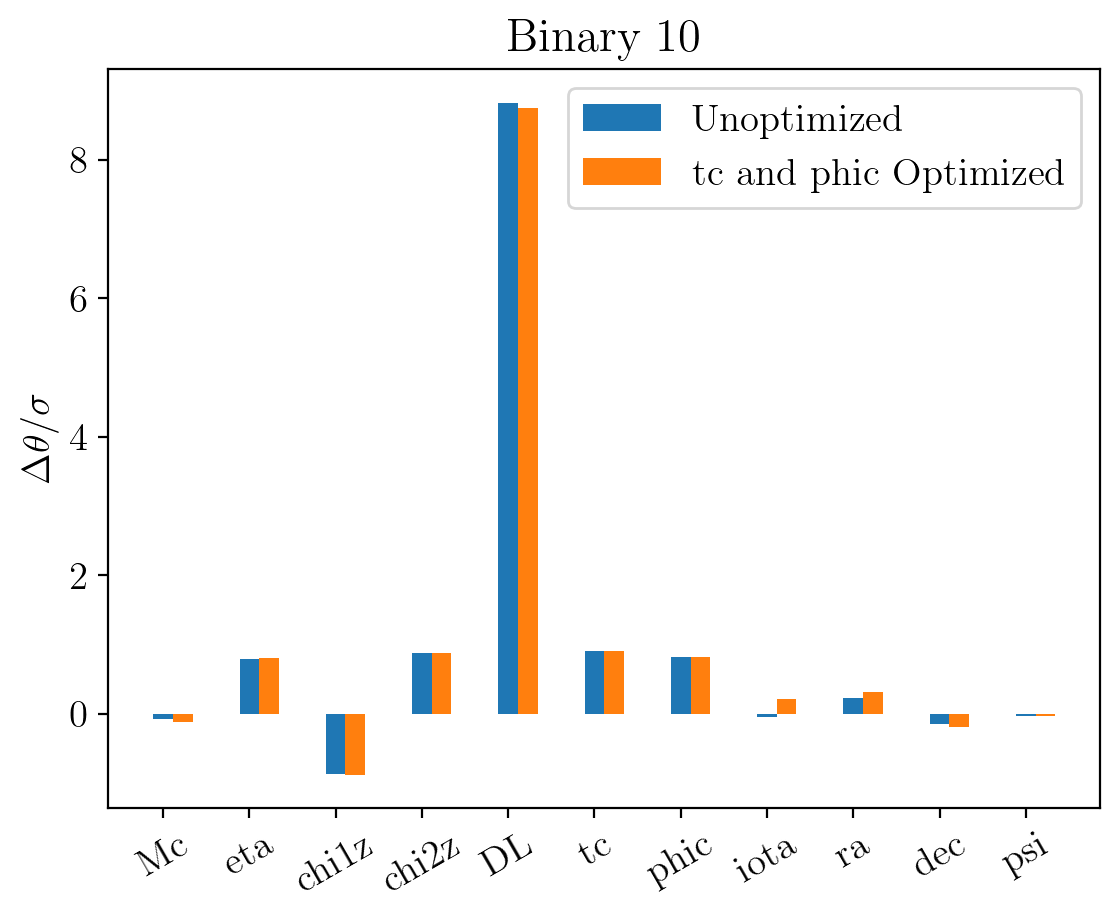

2023-10-17 10:17:11,044 - Network - INFO : Polarizations calculated.
2023-10-17 10:17:11,045 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:17:11,058 - Network - INFO : Polarizations calculated.


######  Binary 11  ######


2023-10-17 10:17:13,855 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:17:13,900 - Network - INFO : PSDs loaded.
2023-10-17 10:17:13,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:17:13,943 - Network - INFO : Detector responses calculated.
2023-10-17 10:17:13,944 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:17:13,944 - Network - INFO :    CE-40_C
2023-10-17 10:17:16,056 - Network - INFO :    CE-20_S
2023-10-17 10:17:17,963 - Network - INFO :    ET_ET1
2023-10-17 10:17:19,621 - Network - INFO :    ET_ET2
2023-10-17 10:17:21,300 - Network - INFO :    ET_ET3
2023-10-17 10:17:22,910 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:17:22,914 - Network - INFO : SNRs calculated.
2023-10-17 10:17:22,914 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:17:22,915 - Network - INFO :    CE-40_C
2023-10-17 10:17:22,975 - Network - INFO :

Mc bias diff: 3.53%
Mc, not: -0.339 sigma
Mc, opt: -0.327 sigma

eta bias diff: 5.62%
eta, not: 0.268 sigma
eta, opt: 0.253 sigma

chi1z bias diff: -4.99%
chi1z, not: 0.257 sigma
chi1z, opt: 0.270 sigma

chi2z bias diff: -4.57%
chi2z, not: -0.253 sigma
chi2z, opt: -0.265 sigma

DL bias diff: 0.12%
DL, not: 16.123 sigma
DL, opt: 16.104 sigma

tc bias diff: -19.55%
tc, not: -0.079 sigma
tc, opt: -0.094 sigma

phic bias diff: 1.37%
phic, not: 0.642 sigma
phic, opt: 0.633 sigma

iota bias diff: -14.07%
iota, not: -0.091 sigma
iota, opt: -0.104 sigma

ra bias diff: -3.84%
ra, not: -0.113 sigma
ra, opt: -0.117 sigma

dec bias diff: -0.47%
dec, not: -0.203 sigma
dec, opt: -0.204 sigma

psi bias diff: -4.10%
psi, not: 0.238 sigma
psi, opt: 0.248 sigma

######  Binary 12  ######


2023-10-17 10:17:37,038 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:17:37,102 - Network - INFO : PSDs loaded.
2023-10-17 10:17:37,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:17:37,134 - Network - INFO : Detector responses calculated.
2023-10-17 10:17:37,134 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:17:37,135 - Network - INFO :    CE-40_C
2023-10-17 10:17:37,984 - Network - INFO :    CE-20_S
2023-10-17 10:17:38,814 - Network - INFO :    ET_ET1
2023-10-17 10:17:39,642 - Network - INFO :    ET_ET2
2023-10-17 10:17:40,464 - Network - INFO :    ET_ET3
2023-10-17 10:17:41,303 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:17:41,306 - Network - INFO : SNRs calculated.
2023-10-17 10:17:41,306 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:17:41,307 - Network - INFO :    CE-40_C
2023-10-17 10:17:41,365 - Network - INFO :

Mc bias diff: -0.29%
Mc, not: 9.191 sigma
Mc, opt: 9.217 sigma

eta bias diff: 0.05%
eta, not: 9.268 sigma
eta, opt: 9.263 sigma

chi1z bias diff: -0.14%
chi1z, not: -10.804 sigma
chi1z, opt: -10.819 sigma

chi2z bias diff: -0.12%
chi2z, not: 10.936 sigma
chi2z, opt: 10.949 sigma

DL bias diff: 36.52%
DL, not: 1.040 sigma
DL, opt: 0.660 sigma

tc bias diff: -0.14%
tc, not: 10.785 sigma
tc, opt: 10.799 sigma

phic bias diff: 78.07%
phic, not: 0.096 sigma
phic, opt: 0.021 sigma

iota bias diff: -659.16%
iota, not: 1.996 sigma
iota, opt: 15.151 sigma

ra bias diff: -15.36%
ra, not: -0.397 sigma
ra, opt: -0.458 sigma

dec bias diff: -36.61%
dec, not: -0.877 sigma
dec, opt: -1.198 sigma

psi bias diff: -7.99%
psi, not: -0.806 sigma
psi, opt: -0.871 sigma

######  Binary 13  ######


2023-10-17 10:17:49,927 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:17:49,969 - Network - INFO : PSDs loaded.
2023-10-17 10:17:49,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:17:50,005 - Network - INFO : Detector responses calculated.
2023-10-17 10:17:50,006 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:17:50,007 - Network - INFO :    CE-40_C
2023-10-17 10:17:51,252 - Network - INFO :    CE-20_S
2023-10-17 10:17:52,559 - Network - INFO :    ET_ET1
2023-10-17 10:17:53,840 - Network - INFO :    ET_ET2
2023-10-17 10:17:55,291 - Network - INFO :    ET_ET3
2023-10-17 10:17:56,539 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:17:56,542 - Network - INFO : SNRs calculated.
2023-10-17 10:17:56,543 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:17:56,543 - Network - INFO :    CE-40_C
2023-10-17 10:17:56,607 - Network - INFO :

Mc bias diff: -0.48%
Mc, not: 0.743 sigma
Mc, opt: 0.746 sigma

eta bias diff: 3.24%
eta, not: 1.665 sigma
eta, opt: 1.611 sigma

chi1z bias diff: 3.55%
chi1z, not: -1.385 sigma
chi1z, opt: -1.336 sigma

chi2z bias diff: 3.60%
chi2z, not: 1.359 sigma
chi2z, opt: 1.310 sigma

DL bias diff: 1.32%
DL, not: 13.525 sigma
DL, opt: 13.347 sigma

tc bias diff: 3.69%
tc, not: 1.385 sigma
tc, opt: 1.334 sigma

phic bias diff: 3.17%
phic, not: 1.225 sigma
phic, opt: 1.186 sigma

iota bias diff: 109.22%
iota, not: 0.306 sigma
iota, opt: -0.028 sigma

ra bias diff: 66.36%
ra, not: -0.113 sigma
ra, opt: -0.038 sigma

dec bias diff: 12.47%
dec, not: -0.232 sigma
dec, opt: -0.203 sigma

psi bias diff: -16.29%
psi, not: -0.279 sigma
psi, opt: -0.324 sigma

######  Binary 14  ######


2023-10-17 10:18:07,742 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:18:07,790 - Network - INFO : PSDs loaded.
2023-10-17 10:18:07,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:18:07,828 - Network - INFO : Detector responses calculated.
2023-10-17 10:18:07,829 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:18:07,829 - Network - INFO :    CE-40_C
2023-10-17 10:18:08,946 - Network - INFO :    CE-20_S
2023-10-17 10:18:10,023 - Network - INFO :    ET_ET1
2023-10-17 10:18:11,185 - Network - INFO :    ET_ET2
2023-10-17 10:18:12,300 - Network - INFO :    ET_ET3
2023-10-17 10:18:13,418 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:18:13,423 - Network - INFO : SNRs calculated.
2023-10-17 10:18:13,424 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:18:13,424 - Network - INFO :    CE-40_C
2023-10-17 10:18:13,486 - Network - INFO :

Mc bias diff: 10.57%
Mc, not: 3.893 sigma
Mc, opt: 3.482 sigma

eta bias diff: 15.13%
eta, not: 1.541 sigma
eta, opt: 1.308 sigma

chi1z bias diff: 21.29%
chi1z, not: -2.388 sigma
chi1z, opt: -1.879 sigma

chi2z bias diff: 21.95%
chi2z, not: 2.528 sigma
chi2z, opt: 1.973 sigma

DL bias diff: 83.52%
DL, not: 3.977 sigma
DL, opt: 0.656 sigma

tc bias diff: 22.37%
tc, not: 2.469 sigma
tc, opt: 1.917 sigma

phic bias diff: -19.35%
phic, not: 0.984 sigma
phic, opt: 1.174 sigma

iota bias diff: 19832.56%
iota, not: -0.049 sigma
iota, opt: 9.585 sigma

ra bias diff: 705.85%
ra, not: -0.066 sigma
ra, opt: 0.402 sigma

dec bias diff: -8181.18%
dec, not: 0.016 sigma
dec, opt: 1.340 sigma

psi bias diff: -38.54%
psi, not: 0.732 sigma
psi, opt: 1.014 sigma

######  Binary 15  ######


2023-10-17 10:18:23,745 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:18:23,787 - Network - INFO : PSDs loaded.
2023-10-17 10:18:23,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:18:23,824 - Network - INFO : Detector responses calculated.
2023-10-17 10:18:23,824 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:18:23,825 - Network - INFO :    CE-40_C
2023-10-17 10:18:25,141 - Network - INFO :    CE-20_S
2023-10-17 10:18:26,429 - Network - INFO :    ET_ET1
2023-10-17 10:18:27,797 - Network - INFO :    ET_ET2
2023-10-17 10:18:29,085 - Network - INFO :    ET_ET3
2023-10-17 10:18:30,457 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:18:30,461 - Network - INFO : SNRs calculated.
2023-10-17 10:18:30,461 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:18:30,461 - Network - INFO :    CE-40_C
2023-10-17 10:18:30,518 - Network - INFO :

Mc bias diff: -1.14%
Mc, not: -0.170 sigma
Mc, opt: -0.172 sigma

eta bias diff: 0.02%
eta, not: 1.377 sigma
eta, opt: 1.377 sigma

chi1z bias diff: 0.18%
chi1z, not: -1.407 sigma
chi1z, opt: -1.404 sigma

chi2z bias diff: 0.20%
chi2z, not: 1.390 sigma
chi2z, opt: 1.387 sigma

DL bias diff: -194.13%
DL, not: 0.040 sigma
DL, opt: 0.118 sigma

tc bias diff: 0.16%
tc, not: 1.386 sigma
tc, opt: 1.384 sigma

phic bias diff: 114.52%
phic, not: 0.126 sigma
phic, opt: -0.018 sigma

iota bias diff: -78.10%
iota, not: -0.506 sigma
iota, opt: -0.901 sigma

ra bias diff: 92.43%
ra, not: 0.092 sigma
ra, opt: 0.007 sigma

dec bias diff: 30.79%
dec, not: 0.230 sigma
dec, opt: 0.159 sigma

psi bias diff: 119.59%
psi, not: -0.123 sigma
psi, opt: 0.024 sigma

######  Binary 16  ######


2023-10-17 10:18:43,574 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:18:43,691 - Network - INFO : PSDs loaded.
2023-10-17 10:18:43,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:18:43,744 - Network - INFO : Detector responses calculated.
2023-10-17 10:18:43,745 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:18:43,745 - Network - INFO :    CE-40_C
2023-10-17 10:18:45,996 - Network - INFO :    CE-20_S
2023-10-17 10:18:48,184 - Network - INFO :    ET_ET1
2023-10-17 10:18:50,349 - Network - INFO :    ET_ET2
2023-10-17 10:18:52,523 - Network - INFO :    ET_ET3
2023-10-17 10:18:54,653 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:18:54,658 - Network - INFO : SNRs calculated.
2023-10-17 10:18:54,658 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:18:54,659 - Network - INFO :    CE-40_C
2023-10-17 10:18:54,727 - Network - INFO :

Mc bias diff: -0.17%
Mc, not: -5.823 sigma
Mc, opt: -5.833 sigma

eta bias diff: -0.84%
eta, not: 4.793 sigma
eta, opt: 4.833 sigma

chi1z bias diff: -0.02%
chi1z, not: -3.193 sigma
chi1z, opt: -3.193 sigma

chi2z bias diff: -0.20%
chi2z, not: 2.892 sigma
chi2z, opt: 2.898 sigma

DL bias diff: 0.01%
DL, not: 57.352 sigma
DL, opt: 57.345 sigma

tc bias diff: 0.76%
tc, not: 3.074 sigma
tc, opt: 3.051 sigma

phic bias diff: -0.16%
phic, not: 7.001 sigma
phic, opt: 7.012 sigma

iota bias diff: 3.11%
iota, not: 0.625 sigma
iota, opt: 0.606 sigma

ra bias diff: -5.96%
ra, not: -0.139 sigma
ra, opt: -0.148 sigma

dec bias diff: -0.12%
dec, not: -0.726 sigma
dec, opt: -0.727 sigma

psi bias diff: -0.66%
psi, not: 1.045 sigma
psi, opt: 1.052 sigma

######  Binary 17  ######


2023-10-17 10:19:13,533 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:19:13,577 - Network - INFO : PSDs loaded.
2023-10-17 10:19:13,580 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:19:13,618 - Network - INFO : Detector responses calculated.
2023-10-17 10:19:13,619 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:19:13,619 - Network - INFO :    CE-40_C
2023-10-17 10:19:15,123 - Network - INFO :    CE-20_S
2023-10-17 10:19:16,592 - Network - INFO :    ET_ET1
2023-10-17 10:19:18,100 - Network - INFO :    ET_ET2
2023-10-17 10:19:19,663 - Network - INFO :    ET_ET3
2023-10-17 10:19:21,141 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:19:21,144 - Network - INFO : SNRs calculated.
2023-10-17 10:19:21,145 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:19:21,145 - Network - INFO :    CE-40_C
2023-10-17 10:19:21,203 - Network - INFO :

Mc bias diff: 2.33%
Mc, not: -0.749 sigma
Mc, opt: -0.732 sigma

eta bias diff: 1.87%
eta, not: 1.344 sigma
eta, opt: 1.319 sigma

chi1z bias diff: 2.01%
chi1z, not: -1.232 sigma
chi1z, opt: -1.207 sigma

chi2z bias diff: 1.00%
chi2z, not: 1.210 sigma
chi2z, opt: 1.198 sigma

DL bias diff: 0.99%
DL, not: 9.608 sigma
DL, opt: 9.513 sigma

tc bias diff: 1.69%
tc, not: 1.128 sigma
tc, opt: 1.109 sigma

phic bias diff: 2.26%
phic, not: 1.113 sigma
phic, opt: 1.087 sigma

iota bias diff: -74.57%
iota, not: 0.291 sigma
iota, opt: 0.507 sigma

ra bias diff: 19.40%
ra, not: -0.086 sigma
ra, opt: -0.069 sigma

dec bias diff: 361.61%
dec, not: 0.025 sigma
dec, opt: -0.066 sigma

psi bias diff: -10.60%
psi, not: -0.502 sigma
psi, opt: -0.555 sigma

######  Binary 18  ######


2023-10-17 10:19:34,654 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:19:34,697 - Network - INFO : PSDs loaded.
2023-10-17 10:19:34,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:19:34,744 - Network - INFO : Detector responses calculated.
2023-10-17 10:19:34,744 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:19:34,745 - Network - INFO :    CE-40_C
2023-10-17 10:19:36,563 - Network - INFO :    CE-20_S
2023-10-17 10:19:38,236 - Network - INFO :    ET_ET1
2023-10-17 10:19:40,000 - Network - INFO :    ET_ET2
2023-10-17 10:19:41,887 - Network - INFO :    ET_ET3
2023-10-17 10:19:43,650 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:19:43,654 - Network - INFO : SNRs calculated.
2023-10-17 10:19:43,655 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:19:43,655 - Network - INFO :    CE-40_C
2023-10-17 10:19:43,717 - Network - INFO :

Mc bias diff: 7.84%
Mc, not: -2.206 sigma
Mc, opt: -2.033 sigma

eta bias diff: 3.41%
eta, not: 2.270 sigma
eta, opt: 2.192 sigma

chi1z bias diff: -0.37%
chi1z, not: -1.394 sigma
chi1z, opt: -1.399 sigma

chi2z bias diff: -0.29%
chi2z, not: 1.436 sigma
chi2z, opt: 1.441 sigma

DL bias diff: 0.59%
DL, not: 16.837 sigma
DL, opt: 16.738 sigma

tc bias diff: 2.13%
tc, not: 1.813 sigma
tc, opt: 1.774 sigma

phic bias diff: 6.47%
phic, not: 2.396 sigma
phic, opt: 2.241 sigma

iota bias diff: 127.66%
iota, not: -0.197 sigma
iota, opt: 0.054 sigma

ra bias diff: -1490.62%
ra, not: 0.008 sigma
ra, opt: 0.119 sigma

dec bias diff: -1014.29%
dec, not: 0.046 sigma
dec, opt: 0.507 sigma

psi bias diff: -79.03%
psi, not: -0.432 sigma
psi, opt: -0.773 sigma

######  Binary 19  ######


2023-10-17 10:19:57,010 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:19:57,067 - Network - INFO : PSDs loaded.
2023-10-17 10:19:57,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:19:57,104 - Network - INFO : Detector responses calculated.
2023-10-17 10:19:57,105 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:19:57,105 - Network - INFO :    CE-40_C
2023-10-17 10:19:58,119 - Network - INFO :    CE-20_S
2023-10-17 10:19:59,139 - Network - INFO :    ET_ET1
2023-10-17 10:20:00,108 - Network - INFO :    ET_ET2
2023-10-17 10:20:01,084 - Network - INFO :    ET_ET3
2023-10-17 10:20:02,090 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:20:02,093 - Network - INFO : SNRs calculated.
2023-10-17 10:20:02,094 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:20:02,094 - Network - INFO :    CE-40_C
2023-10-17 10:20:02,150 - Network - INFO :

Mc bias diff: -2.49%
Mc, not: -0.703 sigma
Mc, opt: -0.721 sigma

eta bias diff: 4.90%
eta, not: 1.560 sigma
eta, opt: 1.484 sigma

chi1z bias diff: 22.19%
chi1z, not: -0.787 sigma
chi1z, opt: -0.612 sigma

chi2z bias diff: 24.61%
chi2z, not: 0.724 sigma
chi2z, opt: 0.546 sigma

DL bias diff: 3.52%
DL, not: 5.360 sigma
DL, opt: 5.171 sigma

tc bias diff: 19.93%
tc, not: 0.851 sigma
tc, opt: 0.681 sigma

phic bias diff: 19.13%
phic, not: 0.955 sigma
phic, opt: 0.773 sigma

iota bias diff: -89.35%
iota, not: 0.257 sigma
iota, opt: 0.486 sigma

ra bias diff: -86.11%
ra, not: 0.148 sigma
ra, opt: 0.276 sigma

dec bias diff: -88.75%
dec, not: -0.159 sigma
dec, opt: -0.299 sigma

psi bias diff: -682.48%
psi, not: -0.012 sigma
psi, opt: -0.096 sigma

######  Binary 20  ######


2023-10-17 10:20:11,472 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:20:11,515 - Network - INFO : PSDs loaded.
2023-10-17 10:20:11,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:20:11,555 - Network - INFO : Detector responses calculated.
2023-10-17 10:20:11,556 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:20:11,557 - Network - INFO :    CE-40_C
2023-10-17 10:20:12,890 - Network - INFO :    CE-20_S
2023-10-17 10:20:14,244 - Network - INFO :    ET_ET1
2023-10-17 10:20:15,567 - Network - INFO :    ET_ET2
2023-10-17 10:20:16,846 - Network - INFO :    ET_ET3
2023-10-17 10:20:18,136 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:20:18,140 - Network - INFO : SNRs calculated.
2023-10-17 10:20:18,140 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:20:18,141 - Network - INFO :    CE-40_C
2023-10-17 10:20:18,201 - Network - INFO :

Mc bias diff: -59.88%
Mc, not: 0.278 sigma
Mc, opt: 0.445 sigma

eta bias diff: -91.16%
eta, not: 0.124 sigma
eta, opt: 0.237 sigma

chi1z bias diff: 359.64%
chi1z, not: 0.061 sigma
chi1z, opt: -0.159 sigma

chi2z bias diff: 328.17%
chi2z, not: -0.069 sigma
chi2z, opt: 0.157 sigma

DL bias diff: 2.40%
DL, not: 8.243 sigma
DL, opt: 8.045 sigma

tc bias diff: 324.17%
tc, not: -0.066 sigma
tc, opt: 0.147 sigma

phic bias diff: -53.93%
phic, not: 0.062 sigma
phic, opt: 0.096 sigma

iota bias diff: 261.51%
iota, not: 0.285 sigma
iota, opt: -0.460 sigma

ra bias diff: -423.38%
ra, not: -0.131 sigma
ra, opt: -0.684 sigma

dec bias diff: 298.95%
dec, not: 0.068 sigma
dec, opt: -0.136 sigma

psi bias diff: 219.66%
psi, not: 0.102 sigma
psi, opt: -0.122 sigma



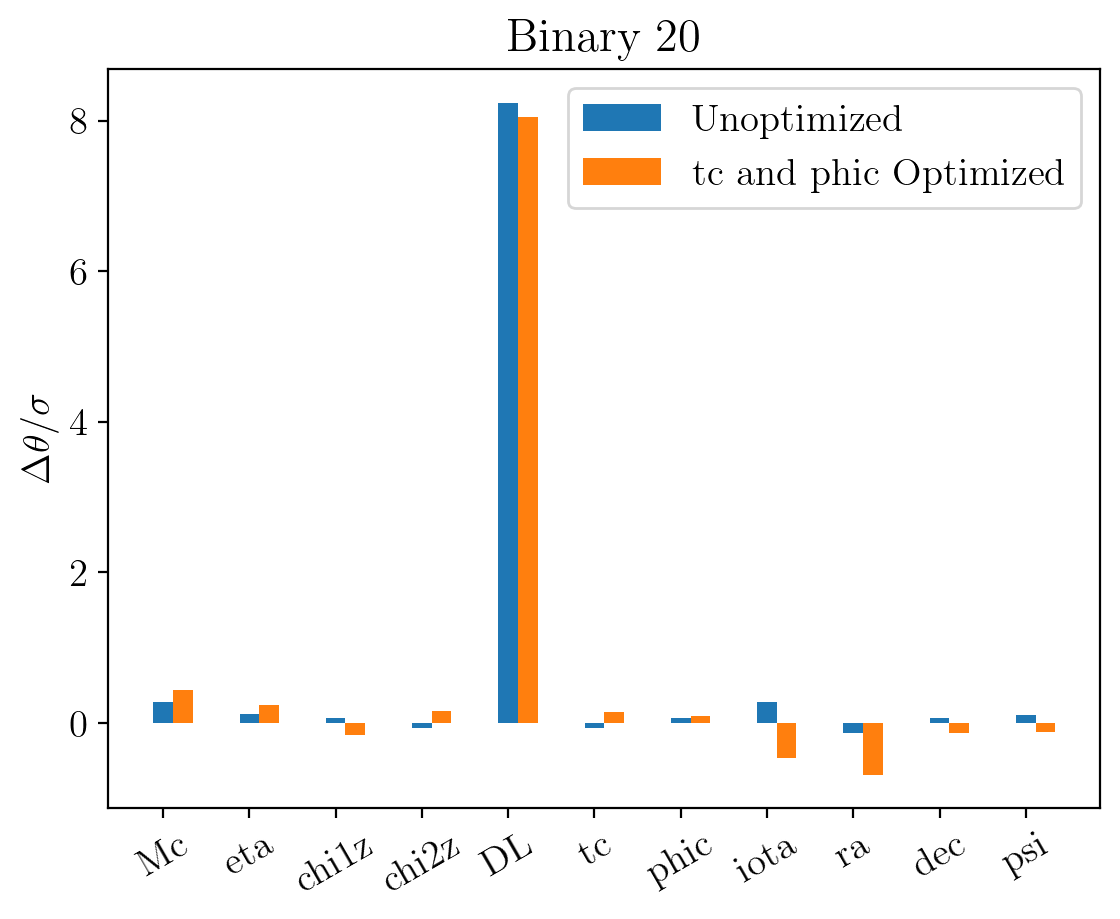

2023-10-17 10:20:27,866 - Network - INFO : Polarizations calculated.
2023-10-17 10:20:27,867 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:20:27,874 - Network - INFO : Polarizations calculated.


######  Binary 21  ######


2023-10-17 10:20:28,979 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:20:29,049 - Network - INFO : PSDs loaded.
2023-10-17 10:20:29,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:20:29,089 - Network - INFO : Detector responses calculated.
2023-10-17 10:20:29,089 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:20:29,090 - Network - INFO :    CE-40_C
2023-10-17 10:20:29,855 - Network - INFO :    CE-20_S
2023-10-17 10:20:30,628 - Network - INFO :    ET_ET1
2023-10-17 10:20:31,398 - Network - INFO :    ET_ET2
2023-10-17 10:20:32,170 - Network - INFO :    ET_ET3
2023-10-17 10:20:32,941 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:20:32,945 - Network - INFO : SNRs calculated.
2023-10-17 10:20:32,946 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:20:32,946 - Network - INFO :    CE-40_C
2023-10-17 10:20:33,016 - Network - INFO :

Mc bias diff: 0.11%
Mc, not: 10.074 sigma
Mc, opt: 10.062 sigma

eta bias diff: -2.39%
eta, not: 9.415 sigma
eta, opt: 9.640 sigma

chi1z bias diff: -1.80%
chi1z, not: -14.743 sigma
chi1z, opt: -15.008 sigma

chi2z bias diff: -1.78%
chi2z, not: 14.941 sigma
chi2z, opt: 15.206 sigma

DL bias diff: 73.11%
DL, not: 4.720 sigma
DL, opt: 1.269 sigma

tc bias diff: -1.27%
tc, not: 16.709 sigma
tc, opt: 16.922 sigma

phic bias diff: -0.20%
phic, not: 4.261 sigma
phic, opt: 4.270 sigma

iota bias diff: -1605.63%
iota, not: 0.769 sigma
iota, opt: 13.115 sigma

ra bias diff: 79.81%
ra, not: 0.508 sigma
ra, opt: 0.103 sigma

dec bias diff: -179.60%
dec, not: -0.838 sigma
dec, opt: -2.344 sigma

psi bias diff: -60.46%
psi, not: 0.075 sigma
psi, opt: 0.120 sigma

######  Binary 22  ######


2023-10-17 10:20:40,114 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:20:40,197 - Network - INFO : PSDs loaded.
2023-10-17 10:20:40,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:20:40,250 - Network - INFO : Detector responses calculated.
2023-10-17 10:20:40,251 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:20:40,253 - Network - INFO :    CE-40_C
2023-10-17 10:20:41,206 - Network - INFO :    CE-20_S
2023-10-17 10:20:42,072 - Network - INFO :    ET_ET1
2023-10-17 10:20:42,923 - Network - INFO :    ET_ET2
2023-10-17 10:20:43,768 - Network - INFO :    ET_ET3
2023-10-17 10:20:44,620 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:20:44,623 - Network - INFO : SNRs calculated.
2023-10-17 10:20:44,624 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:20:44,624 - Network - INFO :    CE-40_C
2023-10-17 10:20:44,682 - Network - INFO :

Mc bias diff: 0.05%
Mc, not: 3.741 sigma
Mc, opt: 3.739 sigma

eta bias diff: -1.14%
eta, not: 3.843 sigma
eta, opt: 3.887 sigma

chi1z bias diff: -2.07%
chi1z, not: -4.237 sigma
chi1z, opt: -4.325 sigma

chi2z bias diff: -2.08%
chi2z, not: 4.255 sigma
chi2z, opt: 4.343 sigma

DL bias diff: 3.29%
DL, not: 2.980 sigma
DL, opt: 2.882 sigma

tc bias diff: -2.03%
tc, not: 4.231 sigma
tc, opt: 4.317 sigma

phic bias diff: -2.61%
phic, not: 2.824 sigma
phic, opt: 2.898 sigma

iota bias diff: -56.38%
iota, not: 0.764 sigma
iota, opt: 1.194 sigma

ra bias diff: -8.32%
ra, not: -0.189 sigma
ra, opt: -0.205 sigma

dec bias diff: -154.22%
dec, not: -0.063 sigma
dec, opt: -0.161 sigma

psi bias diff: -2.84%
psi, not: -0.292 sigma
psi, opt: -0.301 sigma

######  Binary 23  ######


2023-10-17 10:20:53,212 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:20:53,254 - Network - INFO : PSDs loaded.
2023-10-17 10:20:53,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:20:53,293 - Network - INFO : Detector responses calculated.
2023-10-17 10:20:53,294 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:20:53,294 - Network - INFO :    CE-40_C
2023-10-17 10:20:54,675 - Network - INFO :    CE-20_S
2023-10-17 10:20:56,069 - Network - INFO :    ET_ET1
2023-10-17 10:20:57,540 - Network - INFO :    ET_ET2
2023-10-17 10:20:58,972 - Network - INFO :    ET_ET3
2023-10-17 10:21:00,395 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:21:00,399 - Network - INFO : SNRs calculated.
2023-10-17 10:21:00,399 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:21:00,400 - Network - INFO :    CE-40_C
2023-10-17 10:21:00,459 - Network - INFO :

Mc bias diff: 95.36%
Mc, not: 0.032 sigma
Mc, opt: 0.001 sigma

eta bias diff: -20.80%
eta, not: 0.134 sigma
eta, opt: 0.162 sigma

chi1z bias diff: -2.59%
chi1z, not: 0.694 sigma
chi1z, opt: 0.711 sigma

chi2z bias diff: -6.18%
chi2z, not: -0.740 sigma
chi2z, opt: -0.786 sigma

DL bias diff: 1.05%
DL, not: 9.983 sigma
DL, opt: 9.879 sigma

tc bias diff: 2.28%
tc, not: -0.560 sigma
tc, opt: -0.547 sigma

phic bias diff: -7.13%
phic, not: 0.376 sigma
phic, opt: 0.403 sigma

iota bias diff: -33.90%
iota, not: -0.587 sigma
iota, opt: -0.786 sigma

ra bias diff: 230.08%
ra, not: 0.021 sigma
ra, opt: -0.028 sigma

dec bias diff: -51.77%
dec, not: -0.142 sigma
dec, opt: -0.215 sigma

psi bias diff: -140.88%
psi, not: -0.032 sigma
psi, opt: -0.076 sigma

######  Binary 24  ######


2023-10-17 10:21:11,678 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:21:11,748 - Network - INFO : PSDs loaded.
2023-10-17 10:21:11,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:21:11,784 - Network - INFO : Detector responses calculated.
2023-10-17 10:21:11,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:21:11,785 - Network - INFO :    CE-40_C
2023-10-17 10:21:12,531 - Network - INFO :    CE-20_S
2023-10-17 10:21:13,280 - Network - INFO :    ET_ET1
2023-10-17 10:21:14,026 - Network - INFO :    ET_ET2
2023-10-17 10:21:14,775 - Network - INFO :    ET_ET3
2023-10-17 10:21:15,522 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:21:15,526 - Network - INFO : SNRs calculated.
2023-10-17 10:21:15,527 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:21:15,528 - Network - INFO :    CE-40_C
2023-10-17 10:21:15,601 - Network - INFO :

Mc bias diff: -6.61%
Mc, not: 3.024 sigma
Mc, opt: 3.223 sigma

eta bias diff: 24.38%
eta, not: 3.721 sigma
eta, opt: 2.814 sigma

chi1z bias diff: 18.41%
chi1z, not: -4.644 sigma
chi1z, opt: -3.789 sigma

chi2z bias diff: 18.03%
chi2z, not: 4.694 sigma
chi2z, opt: 3.848 sigma

DL bias diff: 25.67%
DL, not: 9.777 sigma
DL, opt: 7.267 sigma

tc bias diff: 18.30%
tc, not: 4.654 sigma
tc, opt: 3.802 sigma

phic bias diff: 18.94%
phic, not: 4.517 sigma
phic, opt: 3.661 sigma

iota bias diff: -1342.81%
iota, not: -0.428 sigma
iota, opt: -6.180 sigma

ra bias diff: -24.13%
ra, not: 0.319 sigma
ra, opt: 0.396 sigma

dec bias diff: 191.60%
dec, not: 0.349 sigma
dec, opt: -0.319 sigma

psi bias diff: -185.42%
psi, not: 0.153 sigma
psi, opt: 0.436 sigma

######  Binary 25  ######


2023-10-17 10:21:23,904 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:21:23,948 - Network - INFO : PSDs loaded.
2023-10-17 10:21:23,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:21:23,994 - Network - INFO : Detector responses calculated.
2023-10-17 10:21:23,994 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:21:23,995 - Network - INFO :    CE-40_C
2023-10-17 10:21:25,875 - Network - INFO :    CE-20_S
2023-10-17 10:21:27,650 - Network - INFO :    ET_ET1
2023-10-17 10:21:29,403 - Network - INFO :    ET_ET2
2023-10-17 10:21:31,184 - Network - INFO :    ET_ET3
2023-10-17 10:21:32,943 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:21:32,947 - Network - INFO : SNRs calculated.
2023-10-17 10:21:32,947 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:21:32,948 - Network - INFO :    CE-40_C
2023-10-17 10:21:33,011 - Network - INFO :

Mc bias diff: 6.84%
Mc, not: -1.044 sigma
Mc, opt: -0.972 sigma

eta bias diff: 21.34%
eta, not: 0.520 sigma
eta, opt: 0.409 sigma

chi1z bias diff: -18.21%
chi1z, not: 0.436 sigma
chi1z, opt: 0.515 sigma

chi2z bias diff: -21.20%
chi2z, not: -0.502 sigma
chi2z, opt: -0.608 sigma

DL bias diff: 22.66%
DL, not: 4.039 sigma
DL, opt: 3.123 sigma

tc bias diff: -28.15%
tc, not: -0.461 sigma
tc, opt: -0.590 sigma

phic bias diff: 0.93%
phic, not: 1.070 sigma
phic, opt: 1.060 sigma

iota bias diff: -2655.09%
iota, not: 0.087 sigma
iota, opt: 2.408 sigma

ra bias diff: 1754.12%
ra, not: 0.051 sigma
ra, opt: -0.842 sigma

dec bias diff: 4632.67%
dec, not: -0.002 sigma
dec, opt: 0.076 sigma

psi bias diff: -0.55%
psi, not: 0.685 sigma
psi, opt: 0.689 sigma

######  Binary 26  ######


2023-10-17 10:21:47,639 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:21:47,681 - Network - INFO : PSDs loaded.
2023-10-17 10:21:47,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:21:47,717 - Network - INFO : Detector responses calculated.
2023-10-17 10:21:47,717 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:21:47,718 - Network - INFO :    CE-40_C
2023-10-17 10:21:48,896 - Network - INFO :    CE-20_S
2023-10-17 10:21:50,116 - Network - INFO :    ET_ET1
2023-10-17 10:21:51,326 - Network - INFO :    ET_ET2
2023-10-17 10:21:52,584 - Network - INFO :    ET_ET3
2023-10-17 10:21:53,791 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:21:53,794 - Network - INFO : SNRs calculated.
2023-10-17 10:21:53,795 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:21:53,795 - Network - INFO :    CE-40_C
2023-10-17 10:21:53,858 - Network - INFO :

Mc bias diff: -0.79%
Mc, not: -4.355 sigma
Mc, opt: -4.389 sigma

eta bias diff: -1.33%
eta, not: 6.636 sigma
eta, opt: 6.724 sigma

chi1z bias diff: -1.74%
chi1z, not: -4.728 sigma
chi1z, opt: -4.810 sigma

chi2z bias diff: -1.90%
chi2z, not: 4.133 sigma
chi2z, opt: 4.212 sigma

DL bias diff: 32.14%
DL, not: 3.724 sigma
DL, opt: 2.527 sigma

tc bias diff: -1.82%
tc, not: 4.265 sigma
tc, opt: 4.343 sigma

phic bias diff: 70.23%
phic, not: 0.225 sigma
phic, opt: 0.067 sigma

iota bias diff: 716.85%
iota, not: -0.452 sigma
iota, opt: 2.791 sigma

ra bias diff: -54.25%
ra, not: -0.199 sigma
ra, opt: -0.307 sigma

dec bias diff: -102.26%
dec, not: 0.249 sigma
dec, opt: 0.503 sigma

psi bias diff: -61.63%
psi, not: -0.267 sigma
psi, opt: -0.432 sigma

######  Binary 27  ######


2023-10-17 10:22:04,424 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:22:04,472 - Network - INFO : PSDs loaded.
2023-10-17 10:22:04,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:22:04,507 - Network - INFO : Detector responses calculated.
2023-10-17 10:22:04,508 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:22:04,509 - Network - INFO :    CE-40_C
2023-10-17 10:22:05,465 - Network - INFO :    CE-20_S
2023-10-17 10:22:06,393 - Network - INFO :    ET_ET1
2023-10-17 10:22:07,322 - Network - INFO :    ET_ET2
2023-10-17 10:22:08,257 - Network - INFO :    ET_ET3
2023-10-17 10:22:09,193 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:22:09,197 - Network - INFO : SNRs calculated.
2023-10-17 10:22:09,197 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:22:09,198 - Network - INFO :    CE-40_C
2023-10-17 10:22:09,255 - Network - INFO :

Mc bias diff: 0.45%
Mc, not: 4.274 sigma
Mc, opt: 4.255 sigma

eta bias diff: 1.29%
eta, not: 3.053 sigma
eta, opt: 3.013 sigma

chi1z bias diff: 1.02%
chi1z, not: -3.895 sigma
chi1z, opt: -3.856 sigma

chi2z bias diff: 1.01%
chi2z, not: 3.948 sigma
chi2z, opt: 3.908 sigma

DL bias diff: 0.38%
DL, not: 17.719 sigma
DL, opt: 17.652 sigma

tc bias diff: 1.03%
tc, not: 3.906 sigma
tc, opt: 3.866 sigma

phic bias diff: 0.89%
phic, not: 3.612 sigma
phic, opt: 3.579 sigma

iota bias diff: -1.67%
iota, not: -0.193 sigma
iota, opt: -0.197 sigma

ra bias diff: -151.36%
ra, not: 0.033 sigma
ra, opt: 0.084 sigma

dec bias diff: 195.54%
dec, not: -0.023 sigma
dec, opt: 0.022 sigma

psi bias diff: -22.38%
psi, not: -0.259 sigma
psi, opt: -0.318 sigma

######  Binary 28  ######


2023-10-17 10:22:18,069 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:22:18,118 - Network - INFO : PSDs loaded.
2023-10-17 10:22:18,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:22:18,155 - Network - INFO : Detector responses calculated.
2023-10-17 10:22:18,155 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:22:18,156 - Network - INFO :    CE-40_C
2023-10-17 10:22:19,345 - Network - INFO :    CE-20_S
2023-10-17 10:22:20,573 - Network - INFO :    ET_ET1
2023-10-17 10:22:21,759 - Network - INFO :    ET_ET2
2023-10-17 10:22:22,976 - Network - INFO :    ET_ET3
2023-10-17 10:22:24,146 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:22:24,149 - Network - INFO : SNRs calculated.
2023-10-17 10:22:24,149 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:22:24,150 - Network - INFO :    CE-40_C
2023-10-17 10:22:24,212 - Network - INFO :

Mc bias diff: 19.86%
Mc, not: 3.998 sigma
Mc, opt: 3.204 sigma

eta bias diff: 68.98%
eta, not: 1.490 sigma
eta, opt: 0.462 sigma

chi1z bias diff: 69.58%
chi1z, not: -2.496 sigma
chi1z, opt: -0.759 sigma

chi2z bias diff: 69.15%
chi2z, not: 2.523 sigma
chi2z, opt: 0.778 sigma

DL bias diff: 5.58%
DL, not: 21.104 sigma
DL, opt: 19.926 sigma

tc bias diff: 70.75%
tc, not: 2.464 sigma
tc, opt: 0.721 sigma

phic bias diff: 74.31%
phic, not: 2.089 sigma
phic, opt: 0.537 sigma

iota bias diff: -65.02%
iota, not: 1.312 sigma
iota, opt: 2.165 sigma

ra bias diff: 187.78%
ra, not: 0.604 sigma
ra, opt: -0.530 sigma

dec bias diff: -10.85%
dec, not: -0.455 sigma
dec, opt: -0.504 sigma

psi bias diff: -238.34%
psi, not: 0.478 sigma
psi, opt: 1.617 sigma

######  Binary 29  ######


2023-10-17 10:22:34,852 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:22:34,895 - Network - INFO : PSDs loaded.
2023-10-17 10:22:34,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:22:34,932 - Network - INFO : Detector responses calculated.
2023-10-17 10:22:34,933 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:22:34,934 - Network - INFO :    CE-40_C
2023-10-17 10:22:36,286 - Network - INFO :    CE-20_S
2023-10-17 10:22:37,585 - Network - INFO :    ET_ET1
2023-10-17 10:22:38,936 - Network - INFO :    ET_ET2
2023-10-17 10:22:40,269 - Network - INFO :    ET_ET3
2023-10-17 10:22:41,547 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:22:41,551 - Network - INFO : SNRs calculated.
2023-10-17 10:22:41,551 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:22:41,551 - Network - INFO :    CE-40_C
2023-10-17 10:22:41,608 - Network - INFO :

Mc bias diff: 11.85%
Mc, not: 0.368 sigma
Mc, opt: 0.325 sigma

eta bias diff: 3.66%
eta, not: 1.590 sigma
eta, opt: 1.532 sigma

chi1z bias diff: 5.02%
chi1z, not: -1.640 sigma
chi1z, opt: -1.557 sigma

chi2z bias diff: 5.92%
chi2z, not: 1.631 sigma
chi2z, opt: 1.535 sigma

DL bias diff: 0.35%
DL, not: 20.940 sigma
DL, opt: 20.868 sigma

tc bias diff: 5.67%
tc, not: 1.662 sigma
tc, opt: 1.568 sigma

phic bias diff: 2.28%
phic, not: 2.380 sigma
phic, opt: 2.326 sigma

iota bias diff: -12.82%
iota, not: -0.722 sigma
iota, opt: -0.815 sigma

ra bias diff: -67.84%
ra, not: 0.079 sigma
ra, opt: 0.132 sigma

dec bias diff: -14.24%
dec, not: 0.275 sigma
dec, opt: 0.314 sigma

psi bias diff: 121.66%
psi, not: 0.016 sigma
psi, opt: -0.003 sigma

######  Binary 30  ######


2023-10-17 10:22:52,341 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:22:52,404 - Network - INFO : PSDs loaded.
2023-10-17 10:22:52,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:22:52,442 - Network - INFO : Detector responses calculated.
2023-10-17 10:22:52,443 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:22:52,443 - Network - INFO :    CE-40_C
2023-10-17 10:22:53,359 - Network - INFO :    CE-20_S
2023-10-17 10:22:54,217 - Network - INFO :    ET_ET1
2023-10-17 10:22:55,078 - Network - INFO :    ET_ET2
2023-10-17 10:22:55,936 - Network - INFO :    ET_ET3
2023-10-17 10:22:56,793 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:22:56,796 - Network - INFO : SNRs calculated.
2023-10-17 10:22:56,796 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:22:56,796 - Network - INFO :    CE-40_C
2023-10-17 10:22:56,854 - Network - INFO :

Mc bias diff: 1.57%
Mc, not: -3.967 sigma
Mc, opt: -3.904 sigma

eta bias diff: 1.72%
eta, not: 16.298 sigma
eta, opt: 16.017 sigma

chi1z bias diff: 6.00%
chi1z, not: -20.978 sigma
chi1z, opt: -19.719 sigma

chi2z bias diff: 5.83%
chi2z, not: 18.197 sigma
chi2z, opt: 17.136 sigma

DL bias diff: 160.02%
DL, not: 1.143 sigma
DL, opt: -0.686 sigma

tc bias diff: 5.80%
tc, not: 17.871 sigma
tc, opt: 16.834 sigma

phic bias diff: -0.56%
phic, not: 1.924 sigma
phic, opt: 1.935 sigma

iota bias diff: -285.26%
iota, not: 2.429 sigma
iota, opt: 9.357 sigma

ra bias diff: 19.25%
ra, not: 1.833 sigma
ra, opt: 1.480 sigma

dec bias diff: -155.98%
dec, not: 0.201 sigma
dec, opt: 0.515 sigma

psi bias diff: -0.44%
psi, not: 1.448 sigma
psi, opt: 1.455 sigma



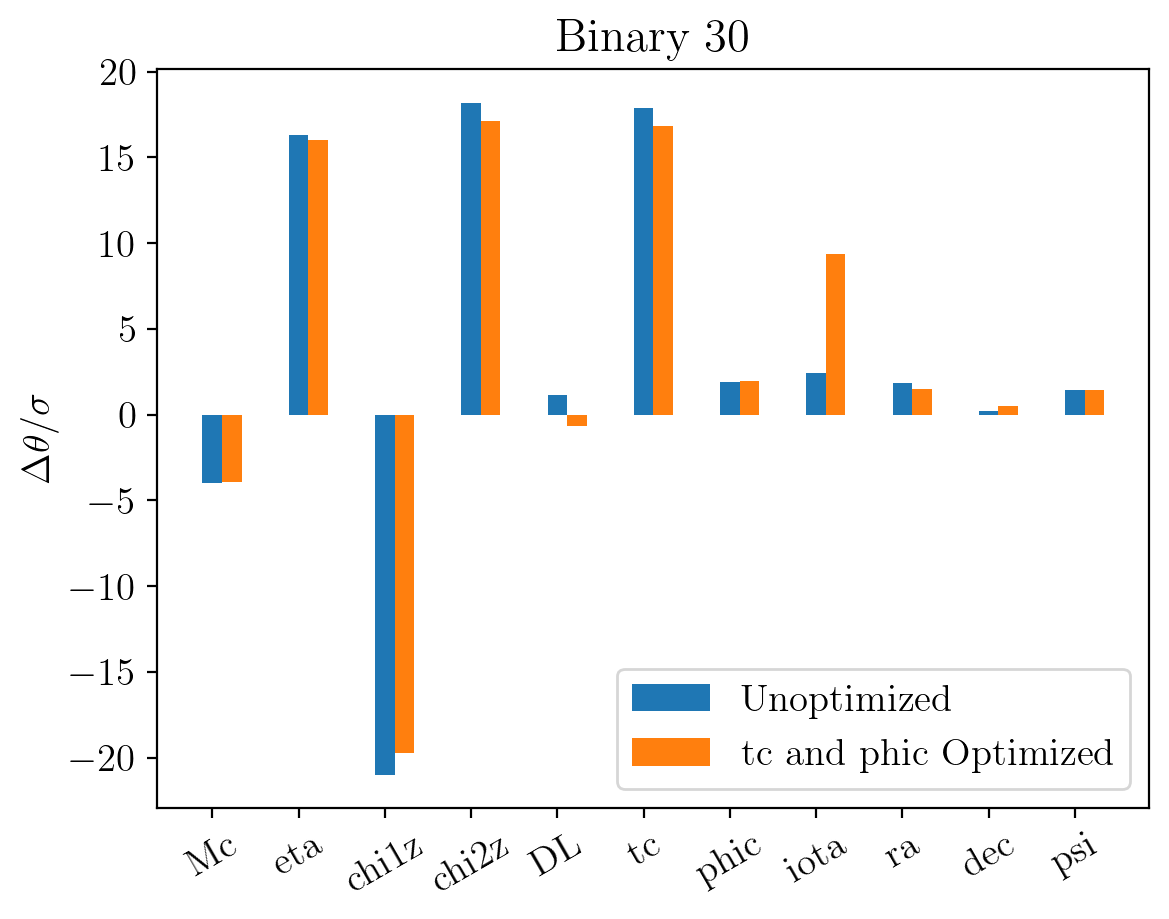

2023-10-17 10:23:03,692 - Network - INFO : Polarizations calculated.
2023-10-17 10:23:03,692 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:23:03,699 - Network - INFO : Polarizations calculated.


######  Binary 31  ######


2023-10-17 10:23:04,825 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:23:04,895 - Network - INFO : PSDs loaded.
2023-10-17 10:23:04,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:23:04,931 - Network - INFO : Detector responses calculated.
2023-10-17 10:23:04,931 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:23:04,932 - Network - INFO :    CE-40_C
2023-10-17 10:23:05,737 - Network - INFO :    CE-20_S
2023-10-17 10:23:06,552 - Network - INFO :    ET_ET1
2023-10-17 10:23:07,358 - Network - INFO :    ET_ET2
2023-10-17 10:23:08,162 - Network - INFO :    ET_ET3
2023-10-17 10:23:08,968 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:23:08,972 - Network - INFO : SNRs calculated.
2023-10-17 10:23:08,973 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:23:08,973 - Network - INFO :    CE-40_C
2023-10-17 10:23:09,039 - Network - INFO :

Mc bias diff: -1.44%
Mc, not: 5.498 sigma
Mc, opt: 5.577 sigma

eta bias diff: -0.88%
eta, not: 7.946 sigma
eta, opt: 8.016 sigma

chi1z bias diff: -0.44%
chi1z, not: -11.724 sigma
chi1z, opt: -11.775 sigma

chi2z bias diff: -0.41%
chi2z, not: 12.219 sigma
chi2z, opt: 12.269 sigma

DL bias diff: 5.72%
DL, not: 5.367 sigma
DL, opt: 5.060 sigma

tc bias diff: -0.34%
tc, not: 12.325 sigma
tc, opt: 12.367 sigma

phic bias diff: -1.77%
phic, not: 7.552 sigma
phic, opt: 7.686 sigma

iota bias diff: -135.64%
iota, not: -0.552 sigma
iota, opt: -1.301 sigma

ra bias diff: -171.15%
ra, not: 0.170 sigma
ra, opt: 0.461 sigma

dec bias diff: -681.88%
dec, not: 0.051 sigma
dec, opt: 0.401 sigma

psi bias diff: -8.74%
psi, not: -1.632 sigma
psi, opt: -1.774 sigma

######  Binary 32  ######


2023-10-17 10:23:15,630 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:23:15,699 - Network - INFO : PSDs loaded.
2023-10-17 10:23:15,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:23:15,737 - Network - INFO : Detector responses calculated.
2023-10-17 10:23:15,738 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:23:15,739 - Network - INFO :    CE-40_C
2023-10-17 10:23:16,276 - Network - INFO :    CE-20_S
2023-10-17 10:23:16,804 - Network - INFO :    ET_ET1
2023-10-17 10:23:17,331 - Network - INFO :    ET_ET2
2023-10-17 10:23:17,859 - Network - INFO :    ET_ET3
2023-10-17 10:23:18,385 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:23:18,389 - Network - INFO : SNRs calculated.
2023-10-17 10:23:18,390 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:23:18,391 - Network - INFO :    CE-40_C
2023-10-17 10:23:18,470 - Network - INFO :

Mc bias diff: -4.06%
Mc, not: -3.089 sigma
Mc, opt: -3.215 sigma

eta bias diff: 2.02%
eta, not: 6.690 sigma
eta, opt: 6.555 sigma

chi1z bias diff: 1.40%
chi1z, not: -6.921 sigma
chi1z, opt: -6.824 sigma

chi2z bias diff: 1.43%
chi2z, not: 6.986 sigma
chi2z, opt: 6.886 sigma

DL bias diff: 9.32%
DL, not: 8.023 sigma
DL, opt: 7.274 sigma

tc bias diff: 1.57%
tc, not: 6.909 sigma
tc, opt: 6.800 sigma

phic bias diff: 1.22%
phic, not: 6.727 sigma
phic, opt: 6.645 sigma

iota bias diff: -1704.87%
iota, not: 0.108 sigma
iota, opt: 1.949 sigma

ra bias diff: 945.97%
ra, not: -0.274 sigma
ra, opt: 2.314 sigma

dec bias diff: 419.60%
dec, not: 0.608 sigma
dec, opt: -1.944 sigma

psi bias diff: -145.11%
psi, not: -0.533 sigma
psi, opt: -1.306 sigma

######  Binary 33  ######


2023-10-17 10:23:24,767 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:23:24,809 - Network - INFO : PSDs loaded.
2023-10-17 10:23:24,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:23:24,848 - Network - INFO : Detector responses calculated.
2023-10-17 10:23:24,849 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:23:24,849 - Network - INFO :    CE-40_C
2023-10-17 10:23:26,258 - Network - INFO :    CE-20_S
2023-10-17 10:23:27,647 - Network - INFO :    ET_ET1
2023-10-17 10:23:28,994 - Network - INFO :    ET_ET2
2023-10-17 10:23:30,355 - Network - INFO :    ET_ET3
2023-10-17 10:23:31,793 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:23:31,797 - Network - INFO : SNRs calculated.
2023-10-17 10:23:31,797 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:23:31,797 - Network - INFO :    CE-40_C
2023-10-17 10:23:31,855 - Network - INFO :

Mc bias diff: 2.51%
Mc, not: -0.588 sigma
Mc, opt: -0.573 sigma

eta bias diff: 2.88%
eta, not: 0.891 sigma
eta, opt: 0.865 sigma

chi1z bias diff: 4.00%
chi1z, not: -0.599 sigma
chi1z, opt: -0.575 sigma

chi2z bias diff: 4.01%
chi2z, not: 0.573 sigma
chi2z, opt: 0.550 sigma

DL bias diff: 0.22%
DL, not: 13.410 sigma
DL, opt: 13.380 sigma

tc bias diff: 4.07%
tc, not: 0.595 sigma
tc, opt: 0.570 sigma

phic bias diff: 1.24%
phic, not: 0.863 sigma
phic, opt: 0.852 sigma

iota bias diff: 11.73%
iota, not: 0.130 sigma
iota, opt: 0.115 sigma

ra bias diff: -1.15%
ra, not: 0.091 sigma
ra, opt: 0.092 sigma

dec bias diff: 19.25%
dec, not: 0.053 sigma
dec, opt: 0.043 sigma

psi bias diff: -6.55%
psi, not: 0.325 sigma
psi, opt: 0.346 sigma

######  Binary 34  ######


2023-10-17 10:23:43,695 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:23:43,738 - Network - INFO : PSDs loaded.
2023-10-17 10:23:43,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:23:43,772 - Network - INFO : Detector responses calculated.
2023-10-17 10:23:43,773 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:23:43,774 - Network - INFO :    CE-40_C
2023-10-17 10:23:44,867 - Network - INFO :    CE-20_S
2023-10-17 10:23:46,006 - Network - INFO :    ET_ET1
2023-10-17 10:23:47,246 - Network - INFO :    ET_ET2
2023-10-17 10:23:48,354 - Network - INFO :    ET_ET3
2023-10-17 10:23:49,492 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:23:49,495 - Network - INFO : SNRs calculated.
2023-10-17 10:23:49,496 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:23:49,496 - Network - INFO :    CE-40_C
2023-10-17 10:23:49,559 - Network - INFO :

Mc bias diff: 0.07%
Mc, not: 2.888 sigma
Mc, opt: 2.886 sigma

eta bias diff: 2.15%
eta, not: 1.674 sigma
eta, opt: 1.638 sigma

chi1z bias diff: 1.81%
chi1z, not: -2.355 sigma
chi1z, opt: -2.312 sigma

chi2z bias diff: 1.98%
chi2z, not: 2.372 sigma
chi2z, opt: 2.325 sigma

DL bias diff: 10.59%
DL, not: 3.350 sigma
DL, opt: 2.995 sigma

tc bias diff: 1.74%
tc, not: 2.332 sigma
tc, opt: 2.292 sigma

phic bias diff: 58.65%
phic, not: 0.374 sigma
phic, opt: 0.155 sigma

iota bias diff: -4028.92%
iota, not: -0.018 sigma
iota, opt: -0.729 sigma

ra bias diff: -79.14%
ra, not: 0.432 sigma
ra, opt: 0.774 sigma

dec bias diff: -103.38%
dec, not: -0.318 sigma
dec, opt: -0.647 sigma

psi bias diff: -720.31%
psi, not: 0.030 sigma
psi, opt: 0.248 sigma

######  Binary 35  ######


2023-10-17 10:23:59,120 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:23:59,187 - Network - INFO : PSDs loaded.
2023-10-17 10:23:59,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:23:59,225 - Network - INFO : Detector responses calculated.
2023-10-17 10:23:59,226 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:23:59,227 - Network - INFO :    CE-40_C
2023-10-17 10:24:00,147 - Network - INFO :    CE-20_S
2023-10-17 10:24:01,008 - Network - INFO :    ET_ET1
2023-10-17 10:24:01,860 - Network - INFO :    ET_ET2
2023-10-17 10:24:02,721 - Network - INFO :    ET_ET3
2023-10-17 10:24:03,574 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:24:03,577 - Network - INFO : SNRs calculated.
2023-10-17 10:24:03,578 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:24:03,578 - Network - INFO :    CE-40_C
2023-10-17 10:24:03,635 - Network - INFO :

Mc bias diff: -0.18%
Mc, not: 6.687 sigma
Mc, opt: 6.700 sigma

eta bias diff: 0.51%
eta, not: 5.840 sigma
eta, opt: 5.810 sigma

chi1z bias diff: 0.39%
chi1z, not: -7.441 sigma
chi1z, opt: -7.411 sigma

chi2z bias diff: 0.41%
chi2z, not: 7.475 sigma
chi2z, opt: 7.444 sigma

DL bias diff: -0.41%
DL, not: 6.955 sigma
DL, opt: 6.983 sigma

tc bias diff: 0.38%
tc, not: 7.902 sigma
tc, opt: 7.872 sigma

phic bias diff: 0.39%
phic, not: 6.165 sigma
phic, opt: 6.141 sigma

iota bias diff: 11.59%
iota, not: 1.371 sigma
iota, opt: 1.212 sigma

ra bias diff: 7.96%
ra, not: 0.401 sigma
ra, opt: 0.369 sigma

dec bias diff: 5.33%
dec, not: -0.104 sigma
dec, opt: -0.098 sigma

psi bias diff: -23.81%
psi, not: 0.069 sigma
psi, opt: 0.085 sigma

######  Binary 36  ######


2023-10-17 10:24:13,582 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:24:13,624 - Network - INFO : PSDs loaded.
2023-10-17 10:24:13,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:24:13,672 - Network - INFO : Detector responses calculated.
2023-10-17 10:24:13,672 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:24:13,673 - Network - INFO :    CE-40_C
2023-10-17 10:24:15,550 - Network - INFO :    CE-20_S
2023-10-17 10:24:17,349 - Network - INFO :    ET_ET1
2023-10-17 10:24:19,139 - Network - INFO :    ET_ET2
2023-10-17 10:24:20,914 - Network - INFO :    ET_ET3
2023-10-17 10:24:22,577 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:24:22,580 - Network - INFO : SNRs calculated.
2023-10-17 10:24:22,581 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:24:22,581 - Network - INFO :    CE-40_C
2023-10-17 10:24:22,644 - Network - INFO :

Mc bias diff: 0.08%
Mc, not: -7.578 sigma
Mc, opt: -7.572 sigma

eta bias diff: 0.15%
eta, not: 6.843 sigma
eta, opt: 6.832 sigma

chi1z bias diff: 0.70%
chi1z, not: -4.446 sigma
chi1z, opt: -4.415 sigma

chi2z bias diff: 0.96%
chi2z, not: 4.342 sigma
chi2z, opt: 4.300 sigma

DL bias diff: 19.63%
DL, not: 2.512 sigma
DL, opt: 2.019 sigma

tc bias diff: 0.53%
tc, not: 4.922 sigma
tc, opt: 4.896 sigma

phic bias diff: -58.79%
phic, not: 0.127 sigma
phic, opt: 0.202 sigma

iota bias diff: -133.62%
iota, not: 0.948 sigma
iota, opt: 2.214 sigma

ra bias diff: -744.12%
ra, not: -0.054 sigma
ra, opt: -0.455 sigma

dec bias diff: 56.12%
dec, not: 0.117 sigma
dec, opt: 0.051 sigma

psi bias diff: 12.62%
psi, not: -0.578 sigma
psi, opt: -0.505 sigma

######  Binary 37  ######


2023-10-17 10:24:37,300 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:24:37,342 - Network - INFO : PSDs loaded.
2023-10-17 10:24:37,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:24:37,386 - Network - INFO : Detector responses calculated.
2023-10-17 10:24:37,387 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:24:37,387 - Network - INFO :    CE-40_C
2023-10-17 10:24:39,112 - Network - INFO :    CE-20_S
2023-10-17 10:24:40,732 - Network - INFO :    ET_ET1
2023-10-17 10:24:42,345 - Network - INFO :    ET_ET2
2023-10-17 10:24:43,949 - Network - INFO :    ET_ET3
2023-10-17 10:24:45,579 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:24:45,583 - Network - INFO : SNRs calculated.
2023-10-17 10:24:45,583 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:24:45,583 - Network - INFO :    CE-40_C
2023-10-17 10:24:45,645 - Network - INFO :

Mc bias diff: 0.25%
Mc, not: -1.110 sigma
Mc, opt: -1.107 sigma

eta bias diff: 1.08%
eta, not: 1.233 sigma
eta, opt: 1.220 sigma

chi1z bias diff: 1.13%
chi1z, not: -1.001 sigma
chi1z, opt: -0.990 sigma

chi2z bias diff: -1.06%
chi2z, not: 0.924 sigma
chi2z, opt: 0.934 sigma

DL bias diff: 0.52%
DL, not: 10.836 sigma
DL, opt: 10.779 sigma

tc bias diff: 1.34%
tc, not: 0.920 sigma
tc, opt: 0.908 sigma

phic bias diff: -0.23%
phic, not: 1.792 sigma
phic, opt: 1.796 sigma

iota bias diff: -24.69%
iota, not: -0.449 sigma
iota, opt: -0.560 sigma

ra bias diff: 26.82%
ra, not: 0.088 sigma
ra, opt: 0.064 sigma

dec bias diff: -39.49%
dec, not: 0.090 sigma
dec, opt: 0.125 sigma

psi bias diff: 19.47%
psi, not: 0.026 sigma
psi, opt: 0.021 sigma

######  Binary 38  ######


2023-10-17 10:24:58,864 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:24:58,933 - Network - INFO : PSDs loaded.
2023-10-17 10:24:58,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:24:58,972 - Network - INFO : Detector responses calculated.
2023-10-17 10:24:58,972 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:24:58,973 - Network - INFO :    CE-40_C
2023-10-17 10:24:59,984 - Network - INFO :    CE-20_S
2023-10-17 10:25:00,988 - Network - INFO :    ET_ET1
2023-10-17 10:25:01,931 - Network - INFO :    ET_ET2
2023-10-17 10:25:02,877 - Network - INFO :    ET_ET3
2023-10-17 10:25:03,824 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:25:03,827 - Network - INFO : SNRs calculated.
2023-10-17 10:25:03,828 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:25:03,828 - Network - INFO :    CE-40_C
2023-10-17 10:25:03,883 - Network - INFO :

Mc bias diff: 20.94%
Mc, not: 8.576 sigma
Mc, opt: 6.780 sigma

eta bias diff: 18.51%
eta, not: 4.528 sigma
eta, opt: 3.689 sigma

chi1z bias diff: 15.97%
chi1z, not: -6.555 sigma
chi1z, opt: -5.508 sigma

chi2z bias diff: 15.85%
chi2z, not: 6.692 sigma
chi2z, opt: 5.631 sigma

DL bias diff: 38.33%
DL, not: 4.497 sigma
DL, opt: 2.774 sigma

tc bias diff: 15.65%
tc, not: 6.657 sigma
tc, opt: 5.615 sigma

phic bias diff: 10.43%
phic, not: 1.547 sigma
phic, opt: 1.385 sigma

iota bias diff: 21101.53%
iota, not: -0.079 sigma
iota, opt: 16.694 sigma

ra bias diff: -160.72%
ra, not: -0.485 sigma
ra, opt: -1.264 sigma

dec bias diff: -170.20%
dec, not: 0.168 sigma
dec, opt: 0.454 sigma

psi bias diff: 21.55%
psi, not: 0.256 sigma
psi, opt: 0.201 sigma

######  Binary 39  ######


2023-10-17 10:25:12,634 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:25:12,682 - Network - INFO : PSDs loaded.
2023-10-17 10:25:12,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:25:12,716 - Network - INFO : Detector responses calculated.
2023-10-17 10:25:12,717 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:25:12,718 - Network - INFO :    CE-40_C
2023-10-17 10:25:13,751 - Network - INFO :    CE-20_S
2023-10-17 10:25:14,832 - Network - INFO :    ET_ET1
2023-10-17 10:25:15,875 - Network - INFO :    ET_ET2
2023-10-17 10:25:16,944 - Network - INFO :    ET_ET3
2023-10-17 10:25:18,022 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:25:18,029 - Network - INFO : SNRs calculated.
2023-10-17 10:25:18,032 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:25:18,033 - Network - INFO :    CE-40_C
2023-10-17 10:25:18,125 - Network - INFO :

Mc bias diff: 0.78%
Mc, not: 3.570 sigma
Mc, opt: 3.542 sigma

eta bias diff: -9.50%
eta, not: 3.247 sigma
eta, opt: 3.556 sigma

chi1z bias diff: -11.80%
chi1z, not: -3.031 sigma
chi1z, opt: -3.388 sigma

chi2z bias diff: -11.77%
chi2z, not: 3.057 sigma
chi2z, opt: 3.417 sigma

DL bias diff: 128.60%
DL, not: 0.116 sigma
DL, opt: -0.033 sigma

tc bias diff: -11.09%
tc, not: 3.212 sigma
tc, opt: 3.569 sigma

phic bias diff: 613.91%
phic, not: -0.444 sigma
phic, opt: 2.282 sigma

iota bias diff: -3.42%
iota, not: -3.000 sigma
iota, opt: -3.103 sigma

ra bias diff: -101.78%
ra, not: 0.247 sigma
ra, opt: 0.498 sigma

dec bias diff: -331.64%
dec, not: 0.032 sigma
dec, opt: 0.137 sigma

psi bias diff: 623.51%
psi, not: 0.434 sigma
psi, opt: -2.272 sigma

######  Binary 40  ######


2023-10-17 10:25:26,726 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:25:26,796 - Network - INFO : PSDs loaded.
2023-10-17 10:25:26,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:25:26,838 - Network - INFO : Detector responses calculated.
2023-10-17 10:25:26,839 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:25:26,839 - Network - INFO :    CE-40_C
2023-10-17 10:25:27,574 - Network - INFO :    CE-20_S
2023-10-17 10:25:28,302 - Network - INFO :    ET_ET1
2023-10-17 10:25:29,029 - Network - INFO :    ET_ET2
2023-10-17 10:25:29,759 - Network - INFO :    ET_ET3
2023-10-17 10:25:30,489 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:25:30,493 - Network - INFO : SNRs calculated.
2023-10-17 10:25:30,493 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:25:30,494 - Network - INFO :    CE-40_C
2023-10-17 10:25:30,568 - Network - INFO :

Mc bias diff: 70.93%
Mc, not: 0.080 sigma
Mc, opt: 0.023 sigma

eta bias diff: 2.95%
eta, not: 4.124 sigma
eta, opt: 4.002 sigma

chi1z bias diff: 11.32%
chi1z, not: -2.345 sigma
chi1z, opt: -2.080 sigma

chi2z bias diff: 10.38%
chi2z, not: 2.525 sigma
chi2z, opt: 2.263 sigma

DL bias diff: 11.77%
DL, not: 6.721 sigma
DL, opt: 5.929 sigma

tc bias diff: 7.42%
tc, not: 3.127 sigma
tc, opt: 2.895 sigma

phic bias diff: 1.73%
phic, not: 2.865 sigma
phic, opt: 2.816 sigma

iota bias diff: -555.30%
iota, not: -0.231 sigma
iota, opt: -1.515 sigma

ra bias diff: 6464.28%
ra, not: -0.008 sigma
ra, opt: 0.532 sigma

dec bias diff: 2563.74%
dec, not: 0.034 sigma
dec, opt: -0.848 sigma

psi bias diff: -229.22%
psi, not: -0.233 sigma
psi, opt: -0.767 sigma



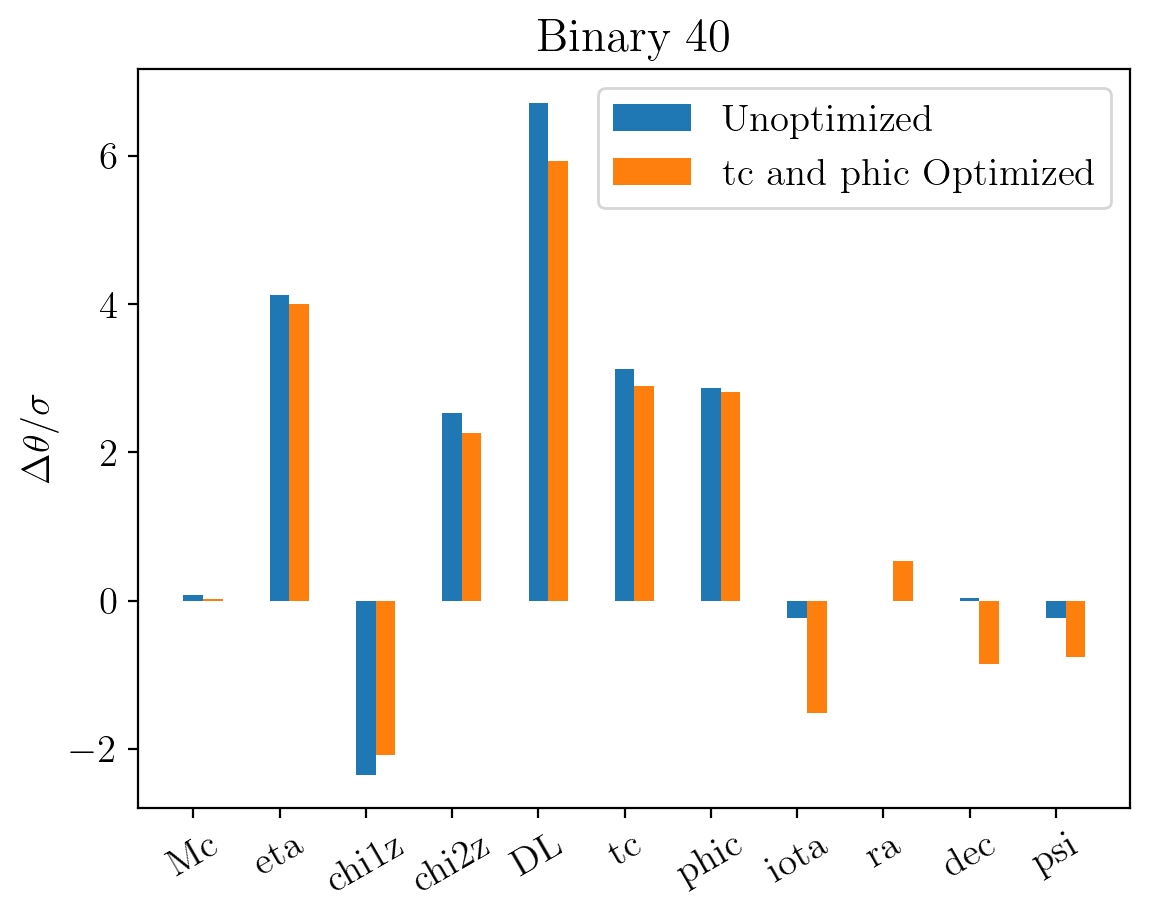

2023-10-17 10:25:36,236 - Network - INFO : Polarizations calculated.
2023-10-17 10:25:36,237 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:25:36,246 - Network - INFO : Polarizations calculated.


######  Binary 41  ######


2023-10-17 10:25:38,485 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:25:38,604 - Network - INFO : PSDs loaded.
2023-10-17 10:25:38,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:25:38,643 - Network - INFO : Detector responses calculated.
2023-10-17 10:25:38,644 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:25:38,645 - Network - INFO :    CE-40_C
2023-10-17 10:25:40,093 - Network - INFO :    CE-20_S
2023-10-17 10:25:41,519 - Network - INFO :    ET_ET1
2023-10-17 10:25:42,914 - Network - INFO :    ET_ET2
2023-10-17 10:25:44,410 - Network - INFO :    ET_ET3
2023-10-17 10:25:45,781 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:25:45,784 - Network - INFO : SNRs calculated.
2023-10-17 10:25:45,785 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:25:45,785 - Network - INFO :    CE-40_C
2023-10-17 10:25:45,844 - Network - INFO :

Mc bias diff: 7.17%
Mc, not: -0.202 sigma
Mc, opt: -0.188 sigma

eta bias diff: 0.25%
eta, not: 1.047 sigma
eta, opt: 1.044 sigma

chi1z bias diff: 1.55%
chi1z, not: -1.037 sigma
chi1z, opt: -1.020 sigma

chi2z bias diff: -0.06%
chi2z, not: 1.020 sigma
chi2z, opt: 1.021 sigma

DL bias diff: 3.83%
DL, not: 6.448 sigma
DL, opt: 6.202 sigma

tc bias diff: 1.04%
tc, not: 0.957 sigma
tc, opt: 0.947 sigma

phic bias diff: 2.30%
phic, not: 0.395 sigma
phic, opt: 0.386 sigma

iota bias diff: -2040.69%
iota, not: -0.018 sigma
iota, opt: -0.392 sigma

ra bias diff: 2640.13%
ra, not: 0.008 sigma
ra, opt: -0.195 sigma

dec bias diff: -2784.92%
dec, not: 0.007 sigma
dec, opt: 0.216 sigma

psi bias diff: 2.33%
psi, not: 0.685 sigma
psi, opt: 0.669 sigma

######  Binary 42  ######


2023-10-17 10:25:58,145 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:25:58,188 - Network - INFO : PSDs loaded.
2023-10-17 10:25:58,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:25:58,221 - Network - INFO : Detector responses calculated.
2023-10-17 10:25:58,222 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:25:58,223 - Network - INFO :    CE-40_C
2023-10-17 10:25:59,342 - Network - INFO :    CE-20_S
2023-10-17 10:26:00,546 - Network - INFO :    ET_ET1
2023-10-17 10:26:01,741 - Network - INFO :    ET_ET2
2023-10-17 10:26:02,935 - Network - INFO :    ET_ET3
2023-10-17 10:26:04,170 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:26:04,173 - Network - INFO : SNRs calculated.
2023-10-17 10:26:04,174 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:26:04,174 - Network - INFO :    CE-40_C
2023-10-17 10:26:04,238 - Network - INFO :

Mc bias diff: -9.04%
Mc, not: 0.521 sigma
Mc, opt: 0.568 sigma

eta bias diff: -1.18%
eta, not: 2.347 sigma
eta, opt: 2.374 sigma

chi1z bias diff: -4.01%
chi1z, not: -2.114 sigma
chi1z, opt: -2.199 sigma

chi2z bias diff: -4.49%
chi2z, not: 2.039 sigma
chi2z, opt: 2.130 sigma

DL bias diff: 55.47%
DL, not: 2.125 sigma
DL, opt: 0.946 sigma

tc bias diff: -4.38%
tc, not: 2.040 sigma
tc, opt: 2.129 sigma

phic bias diff: -25.61%
phic, not: 0.893 sigma
phic, opt: 1.122 sigma

iota bias diff: -410.51%
iota, not: 0.700 sigma
iota, opt: 3.572 sigma

ra bias diff: 6711.93%
ra, not: 0.010 sigma
ra, opt: -0.689 sigma

dec bias diff: -78.11%
dec, not: 0.251 sigma
dec, opt: 0.447 sigma

psi bias diff: -42.10%
psi, not: 0.499 sigma
psi, opt: 0.710 sigma

######  Binary 43  ######


2023-10-17 10:26:15,036 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:26:15,079 - Network - INFO : PSDs loaded.
2023-10-17 10:26:15,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:26:15,118 - Network - INFO : Detector responses calculated.
2023-10-17 10:26:15,118 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:26:15,119 - Network - INFO :    CE-40_C
2023-10-17 10:26:16,559 - Network - INFO :    CE-20_S
2023-10-17 10:26:17,956 - Network - INFO :    ET_ET1
2023-10-17 10:26:19,347 - Network - INFO :    ET_ET2
2023-10-17 10:26:20,817 - Network - INFO :    ET_ET3
2023-10-17 10:26:22,236 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:26:22,239 - Network - INFO : SNRs calculated.
2023-10-17 10:26:22,240 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:26:22,240 - Network - INFO :    CE-40_C
2023-10-17 10:26:22,299 - Network - INFO :

Mc bias diff: -0.42%
Mc, not: -1.368 sigma
Mc, opt: -1.374 sigma

eta bias diff: 0.13%
eta, not: 1.619 sigma
eta, opt: 1.617 sigma

chi1z bias diff: 2.10%
chi1z, not: -0.969 sigma
chi1z, opt: -0.949 sigma

chi2z bias diff: 2.23%
chi2z, not: 0.875 sigma
chi2z, opt: 0.856 sigma

DL bias diff: 117.70%
DL, not: 1.960 sigma
DL, opt: -0.347 sigma

tc bias diff: 2.84%
tc, not: 0.916 sigma
tc, opt: 0.890 sigma

phic bias diff: -53.92%
phic, not: 0.133 sigma
phic, opt: 0.204 sigma

iota bias diff: -6698.94%
iota, not: 0.100 sigma
iota, opt: 6.819 sigma

ra bias diff: -385.53%
ra, not: 0.100 sigma
ra, opt: 0.483 sigma

dec bias diff: -180.59%
dec, not: 0.207 sigma
dec, opt: 0.581 sigma

psi bias diff: -237.24%
psi, not: 0.031 sigma
psi, opt: 0.105 sigma

######  Binary 44  ######


2023-10-17 10:26:35,322 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:26:35,366 - Network - INFO : PSDs loaded.
2023-10-17 10:26:35,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:26:35,414 - Network - INFO : Detector responses calculated.
2023-10-17 10:26:35,414 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:26:35,415 - Network - INFO :    CE-40_C
2023-10-17 10:26:37,357 - Network - INFO :    CE-20_S
2023-10-17 10:26:39,158 - Network - INFO :    ET_ET1
2023-10-17 10:26:40,937 - Network - INFO :    ET_ET2
2023-10-17 10:26:42,696 - Network - INFO :    ET_ET3
2023-10-17 10:26:44,457 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:26:44,461 - Network - INFO : SNRs calculated.
2023-10-17 10:26:44,462 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:26:44,462 - Network - INFO :    CE-40_C
2023-10-17 10:26:44,525 - Network - INFO :

Mc bias diff: 3.44%
Mc, not: -0.799 sigma
Mc, opt: -0.772 sigma

eta bias diff: 4.88%
eta, not: 0.650 sigma
eta, opt: 0.618 sigma

chi1z bias diff: 10.61%
chi1z, not: -0.314 sigma
chi1z, opt: -0.281 sigma

chi2z bias diff: 13.62%
chi2z, not: 0.271 sigma
chi2z, opt: 0.234 sigma

DL bias diff: 0.29%
DL, not: 17.464 sigma
DL, opt: 17.414 sigma

tc bias diff: 13.08%
tc, not: 0.274 sigma
tc, opt: 0.238 sigma

phic bias diff: 2.40%
phic, not: 1.141 sigma
phic, opt: 1.114 sigma

iota bias diff: -80.09%
iota, not: -0.074 sigma
iota, opt: -0.133 sigma

ra bias diff: -23.57%
ra, not: -0.080 sigma
ra, opt: -0.098 sigma

dec bias diff: -25.10%
dec, not: -0.050 sigma
dec, opt: -0.063 sigma

psi bias diff: -13.26%
psi, not: 0.288 sigma
psi, opt: 0.326 sigma

######  Binary 45  ######


2023-10-17 10:26:59,652 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:26:59,694 - Network - INFO : PSDs loaded.
2023-10-17 10:26:59,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:26:59,739 - Network - INFO : Detector responses calculated.
2023-10-17 10:26:59,740 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:26:59,740 - Network - INFO :    CE-40_C
2023-10-17 10:27:01,484 - Network - INFO :    CE-20_S
2023-10-17 10:27:03,148 - Network - INFO :    ET_ET1
2023-10-17 10:27:04,794 - Network - INFO :    ET_ET2
2023-10-17 10:27:06,476 - Network - INFO :    ET_ET3
2023-10-17 10:27:08,115 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:27:08,119 - Network - INFO : SNRs calculated.
2023-10-17 10:27:08,119 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:27:08,120 - Network - INFO :    CE-40_C
2023-10-17 10:27:08,182 - Network - INFO :

Mc bias diff: 685.98%
Mc, not: 0.169 sigma
Mc, opt: -0.987 sigma

eta bias diff: 120.37%
eta, not: -1.061 sigma
eta, opt: 0.216 sigma

chi1z bias diff: 27.41%
chi1z, not: 4.284 sigma
chi1z, opt: 3.110 sigma

chi2z bias diff: 27.15%
chi2z, not: -4.178 sigma
chi2z, opt: -3.043 sigma

DL bias diff: 650.66%
DL, not: 0.185 sigma
DL, opt: -1.019 sigma

tc bias diff: 49.33%
tc, not: -2.676 sigma
tc, opt: -1.356 sigma

phic bias diff: 819.11%
phic, not: 0.444 sigma
phic, opt: -3.194 sigma

iota bias diff: -708.95%
iota, not: 0.828 sigma
iota, opt: 6.696 sigma

ra bias diff: 302.22%
ra, not: -0.217 sigma
ra, opt: 0.438 sigma

dec bias diff: -9.31%
dec, not: 0.257 sigma
dec, opt: 0.280 sigma

psi bias diff: 805.03%
psi, not: 0.455 sigma
psi, opt: -3.210 sigma

######  Binary 46  ######


2023-10-17 10:27:22,140 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:27:22,189 - Network - INFO : PSDs loaded.
2023-10-17 10:27:22,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:27:22,228 - Network - INFO : Detector responses calculated.
2023-10-17 10:27:22,228 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:27:22,229 - Network - INFO :    CE-40_C
2023-10-17 10:27:23,258 - Network - INFO :    CE-20_S
2023-10-17 10:27:24,338 - Network - INFO :    ET_ET1
2023-10-17 10:27:25,366 - Network - INFO :    ET_ET2
2023-10-17 10:27:26,445 - Network - INFO :    ET_ET3
2023-10-17 10:27:27,476 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:27:27,479 - Network - INFO : SNRs calculated.
2023-10-17 10:27:27,480 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:27:27,480 - Network - INFO :    CE-40_C
2023-10-17 10:27:27,538 - Network - INFO :

Mc bias diff: -10.20%
Mc, not: 6.634 sigma
Mc, opt: 7.310 sigma

eta bias diff: -8.79%
eta, not: 6.141 sigma
eta, opt: 6.681 sigma

chi1z bias diff: -25.87%
chi1z, not: -3.844 sigma
chi1z, opt: -4.839 sigma

chi2z bias diff: -21.47%
chi2z, not: 4.524 sigma
chi2z, opt: 5.495 sigma

DL bias diff: 25.47%
DL, not: 6.028 sigma
DL, opt: 4.493 sigma

tc bias diff: -8.65%
tc, not: 7.312 sigma
tc, opt: 7.944 sigma

phic bias diff: 8.92%
phic, not: 1.757 sigma
phic, opt: 1.601 sigma

iota bias diff: 625.89%
iota, not: -0.662 sigma
iota, opt: 3.483 sigma

ra bias diff: -780.68%
ra, not: 0.241 sigma
ra, opt: 2.122 sigma

dec bias diff: -117.04%
dec, not: 0.483 sigma
dec, opt: 1.048 sigma

psi bias diff: -135.89%
psi, not: -0.537 sigma
psi, opt: -1.266 sigma

######  Binary 47  ######


2023-10-17 10:27:35,957 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:27:36,025 - Network - INFO : PSDs loaded.
2023-10-17 10:27:36,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:27:36,065 - Network - INFO : Detector responses calculated.
2023-10-17 10:27:36,065 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:27:36,066 - Network - INFO :    CE-40_C
2023-10-17 10:27:36,642 - Network - INFO :    CE-20_S
2023-10-17 10:27:37,218 - Network - INFO :    ET_ET1
2023-10-17 10:27:37,795 - Network - INFO :    ET_ET2
2023-10-17 10:27:38,373 - Network - INFO :    ET_ET3
2023-10-17 10:27:38,948 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:27:38,951 - Network - INFO : SNRs calculated.
2023-10-17 10:27:38,952 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:27:38,953 - Network - INFO :    CE-40_C
2023-10-17 10:27:39,032 - Network - INFO :

Mc bias diff: -0.14%
Mc, not: -11.093 sigma
Mc, opt: -11.109 sigma

eta bias diff: 0.11%
eta, not: 51.320 sigma
eta, opt: 51.263 sigma

chi1z bias diff: -0.04%
chi1z, not: -43.911 sigma
chi1z, opt: -43.931 sigma

chi2z bias diff: -0.05%
chi2z, not: 44.179 sigma
chi2z, opt: 44.203 sigma

DL bias diff: -295.10%
DL, not: -0.458 sigma
DL, opt: -1.811 sigma

tc bias diff: -0.05%
tc, not: 43.635 sigma
tc, opt: 43.657 sigma

phic bias diff: 3.41%
phic, not: 7.441 sigma
phic, opt: 7.187 sigma

iota bias diff: -651.40%
iota, not: 2.827 sigma
iota, opt: 21.241 sigma

ra bias diff: -5.93%
ra, not: 7.239 sigma
ra, opt: 7.668 sigma

dec bias diff: -8.91%
dec, not: 7.367 sigma
dec, opt: 8.023 sigma

psi bias diff: 3.68%
psi, not: 7.069 sigma
psi, opt: 6.809 sigma

######  Binary 48  ######


2023-10-17 10:27:46,318 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:27:46,361 - Network - INFO : PSDs loaded.
2023-10-17 10:27:46,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:27:46,409 - Network - INFO : Detector responses calculated.
2023-10-17 10:27:46,410 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:27:46,410 - Network - INFO :    CE-40_C
2023-10-17 10:27:48,351 - Network - INFO :    CE-20_S
2023-10-17 10:27:50,146 - Network - INFO :    ET_ET1
2023-10-17 10:27:51,943 - Network - INFO :    ET_ET2
2023-10-17 10:27:53,746 - Network - INFO :    ET_ET3
2023-10-17 10:27:55,702 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:27:55,707 - Network - INFO : SNRs calculated.
2023-10-17 10:27:55,707 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:27:55,707 - Network - INFO :    CE-40_C
2023-10-17 10:27:55,772 - Network - INFO :

Mc bias diff: 0.76%
Mc, not: -3.418 sigma
Mc, opt: -3.392 sigma

eta bias diff: 1.05%
eta, not: 3.243 sigma
eta, opt: 3.209 sigma

chi1z bias diff: 1.03%
chi1z, not: -2.888 sigma
chi1z, opt: -2.858 sigma

chi2z bias diff: 1.73%
chi2z, not: 2.757 sigma
chi2z, opt: 2.709 sigma

DL bias diff: 0.73%
DL, not: 12.034 sigma
DL, opt: 11.947 sigma

tc bias diff: 1.33%
tc, not: 2.770 sigma
tc, opt: 2.733 sigma

phic bias diff: 0.03%
phic, not: 3.702 sigma
phic, opt: 3.701 sigma

iota bias diff: 124.10%
iota, not: 0.118 sigma
iota, opt: -0.029 sigma

ra bias diff: 95.36%
ra, not: 0.069 sigma
ra, opt: 0.003 sigma

dec bias diff: 198.76%
dec, not: -0.016 sigma
dec, opt: 0.015 sigma

psi bias diff: -14.12%
psi, not: -0.323 sigma
psi, opt: -0.369 sigma

######  Binary 49  ######


2023-10-17 10:28:12,352 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:28:12,399 - Network - INFO : PSDs loaded.
2023-10-17 10:28:12,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:28:12,433 - Network - INFO : Detector responses calculated.
2023-10-17 10:28:12,434 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:28:12,434 - Network - INFO :    CE-40_C
2023-10-17 10:28:13,522 - Network - INFO :    CE-20_S
2023-10-17 10:28:14,670 - Network - INFO :    ET_ET1
2023-10-17 10:28:15,820 - Network - INFO :    ET_ET2
2023-10-17 10:28:16,998 - Network - INFO :    ET_ET3
2023-10-17 10:28:18,149 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:28:18,153 - Network - INFO : SNRs calculated.
2023-10-17 10:28:18,154 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:28:18,154 - Network - INFO :    CE-40_C
2023-10-17 10:28:18,223 - Network - INFO :

Mc bias diff: 157.02%
Mc, not: -0.124 sigma
Mc, opt: 0.071 sigma

eta bias diff: 2.68%
eta, not: 2.245 sigma
eta, opt: 2.185 sigma

chi1z bias diff: -3.65%
chi1z, not: -1.930 sigma
chi1z, opt: -2.000 sigma

chi2z bias diff: -4.52%
chi2z, not: 1.869 sigma
chi2z, opt: 1.953 sigma

DL bias diff: 2.93%
DL, not: 11.893 sigma
DL, opt: 11.545 sigma

tc bias diff: -4.10%
tc, not: 1.896 sigma
tc, opt: 1.974 sigma

phic bias diff: -2.18%
phic, not: 1.938 sigma
phic, opt: 1.980 sigma

iota bias diff: -404.23%
iota, not: -0.216 sigma
iota, opt: -1.088 sigma

ra bias diff: -78.67%
ra, not: -0.172 sigma
ra, opt: -0.307 sigma

dec bias diff: 345.40%
dec, not: -0.114 sigma
dec, opt: 0.280 sigma

psi bias diff: -50.60%
psi, not: 0.207 sigma
psi, opt: 0.312 sigma

######  Binary 50  ######


2023-10-17 10:28:29,925 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:28:29,967 - Network - INFO : PSDs loaded.
2023-10-17 10:28:29,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:28:30,020 - Network - INFO : Detector responses calculated.
2023-10-17 10:28:30,021 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:28:30,022 - Network - INFO :    CE-40_C
2023-10-17 10:28:32,169 - Network - INFO :    CE-20_S
2023-10-17 10:28:34,343 - Network - INFO :    ET_ET1
2023-10-17 10:28:36,422 - Network - INFO :    ET_ET2
2023-10-17 10:28:38,538 - Network - INFO :    ET_ET3
2023-10-17 10:28:40,630 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:28:40,635 - Network - INFO : SNRs calculated.
2023-10-17 10:28:40,635 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:28:40,636 - Network - INFO :    CE-40_C
2023-10-17 10:28:40,705 - Network - INFO :

Mc bias diff: -0.08%
Mc, not: -2.731 sigma
Mc, opt: -2.733 sigma

eta bias diff: -0.54%
eta, not: 2.478 sigma
eta, opt: 2.492 sigma

chi1z bias diff: -1.05%
chi1z, not: -1.963 sigma
chi1z, opt: -1.983 sigma

chi2z bias diff: -0.05%
chi2z, not: 1.930 sigma
chi2z, opt: 1.931 sigma

DL bias diff: 0.07%
DL, not: 41.860 sigma
DL, opt: 41.829 sigma

tc bias diff: 0.17%
tc, not: 1.854 sigma
tc, opt: 1.851 sigma

phic bias diff: -0.27%
phic, not: 3.643 sigma
phic, opt: 3.652 sigma

iota bias diff: -164.19%
iota, not: 0.041 sigma
iota, opt: 0.108 sigma

ra bias diff: 0.36%
ra, not: 0.241 sigma
ra, opt: 0.240 sigma

dec bias diff: 4.85%
dec, not: -0.122 sigma
dec, opt: -0.116 sigma

psi bias diff: -10.33%
psi, not: -0.336 sigma
psi, opt: -0.370 sigma



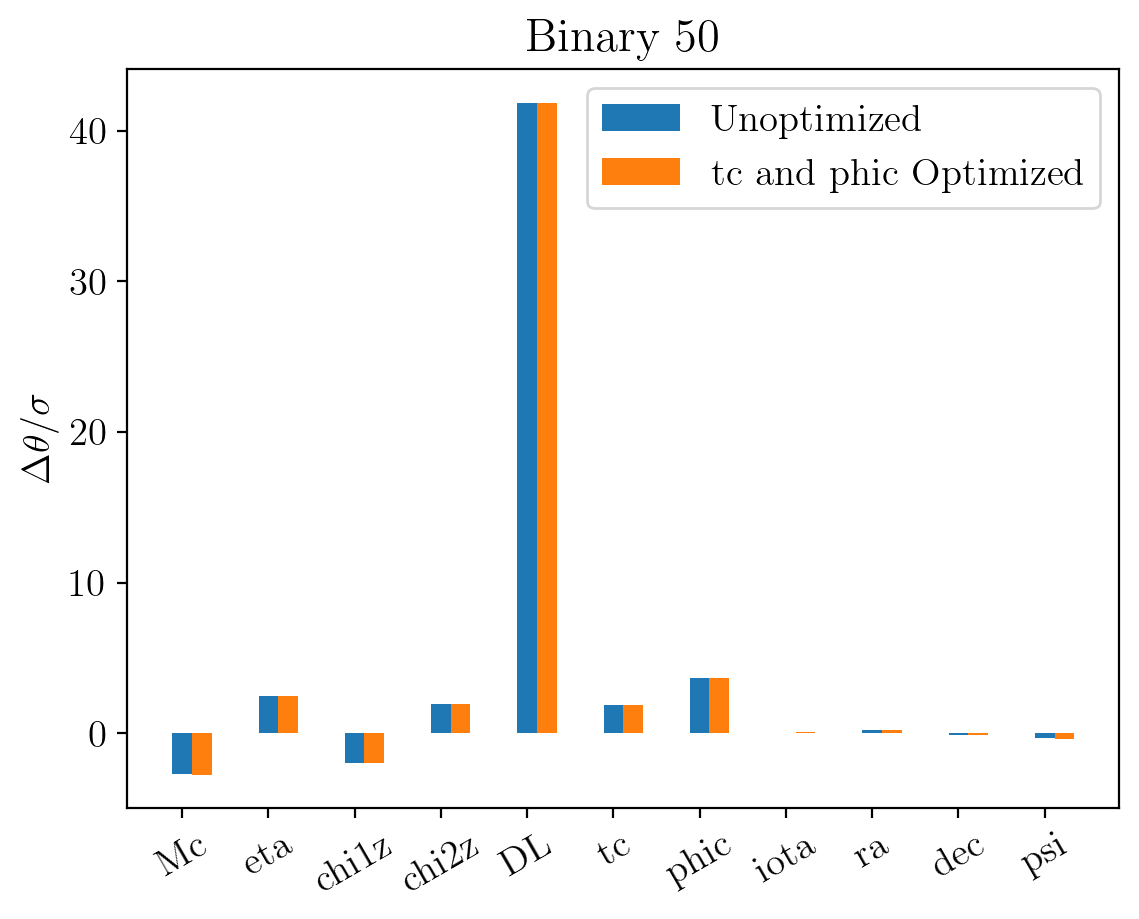

2023-10-17 10:28:56,041 - Network - INFO : Polarizations calculated.
2023-10-17 10:28:56,042 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:28:56,049 - Network - INFO : Polarizations calculated.


######  Binary 51  ######


2023-10-17 10:28:57,383 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:28:57,448 - Network - INFO : PSDs loaded.
2023-10-17 10:28:57,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:28:57,488 - Network - INFO : Detector responses calculated.
2023-10-17 10:28:57,489 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:28:57,490 - Network - INFO :    CE-40_C
2023-10-17 10:28:58,536 - Network - INFO :    CE-20_S
2023-10-17 10:28:59,547 - Network - INFO :    ET_ET1
2023-10-17 10:29:00,518 - Network - INFO :    ET_ET2
2023-10-17 10:29:01,480 - Network - INFO :    ET_ET3
2023-10-17 10:29:02,447 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:29:02,450 - Network - INFO : SNRs calculated.
2023-10-17 10:29:02,451 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:29:02,451 - Network - INFO :    CE-40_C
2023-10-17 10:29:02,505 - Network - INFO :

Mc bias diff: 14.55%
Mc, not: 1.740 sigma
Mc, opt: 1.487 sigma

eta bias diff: 13.60%
eta, not: 0.996 sigma
eta, opt: 0.861 sigma

chi1z bias diff: 864.93%
chi1z, not: -0.020 sigma
chi1z, opt: 0.153 sigma

chi2z bias diff: 123.13%
chi2z, not: 0.162 sigma
chi2z, opt: -0.038 sigma

DL bias diff: 1.87%
DL, not: 12.902 sigma
DL, opt: 12.660 sigma

tc bias diff: 21.13%
tc, not: 1.152 sigma
tc, opt: 0.908 sigma

phic bias diff: 23.52%
phic, not: 0.837 sigma
phic, opt: 0.640 sigma

iota bias diff: -8.77%
iota, not: -0.087 sigma
iota, opt: -0.095 sigma

ra bias diff: -89.85%
ra, not: 0.211 sigma
ra, opt: 0.401 sigma

dec bias diff: -87.93%
dec, not: -0.111 sigma
dec, opt: -0.209 sigma

psi bias diff: -43.76%
psi, not: -0.176 sigma
psi, opt: -0.253 sigma

######  Binary 52  ######


2023-10-17 10:29:11,474 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:29:11,518 - Network - INFO : PSDs loaded.
2023-10-17 10:29:11,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:29:11,551 - Network - INFO : Detector responses calculated.
2023-10-17 10:29:11,551 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:29:11,552 - Network - INFO :    CE-40_C
2023-10-17 10:29:12,589 - Network - INFO :    CE-20_S
2023-10-17 10:29:13,648 - Network - INFO :    ET_ET1
2023-10-17 10:29:14,709 - Network - INFO :    ET_ET2
2023-10-17 10:29:15,786 - Network - INFO :    ET_ET3
2023-10-17 10:29:16,867 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:29:16,879 - Network - INFO : SNRs calculated.
2023-10-17 10:29:16,886 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:29:16,897 - Network - INFO :    CE-40_C
2023-10-17 10:29:16,969 - Network - INFO :

Mc bias diff: -4.87%
Mc, not: 3.453 sigma
Mc, opt: 3.621 sigma

eta bias diff: 3.78%
eta, not: 1.540 sigma
eta, opt: 1.482 sigma

chi1z bias diff: -5.35%
chi1z, not: -2.434 sigma
chi1z, opt: -2.564 sigma

chi2z bias diff: -5.50%
chi2z, not: 2.458 sigma
chi2z, opt: 2.593 sigma

DL bias diff: 3.42%
DL, not: 14.023 sigma
DL, opt: 13.544 sigma

tc bias diff: -6.05%
tc, not: 2.452 sigma
tc, opt: 2.601 sigma

phic bias diff: -9.22%
phic, not: 1.523 sigma
phic, opt: 1.664 sigma

iota bias diff: 181.91%
iota, not: 0.227 sigma
iota, opt: -0.186 sigma

ra bias diff: -149.64%
ra, not: -0.119 sigma
ra, opt: -0.297 sigma

dec bias diff: -263.65%
dec, not: -0.099 sigma
dec, opt: -0.362 sigma

psi bias diff: -1464.72%
psi, not: 0.040 sigma
psi, opt: 0.631 sigma

######  Binary 53  ######


2023-10-17 10:29:26,951 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:29:26,994 - Network - INFO : PSDs loaded.
2023-10-17 10:29:26,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:29:27,031 - Network - INFO : Detector responses calculated.
2023-10-17 10:29:27,032 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:29:27,032 - Network - INFO :    CE-40_C
2023-10-17 10:29:28,328 - Network - INFO :    CE-20_S
2023-10-17 10:29:29,597 - Network - INFO :    ET_ET1
2023-10-17 10:29:30,936 - Network - INFO :    ET_ET2
2023-10-17 10:29:32,229 - Network - INFO :    ET_ET3
2023-10-17 10:29:33,541 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:29:33,544 - Network - INFO : SNRs calculated.
2023-10-17 10:29:33,545 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:29:33,545 - Network - INFO :    CE-40_C
2023-10-17 10:29:33,603 - Network - INFO :

Mc bias diff: -46.03%
Mc, not: 0.155 sigma
Mc, opt: 0.226 sigma

eta bias diff: 39.68%
eta, not: 0.655 sigma
eta, opt: 0.395 sigma

chi1z bias diff: 33.59%
chi1z, not: -0.612 sigma
chi1z, opt: -0.406 sigma

chi2z bias diff: 31.54%
chi2z, not: 0.591 sigma
chi2z, opt: 0.405 sigma

DL bias diff: 6.26%
DL, not: 9.645 sigma
DL, opt: 9.042 sigma

tc bias diff: 25.45%
tc, not: 0.602 sigma
tc, opt: 0.449 sigma

phic bias diff: -3.14%
phic, not: 0.870 sigma
phic, opt: 0.897 sigma

iota bias diff: -257.24%
iota, not: -0.482 sigma
iota, opt: -1.723 sigma

ra bias diff: -308.51%
ra, not: -0.300 sigma
ra, opt: -1.227 sigma

dec bias diff: -330.57%
dec, not: -0.305 sigma
dec, opt: -1.313 sigma

psi bias diff: -70.30%
psi, not: 0.428 sigma
psi, opt: 0.729 sigma

######  Binary 54  ######


2023-10-17 10:29:45,342 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:29:45,461 - Network - INFO : PSDs loaded.
2023-10-17 10:29:45,463 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:29:45,501 - Network - INFO : Detector responses calculated.
2023-10-17 10:29:45,502 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:29:45,502 - Network - INFO :    CE-40_C
2023-10-17 10:29:46,943 - Network - INFO :    CE-20_S
2023-10-17 10:29:48,339 - Network - INFO :    ET_ET1
2023-10-17 10:29:49,823 - Network - INFO :    ET_ET2
2023-10-17 10:29:51,259 - Network - INFO :    ET_ET3
2023-10-17 10:29:52,696 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:29:52,699 - Network - INFO : SNRs calculated.
2023-10-17 10:29:52,700 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:29:52,700 - Network - INFO :    CE-40_C
2023-10-17 10:29:52,759 - Network - INFO :

Mc bias diff: 35.32%
Mc, not: -1.906 sigma
Mc, opt: -1.233 sigma

eta bias diff: 47.34%
eta, not: 2.190 sigma
eta, opt: 1.153 sigma

chi1z bias diff: 85.54%
chi1z, not: -1.508 sigma
chi1z, opt: -0.218 sigma

chi2z bias diff: 93.33%
chi2z, not: 1.398 sigma
chi2z, opt: 0.093 sigma

DL bias diff: 8.19%
DL, not: 15.789 sigma
DL, opt: 14.496 sigma

tc bias diff: 89.22%
tc, not: 1.472 sigma
tc, opt: 0.159 sigma

phic bias diff: 70.96%
phic, not: 1.724 sigma
phic, opt: 0.501 sigma

iota bias diff: 663.89%
iota, not: -0.105 sigma
iota, opt: 0.589 sigma

ra bias diff: 207.77%
ra, not: 0.101 sigma
ra, opt: -0.109 sigma

dec bias diff: 832.12%
dec, not: -0.087 sigma
dec, opt: 0.640 sigma

psi bias diff: -3590.86%
psi, not: -0.068 sigma
psi, opt: -2.512 sigma

######  Binary 55  ######


2023-10-17 10:30:04,937 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:30:04,985 - Network - INFO : PSDs loaded.
2023-10-17 10:30:04,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:30:05,025 - Network - INFO : Detector responses calculated.
2023-10-17 10:30:05,025 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:30:05,026 - Network - INFO :    CE-40_C
2023-10-17 10:30:06,067 - Network - INFO :    CE-20_S
2023-10-17 10:30:07,160 - Network - INFO :    ET_ET1
2023-10-17 10:30:08,670 - Network - INFO :    ET_ET2
2023-10-17 10:30:09,817 - Network - INFO :    ET_ET3
2023-10-17 10:30:10,956 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:30:10,960 - Network - INFO : SNRs calculated.
2023-10-17 10:30:10,960 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:30:10,961 - Network - INFO :    CE-40_C
2023-10-17 10:30:11,033 - Network - INFO :

Mc bias diff: -1.05%
Mc, not: 0.779 sigma
Mc, opt: 0.787 sigma

eta bias diff: 2.11%
eta, not: 0.891 sigma
eta, opt: 0.872 sigma

chi1z bias diff: -1.74%
chi1z, not: -0.978 sigma
chi1z, opt: -0.995 sigma

chi2z bias diff: -1.78%
chi2z, not: 0.979 sigma
chi2z, opt: 0.997 sigma

DL bias diff: 50.97%
DL, not: 0.930 sigma
DL, opt: 0.456 sigma

tc bias diff: -1.25%
tc, not: 0.980 sigma
tc, opt: 0.992 sigma

phic bias diff: -6.52%
phic, not: 0.860 sigma
phic, opt: 0.916 sigma

iota bias diff: -486.44%
iota, not: -0.249 sigma
iota, opt: -1.462 sigma

ra bias diff: -156.35%
ra, not: -0.185 sigma
ra, opt: -0.474 sigma

dec bias diff: -90.71%
dec, not: 0.226 sigma
dec, opt: 0.431 sigma

psi bias diff: -552.49%
psi, not: 0.018 sigma
psi, opt: 0.120 sigma

######  Binary 56  ######


2023-10-17 10:30:21,017 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:30:21,060 - Network - INFO : PSDs loaded.
2023-10-17 10:30:21,062 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:30:21,100 - Network - INFO : Detector responses calculated.
2023-10-17 10:30:21,101 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:30:21,101 - Network - INFO :    CE-40_C
2023-10-17 10:30:22,580 - Network - INFO :    CE-20_S
2023-10-17 10:30:24,036 - Network - INFO :    ET_ET1
2023-10-17 10:30:25,492 - Network - INFO :    ET_ET2
2023-10-17 10:30:26,951 - Network - INFO :    ET_ET3
2023-10-17 10:30:28,413 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:30:28,416 - Network - INFO : SNRs calculated.
2023-10-17 10:30:28,417 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:30:28,417 - Network - INFO :    CE-40_C
2023-10-17 10:30:28,476 - Network - INFO :

Mc bias diff: 2.19%
Mc, not: -3.057 sigma
Mc, opt: -2.990 sigma

eta bias diff: -0.85%
eta, not: 4.430 sigma
eta, opt: 4.468 sigma

chi1z bias diff: -3.06%
chi1z, not: -3.787 sigma
chi1z, opt: -3.903 sigma

chi2z bias diff: -3.99%
chi2z, not: 3.588 sigma
chi2z, opt: 3.731 sigma

DL bias diff: 10.68%
DL, not: 13.679 sigma
DL, opt: 12.218 sigma

tc bias diff: -1.89%
tc, not: 3.587 sigma
tc, opt: 3.655 sigma

phic bias diff: -25.36%
phic, not: 3.452 sigma
phic, opt: 4.327 sigma

iota bias diff: 773.33%
iota, not: 0.223 sigma
iota, opt: -1.499 sigma

ra bias diff: 246.23%
ra, not: 0.852 sigma
ra, opt: -1.246 sigma

dec bias diff: 250.20%
dec, not: -0.825 sigma
dec, opt: 1.240 sigma

psi bias diff: -456.61%
psi, not: -0.325 sigma
psi, opt: -1.809 sigma

######  Binary 57  ######


2023-10-17 10:30:39,599 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:30:39,669 - Network - INFO : PSDs loaded.
2023-10-17 10:30:39,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:30:39,707 - Network - INFO : Detector responses calculated.
2023-10-17 10:30:39,708 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:30:39,709 - Network - INFO :    CE-40_C
2023-10-17 10:30:40,294 - Network - INFO :    CE-20_S
2023-10-17 10:30:40,880 - Network - INFO :    ET_ET1
2023-10-17 10:30:41,461 - Network - INFO :    ET_ET2
2023-10-17 10:30:42,041 - Network - INFO :    ET_ET3
2023-10-17 10:30:42,622 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:30:42,626 - Network - INFO : SNRs calculated.
2023-10-17 10:30:42,627 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:30:42,628 - Network - INFO :    CE-40_C
2023-10-17 10:30:42,707 - Network - INFO :

Mc bias diff: 56.60%
Mc, not: 1.330 sigma
Mc, opt: 0.577 sigma

eta bias diff: 69.86%
eta, not: -0.460 sigma
eta, opt: -0.139 sigma

chi1z bias diff: -18.73%
chi1z, not: -7.011 sigma
chi1z, opt: -8.324 sigma

chi2z bias diff: -18.39%
chi2z, not: 7.112 sigma
chi2z, opt: 8.420 sigma

DL bias diff: 15.59%
DL, not: 5.778 sigma
DL, opt: 4.878 sigma

tc bias diff: -3.86%
tc, not: 3.536 sigma
tc, opt: 3.673 sigma

phic bias diff: -9.78%
phic, not: 2.941 sigma
phic, opt: 3.229 sigma

iota bias diff: -387.76%
iota, not: -0.429 sigma
iota, opt: -2.092 sigma

ra bias diff: 250.36%
ra, not: -0.428 sigma
ra, opt: 0.643 sigma

dec bias diff: -237.74%
dec, not: -0.496 sigma
dec, opt: -1.676 sigma

psi bias diff: 34.21%
psi, not: 0.306 sigma
psi, opt: 0.201 sigma

######  Binary 58  ######


2023-10-17 10:30:48,046 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:30:48,116 - Network - INFO : PSDs loaded.
2023-10-17 10:30:48,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:30:48,156 - Network - INFO : Detector responses calculated.
2023-10-17 10:30:48,157 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:30:48,158 - Network - INFO :    CE-40_C
2023-10-17 10:30:48,877 - Network - INFO :    CE-20_S
2023-10-17 10:30:49,593 - Network - INFO :    ET_ET1
2023-10-17 10:30:50,314 - Network - INFO :    ET_ET2
2023-10-17 10:30:51,032 - Network - INFO :    ET_ET3
2023-10-17 10:30:51,751 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:30:51,755 - Network - INFO : SNRs calculated.
2023-10-17 10:30:51,756 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:30:51,756 - Network - INFO :    CE-40_C
2023-10-17 10:30:51,834 - Network - INFO :

Mc bias diff: 0.68%
Mc, not: 3.708 sigma
Mc, opt: 3.683 sigma

eta bias diff: 0.05%
eta, not: 7.672 sigma
eta, opt: 7.668 sigma

chi1z bias diff: 0.08%
chi1z, not: -9.369 sigma
chi1z, opt: -9.362 sigma

chi2z bias diff: 0.09%
chi2z, not: 9.633 sigma
chi2z, opt: 9.624 sigma

DL bias diff: 4.36%
DL, not: 1.968 sigma
DL, opt: 1.883 sigma

tc bias diff: 0.09%
tc, not: 9.440 sigma
tc, opt: 9.431 sigma

phic bias diff: 0.45%
phic, not: 3.634 sigma
phic, opt: 3.617 sigma

iota bias diff: -15.55%
iota, not: 1.459 sigma
iota, opt: 1.686 sigma

ra bias diff: 128.54%
ra, not: -0.025 sigma
ra, opt: 0.007 sigma

dec bias diff: -432.86%
dec, not: 0.006 sigma
dec, opt: 0.034 sigma

psi bias diff: -3.27%
psi, not: -0.580 sigma
psi, opt: -0.599 sigma

######  Binary 59  ######


2023-10-17 10:30:59,336 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:30:59,378 - Network - INFO : PSDs loaded.
2023-10-17 10:30:59,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:30:59,418 - Network - INFO : Detector responses calculated.
2023-10-17 10:30:59,419 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:30:59,419 - Network - INFO :    CE-40_C
2023-10-17 10:31:00,818 - Network - INFO :    CE-20_S
2023-10-17 10:31:02,290 - Network - INFO :    ET_ET1
2023-10-17 10:31:03,804 - Network - INFO :    ET_ET2
2023-10-17 10:31:05,728 - Network - INFO :    ET_ET3
2023-10-17 10:31:07,408 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:31:07,412 - Network - INFO : SNRs calculated.
2023-10-17 10:31:07,412 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:31:07,413 - Network - INFO :    CE-40_C
2023-10-17 10:31:07,481 - Network - INFO :

Mc bias diff: 7.01%
Mc, not: -0.065 sigma
Mc, opt: -0.061 sigma

eta bias diff: 0.84%
eta, not: 0.288 sigma
eta, opt: 0.285 sigma

chi1z bias diff: 0.39%
chi1z, not: -0.229 sigma
chi1z, opt: -0.228 sigma

chi2z bias diff: 0.84%
chi2z, not: 0.216 sigma
chi2z, opt: 0.215 sigma

DL bias diff: 0.53%
DL, not: 13.198 sigma
DL, opt: 13.128 sigma

tc bias diff: 1.41%
tc, not: 0.213 sigma
tc, opt: 0.210 sigma

phic bias diff: -2.71%
phic, not: 0.439 sigma
phic, opt: 0.451 sigma

iota bias diff: -131.18%
iota, not: -0.102 sigma
iota, opt: -0.237 sigma

ra bias diff: -46.13%
ra, not: -0.089 sigma
ra, opt: -0.130 sigma

dec bias diff: -151.28%
dec, not: 0.070 sigma
dec, opt: 0.175 sigma

psi bias diff: -47.16%
psi, not: -0.171 sigma
psi, opt: -0.252 sigma

######  Binary 60  ######


2023-10-17 10:31:20,650 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:31:20,692 - Network - INFO : PSDs loaded.
2023-10-17 10:31:20,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:31:20,733 - Network - INFO : Detector responses calculated.
2023-10-17 10:31:20,734 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:31:20,734 - Network - INFO :    CE-40_C
2023-10-17 10:31:22,291 - Network - INFO :    CE-20_S
2023-10-17 10:31:23,822 - Network - INFO :    ET_ET1
2023-10-17 10:31:25,356 - Network - INFO :    ET_ET2
2023-10-17 10:31:26,897 - Network - INFO :    ET_ET3
2023-10-17 10:31:28,434 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:31:28,438 - Network - INFO : SNRs calculated.
2023-10-17 10:31:28,438 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:31:28,439 - Network - INFO :    CE-40_C
2023-10-17 10:31:28,499 - Network - INFO :

Mc bias diff: 12.99%
Mc, not: -1.254 sigma
Mc, opt: -1.091 sigma

eta bias diff: 25.73%
eta, not: 1.387 sigma
eta, opt: 1.030 sigma

chi1z bias diff: 39.01%
chi1z, not: -1.000 sigma
chi1z, opt: -0.610 sigma

chi2z bias diff: 42.27%
chi2z, not: 0.928 sigma
chi2z, opt: 0.536 sigma

DL bias diff: 12.05%
DL, not: 10.132 sigma
DL, opt: 8.911 sigma

tc bias diff: 41.92%
tc, not: 0.924 sigma
tc, opt: 0.536 sigma

phic bias diff: -0.70%
phic, not: 1.324 sigma
phic, opt: 1.334 sigma

iota bias diff: 869.54%
iota, not: 0.211 sigma
iota, opt: -1.626 sigma

ra bias diff: 595.60%
ra, not: 0.089 sigma
ra, opt: -0.443 sigma

dec bias diff: 19.19%
dec, not: -0.059 sigma
dec, opt: -0.048 sigma

psi bias diff: -738.18%
psi, not: -0.049 sigma
psi, opt: -0.408 sigma



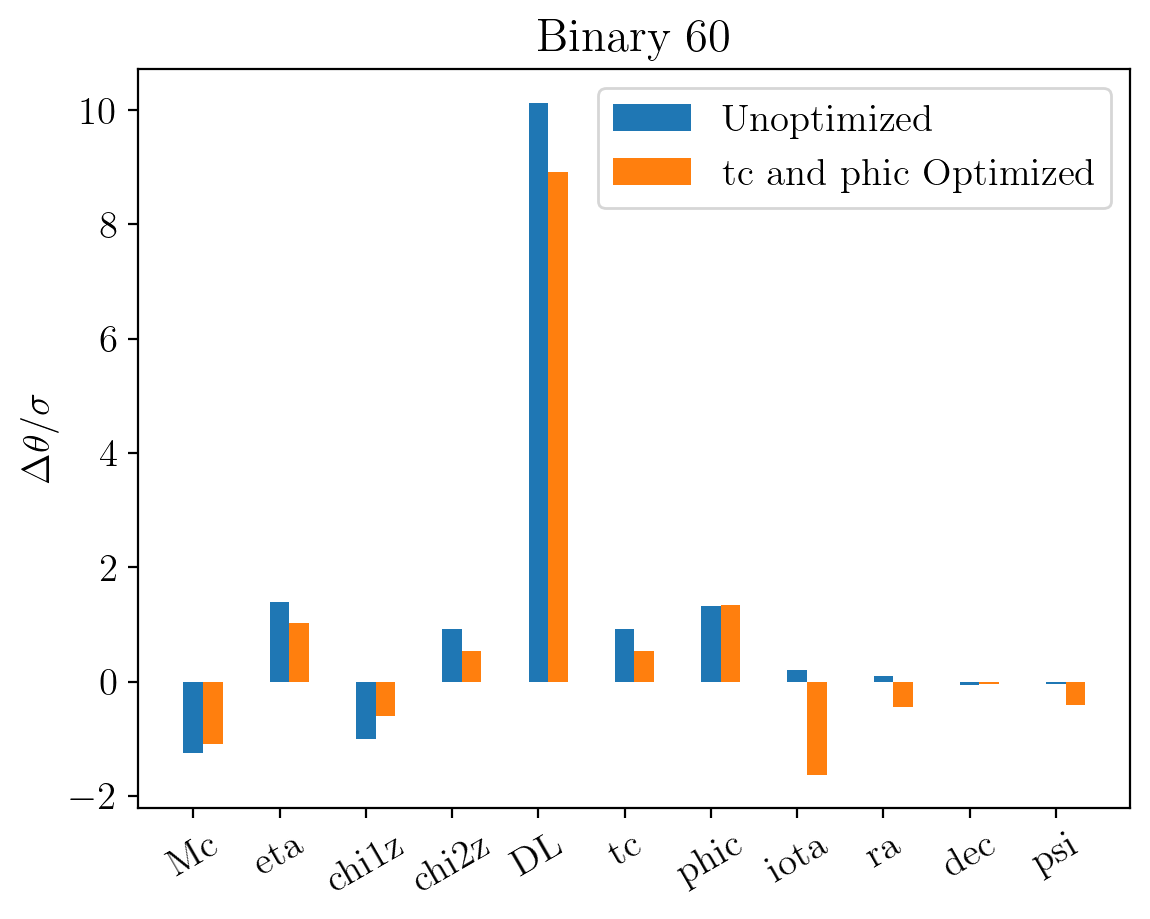

2023-10-17 10:31:39,863 - Network - INFO : Polarizations calculated.
2023-10-17 10:31:39,864 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:31:39,870 - Network - INFO : Polarizations calculated.


######  Binary 61  ######


2023-10-17 10:31:40,710 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:31:40,779 - Network - INFO : PSDs loaded.
2023-10-17 10:31:40,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:31:40,818 - Network - INFO : Detector responses calculated.
2023-10-17 10:31:40,819 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:31:40,820 - Network - INFO :    CE-40_C
2023-10-17 10:31:41,483 - Network - INFO :    CE-20_S
2023-10-17 10:31:42,147 - Network - INFO :    ET_ET1
2023-10-17 10:31:42,805 - Network - INFO :    ET_ET2
2023-10-17 10:31:43,464 - Network - INFO :    ET_ET3
2023-10-17 10:31:44,123 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:31:44,127 - Network - INFO : SNRs calculated.
2023-10-17 10:31:44,128 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:31:44,129 - Network - INFO :    CE-40_C
2023-10-17 10:31:44,210 - Network - INFO :

Mc bias diff: -31.93%
Mc, not: 2.816 sigma
Mc, opt: 3.716 sigma

eta bias diff: -7.38%
eta, not: 5.897 sigma
eta, opt: 6.332 sigma

chi1z bias diff: -6.40%
chi1z, not: -6.113 sigma
chi1z, opt: -6.504 sigma

chi2z bias diff: -6.46%
chi2z, not: 6.110 sigma
chi2z, opt: 6.505 sigma

DL bias diff: -0.01%
DL, not: 18.658 sigma
DL, opt: 18.660 sigma

tc bias diff: -5.62%
tc, not: 6.001 sigma
tc, opt: 6.339 sigma

phic bias diff: -4.73%
phic, not: 5.861 sigma
phic, opt: 6.138 sigma

iota bias diff: -110.28%
iota, not: -0.236 sigma
iota, opt: -0.495 sigma

ra bias diff: 195.16%
ra, not: -0.089 sigma
ra, opt: 0.084 sigma

dec bias diff: -340.28%
dec, not: 0.431 sigma
dec, opt: 1.897 sigma

psi bias diff: -188.95%
psi, not: 0.406 sigma
psi, opt: 1.174 sigma

######  Binary 62  ######


2023-10-17 10:31:49,688 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:31:49,759 - Network - INFO : PSDs loaded.
2023-10-17 10:31:49,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:31:49,798 - Network - INFO : Detector responses calculated.
2023-10-17 10:31:49,798 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:31:49,799 - Network - INFO :    CE-40_C
2023-10-17 10:31:50,305 - Network - INFO :    CE-20_S
2023-10-17 10:31:50,811 - Network - INFO :    ET_ET1
2023-10-17 10:31:51,316 - Network - INFO :    ET_ET2
2023-10-17 10:31:51,825 - Network - INFO :    ET_ET3
2023-10-17 10:31:52,329 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:31:52,332 - Network - INFO : SNRs calculated.
2023-10-17 10:31:52,333 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:31:52,334 - Network - INFO :    CE-40_C
2023-10-17 10:31:52,413 - Network - INFO :

Mc bias diff: -2.13%
Mc, not: -6.639 sigma
Mc, opt: -6.781 sigma

eta bias diff: -0.39%
eta, not: 10.158 sigma
eta, opt: 10.198 sigma

chi1z bias diff: -0.33%
chi1z, not: -10.933 sigma
chi1z, opt: -10.968 sigma

chi2z bias diff: -0.16%
chi2z, not: 11.419 sigma
chi2z, opt: 11.437 sigma

DL bias diff: 1.60%
DL, not: 18.889 sigma
DL, opt: 18.587 sigma

tc bias diff: -0.23%
tc, not: 11.229 sigma
tc, opt: 11.255 sigma

phic bias diff: -0.33%
phic, not: 11.198 sigma
phic, opt: 11.236 sigma

iota bias diff: 117.59%
iota, not: 0.198 sigma
iota, opt: -0.035 sigma

ra bias diff: -14.55%
ra, not: 1.652 sigma
ra, opt: 1.893 sigma

dec bias diff: 30.94%
dec, not: 1.457 sigma
dec, opt: 1.006 sigma

psi bias diff: 7.53%
psi, not: -0.302 sigma
psi, opt: -0.279 sigma

######  Binary 63  ######


2023-10-17 10:31:57,479 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:31:57,548 - Network - INFO : PSDs loaded.
2023-10-17 10:31:57,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:31:57,585 - Network - INFO : Detector responses calculated.
2023-10-17 10:31:57,586 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:31:57,587 - Network - INFO :    CE-40_C
2023-10-17 10:31:58,393 - Network - INFO :    CE-20_S
2023-10-17 10:31:59,202 - Network - INFO :    ET_ET1
2023-10-17 10:32:00,037 - Network - INFO :    ET_ET2
2023-10-17 10:32:00,847 - Network - INFO :    ET_ET3
2023-10-17 10:32:01,659 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:32:01,663 - Network - INFO : SNRs calculated.
2023-10-17 10:32:01,664 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:32:01,664 - Network - INFO :    CE-40_C
2023-10-17 10:32:01,728 - Network - INFO :

Mc bias diff: -4.99%
Mc, not: 3.973 sigma
Mc, opt: 4.171 sigma

eta bias diff: -4.06%
eta, not: 5.455 sigma
eta, opt: 5.676 sigma

chi1z bias diff: -4.34%
chi1z, not: -5.820 sigma
chi1z, opt: -6.073 sigma

chi2z bias diff: -4.38%
chi2z, not: 5.866 sigma
chi2z, opt: 6.123 sigma

DL bias diff: 0.17%
DL, not: 28.191 sigma
DL, opt: 28.142 sigma

tc bias diff: -4.39%
tc, not: 5.787 sigma
tc, opt: 6.041 sigma

phic bias diff: -4.10%
phic, not: 5.659 sigma
phic, opt: 5.891 sigma

iota bias diff: 11.86%
iota, not: 0.032 sigma
iota, opt: 0.028 sigma

ra bias diff: 7478.43%
ra, not: -0.000 sigma
ra, opt: 0.023 sigma

dec bias diff: -30.86%
dec, not: -0.653 sigma
dec, opt: -0.855 sigma

psi bias diff: 59.97%
psi, not: -0.030 sigma
psi, opt: -0.012 sigma

######  Binary 64  ######


2023-10-17 10:32:09,951 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:32:09,994 - Network - INFO : PSDs loaded.
2023-10-17 10:32:09,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:32:10,035 - Network - INFO : Detector responses calculated.
2023-10-17 10:32:10,036 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:32:10,036 - Network - INFO :    CE-40_C
2023-10-17 10:32:11,538 - Network - INFO :    CE-20_S
2023-10-17 10:32:13,012 - Network - INFO :    ET_ET1
2023-10-17 10:32:14,470 - Network - INFO :    ET_ET2
2023-10-17 10:32:15,922 - Network - INFO :    ET_ET3
2023-10-17 10:32:17,394 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:32:17,397 - Network - INFO : SNRs calculated.
2023-10-17 10:32:17,397 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:32:17,398 - Network - INFO :    CE-40_C
2023-10-17 10:32:17,457 - Network - INFO :

Mc bias diff: -55.87%
Mc, not: 0.285 sigma
Mc, opt: 0.444 sigma

eta bias diff: -170.90%
eta, not: -0.097 sigma
eta, opt: -0.262 sigma

chi1z bias diff: -37.38%
chi1z, not: 0.297 sigma
chi1z, opt: 0.409 sigma

chi2z bias diff: -30.68%
chi2z, not: -0.324 sigma
chi2z, opt: -0.423 sigma

DL bias diff: 17.33%
DL, not: 6.564 sigma
DL, opt: 5.427 sigma

tc bias diff: -16.03%
tc, not: -0.352 sigma
tc, opt: -0.409 sigma

phic bias diff: 31.63%
phic, not: 0.396 sigma
phic, opt: 0.271 sigma

iota bias diff: -525.50%
iota, not: 0.295 sigma
iota, opt: 1.846 sigma

ra bias diff: 647.44%
ra, not: 0.174 sigma
ra, opt: -0.951 sigma

dec bias diff: 624.14%
dec, not: 0.182 sigma
dec, opt: -0.954 sigma

psi bias diff: -139.54%
psi, not: 0.195 sigma
psi, opt: 0.467 sigma

######  Binary 65  ######


2023-10-17 10:32:29,669 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:32:29,718 - Network - INFO : PSDs loaded.
2023-10-17 10:32:29,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:32:29,752 - Network - INFO : Detector responses calculated.
2023-10-17 10:32:29,753 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:32:29,753 - Network - INFO :    CE-40_C
2023-10-17 10:32:30,810 - Network - INFO :    CE-20_S
2023-10-17 10:32:31,894 - Network - INFO :    ET_ET1
2023-10-17 10:32:33,016 - Network - INFO :    ET_ET2
2023-10-17 10:32:34,124 - Network - INFO :    ET_ET3
2023-10-17 10:32:35,214 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:32:35,223 - Network - INFO : SNRs calculated.
2023-10-17 10:32:35,225 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:32:35,228 - Network - INFO :    CE-40_C
2023-10-17 10:32:35,291 - Network - INFO :

Mc bias diff: -5.41%
Mc, not: -2.169 sigma
Mc, opt: -2.286 sigma

eta bias diff: 3.96%
eta, not: 4.856 sigma
eta, opt: 4.664 sigma

chi1z bias diff: 9.91%
chi1z, not: -2.962 sigma
chi1z, opt: -2.669 sigma

chi2z bias diff: 12.99%
chi2z, not: 2.384 sigma
chi2z, opt: 2.074 sigma

DL bias diff: 0.66%
DL, not: 21.879 sigma
DL, opt: 21.735 sigma

tc bias diff: 11.75%
tc, not: 2.566 sigma
tc, opt: 2.264 sigma

phic bias diff: 8.34%
phic, not: 2.981 sigma
phic, opt: 2.733 sigma

iota bias diff: 74.06%
iota, not: 0.104 sigma
iota, opt: 0.027 sigma

ra bias diff: 69.64%
ra, not: -0.056 sigma
ra, opt: -0.017 sigma

dec bias diff: 3218.98%
dec, not: 0.021 sigma
dec, opt: -0.656 sigma

psi bias diff: -37.39%
psi, not: -0.463 sigma
psi, opt: -0.636 sigma

######  Binary 66  ######


2023-10-17 10:32:46,530 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:32:46,572 - Network - INFO : PSDs loaded.
2023-10-17 10:32:46,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:32:46,623 - Network - INFO : Detector responses calculated.
2023-10-17 10:32:46,623 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:32:46,624 - Network - INFO :    CE-40_C
2023-10-17 10:32:48,685 - Network - INFO :    CE-20_S
2023-10-17 10:32:50,680 - Network - INFO :    ET_ET1
2023-10-17 10:32:52,658 - Network - INFO :    ET_ET2
2023-10-17 10:32:54,644 - Network - INFO :    ET_ET3
2023-10-17 10:32:56,614 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:32:56,618 - Network - INFO : SNRs calculated.
2023-10-17 10:32:56,618 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:32:56,619 - Network - INFO :    CE-40_C
2023-10-17 10:32:56,684 - Network - INFO :

Mc bias diff: -0.16%
Mc, not: -8.993 sigma
Mc, opt: -9.007 sigma

eta bias diff: -0.32%
eta, not: 7.972 sigma
eta, opt: 7.997 sigma

chi1z bias diff: -0.74%
chi1z, not: -6.606 sigma
chi1z, opt: -6.654 sigma

chi2z bias diff: -0.40%
chi2z, not: 6.174 sigma
chi2z, opt: 6.199 sigma

DL bias diff: 0.18%
DL, not: 17.309 sigma
DL, opt: 17.277 sigma

tc bias diff: -0.66%
tc, not: 6.200 sigma
tc, opt: 6.241 sigma

phic bias diff: 0.75%
phic, not: 4.658 sigma
phic, opt: 4.623 sigma

iota bias diff: -13.25%
iota, not: 0.554 sigma
iota, opt: 0.627 sigma

ra bias diff: 10.71%
ra, not: -0.402 sigma
ra, opt: -0.359 sigma

dec bias diff: 215.73%
dec, not: -0.012 sigma
dec, opt: 0.014 sigma

psi bias diff: -5.20%
psi, not: -0.807 sigma
psi, opt: -0.849 sigma

######  Binary 67  ######


2023-10-17 10:33:13,076 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:33:13,194 - Network - INFO : PSDs loaded.
2023-10-17 10:33:13,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:33:13,236 - Network - INFO : Detector responses calculated.
2023-10-17 10:33:13,237 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:33:13,238 - Network - INFO :    CE-40_C
2023-10-17 10:33:14,804 - Network - INFO :    CE-20_S
2023-10-17 10:33:16,343 - Network - INFO :    ET_ET1
2023-10-17 10:33:17,865 - Network - INFO :    ET_ET2
2023-10-17 10:33:19,393 - Network - INFO :    ET_ET3
2023-10-17 10:33:20,916 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:33:20,919 - Network - INFO : SNRs calculated.
2023-10-17 10:33:20,920 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:33:20,920 - Network - INFO :    CE-40_C
2023-10-17 10:33:20,980 - Network - INFO :

Mc bias diff: 27.45%
Mc, not: -0.713 sigma
Mc, opt: -0.517 sigma

eta bias diff: 222.95%
eta, not: 0.351 sigma
eta, opt: -0.432 sigma

chi1z bias diff: -222.23%
chi1z, not: 0.456 sigma
chi1z, opt: 1.469 sigma

chi2z bias diff: -164.85%
chi2z, not: -0.644 sigma
chi2z, opt: -1.705 sigma

DL bias diff: 33.67%
DL, not: 10.882 sigma
DL, opt: 7.219 sigma

tc bias diff: -165.74%
tc, not: -0.620 sigma
tc, opt: -1.646 sigma

phic bias diff: 262.23%
phic, not: 0.327 sigma
phic, opt: -0.530 sigma

iota bias diff: 2099.57%
iota, not: 0.337 sigma
iota, opt: -6.733 sigma

ra bias diff: -1567.70%
ra, not: -0.111 sigma
ra, opt: -1.849 sigma

dec bias diff: 1330.67%
dec, not: 0.096 sigma
dec, opt: -1.180 sigma

psi bias diff: -211.20%
psi, not: 0.443 sigma
psi, opt: 1.378 sigma

######  Binary 68  ######


2023-10-17 10:33:33,448 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:33:33,517 - Network - INFO : PSDs loaded.
2023-10-17 10:33:33,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:33:33,558 - Network - INFO : Detector responses calculated.
2023-10-17 10:33:33,559 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:33:33,560 - Network - INFO :    CE-40_C
2023-10-17 10:33:34,289 - Network - INFO :    CE-20_S
2023-10-17 10:33:35,015 - Network - INFO :    ET_ET1
2023-10-17 10:33:35,742 - Network - INFO :    ET_ET2
2023-10-17 10:33:36,549 - Network - INFO :    ET_ET3
2023-10-17 10:33:37,281 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:33:37,286 - Network - INFO : SNRs calculated.
2023-10-17 10:33:37,287 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:33:37,288 - Network - INFO :    CE-40_C
2023-10-17 10:33:37,367 - Network - INFO :

Mc bias diff: 0.39%
Mc, not: 6.252 sigma
Mc, opt: 6.227 sigma

eta bias diff: 0.52%
eta, not: 22.898 sigma
eta, opt: 22.780 sigma

chi1z bias diff: 0.51%
chi1z, not: -29.236 sigma
chi1z, opt: -29.087 sigma

chi2z bias diff: 0.56%
chi2z, not: 30.543 sigma
chi2z, opt: 30.371 sigma

DL bias diff: 108.92%
DL, not: 4.724 sigma
DL, opt: -0.421 sigma

tc bias diff: 0.60%
tc, not: 30.241 sigma
tc, opt: 30.061 sigma

phic bias diff: -49.31%
phic, not: 0.491 sigma
phic, opt: 0.733 sigma

iota bias diff: 1524.05%
iota, not: -1.400 sigma
iota, opt: 19.934 sigma

ra bias diff: -70.38%
ra, not: -0.630 sigma
ra, opt: -1.073 sigma

dec bias diff: 37.21%
dec, not: -2.134 sigma
dec, opt: -1.340 sigma

psi bias diff: 329.95%
psi, not: -0.077 sigma
psi, opt: 0.177 sigma

######  Binary 69  ######


2023-10-17 10:33:44,851 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:33:44,894 - Network - INFO : PSDs loaded.
2023-10-17 10:33:44,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:33:44,930 - Network - INFO : Detector responses calculated.
2023-10-17 10:33:44,931 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:33:44,931 - Network - INFO :    CE-40_C
2023-10-17 10:33:46,153 - Network - INFO :    CE-20_S
2023-10-17 10:33:47,382 - Network - INFO :    ET_ET1
2023-10-17 10:33:48,748 - Network - INFO :    ET_ET2
2023-10-17 10:33:50,038 - Network - INFO :    ET_ET3
2023-10-17 10:33:51,300 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:33:51,304 - Network - INFO : SNRs calculated.
2023-10-17 10:33:51,304 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:33:51,305 - Network - INFO :    CE-40_C
2023-10-17 10:33:51,367 - Network - INFO :

Mc bias diff: -38.59%
Mc, not: 0.259 sigma
Mc, opt: 0.359 sigma

eta bias diff: 35.57%
eta, not: 0.424 sigma
eta, opt: 0.273 sigma

chi1z bias diff: 23.18%
chi1z, not: -0.380 sigma
chi1z, opt: -0.292 sigma

chi2z bias diff: 22.53%
chi2z, not: 0.368 sigma
chi2z, opt: 0.285 sigma

DL bias diff: 1.47%
DL, not: 16.574 sigma
DL, opt: 16.330 sigma

tc bias diff: 14.82%
tc, not: 0.361 sigma
tc, opt: 0.307 sigma

phic bias diff: 4.91%
phic, not: 1.013 sigma
phic, opt: 0.963 sigma

iota bias diff: 322.62%
iota, not: -0.119 sigma
iota, opt: 0.264 sigma

ra bias diff: -66.03%
ra, not: 0.140 sigma
ra, opt: 0.233 sigma

dec bias diff: -279.15%
dec, not: 0.083 sigma
dec, opt: 0.315 sigma

psi bias diff: -17.80%
psi, not: -0.127 sigma
psi, opt: -0.149 sigma

######  Binary 70  ######


2023-10-17 10:34:02,131 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:34:02,180 - Network - INFO : PSDs loaded.
2023-10-17 10:34:02,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:34:02,212 - Network - INFO : Detector responses calculated.
2023-10-17 10:34:02,213 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:34:02,213 - Network - INFO :    CE-40_C
2023-10-17 10:34:03,194 - Network - INFO :    CE-20_S
2023-10-17 10:34:04,165 - Network - INFO :    ET_ET1
2023-10-17 10:34:05,136 - Network - INFO :    ET_ET2
2023-10-17 10:34:06,105 - Network - INFO :    ET_ET3
2023-10-17 10:34:07,073 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:34:07,076 - Network - INFO : SNRs calculated.
2023-10-17 10:34:07,077 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:34:07,077 - Network - INFO :    CE-40_C
2023-10-17 10:34:07,130 - Network - INFO :

Mc bias diff: 0.33%
Mc, not: 3.965 sigma
Mc, opt: 3.952 sigma

eta bias diff: 5.84%
eta, not: 2.085 sigma
eta, opt: 1.963 sigma

chi1z bias diff: 1.52%
chi1z, not: -3.056 sigma
chi1z, opt: -3.010 sigma

chi2z bias diff: 1.04%
chi2z, not: 3.033 sigma
chi2z, opt: 3.001 sigma

DL bias diff: 0.19%
DL, not: 11.554 sigma
DL, opt: 11.532 sigma

tc bias diff: 1.02%
tc, not: 3.515 sigma
tc, opt: 3.479 sigma

phic bias diff: 1.70%
phic, not: 2.717 sigma
phic, opt: 2.671 sigma

iota bias diff: -11.77%
iota, not: 0.558 sigma
iota, opt: 0.623 sigma

ra bias diff: 14.37%
ra, not: 0.220 sigma
ra, opt: 0.188 sigma

dec bias diff: 3.56%
dec, not: 0.358 sigma
dec, opt: 0.345 sigma

psi bias diff: 0.98%
psi, not: -0.711 sigma
psi, opt: -0.704 sigma



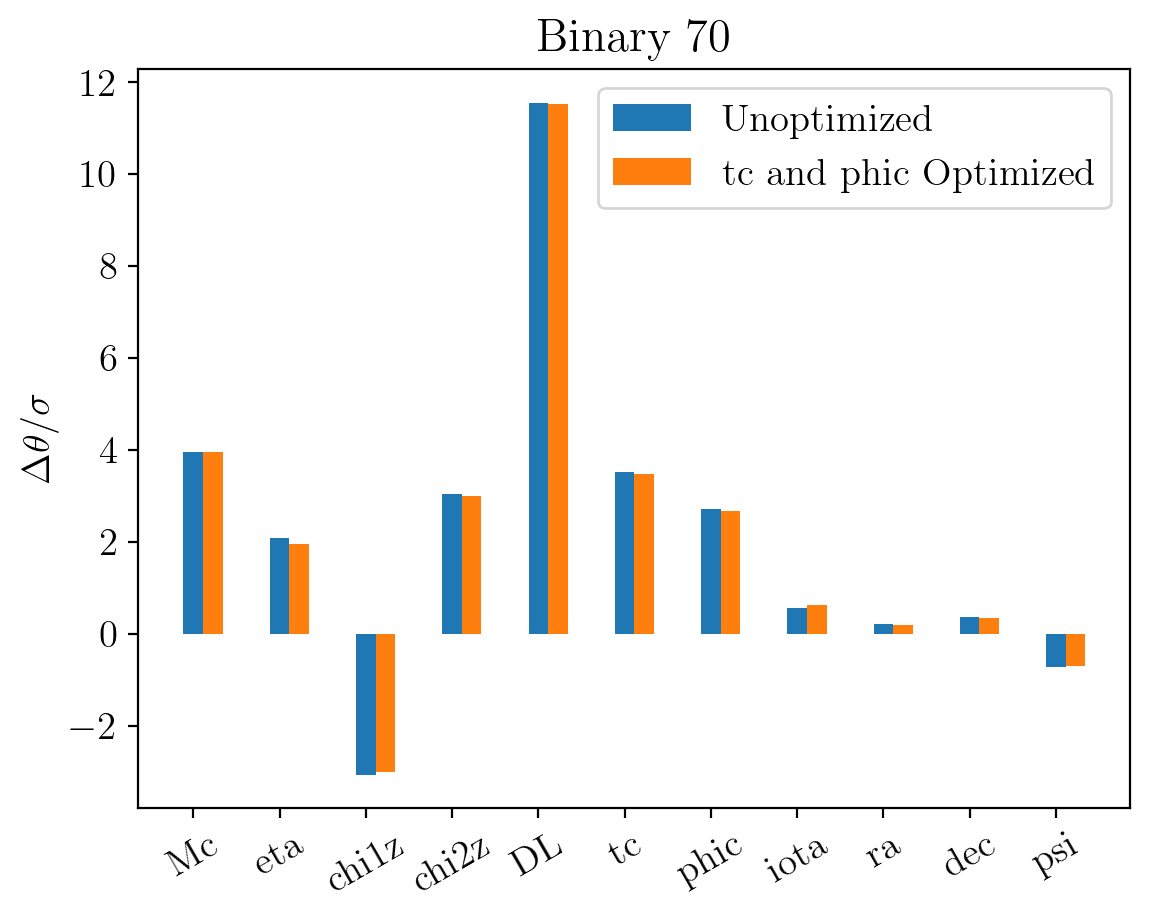

2023-10-17 10:34:15,074 - Network - INFO : Polarizations calculated.
2023-10-17 10:34:15,074 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:34:15,085 - Network - INFO : Polarizations calculated.


######  Binary 71  ######


2023-10-17 10:34:17,548 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:34:17,592 - Network - INFO : PSDs loaded.
2023-10-17 10:34:17,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:34:17,634 - Network - INFO : Detector responses calculated.
2023-10-17 10:34:17,634 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:34:17,635 - Network - INFO :    CE-40_C
2023-10-17 10:34:19,296 - Network - INFO :    CE-20_S
2023-10-17 10:34:20,890 - Network - INFO :    ET_ET1
2023-10-17 10:34:22,486 - Network - INFO :    ET_ET2
2023-10-17 10:34:24,057 - Network - INFO :    ET_ET3
2023-10-17 10:34:25,645 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:34:25,648 - Network - INFO : SNRs calculated.
2023-10-17 10:34:25,649 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:34:25,649 - Network - INFO :    CE-40_C
2023-10-17 10:34:25,709 - Network - INFO :

Mc bias diff: 3.84%
Mc, not: -0.890 sigma
Mc, opt: -0.855 sigma

eta bias diff: 3.32%
eta, not: 1.202 sigma
eta, opt: 1.163 sigma

chi1z bias diff: 3.16%
chi1z, not: -1.101 sigma
chi1z, opt: -1.066 sigma

chi2z bias diff: 3.26%
chi2z, not: 1.068 sigma
chi2z, opt: 1.033 sigma

DL bias diff: 0.36%
DL, not: 17.483 sigma
DL, opt: 17.420 sigma

tc bias diff: 3.32%
tc, not: 1.053 sigma
tc, opt: 1.018 sigma

phic bias diff: 2.81%
phic, not: 0.927 sigma
phic, opt: 0.901 sigma

iota bias diff: -126.89%
iota, not: 0.054 sigma
iota, opt: 0.123 sigma

ra bias diff: 277.27%
ra, not: 0.025 sigma
ra, opt: -0.045 sigma

dec bias diff: 226.61%
dec, not: 0.036 sigma
dec, opt: -0.046 sigma

psi bias diff: 23.74%
psi, not: -0.052 sigma
psi, opt: -0.039 sigma

######  Binary 72  ######


2023-10-17 10:34:37,593 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:34:37,662 - Network - INFO : PSDs loaded.
2023-10-17 10:34:37,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:34:37,703 - Network - INFO : Detector responses calculated.
2023-10-17 10:34:37,704 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:34:37,704 - Network - INFO :    CE-40_C
2023-10-17 10:34:38,435 - Network - INFO :    CE-20_S
2023-10-17 10:34:39,166 - Network - INFO :    ET_ET1
2023-10-17 10:34:39,892 - Network - INFO :    ET_ET2
2023-10-17 10:34:40,622 - Network - INFO :    ET_ET3
2023-10-17 10:34:41,362 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:34:41,366 - Network - INFO : SNRs calculated.
2023-10-17 10:34:41,366 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:34:41,367 - Network - INFO :    CE-40_C
2023-10-17 10:34:41,439 - Network - INFO :

Mc bias diff: -1.70%
Mc, not: 5.829 sigma
Mc, opt: 5.928 sigma

eta bias diff: 1.40%
eta, not: 9.031 sigma
eta, opt: 8.905 sigma

chi1z bias diff: 0.79%
chi1z, not: -11.738 sigma
chi1z, opt: -11.645 sigma

chi2z bias diff: 0.74%
chi2z, not: 12.008 sigma
chi2z, opt: 11.919 sigma

DL bias diff: 86.96%
DL, not: 3.266 sigma
DL, opt: 0.426 sigma

tc bias diff: 0.71%
tc, not: 11.934 sigma
tc, opt: 11.849 sigma

phic bias diff: 6.83%
phic, not: 4.528 sigma
phic, opt: 4.219 sigma

iota bias diff: 12334.56%
iota, not: -0.074 sigma
iota, opt: 9.083 sigma

ra bias diff: -127.27%
ra, not: 0.523 sigma
ra, opt: 1.190 sigma

dec bias diff: -153.13%
dec, not: 0.680 sigma
dec, opt: 1.721 sigma

psi bias diff: -17.61%
psi, not: -0.403 sigma
psi, opt: -0.474 sigma

######  Binary 73  ######


2023-10-17 10:34:48,860 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:34:48,903 - Network - INFO : PSDs loaded.
2023-10-17 10:34:48,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:34:48,940 - Network - INFO : Detector responses calculated.
2023-10-17 10:34:48,941 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:34:48,942 - Network - INFO :    CE-40_C
2023-10-17 10:34:50,219 - Network - INFO :    CE-20_S
2023-10-17 10:34:51,474 - Network - INFO :    ET_ET1
2023-10-17 10:34:52,775 - Network - INFO :    ET_ET2
2023-10-17 10:34:54,061 - Network - INFO :    ET_ET3
2023-10-17 10:34:55,338 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:34:55,341 - Network - INFO : SNRs calculated.
2023-10-17 10:34:55,342 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:34:55,342 - Network - INFO :    CE-40_C
2023-10-17 10:34:55,399 - Network - INFO :

Mc bias diff: 6.02%
Mc, not: 0.375 sigma
Mc, opt: 0.352 sigma

eta bias diff: -0.83%
eta, not: 1.941 sigma
eta, opt: 1.957 sigma

chi1z bias diff: 0.98%
chi1z, not: -1.975 sigma
chi1z, opt: -1.956 sigma

chi2z bias diff: 0.74%
chi2z, not: 1.952 sigma
chi2z, opt: 1.938 sigma

DL bias diff: 0.33%
DL, not: 14.936 sigma
DL, opt: 14.886 sigma

tc bias diff: 2.10%
tc, not: 1.762 sigma
tc, opt: 1.725 sigma

phic bias diff: 0.46%
phic, not: 1.538 sigma
phic, opt: 1.531 sigma

iota bias diff: -15.98%
iota, not: -0.429 sigma
iota, opt: -0.497 sigma

ra bias diff: -31.61%
ra, not: -0.088 sigma
ra, opt: -0.116 sigma

dec bias diff: -24.89%
dec, not: 0.097 sigma
dec, opt: 0.121 sigma

psi bias diff: -12.13%
psi, not: -0.430 sigma
psi, opt: -0.482 sigma

######  Binary 74  ######


2023-10-17 10:35:07,142 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:35:07,184 - Network - INFO : PSDs loaded.
2023-10-17 10:35:07,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:35:07,225 - Network - INFO : Detector responses calculated.
2023-10-17 10:35:07,226 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:35:07,226 - Network - INFO :    CE-40_C
2023-10-17 10:35:08,732 - Network - INFO :    CE-20_S
2023-10-17 10:35:10,174 - Network - INFO :    ET_ET1
2023-10-17 10:35:11,726 - Network - INFO :    ET_ET2
2023-10-17 10:35:13,238 - Network - INFO :    ET_ET3
2023-10-17 10:35:14,694 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:35:14,698 - Network - INFO : SNRs calculated.
2023-10-17 10:35:14,698 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:35:14,699 - Network - INFO :    CE-40_C
2023-10-17 10:35:14,758 - Network - INFO :

Mc bias diff: 7.62%
Mc, not: -4.041 sigma
Mc, opt: -3.733 sigma

eta bias diff: 8.99%
eta, not: 3.832 sigma
eta, opt: 3.488 sigma

chi1z bias diff: 15.83%
chi1z, not: -2.083 sigma
chi1z, opt: -1.754 sigma

chi2z bias diff: 16.97%
chi2z, not: 1.904 sigma
chi2z, opt: 1.581 sigma

DL bias diff: 0.54%
DL, not: 29.546 sigma
DL, opt: 29.386 sigma

tc bias diff: 15.73%
tc, not: 2.125 sigma
tc, opt: 1.791 sigma

phic bias diff: 6.79%
phic, not: 3.874 sigma
phic, opt: 3.611 sigma

iota bias diff: -155.05%
iota, not: -0.128 sigma
iota, opt: -0.325 sigma

ra bias diff: -68.66%
ra, not: 0.053 sigma
ra, opt: 0.090 sigma

dec bias diff: 28.50%
dec, not: 0.343 sigma
dec, opt: 0.245 sigma

psi bias diff: -158.73%
psi, not: -0.367 sigma
psi, opt: -0.951 sigma

######  Binary 75  ######


2023-10-17 10:35:27,361 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:35:27,404 - Network - INFO : PSDs loaded.
2023-10-17 10:35:27,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:35:27,445 - Network - INFO : Detector responses calculated.
2023-10-17 10:35:27,446 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:35:27,446 - Network - INFO :    CE-40_C
2023-10-17 10:35:29,012 - Network - INFO :    CE-20_S
2023-10-17 10:35:30,488 - Network - INFO :    ET_ET1
2023-10-17 10:35:31,963 - Network - INFO :    ET_ET2
2023-10-17 10:35:33,450 - Network - INFO :    ET_ET3
2023-10-17 10:35:34,944 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:35:34,947 - Network - INFO : SNRs calculated.
2023-10-17 10:35:34,948 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:35:34,948 - Network - INFO :    CE-40_C
2023-10-17 10:35:35,008 - Network - INFO :

Mc bias diff: -58.94%
Mc, not: 0.025 sigma
Mc, opt: 0.040 sigma

eta bias diff: -3.70%
eta, not: -0.559 sigma
eta, opt: -0.580 sigma

chi1z bias diff: -1.16%
chi1z, not: 2.297 sigma
chi1z, opt: 2.324 sigma

chi2z bias diff: -0.91%
chi2z, not: -2.229 sigma
chi2z, opt: -2.249 sigma

DL bias diff: 0.06%
DL, not: 42.521 sigma
DL, opt: 42.496 sigma

tc bias diff: -1.71%
tc, not: -1.522 sigma
tc, opt: -1.548 sigma

phic bias diff: 3.98%
phic, not: 0.519 sigma
phic, opt: 0.498 sigma

iota bias diff: -7.42%
iota, not: -0.044 sigma
iota, opt: -0.047 sigma

ra bias diff: 3.11%
ra, not: 0.043 sigma
ra, opt: 0.042 sigma

dec bias diff: -31.82%
dec, not: -0.045 sigma
dec, opt: -0.059 sigma

psi bias diff: -3.60%
psi, not: -0.227 sigma
psi, opt: -0.236 sigma

######  Binary 76  ######


2023-10-17 10:35:49,409 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:35:49,530 - Network - INFO : PSDs loaded.
2023-10-17 10:35:49,533 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:35:49,587 - Network - INFO : Detector responses calculated.
2023-10-17 10:35:49,588 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:35:49,588 - Network - INFO :    CE-40_C
2023-10-17 10:35:51,882 - Network - INFO :    CE-20_S
2023-10-17 10:35:54,176 - Network - INFO :    ET_ET1
2023-10-17 10:35:56,443 - Network - INFO :    ET_ET2
2023-10-17 10:35:58,714 - Network - INFO :    ET_ET3
2023-10-17 10:36:00,994 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:36:00,999 - Network - INFO : SNRs calculated.
2023-10-17 10:36:00,999 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:36:00,999 - Network - INFO :    CE-40_C
2023-10-17 10:36:01,070 - Network - INFO :

Mc bias diff: 0.06%
Mc, not: -1.875 sigma
Mc, opt: -1.874 sigma

eta bias diff: -0.21%
eta, not: 1.619 sigma
eta, opt: 1.622 sigma

chi1z bias diff: 0.09%
chi1z, not: -1.144 sigma
chi1z, opt: -1.143 sigma

chi2z bias diff: -0.64%
chi2z, not: 1.078 sigma
chi2z, opt: 1.085 sigma

DL bias diff: 0.06%
DL, not: 20.810 sigma
DL, opt: 20.798 sigma

tc bias diff: -0.15%
tc, not: 1.095 sigma
tc, opt: 1.097 sigma

phic bias diff: 0.38%
phic, not: 2.668 sigma
phic, opt: 2.658 sigma

iota bias diff: 29.65%
iota, not: -0.087 sigma
iota, opt: -0.061 sigma

ra bias diff: 1.85%
ra, not: 0.144 sigma
ra, opt: 0.141 sigma

dec bias diff: 3.33%
dec, not: -0.135 sigma
dec, opt: -0.130 sigma

psi bias diff: -2.88%
psi, not: -0.269 sigma
psi, opt: -0.276 sigma

######  Binary 77  ######


2023-10-17 10:36:20,894 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:36:20,937 - Network - INFO : PSDs loaded.
2023-10-17 10:36:20,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:36:20,999 - Network - INFO : Detector responses calculated.
2023-10-17 10:36:20,999 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:36:21,000 - Network - INFO :    CE-40_C
2023-10-17 10:36:23,524 - Network - INFO :    CE-20_S
2023-10-17 10:36:26,046 - Network - INFO :    ET_ET1
2023-10-17 10:36:28,561 - Network - INFO :    ET_ET2
2023-10-17 10:36:31,106 - Network - INFO :    ET_ET3
2023-10-17 10:36:33,661 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:36:33,666 - Network - INFO : SNRs calculated.
2023-10-17 10:36:33,667 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:36:33,667 - Network - INFO :    CE-40_C
2023-10-17 10:36:33,741 - Network - INFO :

Mc bias diff: 0.43%
Mc, not: -4.260 sigma
Mc, opt: -4.242 sigma

eta bias diff: 1.00%
eta, not: 3.744 sigma
eta, opt: 3.706 sigma

chi1z bias diff: 0.49%
chi1z, not: -2.805 sigma
chi1z, opt: -2.791 sigma

chi2z bias diff: -0.36%
chi2z, not: 2.629 sigma
chi2z, opt: 2.638 sigma

DL bias diff: 1.34%
DL, not: 8.023 sigma
DL, opt: 7.916 sigma

tc bias diff: 0.53%
tc, not: 2.652 sigma
tc, opt: 2.638 sigma

phic bias diff: -2.05%
phic, not: 2.141 sigma
phic, opt: 2.185 sigma

iota bias diff: -25.24%
iota, not: 0.868 sigma
iota, opt: 1.087 sigma

ra bias diff: -24.77%
ra, not: -0.183 sigma
ra, opt: -0.229 sigma

dec bias diff: -62.69%
dec, not: -0.025 sigma
dec, opt: -0.040 sigma

psi bias diff: -9.31%
psi, not: 0.526 sigma
psi, opt: 0.575 sigma

######  Binary 78  ######


2023-10-17 10:36:54,390 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:36:54,433 - Network - INFO : PSDs loaded.
2023-10-17 10:36:54,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:36:54,482 - Network - INFO : Detector responses calculated.
2023-10-17 10:36:54,483 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:36:54,483 - Network - INFO :    CE-40_C
2023-10-17 10:36:56,402 - Network - INFO :    CE-20_S
2023-10-17 10:36:58,319 - Network - INFO :    ET_ET1
2023-10-17 10:37:00,213 - Network - INFO :    ET_ET2
2023-10-17 10:37:02,150 - Network - INFO :    ET_ET3
2023-10-17 10:37:04,060 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:37:04,065 - Network - INFO : SNRs calculated.
2023-10-17 10:37:04,065 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:37:04,066 - Network - INFO :    CE-40_C
2023-10-17 10:37:04,132 - Network - INFO :

Mc bias diff: 0.46%
Mc, not: -1.896 sigma
Mc, opt: -1.887 sigma

eta bias diff: 0.44%
eta, not: 1.796 sigma
eta, opt: 1.788 sigma

chi1z bias diff: 0.47%
chi1z, not: -1.515 sigma
chi1z, opt: -1.507 sigma

chi2z bias diff: 0.57%
chi2z, not: 1.462 sigma
chi2z, opt: 1.454 sigma

DL bias diff: 0.06%
DL, not: 15.804 sigma
DL, opt: 15.795 sigma

tc bias diff: 0.54%
tc, not: 1.464 sigma
tc, opt: 1.456 sigma

phic bias diff: 0.27%
phic, not: 2.113 sigma
phic, opt: 2.108 sigma

iota bias diff: -3.23%
iota, not: 0.240 sigma
iota, opt: 0.248 sigma

ra bias diff: -4.57%
ra, not: 0.047 sigma
ra, opt: 0.049 sigma

dec bias diff: -1.58%
dec, not: -0.014 sigma
dec, opt: -0.015 sigma

psi bias diff: -0.97%
psi, not: 0.138 sigma
psi, opt: 0.139 sigma

######  Binary 79  ######


2023-10-17 10:37:20,062 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:37:20,106 - Network - INFO : PSDs loaded.
2023-10-17 10:37:20,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:37:20,151 - Network - INFO : Detector responses calculated.
2023-10-17 10:37:20,151 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:37:20,152 - Network - INFO :    CE-40_C
2023-10-17 10:37:21,648 - Network - INFO :    CE-20_S
2023-10-17 10:37:23,198 - Network - INFO :    ET_ET1
2023-10-17 10:37:24,752 - Network - INFO :    ET_ET2
2023-10-17 10:37:26,279 - Network - INFO :    ET_ET3
2023-10-17 10:37:27,913 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:37:27,917 - Network - INFO : SNRs calculated.
2023-10-17 10:37:27,918 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:37:27,918 - Network - INFO :    CE-40_C
2023-10-17 10:37:27,979 - Network - INFO :

Mc bias diff: 12.55%
Mc, not: -1.889 sigma
Mc, opt: -1.652 sigma

eta bias diff: 37.22%
eta, not: 1.880 sigma
eta, opt: 1.180 sigma

chi1z bias diff: 54.43%
chi1z, not: -1.519 sigma
chi1z, opt: -0.692 sigma

chi2z bias diff: 59.80%
chi2z, not: 1.427 sigma
chi2z, opt: 0.574 sigma

DL bias diff: 7.73%
DL, not: 17.481 sigma
DL, opt: 16.130 sigma

tc bias diff: 58.37%
tc, not: 1.432 sigma
tc, opt: 0.596 sigma

phic bias diff: 18.06%
phic, not: 1.981 sigma
phic, opt: 1.623 sigma

iota bias diff: -2836.65%
iota, not: -0.027 sigma
iota, opt: -0.788 sigma

ra bias diff: 1083.38%
ra, not: -0.044 sigma
ra, opt: 0.434 sigma

dec bias diff: -2903.27%
dec, not: -0.045 sigma
dec, opt: -1.348 sigma

psi bias diff: 33.84%
psi, not: 0.105 sigma
psi, opt: 0.070 sigma

######  Binary 80  ######


2023-10-17 10:37:42,955 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:37:43,074 - Network - INFO : PSDs loaded.
2023-10-17 10:37:43,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:37:43,117 - Network - INFO : Detector responses calculated.
2023-10-17 10:37:43,118 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:37:43,119 - Network - INFO :    CE-40_C
2023-10-17 10:37:44,600 - Network - INFO :    CE-20_S
2023-10-17 10:37:46,103 - Network - INFO :    ET_ET1
2023-10-17 10:37:47,540 - Network - INFO :    ET_ET2
2023-10-17 10:37:49,192 - Network - INFO :    ET_ET3
2023-10-17 10:37:50,957 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:37:50,961 - Network - INFO : SNRs calculated.
2023-10-17 10:37:50,961 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:37:50,962 - Network - INFO :    CE-40_C
2023-10-17 10:37:51,021 - Network - INFO :

Mc bias diff: -10.70%
Mc, not: 0.105 sigma
Mc, opt: 0.116 sigma

eta bias diff: 16.10%
eta, not: 0.346 sigma
eta, opt: 0.290 sigma

chi1z bias diff: 91.25%
chi1z, not: -0.089 sigma
chi1z, opt: -0.008 sigma

chi2z bias diff: 96.59%
chi2z, not: 0.080 sigma
chi2z, opt: 0.003 sigma

DL bias diff: 8.73%
DL, not: 3.604 sigma
DL, opt: 3.290 sigma

tc bias diff: -1006.16%
tc, not: -0.008 sigma
tc, opt: -0.084 sigma

phic bias diff: -5.05%
phic, not: 0.693 sigma
phic, opt: 0.728 sigma

iota bias diff: -233.89%
iota, not: 0.254 sigma
iota, opt: 0.849 sigma

ra bias diff: -135.44%
ra, not: 0.153 sigma
ra, opt: 0.361 sigma

dec bias diff: -91.09%
dec, not: 0.231 sigma
dec, opt: 0.442 sigma

psi bias diff: -9.30%
psi, not: 0.582 sigma
psi, opt: 0.636 sigma



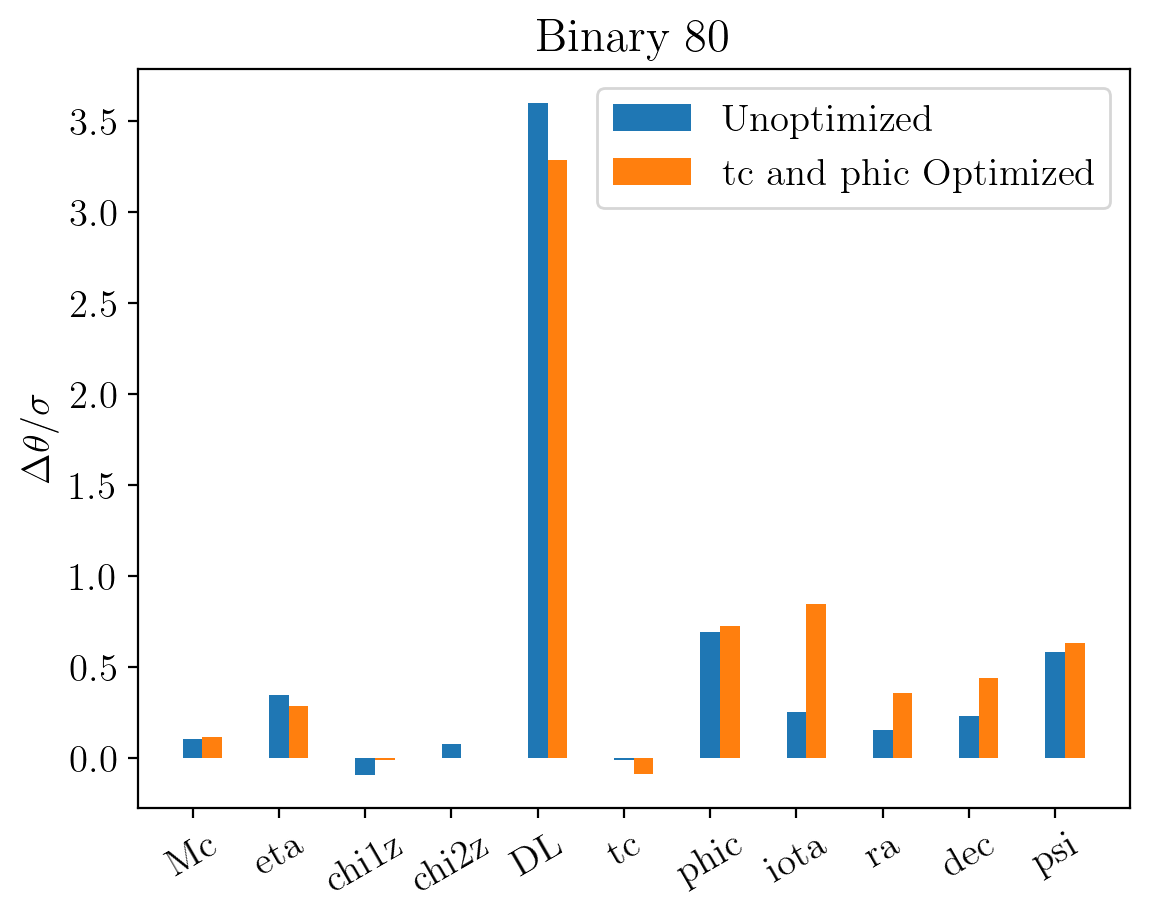

2023-10-17 10:38:03,807 - Network - INFO : Polarizations calculated.
2023-10-17 10:38:03,808 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:38:03,819 - Network - INFO : Polarizations calculated.


######  Binary 81  ######


2023-10-17 10:38:06,395 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:38:06,439 - Network - INFO : PSDs loaded.
2023-10-17 10:38:06,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:38:06,484 - Network - INFO : Detector responses calculated.
2023-10-17 10:38:06,485 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:38:06,486 - Network - INFO :    CE-40_C
2023-10-17 10:38:08,347 - Network - INFO :    CE-20_S
2023-10-17 10:38:10,143 - Network - INFO :    ET_ET1
2023-10-17 10:38:11,835 - Network - INFO :    ET_ET2
2023-10-17 10:38:13,886 - Network - INFO :    ET_ET3
2023-10-17 10:38:15,958 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:38:15,962 - Network - INFO : SNRs calculated.
2023-10-17 10:38:15,962 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:38:15,963 - Network - INFO :    CE-40_C
2023-10-17 10:38:16,025 - Network - INFO :

Mc bias diff: -0.00%
Mc, not: -1.715 sigma
Mc, opt: -1.715 sigma

eta bias diff: 0.22%
eta, not: 1.802 sigma
eta, opt: 1.798 sigma

chi1z bias diff: 0.40%
chi1z, not: -1.546 sigma
chi1z, opt: -1.540 sigma

chi2z bias diff: 0.27%
chi2z, not: 1.476 sigma
chi2z, opt: 1.472 sigma

DL bias diff: 0.09%
DL, not: 21.994 sigma
DL, opt: 21.975 sigma

tc bias diff: 0.47%
tc, not: 1.471 sigma
tc, opt: 1.464 sigma

phic bias diff: 0.42%
phic, not: 2.258 sigma
phic, opt: 2.249 sigma

iota bias diff: -16.17%
iota, not: 0.147 sigma
iota, opt: 0.171 sigma

ra bias diff: -7.90%
ra, not: 0.174 sigma
ra, opt: 0.188 sigma

dec bias diff: -7.29%
dec, not: -0.172 sigma
dec, opt: -0.185 sigma

psi bias diff: -0.28%
psi, not: -0.364 sigma
psi, opt: -0.365 sigma

######  Binary 82  ######


2023-10-17 10:38:32,263 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:38:32,305 - Network - INFO : PSDs loaded.
2023-10-17 10:38:32,308 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:38:32,343 - Network - INFO : Detector responses calculated.
2023-10-17 10:38:32,343 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:38:32,344 - Network - INFO :    CE-40_C
2023-10-17 10:38:33,673 - Network - INFO :    CE-20_S
2023-10-17 10:38:34,948 - Network - INFO :    ET_ET1
2023-10-17 10:38:36,286 - Network - INFO :    ET_ET2
2023-10-17 10:38:37,580 - Network - INFO :    ET_ET3
2023-10-17 10:38:38,869 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:38:38,873 - Network - INFO : SNRs calculated.
2023-10-17 10:38:38,873 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:38:38,873 - Network - INFO :    CE-40_C
2023-10-17 10:38:38,930 - Network - INFO :

Mc bias diff: 1.31%
Mc, not: -2.496 sigma
Mc, opt: -2.464 sigma

eta bias diff: 5.21%
eta, not: 3.530 sigma
eta, opt: 3.346 sigma

chi1z bias diff: 10.80%
chi1z, not: -2.344 sigma
chi1z, opt: -2.091 sigma

chi2z bias diff: 12.01%
chi2z, not: 2.139 sigma
chi2z, opt: 1.882 sigma

DL bias diff: 37.85%
DL, not: 3.078 sigma
DL, opt: 1.913 sigma

tc bias diff: 11.44%
tc, not: 2.240 sigma
tc, opt: 1.984 sigma

phic bias diff: 926.85%
phic, not: 0.037 sigma
phic, opt: -0.306 sigma

iota bias diff: -504.90%
iota, not: -0.800 sigma
iota, opt: -4.840 sigma

ra bias diff: -567.69%
ra, not: -0.024 sigma
ra, opt: -0.163 sigma

dec bias diff: 174.79%
dec, not: 0.087 sigma
dec, opt: -0.065 sigma

psi bias diff: -102.45%
psi, not: 0.310 sigma
psi, opt: 0.627 sigma

######  Binary 83  ######


2023-10-17 10:38:52,300 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:38:52,344 - Network - INFO : PSDs loaded.
2023-10-17 10:38:52,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:38:52,381 - Network - INFO : Detector responses calculated.
2023-10-17 10:38:52,381 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:38:52,382 - Network - INFO :    CE-40_C
2023-10-17 10:38:53,916 - Network - INFO :    CE-20_S
2023-10-17 10:38:55,168 - Network - INFO :    ET_ET1
2023-10-17 10:38:56,532 - Network - INFO :    ET_ET2
2023-10-17 10:38:57,837 - Network - INFO :    ET_ET3
2023-10-17 10:38:59,167 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:38:59,170 - Network - INFO : SNRs calculated.
2023-10-17 10:38:59,171 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:38:59,171 - Network - INFO :    CE-40_C
2023-10-17 10:38:59,234 - Network - INFO :

Mc bias diff: 3.50%
Mc, not: 1.007 sigma
Mc, opt: 0.972 sigma

eta bias diff: 2.76%
eta, not: 4.581 sigma
eta, opt: 4.455 sigma

chi1z bias diff: 3.67%
chi1z, not: -4.381 sigma
chi1z, opt: -4.220 sigma

chi2z bias diff: 3.88%
chi2z, not: 4.354 sigma
chi2z, opt: 4.185 sigma

DL bias diff: 2.77%
DL, not: 16.905 sigma
DL, opt: 16.436 sigma

tc bias diff: 3.70%
tc, not: 4.367 sigma
tc, opt: 4.206 sigma

phic bias diff: -2.19%
phic, not: 2.947 sigma
phic, opt: 3.011 sigma

iota bias diff: 241.82%
iota, not: -0.334 sigma
iota, opt: 0.473 sigma

ra bias diff: 278.80%
ra, not: -0.079 sigma
ra, opt: 0.140 sigma

dec bias diff: 145.98%
dec, not: -0.119 sigma
dec, opt: 0.055 sigma

psi bias diff: -19.78%
psi, not: 1.328 sigma
psi, opt: 1.591 sigma

######  Binary 84  ######


2023-10-17 10:39:12,107 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:39:12,149 - Network - INFO : PSDs loaded.
2023-10-17 10:39:12,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:39:12,192 - Network - INFO : Detector responses calculated.
2023-10-17 10:39:12,193 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:39:12,193 - Network - INFO :    CE-40_C
2023-10-17 10:39:13,785 - Network - INFO :    CE-20_S
2023-10-17 10:39:15,298 - Network - INFO :    ET_ET1
2023-10-17 10:39:16,813 - Network - INFO :    ET_ET2
2023-10-17 10:39:18,314 - Network - INFO :    ET_ET3
2023-10-17 10:39:19,823 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:39:19,827 - Network - INFO : SNRs calculated.
2023-10-17 10:39:19,827 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:39:19,828 - Network - INFO :    CE-40_C
2023-10-17 10:39:19,888 - Network - INFO :

Mc bias diff: -2.41%
Mc, not: -1.579 sigma
Mc, opt: -1.617 sigma

eta bias diff: 7.83%
eta, not: 1.958 sigma
eta, opt: 1.804 sigma

chi1z bias diff: 10.52%
chi1z, not: -1.871 sigma
chi1z, opt: -1.674 sigma

chi2z bias diff: 11.43%
chi2z, not: 1.830 sigma
chi2z, opt: 1.620 sigma

DL bias diff: 9.92%
DL, not: 12.098 sigma
DL, opt: 10.898 sigma

tc bias diff: 11.20%
tc, not: 1.836 sigma
tc, opt: 1.630 sigma

phic bias diff: 2.35%
phic, not: 2.105 sigma
phic, opt: 2.056 sigma

iota bias diff: 1309.74%
iota, not: -0.219 sigma
iota, opt: 2.648 sigma

ra bias diff: -140.19%
ra, not: -0.223 sigma
ra, opt: -0.536 sigma

dec bias diff: -140.60%
dec, not: 0.257 sigma
dec, opt: 0.619 sigma

psi bias diff: -733.97%
psi, not: -0.013 sigma
psi, opt: -0.109 sigma

######  Binary 85  ######


2023-10-17 10:39:32,967 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:39:33,035 - Network - INFO : PSDs loaded.
2023-10-17 10:39:33,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:39:33,069 - Network - INFO : Detector responses calculated.
2023-10-17 10:39:33,069 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:39:33,070 - Network - INFO :    CE-40_C
2023-10-17 10:39:34,016 - Network - INFO :    CE-20_S
2023-10-17 10:39:34,900 - Network - INFO :    ET_ET1
2023-10-17 10:39:35,804 - Network - INFO :    ET_ET2
2023-10-17 10:39:36,704 - Network - INFO :    ET_ET3
2023-10-17 10:39:37,584 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:39:37,587 - Network - INFO : SNRs calculated.
2023-10-17 10:39:37,587 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:39:37,588 - Network - INFO :    CE-40_C
2023-10-17 10:39:37,644 - Network - INFO :

Mc bias diff: -0.12%
Mc, not: 1.927 sigma
Mc, opt: 1.929 sigma

eta bias diff: 0.41%
eta, not: 3.072 sigma
eta, opt: 3.059 sigma

chi1z bias diff: 0.39%
chi1z, not: -3.442 sigma
chi1z, opt: -3.428 sigma

chi2z bias diff: 0.38%
chi2z, not: 3.449 sigma
chi2z, opt: 3.436 sigma

DL bias diff: 101.23%
DL, not: 0.541 sigma
DL, opt: -0.007 sigma

tc bias diff: 0.37%
tc, not: 3.417 sigma
tc, opt: 3.405 sigma

phic bias diff: 49.66%
phic, not: 0.243 sigma
phic, opt: 0.123 sigma

iota bias diff: -3097.27%
iota, not: 0.462 sigma
iota, opt: 14.767 sigma

ra bias diff: -470.99%
ra, not: -0.083 sigma
ra, opt: -0.473 sigma

dec bias diff: 211.46%
dec, not: 0.136 sigma
dec, opt: -0.152 sigma

psi bias diff: -1669.82%
psi, not: -0.007 sigma
psi, opt: -0.131 sigma

######  Binary 86  ######


2023-10-17 10:39:46,215 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:39:46,257 - Network - INFO : PSDs loaded.
2023-10-17 10:39:46,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:39:46,292 - Network - INFO : Detector responses calculated.
2023-10-17 10:39:46,293 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:39:46,294 - Network - INFO :    CE-40_C
2023-10-17 10:39:47,478 - Network - INFO :    CE-20_S
2023-10-17 10:39:48,712 - Network - INFO :    ET_ET1
2023-10-17 10:39:49,928 - Network - INFO :    ET_ET2
2023-10-17 10:39:51,161 - Network - INFO :    ET_ET3
2023-10-17 10:39:52,393 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:39:52,396 - Network - INFO : SNRs calculated.
2023-10-17 10:39:52,397 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:39:52,397 - Network - INFO :    CE-40_C
2023-10-17 10:39:52,462 - Network - INFO :

Mc bias diff: -20.56%
Mc, not: 0.894 sigma
Mc, opt: 1.078 sigma

eta bias diff: 5.66%
eta, not: 1.230 sigma
eta, opt: 1.160 sigma

chi1z bias diff: -1.90%
chi1z, not: -1.472 sigma
chi1z, opt: -1.500 sigma

chi2z bias diff: -3.22%
chi2z, not: 1.504 sigma
chi2z, opt: 1.553 sigma

DL bias diff: 34.49%
DL, not: 4.323 sigma
DL, opt: 2.832 sigma

tc bias diff: -3.47%
tc, not: 1.500 sigma
tc, opt: 1.552 sigma

phic bias diff: -23.50%
phic, not: 0.618 sigma
phic, opt: 0.763 sigma

iota bias diff: -2888.45%
iota, not: 0.162 sigma
iota, opt: 4.852 sigma

ra bias diff: 133.11%
ra, not: 0.209 sigma
ra, opt: -0.069 sigma

dec bias diff: -175.87%
dec, not: 0.295 sigma
dec, opt: 0.813 sigma

psi bias diff: 52.15%
psi, not: -0.368 sigma
psi, opt: -0.176 sigma

######  Binary 87  ######


2023-10-17 10:40:03,921 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:40:03,963 - Network - INFO : PSDs loaded.
2023-10-17 10:40:03,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:40:04,008 - Network - INFO : Detector responses calculated.
2023-10-17 10:40:04,009 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:40:04,009 - Network - INFO :    CE-40_C
2023-10-17 10:40:05,805 - Network - INFO :    CE-20_S
2023-10-17 10:40:07,470 - Network - INFO :    ET_ET1
2023-10-17 10:40:09,122 - Network - INFO :    ET_ET2
2023-10-17 10:40:10,845 - Network - INFO :    ET_ET3
2023-10-17 10:40:12,523 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:40:12,527 - Network - INFO : SNRs calculated.
2023-10-17 10:40:12,528 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:40:12,528 - Network - INFO :    CE-40_C
2023-10-17 10:40:12,591 - Network - INFO :

Mc bias diff: 0.42%
Mc, not: -5.039 sigma
Mc, opt: -5.018 sigma

eta bias diff: 0.46%
eta, not: 4.813 sigma
eta, opt: 4.791 sigma

chi1z bias diff: 0.53%
chi1z, not: -3.933 sigma
chi1z, opt: -3.912 sigma

chi2z bias diff: 0.59%
chi2z, not: 3.756 sigma
chi2z, opt: 3.734 sigma

DL bias diff: 0.81%
DL, not: 12.113 sigma
DL, opt: 12.014 sigma

tc bias diff: 0.54%
tc, not: 3.806 sigma
tc, opt: 3.786 sigma

phic bias diff: 0.64%
phic, not: 4.245 sigma
phic, opt: 4.218 sigma

iota bias diff: -31.98%
iota, not: -0.574 sigma
iota, opt: -0.757 sigma

ra bias diff: 3.65%
ra, not: -0.037 sigma
ra, opt: -0.036 sigma

dec bias diff: -80.14%
dec, not: -0.089 sigma
dec, opt: -0.161 sigma

psi bias diff: -9.41%
psi, not: 0.281 sigma
psi, opt: 0.308 sigma

######  Binary 88  ######


2023-10-17 10:40:28,418 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:40:28,470 - Network - INFO : PSDs loaded.
2023-10-17 10:40:28,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:40:28,527 - Network - INFO : Detector responses calculated.
2023-10-17 10:40:28,528 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:40:28,528 - Network - INFO :    CE-40_C
2023-10-17 10:40:30,699 - Network - INFO :    CE-20_S
2023-10-17 10:40:32,650 - Network - INFO :    ET_ET1
2023-10-17 10:40:34,553 - Network - INFO :    ET_ET2
2023-10-17 10:40:36,447 - Network - INFO :    ET_ET3
2023-10-17 10:40:38,390 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:40:38,395 - Network - INFO : SNRs calculated.
2023-10-17 10:40:38,395 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:40:38,396 - Network - INFO :    CE-40_C
2023-10-17 10:40:38,461 - Network - INFO :

Mc bias diff: -1.64%
Mc, not: -2.149 sigma
Mc, opt: -2.184 sigma

eta bias diff: -1.67%
eta, not: -5.794 sigma
eta, opt: -5.891 sigma

chi1z bias diff: -8.06%
chi1z, not: 1.456 sigma
chi1z, opt: 1.574 sigma

chi2z bias diff: 17.16%
chi2z, not: -1.880 sigma
chi2z, opt: -1.558 sigma

DL bias diff: 9.68%
DL, not: 5.072 sigma
DL, opt: 4.582 sigma

tc bias diff: -0.85%
tc, not: -5.992 sigma
tc, opt: -6.043 sigma

phic bias diff: -7.53%
phic, not: -0.641 sigma
phic, opt: -0.689 sigma

iota bias diff: -289.67%
iota, not: -0.348 sigma
iota, opt: -1.355 sigma

ra bias diff: -69.20%
ra, not: -0.359 sigma
ra, opt: -0.607 sigma

dec bias diff: -6.30%
dec, not: 0.449 sigma
dec, opt: 0.477 sigma

psi bias diff: -5.65%
psi, not: 0.935 sigma
psi, opt: 0.988 sigma

######  Binary 89  ######


2023-10-17 10:40:53,971 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:40:54,113 - Network - INFO : PSDs loaded.
2023-10-17 10:40:54,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:40:54,143 - Network - INFO : Detector responses calculated.
2023-10-17 10:40:54,144 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:40:54,144 - Network - INFO :    CE-40_C
2023-10-17 10:40:54,996 - Network - INFO :    CE-20_S
2023-10-17 10:40:55,844 - Network - INFO :    ET_ET1
2023-10-17 10:40:56,712 - Network - INFO :    ET_ET2
2023-10-17 10:40:57,589 - Network - INFO :    ET_ET3
2023-10-17 10:40:58,445 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:40:58,448 - Network - INFO : SNRs calculated.
2023-10-17 10:40:58,448 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:40:58,449 - Network - INFO :    CE-40_C
2023-10-17 10:40:58,506 - Network - INFO :

Mc bias diff: 7.94%
Mc, not: -0.756 sigma
Mc, opt: -0.696 sigma

eta bias diff: 0.23%
eta, not: 2.782 sigma
eta, opt: 2.776 sigma

chi1z bias diff: -25.82%
chi1z, not: 0.200 sigma
chi1z, opt: 0.251 sigma

chi2z bias diff: -9.86%
chi2z, not: -0.576 sigma
chi2z, opt: -0.633 sigma

DL bias diff: 58.09%
DL, not: 3.768 sigma
DL, opt: 1.579 sigma

tc bias diff: -14.32%
tc, not: -0.370 sigma
tc, opt: -0.423 sigma

phic bias diff: 86.51%
phic, not: 0.272 sigma
phic, opt: 0.037 sigma

iota bias diff: -425.39%
iota, not: 1.052 sigma
iota, opt: 5.528 sigma

ra bias diff: -119.11%
ra, not: 0.331 sigma
ra, opt: 0.725 sigma

dec bias diff: -247.91%
dec, not: 0.224 sigma
dec, opt: 0.779 sigma

psi bias diff: 1342.91%
psi, not: 0.016 sigma
psi, opt: -0.201 sigma

######  Binary 90  ######


2023-10-17 10:41:07,292 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:41:07,340 - Network - INFO : PSDs loaded.
2023-10-17 10:41:07,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:41:07,379 - Network - INFO : Detector responses calculated.
2023-10-17 10:41:07,380 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:41:07,380 - Network - INFO :    CE-40_C
2023-10-17 10:41:08,743 - Network - INFO :    CE-20_S
2023-10-17 10:41:10,076 - Network - INFO :    ET_ET1
2023-10-17 10:41:11,399 - Network - INFO :    ET_ET2
2023-10-17 10:41:12,727 - Network - INFO :    ET_ET3
2023-10-17 10:41:14,051 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:41:14,055 - Network - INFO : SNRs calculated.
2023-10-17 10:41:14,055 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:41:14,056 - Network - INFO :    CE-40_C
2023-10-17 10:41:14,114 - Network - INFO :

Mc bias diff: -0.01%
Mc, not: 1.052 sigma
Mc, opt: 1.052 sigma

eta bias diff: 9.32%
eta, not: 1.435 sigma
eta, opt: 1.301 sigma

chi1z bias diff: 10.63%
chi1z, not: -1.875 sigma
chi1z, opt: -1.675 sigma

chi2z bias diff: 10.79%
chi2z, not: 1.933 sigma
chi2z, opt: 1.725 sigma

DL bias diff: 79.33%
DL, not: 2.644 sigma
DL, opt: 0.547 sigma

tc bias diff: 11.42%
tc, not: 1.953 sigma
tc, opt: 1.730 sigma

phic bias diff: -44.88%
phic, not: 0.795 sigma
phic, opt: 1.152 sigma

iota bias diff: -3250.55%
iota, not: -0.202 sigma
iota, opt: -6.770 sigma

ra bias diff: 109.56%
ra, not: 0.330 sigma
ra, opt: -0.032 sigma

dec bias diff: 69.19%
dec, not: -0.267 sigma
dec, opt: -0.082 sigma

psi bias diff: -128.44%
psi, not: -0.398 sigma
psi, opt: -0.909 sigma



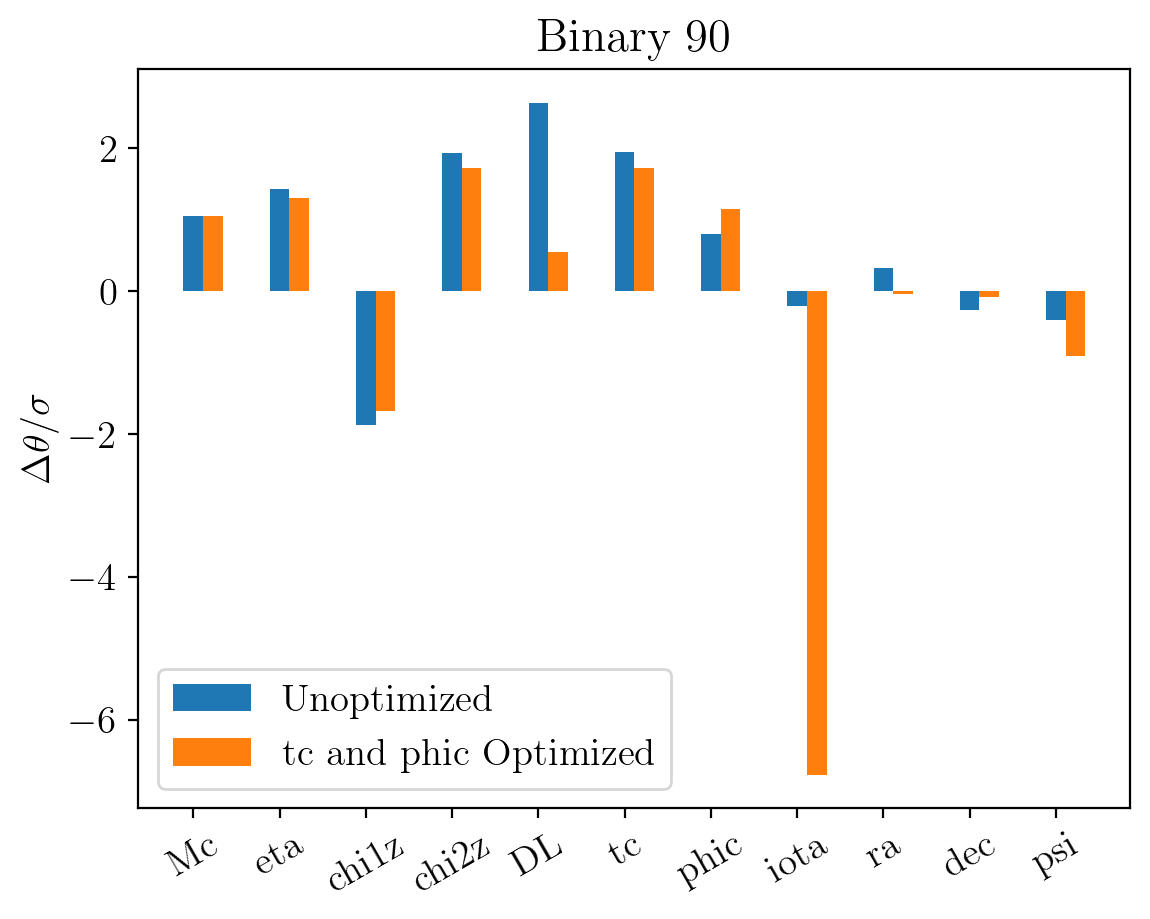

2023-10-17 10:41:23,621 - Network - INFO : Polarizations calculated.
2023-10-17 10:41:23,622 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 10:41:23,630 - Network - INFO : Polarizations calculated.


######  Binary 91  ######


2023-10-17 10:41:25,567 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:41:25,612 - Network - INFO : PSDs loaded.
2023-10-17 10:41:25,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:41:25,647 - Network - INFO : Detector responses calculated.
2023-10-17 10:41:25,648 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:41:25,649 - Network - INFO :    CE-40_C
2023-10-17 10:41:26,918 - Network - INFO :    CE-20_S
2023-10-17 10:41:28,108 - Network - INFO :    ET_ET1
2023-10-17 10:41:29,323 - Network - INFO :    ET_ET2
2023-10-17 10:41:30,531 - Network - INFO :    ET_ET3
2023-10-17 10:41:31,812 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:41:31,816 - Network - INFO : SNRs calculated.
2023-10-17 10:41:31,817 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:41:31,817 - Network - INFO :    CE-40_C
2023-10-17 10:41:31,878 - Network - INFO :

Mc bias diff: -1.45%
Mc, not: 3.375 sigma
Mc, opt: 3.423 sigma

eta bias diff: -2.69%
eta, not: 2.051 sigma
eta, opt: 2.106 sigma

chi1z bias diff: -2.76%
chi1z, not: -2.806 sigma
chi1z, opt: -2.883 sigma

chi2z bias diff: -2.56%
chi2z, not: 2.887 sigma
chi2z, opt: 2.961 sigma

DL bias diff: -144.21%
DL, not: 0.253 sigma
DL, opt: 0.618 sigma

tc bias diff: -2.75%
tc, not: 2.860 sigma
tc, opt: 2.939 sigma

phic bias diff: 521.91%
phic, not: -0.036 sigma
phic, opt: 0.152 sigma

iota bias diff: -520.15%
iota, not: 1.363 sigma
iota, opt: 8.455 sigma

ra bias diff: 3.91%
ra, not: 1.198 sigma
ra, opt: 1.151 sigma

dec bias diff: -5.44%
dec, not: -0.976 sigma
dec, opt: -1.029 sigma

psi bias diff: 445.15%
psi, not: -0.044 sigma
psi, opt: 0.152 sigma

######  Binary 92  ######


2023-10-17 10:41:41,902 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:41:41,971 - Network - INFO : PSDs loaded.
2023-10-17 10:41:41,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:41:42,005 - Network - INFO : Detector responses calculated.
2023-10-17 10:41:42,006 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:41:42,007 - Network - INFO :    CE-40_C
2023-10-17 10:41:42,791 - Network - INFO :    CE-20_S
2023-10-17 10:41:43,585 - Network - INFO :    ET_ET1
2023-10-17 10:41:44,372 - Network - INFO :    ET_ET2
2023-10-17 10:41:45,163 - Network - INFO :    ET_ET3
2023-10-17 10:41:45,956 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:41:45,960 - Network - INFO : SNRs calculated.
2023-10-17 10:41:45,961 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:41:45,961 - Network - INFO :    CE-40_C
2023-10-17 10:41:46,027 - Network - INFO :

Mc bias diff: -2.40%
Mc, not: 8.531 sigma
Mc, opt: 8.736 sigma

eta bias diff: -1.25%
eta, not: 23.160 sigma
eta, opt: 23.449 sigma

chi1z bias diff: -1.85%
chi1z, not: -22.498 sigma
chi1z, opt: -22.915 sigma

chi2z bias diff: -1.91%
chi2z, not: 22.446 sigma
chi2z, opt: 22.875 sigma

DL bias diff: 13.13%
DL, not: 6.206 sigma
DL, opt: 5.391 sigma

tc bias diff: -1.88%
tc, not: 22.237 sigma
tc, opt: 22.655 sigma

phic bias diff: 3.67%
phic, not: 5.141 sigma
phic, opt: 4.952 sigma

iota bias diff: -292.95%
iota, not: -1.767 sigma
iota, opt: -6.942 sigma

ra bias diff: 16.82%
ra, not: -0.962 sigma
ra, opt: -0.800 sigma

dec bias diff: 92.80%
dec, not: 1.431 sigma
dec, opt: 0.103 sigma

psi bias diff: -53.02%
psi, not: 0.695 sigma
psi, opt: 1.063 sigma

######  Binary 93  ######


2023-10-17 10:41:53,003 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:41:53,070 - Network - INFO : PSDs loaded.
2023-10-17 10:41:53,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:41:53,102 - Network - INFO : Detector responses calculated.
2023-10-17 10:41:53,102 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:41:53,103 - Network - INFO :    CE-40_C
2023-10-17 10:41:53,896 - Network - INFO :    CE-20_S
2023-10-17 10:41:54,692 - Network - INFO :    ET_ET1
2023-10-17 10:41:55,487 - Network - INFO :    ET_ET2
2023-10-17 10:41:56,276 - Network - INFO :    ET_ET3
2023-10-17 10:41:57,075 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:41:57,078 - Network - INFO : SNRs calculated.
2023-10-17 10:41:57,079 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:41:57,079 - Network - INFO :    CE-40_C
2023-10-17 10:41:57,142 - Network - INFO :

Mc bias diff: -9.67%
Mc, not: -0.554 sigma
Mc, opt: -0.607 sigma

eta bias diff: 1.00%
eta, not: 7.623 sigma
eta, opt: 7.547 sigma

chi1z bias diff: -0.02%
chi1z, not: -4.973 sigma
chi1z, opt: -4.974 sigma

chi2z bias diff: -0.20%
chi2z, not: 4.629 sigma
chi2z, opt: 4.638 sigma

DL bias diff: 1.00%
DL, not: 24.799 sigma
DL, opt: 24.550 sigma

tc bias diff: -0.08%
tc, not: 4.846 sigma
tc, opt: 4.850 sigma

phic bias diff: -0.32%
phic, not: 4.799 sigma
phic, opt: 4.814 sigma

iota bias diff: -75.88%
iota, not: -0.457 sigma
iota, opt: -0.803 sigma

ra bias diff: 33.09%
ra, not: -0.489 sigma
ra, opt: -0.327 sigma

dec bias diff: -513.75%
dec, not: -0.104 sigma
dec, opt: -0.639 sigma

psi bias diff: -39.69%
psi, not: 0.469 sigma
psi, opt: 0.655 sigma

######  Binary 94  ######


2023-10-17 10:42:05,462 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:42:05,579 - Network - INFO : PSDs loaded.
2023-10-17 10:42:05,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:42:05,621 - Network - INFO : Detector responses calculated.
2023-10-17 10:42:05,622 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:42:05,623 - Network - INFO :    CE-40_C
2023-10-17 10:42:07,325 - Network - INFO :    CE-20_S
2023-10-17 10:42:08,899 - Network - INFO :    ET_ET1
2023-10-17 10:42:10,494 - Network - INFO :    ET_ET2
2023-10-17 10:42:12,066 - Network - INFO :    ET_ET3
2023-10-17 10:42:13,656 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:42:13,660 - Network - INFO : SNRs calculated.
2023-10-17 10:42:13,660 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:42:13,661 - Network - INFO :    CE-40_C
2023-10-17 10:42:13,723 - Network - INFO :

Mc bias diff: -0.14%
Mc, not: -2.958 sigma
Mc, opt: -2.962 sigma

eta bias diff: 0.17%
eta, not: 2.830 sigma
eta, opt: 2.826 sigma

chi1z bias diff: 0.60%
chi1z, not: -2.191 sigma
chi1z, opt: -2.178 sigma

chi2z bias diff: 0.70%
chi2z, not: 2.060 sigma
chi2z, opt: 2.046 sigma

DL bias diff: 31.75%
DL, not: 1.561 sigma
DL, opt: 1.065 sigma

tc bias diff: 0.65%
tc, not: 2.069 sigma
tc, opt: 2.056 sigma

phic bias diff: -2.61%
phic, not: -0.134 sigma
phic, opt: -0.138 sigma

iota bias diff: -793.83%
iota, not: 0.170 sigma
iota, opt: 1.516 sigma

ra bias diff: -174.35%
ra, not: 0.131 sigma
ra, opt: 0.361 sigma

dec bias diff: -849.68%
dec, not: -0.027 sigma
dec, opt: -0.254 sigma

psi bias diff: -1.81%
psi, not: -0.239 sigma
psi, opt: -0.244 sigma

######  Binary 95  ######


2023-10-17 10:42:26,606 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:42:26,661 - Network - INFO : PSDs loaded.
2023-10-17 10:42:26,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:42:26,700 - Network - INFO : Detector responses calculated.
2023-10-17 10:42:26,701 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:42:26,701 - Network - INFO :    CE-40_C
2023-10-17 10:42:27,697 - Network - INFO :    CE-20_S
2023-10-17 10:42:28,670 - Network - INFO :    ET_ET1
2023-10-17 10:42:29,619 - Network - INFO :    ET_ET2
2023-10-17 10:42:30,569 - Network - INFO :    ET_ET3
2023-10-17 10:42:31,524 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:42:31,527 - Network - INFO : SNRs calculated.
2023-10-17 10:42:31,527 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:42:31,528 - Network - INFO :    CE-40_C
2023-10-17 10:42:31,580 - Network - INFO :

Mc bias diff: -0.27%
Mc, not: 7.086 sigma
Mc, opt: 7.105 sigma

eta bias diff: 0.29%
eta, not: 3.690 sigma
eta, opt: 3.679 sigma

chi1z bias diff: 0.35%
chi1z, not: -5.400 sigma
chi1z, opt: -5.381 sigma

chi2z bias diff: 0.34%
chi2z, not: 5.514 sigma
chi2z, opt: 5.495 sigma

DL bias diff: 27.13%
DL, not: 1.254 sigma
DL, opt: 0.914 sigma

tc bias diff: 0.33%
tc, not: 5.663 sigma
tc, opt: 5.644 sigma

phic bias diff: -71.47%
phic, not: -0.131 sigma
phic, opt: -0.224 sigma

iota bias diff: -392.93%
iota, not: 0.448 sigma
iota, opt: 2.208 sigma

ra bias diff: -30.65%
ra, not: -0.813 sigma
ra, opt: -1.062 sigma

dec bias diff: -70.83%
dec, not: 0.101 sigma
dec, opt: 0.172 sigma

psi bias diff: -26.75%
psi, not: -0.349 sigma
psi, opt: -0.442 sigma

######  Binary 96  ######


2023-10-17 10:42:40,148 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:42:40,227 - Network - INFO : PSDs loaded.
2023-10-17 10:42:40,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:42:40,261 - Network - INFO : Detector responses calculated.
2023-10-17 10:42:40,262 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:42:40,263 - Network - INFO :    CE-40_C
2023-10-17 10:42:41,217 - Network - INFO :    CE-20_S
2023-10-17 10:42:42,114 - Network - INFO :    ET_ET1
2023-10-17 10:42:43,008 - Network - INFO :    ET_ET2
2023-10-17 10:42:43,903 - Network - INFO :    ET_ET3
2023-10-17 10:42:44,834 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:42:44,837 - Network - INFO : SNRs calculated.
2023-10-17 10:42:44,838 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:42:44,838 - Network - INFO :    CE-40_C
2023-10-17 10:42:44,891 - Network - INFO :

Mc bias diff: -1530.85%
Mc, not: 0.016 sigma
Mc, opt: 0.264 sigma

eta bias diff: -4.05%
eta, not: 1.286 sigma
eta, opt: 1.338 sigma

chi1z bias diff: -11.91%
chi1z, not: -1.127 sigma
chi1z, opt: -1.261 sigma

chi2z bias diff: -15.15%
chi2z, not: 1.048 sigma
chi2z, opt: 1.207 sigma

DL bias diff: 32.27%
DL, not: 3.056 sigma
DL, opt: 2.070 sigma

tc bias diff: -14.37%
tc, not: 1.052 sigma
tc, opt: 1.204 sigma

phic bias diff: -16.73%
phic, not: 1.049 sigma
phic, opt: 1.224 sigma

iota bias diff: 2361.59%
iota, not: -0.039 sigma
iota, opt: 0.881 sigma

ra bias diff: 2236.72%
ra, not: -0.021 sigma
ra, opt: 0.449 sigma

dec bias diff: -1340.95%
dec, not: 0.046 sigma
dec, opt: 0.658 sigma

psi bias diff: -3671.42%
psi, not: 0.032 sigma
psi, opt: 1.192 sigma

######  Binary 97  ######


2023-10-17 10:42:53,809 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:42:53,851 - Network - INFO : PSDs loaded.
2023-10-17 10:42:53,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:42:53,893 - Network - INFO : Detector responses calculated.
2023-10-17 10:42:53,893 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:42:53,894 - Network - INFO :    CE-40_C
2023-10-17 10:42:55,277 - Network - INFO :    CE-20_S
2023-10-17 10:42:56,657 - Network - INFO :    ET_ET1
2023-10-17 10:42:58,136 - Network - INFO :    ET_ET2
2023-10-17 10:42:59,538 - Network - INFO :    ET_ET3
2023-10-17 10:43:00,954 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:43:00,957 - Network - INFO : SNRs calculated.
2023-10-17 10:43:00,958 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:43:00,958 - Network - INFO :    CE-40_C
2023-10-17 10:43:01,017 - Network - INFO :

Mc bias diff: 13.66%
Mc, not: -1.797 sigma
Mc, opt: -1.552 sigma

eta bias diff: 21.12%
eta, not: 2.157 sigma
eta, opt: 1.701 sigma

chi1z bias diff: 32.22%
chi1z, not: -1.695 sigma
chi1z, opt: -1.149 sigma

chi2z bias diff: 34.29%
chi2z, not: 1.613 sigma
chi2z, opt: 1.060 sigma

DL bias diff: 8.77%
DL, not: 8.077 sigma
DL, opt: 7.369 sigma

tc bias diff: 34.14%
tc, not: 1.637 sigma
tc, opt: 1.078 sigma

phic bias diff: 30.50%
phic, not: 1.934 sigma
phic, opt: 1.344 sigma

iota bias diff: -580.87%
iota, not: -0.336 sigma
iota, opt: -2.289 sigma

ra bias diff: 270.69%
ra, not: -0.010 sigma
ra, opt: 0.017 sigma

dec bias diff: -150.52%
dec, not: 0.154 sigma
dec, opt: 0.386 sigma

psi bias diff: -454.32%
psi, not: 0.111 sigma
psi, opt: 0.616 sigma

######  Binary 98  ######


2023-10-17 10:43:12,680 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:43:12,731 - Network - INFO : PSDs loaded.
2023-10-17 10:43:12,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:43:12,768 - Network - INFO : Detector responses calculated.
2023-10-17 10:43:12,769 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:43:12,769 - Network - INFO :    CE-40_C
2023-10-17 10:43:13,807 - Network - INFO :    CE-20_S
2023-10-17 10:43:14,900 - Network - INFO :    ET_ET1
2023-10-17 10:43:15,980 - Network - INFO :    ET_ET2
2023-10-17 10:43:17,067 - Network - INFO :    ET_ET3
2023-10-17 10:43:18,140 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:43:18,143 - Network - INFO : SNRs calculated.
2023-10-17 10:43:18,143 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:43:18,144 - Network - INFO :    CE-40_C
2023-10-17 10:43:18,239 - Network - INFO :

Mc bias diff: -0.05%
Mc, not: 5.348 sigma
Mc, opt: 5.351 sigma

eta bias diff: 0.34%
eta, not: 4.399 sigma
eta, opt: 4.385 sigma

chi1z bias diff: 0.22%
chi1z, not: -5.645 sigma
chi1z, opt: -5.633 sigma

chi2z bias diff: 0.12%
chi2z, not: 5.675 sigma
chi2z, opt: 5.668 sigma

DL bias diff: 2.98%
DL, not: 3.545 sigma
DL, opt: 3.440 sigma

tc bias diff: 0.23%
tc, not: 5.816 sigma
tc, opt: 5.803 sigma

phic bias diff: -1.91%
phic, not: 1.680 sigma
phic, opt: 1.712 sigma

iota bias diff: -51.05%
iota, not: -0.509 sigma
iota, opt: -0.769 sigma

ra bias diff: -58.88%
ra, not: -0.135 sigma
ra, opt: -0.215 sigma

dec bias diff: -65.75%
dec, not: -0.122 sigma
dec, opt: -0.202 sigma

psi bias diff: 4.77%
psi, not: 0.783 sigma
psi, opt: 0.746 sigma

######  Binary 99  ######


2023-10-17 10:43:29,004 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 10:43:29,120 - Network - INFO : PSDs loaded.
2023-10-17 10:43:29,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 10:43:29,168 - Network - INFO : Detector responses calculated.
2023-10-17 10:43:29,169 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 10:43:29,169 - Network - INFO :    CE-40_C
2023-10-17 10:43:31,009 - Network - INFO :    CE-20_S
2023-10-17 10:43:32,789 - Network - INFO :    ET_ET1
2023-10-17 10:43:34,547 - Network - INFO :    ET_ET2
2023-10-17 10:43:36,309 - Network - INFO :    ET_ET3
2023-10-17 10:43:38,079 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 10:43:38,083 - Network - INFO : SNRs calculated.
2023-10-17 10:43:38,084 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 10:43:38,084 - Network - INFO :    CE-40_C
2023-10-17 10:43:38,148 - Network - INFO :

Mc bias diff: 0.89%
Mc, not: -5.716 sigma
Mc, opt: -5.665 sigma

eta bias diff: 1.11%
eta, not: 5.299 sigma
eta, opt: 5.240 sigma

chi1z bias diff: 1.00%
chi1z, not: -4.129 sigma
chi1z, opt: -4.088 sigma

chi2z bias diff: 0.90%
chi2z, not: 3.935 sigma
chi2z, opt: 3.899 sigma

DL bias diff: 62.84%
DL, not: 1.292 sigma
DL, opt: 0.480 sigma

tc bias diff: 0.90%
tc, not: 3.989 sigma
tc, opt: 3.953 sigma

phic bias diff: -27.09%
phic, not: 0.810 sigma
phic, opt: 1.029 sigma

iota bias diff: -2455.09%
iota, not: -0.124 sigma
iota, opt: -3.157 sigma

ra bias diff: -742.09%
ra, not: -0.055 sigma
ra, opt: -0.460 sigma

dec bias diff: -107.34%
dec, not: -0.191 sigma
dec, opt: -0.397 sigma

psi bias diff: -29.73%
psi, not: -0.737 sigma
psi, opt: -0.956 sigma



In [150]:
# Takes ~0.5 min per binary
N_BINARIES = 100

avg_param_bias_diff = np.zeros(len(net_ap.deriv_variables))
avg_param_bias_diff_perc = np.zeros(len(net_ap.deriv_variables))

for i in range(N_BINARIES):

    print("######  Binary", i, " ######")
    # Generate compute waveforms and biases using the reference parameters
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0,
        'hybr': 0.0
    } 

    net_key = '3G'

    approx1 = 'IMRPhenomXAS'
    approx2 = 'IMRPhenomD'

    d_f = 2**-4
    f_low = 5.0
    mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
    f_high = np.round(4*br.f_isco_Msolar(mtotal))

    net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                                approximant1=approx1, approximant2=approx2, cond_num=1e25)
    
    net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)

    # Compute pycbc versions of the waveforms (to plot and compute mismatch)
    fd_waveforms_no_opt = get_pycbc_waveforms_fd(net_true, net_ap)
    td_waveforms_no_opt = get_pycbc_waveforms_td(net_true, net_ap)

    h1_fs = fd_waveforms_no_opt[0]
    h2_fs = fd_waveforms_no_opt[3]
    h1_ts = td_waveforms_no_opt[0]

    
    # Optimize over tc and phic
    match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
    delta_t = h1_ts.delta_t
    tc = -index * delta_t
    phic = -phi

    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc
    inj_params_opt['phic'] = phic

    # Compute biases for optimized waveform 2
    net_ap_opt = gwnet.get_hybrid_network_response(inj_params=inj_params_opt, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)
    

    # Plot the differences in Biases
    bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
    err_opt = np.zeros(len(bias_opt))

    bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
    err_no_opt = np.zeros(len(bias_no_opt))

    
    for j, param in enumerate(net_ap_opt.deriv_variables):
        err_no_opt[j] = net_ap.errs[param]
        err_opt[j] = net_ap_opt.errs[param]

        bias1 = bias_no_opt[j]/net_ap.errs[param]
        bias2 = bias_opt[j]/net_ap_opt.errs[param]

        # Keep track of the difference in bias/sigma for each param
        bias_diff_perc = 100*(bias1-bias2)/bias1
        avg_param_bias_diff_perc[j] += np.abs(bias_diff_perc)
        avg_param_bias_diff[j] += np.abs(bias1-bias2)

        print(f"{param} bias diff: {bias_diff_perc :.2f}%")
        print(f"{param}, not: {bias_no_opt[j]/net_ap.errs[param]:.3f} sigma")
        print(f"{param}, opt: {bias_opt[j]/net_ap_opt.errs[param]:.3f} sigma")
        print()

    if (i%10 == 0):
        # plot the differences in bias
        x = np.linspace(0, len(bias_opt), len(bias_opt))
        width = 0.25
        plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
        plt.bar(x+width, bias_opt/err_opt, width=width, label='tc and phic Optimized')

        plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)
        plt.title(f"Binary {i}")
        plt.ylabel('$\Delta \\theta / \\sigma$')
        # plt.yscale('symlog')
        plt.legend()
        plt.show()

avg_param_bias_diff = avg_param_bias_diff/i
avg_param_bias_diff_perc = avg_param_bias_diff_perc/i

In [151]:
for j, param in enumerate(net_ap.deriv_variables):
    print(f"|{param} bias diff|: {avg_param_bias_diff[j] :.2f} ({avg_param_bias_diff_perc[j] :.2f})%")

|Mc bias diff|: 0.13 (35.32)%
|eta bias diff|: 0.16 (14.05)%
|chi1z bias diff|: 0.21 (24.97)%
|chi2z bias diff|: 0.21 (17.56)%
|DL bias diff|: 0.71 (31.67)%
|tc bias diff|: 0.19 (23.45)%
|phic bias diff|: 0.22 (46.57)%
|iota bias diff|: 2.42 (1227.11)%
|ra bias diff|: 0.33 (506.56)%
|dec bias diff|: 0.38 (451.13)%
|psi bias diff|: 0.30 (268.82)%


# Random Binaries, $\phi_c$ only

2023-10-17 09:21:41,796 - Network - INFO : Polarizations calculated.
2023-10-17 09:21:41,797 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:21:41,805 - Network - INFO : Polarizations calculated.


######  Binary 0  ######


2023-10-17 09:21:43,303 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:21:43,348 - Network - INFO : PSDs loaded.
2023-10-17 09:21:43,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:21:43,388 - Network - INFO : Detector responses calculated.
2023-10-17 09:21:43,389 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:21:43,390 - Network - INFO :    CE-40_C
2023-10-17 09:21:44,397 - Network - INFO :    CE-20_S
2023-10-17 09:21:45,870 - Network - INFO :    ET_ET1
2023-10-17 09:21:47,276 - Network - INFO :    ET_ET2
2023-10-17 09:21:48,615 - Network - INFO :    ET_ET3
2023-10-17 09:21:49,872 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:21:49,876 - Network - INFO : SNRs calculated.
2023-10-17 09:21:49,876 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:21:49,877 - Network - INFO :    CE-40_C
2023-10-17 09:21:49,935 - Network - INFO :

Mc bias diff: -11.80%
Mc, not: 0.049 sigma
Mc, opt: 0.054 sigma

eta bias diff: -4.48%
eta, not: -0.162 sigma
eta, opt: -0.169 sigma

chi1z bias diff: -2.52%
chi1z, not: 0.181 sigma
chi1z, opt: 0.186 sigma

chi2z bias diff: -2.71%
chi2z, not: -0.178 sigma
chi2z, opt: -0.183 sigma

DL bias diff: 1.31%
DL, not: 2.319 sigma
DL, opt: 2.289 sigma

tc bias diff: -2.82%
tc, not: -0.174 sigma
tc, opt: -0.179 sigma

phic bias diff: 61.96%
phic, not: 0.106 sigma
phic, opt: 0.040 sigma

iota bias diff: -196.13%
iota, not: 0.078 sigma
iota, opt: 0.232 sigma

ra bias diff: -9549.39%
ra, not: -0.000 sigma
ra, opt: -0.023 sigma

dec bias diff: -35.88%
dec, not: 0.057 sigma
dec, opt: 0.078 sigma

psi bias diff: -136.16%
psi, not: -0.047 sigma
psi, opt: -0.110 sigma



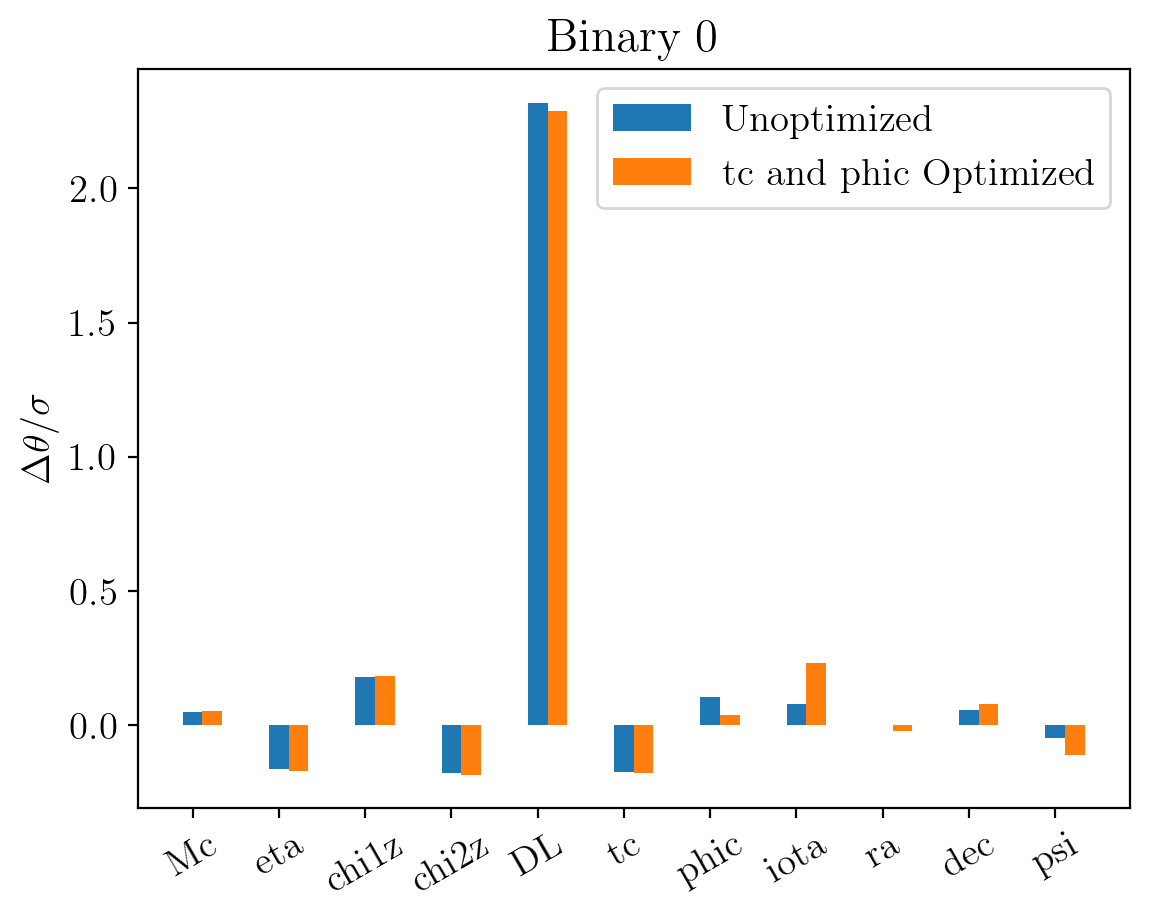

2023-10-17 09:22:01,953 - Network - INFO : Polarizations calculated.
2023-10-17 09:22:01,953 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:22:01,960 - Network - INFO : Polarizations calculated.


######  Binary 1  ######


2023-10-17 09:22:03,259 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:22:03,363 - Network - INFO : PSDs loaded.
2023-10-17 09:22:03,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:22:03,417 - Network - INFO : Detector responses calculated.
2023-10-17 09:22:03,418 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:22:03,418 - Network - INFO :    CE-40_C
2023-10-17 09:22:04,250 - Network - INFO :    CE-20_S
2023-10-17 09:22:05,041 - Network - INFO :    ET_ET1
2023-10-17 09:22:05,799 - Network - INFO :    ET_ET2
2023-10-17 09:22:06,563 - Network - INFO :    ET_ET3
2023-10-17 09:22:07,338 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:22:07,341 - Network - INFO : SNRs calculated.
2023-10-17 09:22:07,342 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:22:07,342 - Network - INFO :    CE-40_C
2023-10-17 09:22:07,422 - Network - INFO :

Mc bias diff: 0.79%
Mc, not: 0.836 sigma
Mc, opt: 0.829 sigma

eta bias diff: 0.39%
eta, not: 2.030 sigma
eta, opt: 2.022 sigma

chi1z bias diff: 0.27%
chi1z, not: -2.509 sigma
chi1z, opt: -2.502 sigma

chi2z bias diff: 0.26%
chi2z, not: 2.563 sigma
chi2z, opt: 2.557 sigma

DL bias diff: 0.33%
DL, not: 6.282 sigma
DL, opt: 6.261 sigma

tc bias diff: 0.24%
tc, not: 2.581 sigma
tc, opt: 2.574 sigma

phic bias diff: 0.06%
phic, not: 2.267 sigma
phic, opt: 2.266 sigma

iota bias diff: -5.45%
iota, not: -0.084 sigma
iota, opt: -0.089 sigma

ra bias diff: 1.15%
ra, not: 0.039 sigma
ra, opt: 0.039 sigma

dec bias diff: 2.06%
dec, not: 0.059 sigma
dec, opt: 0.058 sigma

psi bias diff: -29.93%
psi, not: -0.111 sigma
psi, opt: -0.144 sigma

######  Binary 2  ######


2023-10-17 09:22:15,186 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:22:15,235 - Network - INFO : PSDs loaded.
2023-10-17 09:22:15,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:22:15,270 - Network - INFO : Detector responses calculated.
2023-10-17 09:22:15,270 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:22:15,271 - Network - INFO :    CE-40_C
2023-10-17 09:22:16,483 - Network - INFO :    CE-20_S
2023-10-17 09:22:17,638 - Network - INFO :    ET_ET1
2023-10-17 09:22:19,016 - Network - INFO :    ET_ET2
2023-10-17 09:22:20,115 - Network - INFO :    ET_ET3
2023-10-17 09:22:21,274 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:22:21,278 - Network - INFO : SNRs calculated.
2023-10-17 09:22:21,278 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:22:21,279 - Network - INFO :    CE-40_C
2023-10-17 09:22:21,348 - Network - INFO :

Mc bias diff: 0.52%
Mc, not: 1.277 sigma
Mc, opt: 1.271 sigma

eta bias diff: 0.60%
eta, not: 1.937 sigma
eta, opt: 1.926 sigma

chi1z bias diff: 1.13%
chi1z, not: -1.447 sigma
chi1z, opt: -1.430 sigma

chi2z bias diff: 1.09%
chi2z, not: 1.430 sigma
chi2z, opt: 1.415 sigma

DL bias diff: 0.38%
DL, not: 7.574 sigma
DL, opt: 7.545 sigma

tc bias diff: 1.10%
tc, not: 1.531 sigma
tc, opt: 1.514 sigma

phic bias diff: 1.44%
phic, not: 1.265 sigma
phic, opt: 1.247 sigma

iota bias diff: -7.09%
iota, not: 0.847 sigma
iota, opt: 0.907 sigma

ra bias diff: 11.11%
ra, not: 0.080 sigma
ra, opt: 0.071 sigma

dec bias diff: 7.98%
dec, not: -0.069 sigma
dec, opt: -0.064 sigma

psi bias diff: 2.20%
psi, not: -0.109 sigma
psi, opt: -0.106 sigma

######  Binary 3  ######


2023-10-17 09:22:32,539 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:22:32,582 - Network - INFO : PSDs loaded.
2023-10-17 09:22:32,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:22:32,643 - Network - INFO : Detector responses calculated.
2023-10-17 09:22:32,644 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:22:32,645 - Network - INFO :    CE-40_C
2023-10-17 09:22:34,222 - Network - INFO :    CE-20_S
2023-10-17 09:22:35,812 - Network - INFO :    ET_ET1
2023-10-17 09:22:37,598 - Network - INFO :    ET_ET2
2023-10-17 09:22:39,510 - Network - INFO :    ET_ET3
2023-10-17 09:22:41,266 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:22:41,274 - Network - INFO : SNRs calculated.
2023-10-17 09:22:41,276 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:22:41,277 - Network - INFO :    CE-40_C
2023-10-17 09:22:41,381 - Network - INFO :

Mc bias diff: -0.07%
Mc, not: -2.008 sigma
Mc, opt: -2.009 sigma

eta bias diff: -0.02%
eta, not: 3.259 sigma
eta, opt: 3.260 sigma

chi1z bias diff: -0.41%
chi1z, not: -2.676 sigma
chi1z, opt: -2.687 sigma

chi2z bias diff: -0.35%
chi2z, not: 2.667 sigma
chi2z, opt: 2.676 sigma

DL bias diff: -0.01%
DL, not: 5.546 sigma
DL, opt: 5.546 sigma

tc bias diff: -0.23%
tc, not: 2.687 sigma
tc, opt: 2.693 sigma

phic bias diff: 0.35%
phic, not: 1.495 sigma
phic, opt: 1.489 sigma

iota bias diff: 62.55%
iota, not: 0.042 sigma
iota, opt: 0.016 sigma

ra bias diff: 2.01%
ra, not: -0.145 sigma
ra, opt: -0.142 sigma

dec bias diff: 7.54%
dec, not: -0.120 sigma
dec, opt: -0.111 sigma

psi bias diff: 0.65%
psi, not: -0.583 sigma
psi, opt: -0.579 sigma

######  Binary 4  ######


2023-10-17 09:22:56,425 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:22:56,469 - Network - INFO : PSDs loaded.
2023-10-17 09:22:56,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:22:56,510 - Network - INFO : Detector responses calculated.
2023-10-17 09:22:56,511 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:22:56,511 - Network - INFO :    CE-40_C
2023-10-17 09:22:58,053 - Network - INFO :    CE-20_S
2023-10-17 09:22:59,524 - Network - INFO :    ET_ET1
2023-10-17 09:23:01,011 - Network - INFO :    ET_ET2
2023-10-17 09:23:02,523 - Network - INFO :    ET_ET3
2023-10-17 09:23:03,916 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:23:03,919 - Network - INFO : SNRs calculated.
2023-10-17 09:23:03,920 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:23:03,920 - Network - INFO :    CE-40_C
2023-10-17 09:23:03,979 - Network - INFO :

Mc bias diff: 0.05%
Mc, not: -6.902 sigma
Mc, opt: -6.898 sigma

eta bias diff: 0.06%
eta, not: 7.291 sigma
eta, opt: 7.287 sigma

chi1z bias diff: 0.15%
chi1z, not: -5.067 sigma
chi1z, opt: -5.059 sigma

chi2z bias diff: 0.14%
chi2z, not: 4.637 sigma
chi2z, opt: 4.630 sigma

DL bias diff: 0.07%
DL, not: 23.120 sigma
DL, opt: 23.104 sigma

tc bias diff: 0.13%
tc, not: 4.861 sigma
tc, opt: 4.855 sigma

phic bias diff: 0.12%
phic, not: 5.871 sigma
phic, opt: 5.865 sigma

iota bias diff: 8.89%
iota, not: -0.519 sigma
iota, opt: -0.473 sigma

ra bias diff: 2.48%
ra, not: 0.424 sigma
ra, opt: 0.413 sigma

dec bias diff: 2.01%
dec, not: 0.423 sigma
dec, opt: 0.414 sigma

psi bias diff: -1.19%
psi, not: -0.200 sigma
psi, opt: -0.202 sigma

######  Binary 5  ######


2023-10-17 09:23:17,475 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:23:17,521 - Network - INFO : PSDs loaded.
2023-10-17 09:23:17,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:23:17,567 - Network - INFO : Detector responses calculated.
2023-10-17 09:23:17,567 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:23:17,568 - Network - INFO :    CE-40_C
2023-10-17 09:23:19,160 - Network - INFO :    CE-20_S
2023-10-17 09:23:20,700 - Network - INFO :    ET_ET1
2023-10-17 09:23:22,220 - Network - INFO :    ET_ET2
2023-10-17 09:23:23,827 - Network - INFO :    ET_ET3
2023-10-17 09:23:25,552 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:23:25,556 - Network - INFO : SNRs calculated.
2023-10-17 09:23:25,556 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:23:25,557 - Network - INFO :    CE-40_C
2023-10-17 09:23:25,617 - Network - INFO :

Mc bias diff: 0.36%
Mc, not: -2.615 sigma
Mc, opt: -2.605 sigma

eta bias diff: -0.15%
eta, not: 2.988 sigma
eta, opt: 2.992 sigma

chi1z bias diff: -0.57%
chi1z, not: -2.361 sigma
chi1z, opt: -2.374 sigma

chi2z bias diff: -0.75%
chi2z, not: 2.204 sigma
chi2z, opt: 2.221 sigma

DL bias diff: 0.25%
DL, not: 5.384 sigma
DL, opt: 5.371 sigma

tc bias diff: -0.43%
tc, not: 2.220 sigma
tc, opt: 2.230 sigma

phic bias diff: -0.63%
phic, not: 0.974 sigma
phic, opt: 0.980 sigma

iota bias diff: 14.89%
iota, not: 0.315 sigma
iota, opt: 0.268 sigma

ra bias diff: 64.11%
ra, not: -0.018 sigma
ra, opt: -0.007 sigma

dec bias diff: 24.24%
dec, not: 0.073 sigma
dec, opt: 0.055 sigma

psi bias diff: -5.52%
psi, not: -0.122 sigma
psi, opt: -0.129 sigma

######  Binary 6  ######


2023-10-17 09:23:38,079 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:23:38,151 - Network - INFO : PSDs loaded.
2023-10-17 09:23:38,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:23:38,198 - Network - INFO : Detector responses calculated.
2023-10-17 09:23:38,199 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:23:38,200 - Network - INFO :    CE-40_C
2023-10-17 09:23:38,885 - Network - INFO :    CE-20_S
2023-10-17 09:23:39,544 - Network - INFO :    ET_ET1
2023-10-17 09:23:40,214 - Network - INFO :    ET_ET2
2023-10-17 09:23:40,910 - Network - INFO :    ET_ET3
2023-10-17 09:23:41,599 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:23:41,603 - Network - INFO : SNRs calculated.
2023-10-17 09:23:41,604 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:23:41,605 - Network - INFO :    CE-40_C
2023-10-17 09:23:41,687 - Network - INFO :

Mc bias diff: -13.03%
Mc, not: 0.132 sigma
Mc, opt: 0.149 sigma

eta bias diff: 2.62%
eta, not: 1.494 sigma
eta, opt: 1.455 sigma

chi1z bias diff: 2.21%
chi1z, not: -1.723 sigma
chi1z, opt: -1.685 sigma

chi2z bias diff: 2.08%
chi2z, not: 1.798 sigma
chi2z, opt: 1.761 sigma

DL bias diff: 1.50%
DL, not: 4.313 sigma
DL, opt: 4.249 sigma

tc bias diff: 2.12%
tc, not: 1.758 sigma
tc, opt: 1.721 sigma

phic bias diff: 2.23%
phic, not: 1.728 sigma
phic, opt: 1.690 sigma

iota bias diff: 963.13%
iota, not: -0.011 sigma
iota, opt: 0.094 sigma

ra bias diff: 20.69%
ra, not: 0.127 sigma
ra, opt: 0.101 sigma

dec bias diff: 5.87%
dec, not: 0.157 sigma
dec, opt: 0.147 sigma

psi bias diff: 29.01%
psi, not: -0.050 sigma
psi, opt: -0.036 sigma

######  Binary 7  ######


2023-10-17 09:23:51,480 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:23:51,524 - Network - INFO : PSDs loaded.
2023-10-17 09:23:51,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:23:51,587 - Network - INFO : Detector responses calculated.
2023-10-17 09:23:51,587 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:23:51,588 - Network - INFO :    CE-40_C
2023-10-17 09:23:54,265 - Network - INFO :    CE-20_S
2023-10-17 09:23:56,860 - Network - INFO :    ET_ET1
2023-10-17 09:23:59,607 - Network - INFO :    ET_ET2
2023-10-17 09:24:02,461 - Network - INFO :    ET_ET3
2023-10-17 09:24:05,097 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:24:05,102 - Network - INFO : SNRs calculated.
2023-10-17 09:24:05,102 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:24:05,103 - Network - INFO :    CE-40_C
2023-10-17 09:24:05,177 - Network - INFO :

Mc bias diff: -29.15%
Mc, not: -0.333 sigma
Mc, opt: -0.430 sigma

eta bias diff: -55.23%
eta, not: 0.085 sigma
eta, opt: 0.132 sigma

chi1z bias diff: -84.79%
chi1z, not: 0.055 sigma
chi1z, opt: 0.101 sigma

chi2z bias diff: -8.35%
chi2z, not: -0.036 sigma
chi2z, opt: -0.039 sigma

DL bias diff: -0.00%
DL, not: 24.819 sigma
DL, opt: 24.820 sigma

tc bias diff: 11.25%
tc, not: -0.277 sigma
tc, opt: -0.245 sigma

phic bias diff: -3.11%
phic, not: 1.611 sigma
phic, opt: 1.662 sigma

iota bias diff: 0.36%
iota, not: -0.380 sigma
iota, opt: -0.379 sigma

ra bias diff: -0.51%
ra, not: 0.123 sigma
ra, opt: 0.124 sigma

dec bias diff: 1.81%
dec, not: 0.124 sigma
dec, opt: 0.122 sigma

psi bias diff: -0.28%
psi, not: -0.146 sigma
psi, opt: -0.146 sigma

######  Binary 8  ######


2023-10-17 09:24:25,768 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:24:25,813 - Network - INFO : PSDs loaded.
2023-10-17 09:24:25,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:24:25,864 - Network - INFO : Detector responses calculated.
2023-10-17 09:24:25,864 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:24:25,865 - Network - INFO :    CE-40_C
2023-10-17 09:24:27,810 - Network - INFO :    CE-20_S
2023-10-17 09:24:29,642 - Network - INFO :    ET_ET1
2023-10-17 09:24:31,573 - Network - INFO :    ET_ET2
2023-10-17 09:24:33,499 - Network - INFO :    ET_ET3
2023-10-17 09:24:35,347 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:24:35,351 - Network - INFO : SNRs calculated.
2023-10-17 09:24:35,352 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:24:35,352 - Network - INFO :    CE-40_C
2023-10-17 09:24:35,416 - Network - INFO :

Mc bias diff: -0.05%
Mc, not: -10.742 sigma
Mc, opt: -10.747 sigma

eta bias diff: -0.10%
eta, not: 9.787 sigma
eta, opt: 9.797 sigma

chi1z bias diff: -0.10%
chi1z, not: -7.549 sigma
chi1z, opt: -7.556 sigma

chi2z bias diff: -0.17%
chi2z, not: 7.215 sigma
chi2z, opt: 7.228 sigma

DL bias diff: 0.05%
DL, not: 13.407 sigma
DL, opt: 13.399 sigma

tc bias diff: -0.06%
tc, not: 7.478 sigma
tc, opt: 7.482 sigma

phic bias diff: 0.08%
phic, not: 2.741 sigma
phic, opt: 2.738 sigma

iota bias diff: 1.85%
iota, not: 1.723 sigma
iota, opt: 1.691 sigma

ra bias diff: 0.30%
ra, not: -0.056 sigma
ra, opt: -0.056 sigma

dec bias diff: -8.25%
dec, not: 0.196 sigma
dec, opt: 0.212 sigma

psi bias diff: 4.22%
psi, not: -0.051 sigma
psi, opt: -0.049 sigma

######  Binary 9  ######


2023-10-17 09:24:49,575 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:24:49,654 - Network - INFO : PSDs loaded.
2023-10-17 09:24:49,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:24:49,707 - Network - INFO : Detector responses calculated.
2023-10-17 09:24:49,708 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:24:49,709 - Network - INFO :    CE-40_C
2023-10-17 09:24:50,349 - Network - INFO :    CE-20_S
2023-10-17 09:24:50,984 - Network - INFO :    ET_ET1
2023-10-17 09:24:51,618 - Network - INFO :    ET_ET2
2023-10-17 09:24:52,258 - Network - INFO :    ET_ET3
2023-10-17 09:24:52,894 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:24:52,898 - Network - INFO : SNRs calculated.
2023-10-17 09:24:52,899 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:24:52,900 - Network - INFO :    CE-40_C
2023-10-17 09:24:52,981 - Network - INFO :

Mc bias diff: -7.00%
Mc, not: 0.320 sigma
Mc, opt: 0.342 sigma

eta bias diff: 1.68%
eta, not: 1.954 sigma
eta, opt: 1.921 sigma

chi1z bias diff: 1.14%
chi1z, not: -2.342 sigma
chi1z, opt: -2.315 sigma

chi2z bias diff: 1.12%
chi2z, not: 2.349 sigma
chi2z, opt: 2.323 sigma

DL bias diff: 0.82%
DL, not: 4.994 sigma
DL, opt: 4.953 sigma

tc bias diff: 1.14%
tc, not: 2.320 sigma
tc, opt: 2.293 sigma

phic bias diff: 1.18%
phic, not: 2.274 sigma
phic, opt: 2.247 sigma

iota bias diff: -39.80%
iota, not: -0.078 sigma
iota, opt: -0.109 sigma

ra bias diff: -3.04%
ra, not: 0.257 sigma
ra, opt: 0.265 sigma

dec bias diff: -8.61%
dec, not: -0.104 sigma
dec, opt: -0.113 sigma

psi bias diff: -23.42%
psi, not: -0.046 sigma
psi, opt: -0.057 sigma

######  Binary 10  ######


2023-10-17 09:24:59,935 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:24:59,978 - Network - INFO : PSDs loaded.
2023-10-17 09:24:59,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:25:00,026 - Network - INFO : Detector responses calculated.
2023-10-17 09:25:00,026 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:25:00,027 - Network - INFO :    CE-40_C
2023-10-17 09:25:01,429 - Network - INFO :    CE-20_S
2023-10-17 09:25:02,812 - Network - INFO :    ET_ET1
2023-10-17 09:25:04,144 - Network - INFO :    ET_ET2
2023-10-17 09:25:05,574 - Network - INFO :    ET_ET3
2023-10-17 09:25:07,029 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:25:07,033 - Network - INFO : SNRs calculated.
2023-10-17 09:25:07,033 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:25:07,033 - Network - INFO :    CE-40_C
2023-10-17 09:25:07,092 - Network - INFO :

Mc bias diff: 0.80%
Mc, not: -0.077 sigma
Mc, opt: -0.077 sigma

eta bias diff: 0.26%
eta, not: 0.790 sigma
eta, opt: 0.788 sigma

chi1z bias diff: 0.19%
chi1z, not: -0.871 sigma
chi1z, opt: -0.870 sigma

chi2z bias diff: 0.41%
chi2z, not: 0.885 sigma
chi2z, opt: 0.881 sigma

DL bias diff: 0.02%
DL, not: 8.826 sigma
DL, opt: 8.825 sigma

tc bias diff: 0.26%
tc, not: 0.913 sigma
tc, opt: 0.910 sigma

phic bias diff: -0.14%
phic, not: 0.823 sigma
phic, opt: 0.824 sigma

iota bias diff: -2.10%
iota, not: -0.050 sigma
iota, opt: -0.051 sigma

ra bias diff: -0.45%
ra, not: 0.228 sigma
ra, opt: 0.229 sigma

dec bias diff: 0.01%
dec, not: -0.140 sigma
dec, opt: -0.140 sigma

psi bias diff: 2.14%
psi, not: -0.027 sigma
psi, opt: -0.027 sigma



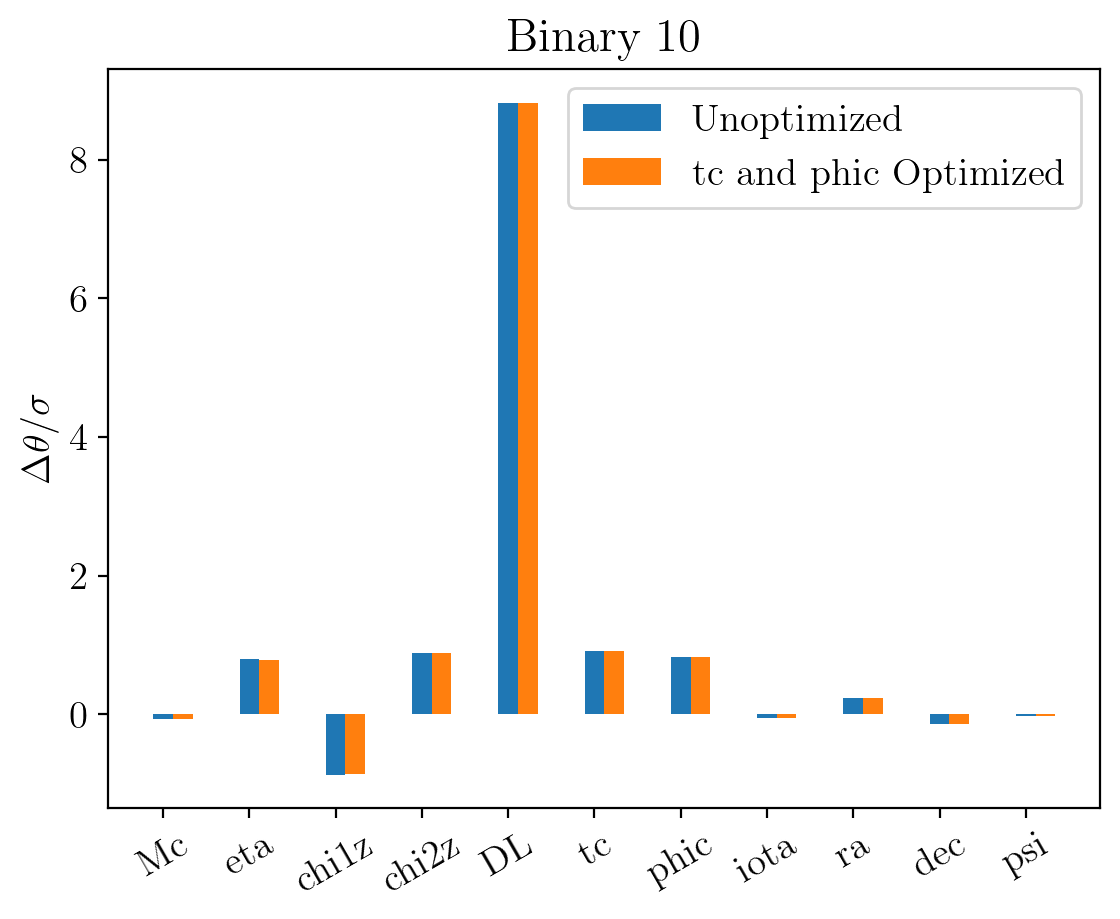

2023-10-17 09:25:17,799 - Network - INFO : Polarizations calculated.
2023-10-17 09:25:17,800 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:25:17,814 - Network - INFO : Polarizations calculated.


######  Binary 11  ######


2023-10-17 09:25:20,252 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:25:20,296 - Network - INFO : PSDs loaded.
2023-10-17 09:25:20,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:25:20,350 - Network - INFO : Detector responses calculated.
2023-10-17 09:25:20,351 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:25:20,352 - Network - INFO :    CE-40_C
2023-10-17 09:25:21,985 - Network - INFO :    CE-20_S
2023-10-17 09:25:23,571 - Network - INFO :    ET_ET1
2023-10-17 09:25:25,132 - Network - INFO :    ET_ET2
2023-10-17 09:25:26,703 - Network - INFO :    ET_ET3
2023-10-17 09:25:28,295 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:25:28,299 - Network - INFO : SNRs calculated.
2023-10-17 09:25:28,299 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:25:28,300 - Network - INFO :    CE-40_C
2023-10-17 09:25:28,364 - Network - INFO :

Mc bias diff: 0.63%
Mc, not: -0.339 sigma
Mc, opt: -0.337 sigma

eta bias diff: 0.10%
eta, not: 0.268 sigma
eta, opt: 0.268 sigma

chi1z bias diff: -0.19%
chi1z, not: 0.257 sigma
chi1z, opt: 0.258 sigma

chi2z bias diff: 0.61%
chi2z, not: -0.253 sigma
chi2z, opt: -0.252 sigma

DL bias diff: 0.01%
DL, not: 16.123 sigma
DL, opt: 16.122 sigma

tc bias diff: -0.24%
tc, not: -0.079 sigma
tc, opt: -0.079 sigma

phic bias diff: -0.13%
phic, not: 0.642 sigma
phic, opt: 0.643 sigma

iota bias diff: 2.51%
iota, not: -0.091 sigma
iota, opt: -0.089 sigma

ra bias diff: 0.13%
ra, not: -0.113 sigma
ra, opt: -0.112 sigma

dec bias diff: -0.25%
dec, not: -0.203 sigma
dec, opt: -0.204 sigma

psi bias diff: -1.35%
psi, not: 0.238 sigma
psi, opt: 0.241 sigma

######  Binary 12  ######


2023-10-17 09:25:40,651 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:25:40,717 - Network - INFO : PSDs loaded.
2023-10-17 09:25:40,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:25:40,749 - Network - INFO : Detector responses calculated.
2023-10-17 09:25:40,750 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:25:40,751 - Network - INFO :    CE-40_C
2023-10-17 09:25:41,602 - Network - INFO :    CE-20_S
2023-10-17 09:25:42,438 - Network - INFO :    ET_ET1
2023-10-17 09:25:43,301 - Network - INFO :    ET_ET2
2023-10-17 09:25:44,163 - Network - INFO :    ET_ET3
2023-10-17 09:25:45,032 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:25:45,035 - Network - INFO : SNRs calculated.
2023-10-17 09:25:45,035 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:25:45,036 - Network - INFO :    CE-40_C
2023-10-17 09:25:45,095 - Network - INFO :

Mc bias diff: 0.11%
Mc, not: 9.191 sigma
Mc, opt: 9.181 sigma

eta bias diff: -0.12%
eta, not: 9.268 sigma
eta, opt: 9.280 sigma

chi1z bias diff: -0.20%
chi1z, not: -10.804 sigma
chi1z, opt: -10.825 sigma

chi2z bias diff: -0.20%
chi2z, not: 10.936 sigma
chi2z, opt: 10.958 sigma

DL bias diff: 1.11%
DL, not: 1.040 sigma
DL, opt: 1.028 sigma

tc bias diff: -0.21%
tc, not: 10.785 sigma
tc, opt: 10.807 sigma

phic bias diff: -27.74%
phic, not: 0.096 sigma
phic, opt: 0.123 sigma

iota bias diff: -27.97%
iota, not: 1.996 sigma
iota, opt: 2.554 sigma

ra bias diff: 3.08%
ra, not: -0.397 sigma
ra, opt: -0.385 sigma

dec bias diff: -3.51%
dec, not: -0.877 sigma
dec, opt: -0.908 sigma

psi bias diff: 2.89%
psi, not: -0.806 sigma
psi, opt: -0.783 sigma

######  Binary 13  ######


2023-10-17 09:25:53,294 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:25:53,338 - Network - INFO : PSDs loaded.
2023-10-17 09:25:53,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:25:53,374 - Network - INFO : Detector responses calculated.
2023-10-17 09:25:53,375 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:25:53,376 - Network - INFO :    CE-40_C
2023-10-17 09:25:54,610 - Network - INFO :    CE-20_S
2023-10-17 09:25:55,909 - Network - INFO :    ET_ET1
2023-10-17 09:25:57,188 - Network - INFO :    ET_ET2
2023-10-17 09:25:58,485 - Network - INFO :    ET_ET3
2023-10-17 09:25:59,740 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:25:59,743 - Network - INFO : SNRs calculated.
2023-10-17 09:25:59,744 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:25:59,744 - Network - INFO :    CE-40_C
2023-10-17 09:25:59,809 - Network - INFO :

Mc bias diff: 1.43%
Mc, not: 0.743 sigma
Mc, opt: 0.732 sigma

eta bias diff: 0.61%
eta, not: 1.665 sigma
eta, opt: 1.655 sigma

chi1z bias diff: 1.45%
chi1z, not: -1.385 sigma
chi1z, opt: -1.365 sigma

chi2z bias diff: 1.51%
chi2z, not: 1.359 sigma
chi2z, opt: 1.339 sigma

DL bias diff: 0.07%
DL, not: 13.525 sigma
DL, opt: 13.516 sigma

tc bias diff: 1.40%
tc, not: 1.385 sigma
tc, opt: 1.366 sigma

phic bias diff: 2.13%
phic, not: 1.225 sigma
phic, opt: 1.199 sigma

iota bias diff: 2.57%
iota, not: 0.306 sigma
iota, opt: 0.298 sigma

ra bias diff: 3.33%
ra, not: -0.113 sigma
ra, opt: -0.109 sigma

dec bias diff: -0.06%
dec, not: -0.232 sigma
dec, opt: -0.233 sigma

psi bias diff: 0.23%
psi, not: -0.279 sigma
psi, opt: -0.278 sigma

######  Binary 14  ######


2023-10-17 09:26:10,545 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:26:10,596 - Network - INFO : PSDs loaded.
2023-10-17 09:26:10,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:26:10,632 - Network - INFO : Detector responses calculated.
2023-10-17 09:26:10,633 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:26:10,634 - Network - INFO :    CE-40_C
2023-10-17 09:26:11,746 - Network - INFO :    CE-20_S
2023-10-17 09:26:12,853 - Network - INFO :    ET_ET1
2023-10-17 09:26:13,961 - Network - INFO :    ET_ET2
2023-10-17 09:26:15,089 - Network - INFO :    ET_ET3
2023-10-17 09:26:16,194 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:26:16,202 - Network - INFO : SNRs calculated.
2023-10-17 09:26:16,203 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:26:16,203 - Network - INFO :    CE-40_C
2023-10-17 09:26:16,267 - Network - INFO :

Mc bias diff: 0.80%
Mc, not: 3.893 sigma
Mc, opt: 3.862 sigma

eta bias diff: 1.28%
eta, not: 1.541 sigma
eta, opt: 1.522 sigma

chi1z bias diff: 1.01%
chi1z, not: -2.388 sigma
chi1z, opt: -2.364 sigma

chi2z bias diff: 0.94%
chi2z, not: 2.528 sigma
chi2z, opt: 2.504 sigma

DL bias diff: 8.83%
DL, not: 3.977 sigma
DL, opt: 3.626 sigma

tc bias diff: 1.00%
tc, not: 2.469 sigma
tc, opt: 2.444 sigma

phic bias diff: -7.80%
phic, not: 0.984 sigma
phic, opt: 1.061 sigma

iota bias diff: 1502.55%
iota, not: -0.049 sigma
iota, opt: 0.681 sigma

ra bias diff: 123.29%
ra, not: -0.066 sigma
ra, opt: 0.015 sigma

dec bias diff: -1278.87%
dec, not: 0.016 sigma
dec, opt: 0.223 sigma

psi bias diff: -11.16%
psi, not: 0.732 sigma
psi, opt: 0.814 sigma

######  Binary 15  ######


2023-10-17 09:26:26,369 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:26:26,414 - Network - INFO : PSDs loaded.
2023-10-17 09:26:26,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:26:26,454 - Network - INFO : Detector responses calculated.
2023-10-17 09:26:26,455 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:26:26,455 - Network - INFO :    CE-40_C
2023-10-17 09:26:27,753 - Network - INFO :    CE-20_S
2023-10-17 09:26:29,102 - Network - INFO :    ET_ET1
2023-10-17 09:26:30,578 - Network - INFO :    ET_ET2
2023-10-17 09:26:32,084 - Network - INFO :    ET_ET3
2023-10-17 09:26:33,445 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:26:33,448 - Network - INFO : SNRs calculated.
2023-10-17 09:26:33,448 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:26:33,449 - Network - INFO :    CE-40_C
2023-10-17 09:26:33,509 - Network - INFO :

Mc bias diff: 1.24%
Mc, not: -0.170 sigma
Mc, opt: -0.168 sigma

eta bias diff: -0.00%
eta, not: 1.377 sigma
eta, opt: 1.377 sigma

chi1z bias diff: -0.06%
chi1z, not: -1.407 sigma
chi1z, opt: -1.408 sigma

chi2z bias diff: -0.11%
chi2z, not: 1.390 sigma
chi2z, opt: 1.391 sigma

DL bias diff: -200.81%
DL, not: 0.040 sigma
DL, opt: 0.121 sigma

tc bias diff: -0.10%
tc, not: 1.386 sigma
tc, opt: 1.388 sigma

phic bias diff: -6.32%
phic, not: 0.126 sigma
phic, opt: 0.134 sigma

iota bias diff: 40.18%
iota, not: -0.506 sigma
iota, opt: -0.303 sigma

ra bias diff: -17.01%
ra, not: 0.092 sigma
ra, opt: 0.108 sigma

dec bias diff: -6.99%
dec, not: 0.230 sigma
dec, opt: 0.246 sigma

psi bias diff: -5.08%
psi, not: -0.123 sigma
psi, opt: -0.129 sigma

######  Binary 16  ######


2023-10-17 09:26:47,141 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:26:47,188 - Network - INFO : PSDs loaded.
2023-10-17 09:26:47,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:26:47,243 - Network - INFO : Detector responses calculated.
2023-10-17 09:26:47,244 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:26:47,245 - Network - INFO :    CE-40_C
2023-10-17 09:26:49,752 - Network - INFO :    CE-20_S
2023-10-17 09:26:52,045 - Network - INFO :    ET_ET1
2023-10-17 09:26:54,260 - Network - INFO :    ET_ET2
2023-10-17 09:26:56,527 - Network - INFO :    ET_ET3
2023-10-17 09:26:58,723 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:26:58,727 - Network - INFO : SNRs calculated.
2023-10-17 09:26:58,728 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:26:58,728 - Network - INFO :    CE-40_C
2023-10-17 09:26:58,802 - Network - INFO :

Mc bias diff: -0.28%
Mc, not: -5.823 sigma
Mc, opt: -5.839 sigma

eta bias diff: -0.28%
eta, not: 4.793 sigma
eta, opt: 4.807 sigma

chi1z bias diff: 0.73%
chi1z, not: -3.193 sigma
chi1z, opt: -3.169 sigma

chi2z bias diff: -0.18%
chi2z, not: 2.892 sigma
chi2z, opt: 2.898 sigma

DL bias diff: -0.00%
DL, not: 57.352 sigma
DL, opt: 57.352 sigma

tc bias diff: 0.45%
tc, not: 3.074 sigma
tc, opt: 3.060 sigma

phic bias diff: -0.09%
phic, not: 7.001 sigma
phic, opt: 7.007 sigma

iota bias diff: 0.19%
iota, not: 0.625 sigma
iota, opt: 0.624 sigma

ra bias diff: -0.46%
ra, not: -0.139 sigma
ra, opt: -0.140 sigma

dec bias diff: -0.65%
dec, not: -0.726 sigma
dec, opt: -0.731 sigma

psi bias diff: -1.24%
psi, not: 1.045 sigma
psi, opt: 1.058 sigma

######  Binary 17  ######


2023-10-17 09:27:18,752 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:27:18,808 - Network - INFO : PSDs loaded.
2023-10-17 09:27:18,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:27:18,872 - Network - INFO : Detector responses calculated.
2023-10-17 09:27:18,873 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:27:18,874 - Network - INFO :    CE-40_C
2023-10-17 09:27:21,192 - Network - INFO :    CE-20_S
2023-10-17 09:27:23,294 - Network - INFO :    ET_ET1
2023-10-17 09:27:25,358 - Network - INFO :    ET_ET2
2023-10-17 09:27:27,495 - Network - INFO :    ET_ET3
2023-10-17 09:27:29,481 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:27:29,484 - Network - INFO : SNRs calculated.
2023-10-17 09:27:29,485 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:27:29,485 - Network - INFO :    CE-40_C
2023-10-17 09:27:29,547 - Network - INFO :

Mc bias diff: -0.58%
Mc, not: -0.749 sigma
Mc, opt: -0.753 sigma

eta bias diff: 0.43%
eta, not: 1.344 sigma
eta, opt: 1.338 sigma

chi1z bias diff: 1.04%
chi1z, not: -1.232 sigma
chi1z, opt: -1.219 sigma

chi2z bias diff: 0.44%
chi2z, not: 1.210 sigma
chi2z, opt: 1.205 sigma

DL bias diff: 0.15%
DL, not: 9.608 sigma
DL, opt: 9.594 sigma

tc bias diff: 1.02%
tc, not: 1.128 sigma
tc, opt: 1.116 sigma

phic bias diff: -0.19%
phic, not: 1.113 sigma
phic, opt: 1.115 sigma

iota bias diff: -11.26%
iota, not: 0.291 sigma
iota, opt: 0.323 sigma

ra bias diff: -4.09%
ra, not: -0.086 sigma
ra, opt: -0.090 sigma

dec bias diff: 12.13%
dec, not: 0.025 sigma
dec, opt: 0.022 sigma

psi bias diff: 0.73%
psi, not: -0.502 sigma
psi, opt: -0.498 sigma

######  Binary 18  ######


2023-10-17 09:27:45,453 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:27:45,498 - Network - INFO : PSDs loaded.
2023-10-17 09:27:45,502 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:27:45,547 - Network - INFO : Detector responses calculated.
2023-10-17 09:27:45,548 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:27:45,548 - Network - INFO :    CE-40_C
2023-10-17 09:27:47,393 - Network - INFO :    CE-20_S
2023-10-17 09:27:49,205 - Network - INFO :    ET_ET1
2023-10-17 09:27:50,962 - Network - INFO :    ET_ET2
2023-10-17 09:27:52,776 - Network - INFO :    ET_ET3
2023-10-17 09:27:54,571 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:27:54,575 - Network - INFO : SNRs calculated.
2023-10-17 09:27:54,575 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:27:54,576 - Network - INFO :    CE-40_C
2023-10-17 09:27:54,640 - Network - INFO :

Mc bias diff: 0.03%
Mc, not: -2.206 sigma
Mc, opt: -2.205 sigma

eta bias diff: 0.01%
eta, not: 2.270 sigma
eta, opt: 2.269 sigma

chi1z bias diff: -0.26%
chi1z, not: -1.394 sigma
chi1z, opt: -1.398 sigma

chi2z bias diff: -0.34%
chi2z, not: 1.436 sigma
chi2z, opt: 1.441 sigma

DL bias diff: 0.01%
DL, not: 16.837 sigma
DL, opt: 16.835 sigma

tc bias diff: -0.16%
tc, not: 1.813 sigma
tc, opt: 1.816 sigma

phic bias diff: -0.25%
phic, not: 2.396 sigma
phic, opt: 2.402 sigma

iota bias diff: 1.22%
iota, not: -0.197 sigma
iota, opt: -0.194 sigma

ra bias diff: 3.80%
ra, not: 0.008 sigma
ra, opt: 0.007 sigma

dec bias diff: -2.75%
dec, not: 0.046 sigma
dec, opt: 0.047 sigma

psi bias diff: -0.25%
psi, not: -0.432 sigma
psi, opt: -0.433 sigma

######  Binary 19  ######


2023-10-17 09:28:11,473 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:28:11,525 - Network - INFO : PSDs loaded.
2023-10-17 09:28:11,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:28:11,564 - Network - INFO : Detector responses calculated.
2023-10-17 09:28:11,566 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:28:11,566 - Network - INFO :    CE-40_C
2023-10-17 09:28:12,724 - Network - INFO :    CE-20_S
2023-10-17 09:28:13,949 - Network - INFO :    ET_ET1
2023-10-17 09:28:14,986 - Network - INFO :    ET_ET2
2023-10-17 09:28:16,020 - Network - INFO :    ET_ET3
2023-10-17 09:28:17,040 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:28:17,044 - Network - INFO : SNRs calculated.
2023-10-17 09:28:17,044 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:28:17,045 - Network - INFO :    CE-40_C
2023-10-17 09:28:17,102 - Network - INFO :

Mc bias diff: -0.27%
Mc, not: -0.703 sigma
Mc, opt: -0.705 sigma

eta bias diff: 0.33%
eta, not: 1.560 sigma
eta, opt: 1.555 sigma

chi1z bias diff: 1.03%
chi1z, not: -0.787 sigma
chi1z, opt: -0.779 sigma

chi2z bias diff: 1.13%
chi2z, not: 0.724 sigma
chi2z, opt: 0.716 sigma

DL bias diff: -0.00%
DL, not: 5.360 sigma
DL, opt: 5.360 sigma

tc bias diff: 0.95%
tc, not: 0.851 sigma
tc, opt: 0.843 sigma

phic bias diff: 0.79%
phic, not: 0.955 sigma
phic, opt: 0.948 sigma

iota bias diff: -1.83%
iota, not: 0.257 sigma
iota, opt: 0.261 sigma

ra bias diff: 3.17%
ra, not: 0.148 sigma
ra, opt: 0.144 sigma

dec bias diff: 2.76%
dec, not: -0.159 sigma
dec, opt: -0.154 sigma

psi bias diff: -48.64%
psi, not: -0.012 sigma
psi, opt: -0.018 sigma

######  Binary 20  ######


2023-10-17 09:28:26,725 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:28:26,846 - Network - INFO : PSDs loaded.
2023-10-17 09:28:26,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:28:26,885 - Network - INFO : Detector responses calculated.
2023-10-17 09:28:26,886 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:28:26,886 - Network - INFO :    CE-40_C
2023-10-17 09:28:28,190 - Network - INFO :    CE-20_S
2023-10-17 09:28:29,461 - Network - INFO :    ET_ET1
2023-10-17 09:28:30,787 - Network - INFO :    ET_ET2
2023-10-17 09:28:32,076 - Network - INFO :    ET_ET3
2023-10-17 09:28:34,222 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:28:34,225 - Network - INFO : SNRs calculated.
2023-10-17 09:28:34,225 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:28:34,226 - Network - INFO :    CE-40_C
2023-10-17 09:28:34,283 - Network - INFO :

Mc bias diff: -0.76%
Mc, not: 0.278 sigma
Mc, opt: 0.280 sigma

eta bias diff: -1.34%
eta, not: 0.124 sigma
eta, opt: 0.126 sigma

chi1z bias diff: 4.34%
chi1z, not: 0.061 sigma
chi1z, opt: 0.058 sigma

chi2z bias diff: -0.82%
chi2z, not: -0.069 sigma
chi2z, opt: -0.069 sigma

DL bias diff: 0.02%
DL, not: 8.243 sigma
DL, opt: 8.241 sigma

tc bias diff: 2.29%
tc, not: -0.066 sigma
tc, opt: -0.064 sigma

phic bias diff: 3.85%
phic, not: 0.062 sigma
phic, opt: 0.060 sigma

iota bias diff: 0.77%
iota, not: 0.285 sigma
iota, opt: 0.283 sigma

ra bias diff: -1.73%
ra, not: -0.131 sigma
ra, opt: -0.133 sigma

dec bias diff: -3.83%
dec, not: 0.068 sigma
dec, opt: 0.071 sigma

psi bias diff: 1.42%
psi, not: 0.102 sigma
psi, opt: 0.101 sigma



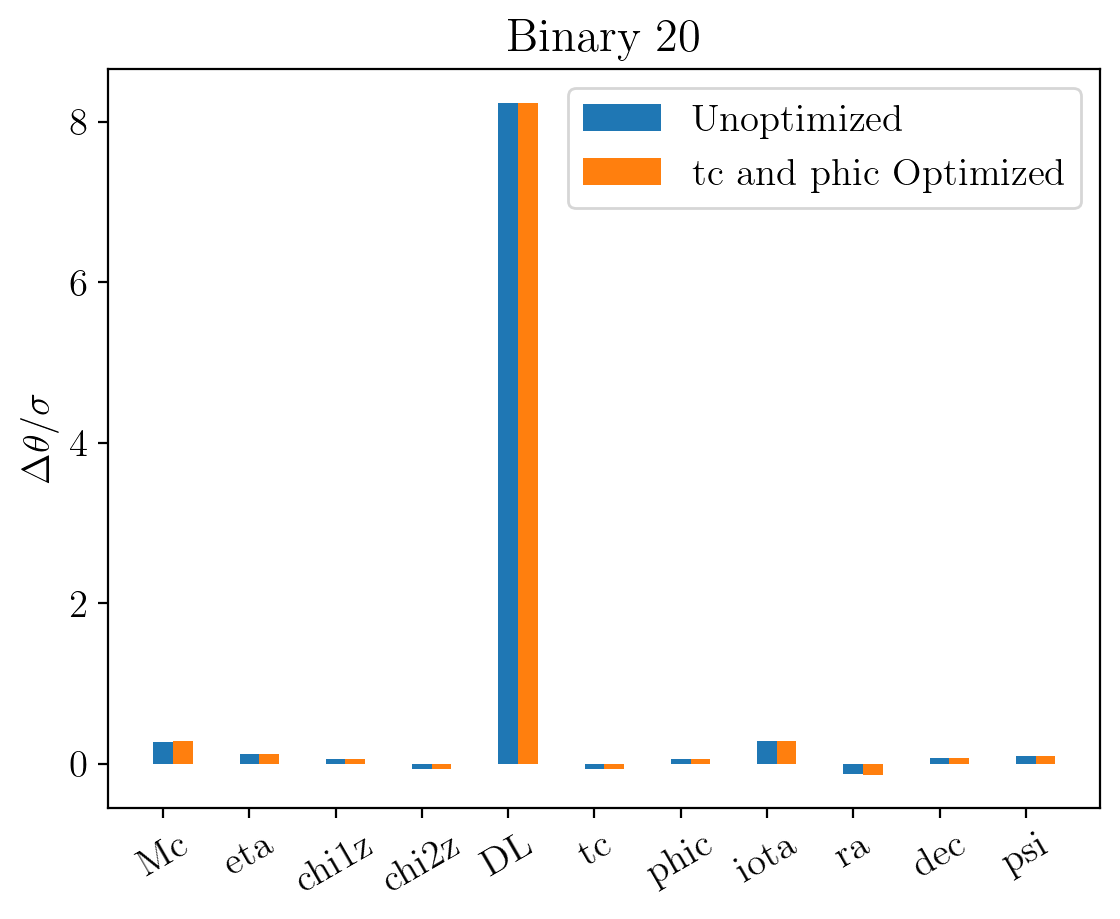

2023-10-17 09:28:44,858 - Network - INFO : Polarizations calculated.
2023-10-17 09:28:44,859 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:28:44,871 - Network - INFO : Polarizations calculated.


######  Binary 21  ######


2023-10-17 09:28:46,075 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:28:46,154 - Network - INFO : PSDs loaded.
2023-10-17 09:28:46,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:28:46,200 - Network - INFO : Detector responses calculated.
2023-10-17 09:28:46,201 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:28:46,202 - Network - INFO :    CE-40_C
2023-10-17 09:28:47,066 - Network - INFO :    CE-20_S
2023-10-17 09:28:47,912 - Network - INFO :    ET_ET1
2023-10-17 09:28:48,881 - Network - INFO :    ET_ET2
2023-10-17 09:28:49,780 - Network - INFO :    ET_ET3
2023-10-17 09:28:50,685 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:28:50,688 - Network - INFO : SNRs calculated.
2023-10-17 09:28:50,689 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:28:50,690 - Network - INFO :    CE-40_C
2023-10-17 09:28:50,759 - Network - INFO :

Mc bias diff: 0.20%
Mc, not: 10.074 sigma
Mc, opt: 10.053 sigma

eta bias diff: -0.31%
eta, not: 9.415 sigma
eta, opt: 9.444 sigma

chi1z bias diff: -0.22%
chi1z, not: -14.743 sigma
chi1z, opt: -14.775 sigma

chi2z bias diff: -0.21%
chi2z, not: 14.941 sigma
chi2z, opt: 14.973 sigma

DL bias diff: 5.48%
DL, not: 4.720 sigma
DL, opt: 4.461 sigma

tc bias diff: -0.15%
tc, not: 16.709 sigma
tc, opt: 16.734 sigma

phic bias diff: 0.77%
phic, not: 4.261 sigma
phic, opt: 4.228 sigma

iota bias diff: -78.21%
iota, not: 0.769 sigma
iota, opt: 1.370 sigma

ra bias diff: 21.30%
ra, not: 0.508 sigma
ra, opt: 0.400 sigma

dec bias diff: -22.30%
dec, not: -0.838 sigma
dec, opt: -1.025 sigma

psi bias diff: 52.92%
psi, not: 0.075 sigma
psi, opt: 0.035 sigma

######  Binary 22  ######


2023-10-17 09:28:57,859 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:28:57,937 - Network - INFO : PSDs loaded.
2023-10-17 09:28:57,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:28:57,999 - Network - INFO : Detector responses calculated.
2023-10-17 09:28:58,000 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:28:58,001 - Network - INFO :    CE-40_C
2023-10-17 09:28:58,888 - Network - INFO :    CE-20_S
2023-10-17 09:28:59,719 - Network - INFO :    ET_ET1
2023-10-17 09:29:00,556 - Network - INFO :    ET_ET2
2023-10-17 09:29:01,388 - Network - INFO :    ET_ET3
2023-10-17 09:29:02,219 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:29:02,222 - Network - INFO : SNRs calculated.
2023-10-17 09:29:02,222 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:29:02,223 - Network - INFO :    CE-40_C
2023-10-17 09:29:02,282 - Network - INFO :

Mc bias diff: -0.71%
Mc, not: 3.741 sigma
Mc, opt: 3.767 sigma

eta bias diff: 0.41%
eta, not: 3.843 sigma
eta, opt: 3.827 sigma

chi1z bias diff: 0.59%
chi1z, not: -4.237 sigma
chi1z, opt: -4.212 sigma

chi2z bias diff: 0.58%
chi2z, not: 4.255 sigma
chi2z, opt: 4.230 sigma

DL bias diff: 2.53%
DL, not: 2.980 sigma
DL, opt: 2.905 sigma

tc bias diff: 0.57%
tc, not: 4.231 sigma
tc, opt: 4.207 sigma

phic bias diff: 1.01%
phic, not: 2.824 sigma
phic, opt: 2.796 sigma

iota bias diff: -20.06%
iota, not: 0.764 sigma
iota, opt: 0.917 sigma

ra bias diff: -6.21%
ra, not: -0.189 sigma
ra, opt: -0.201 sigma

dec bias diff: -66.10%
dec, not: -0.063 sigma
dec, opt: -0.105 sigma

psi bias diff: 0.80%
psi, not: -0.292 sigma
psi, opt: -0.290 sigma

######  Binary 23  ######


2023-10-17 09:29:11,058 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:29:11,103 - Network - INFO : PSDs loaded.
2023-10-17 09:29:11,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:29:11,146 - Network - INFO : Detector responses calculated.
2023-10-17 09:29:11,147 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:29:11,147 - Network - INFO :    CE-40_C
2023-10-17 09:29:12,657 - Network - INFO :    CE-20_S
2023-10-17 09:29:14,101 - Network - INFO :    ET_ET1
2023-10-17 09:29:15,550 - Network - INFO :    ET_ET2
2023-10-17 09:29:16,989 - Network - INFO :    ET_ET3
2023-10-17 09:29:18,417 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:29:18,420 - Network - INFO : SNRs calculated.
2023-10-17 09:29:18,420 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:29:18,421 - Network - INFO :    CE-40_C
2023-10-17 09:29:18,481 - Network - INFO :

Mc bias diff: 23.80%
Mc, not: 0.032 sigma
Mc, opt: 0.025 sigma

eta bias diff: 0.18%
eta, not: 0.134 sigma
eta, opt: 0.134 sigma

chi1z bias diff: 2.25%
chi1z, not: 0.694 sigma
chi1z, opt: 0.678 sigma

chi2z bias diff: -1.75%
chi2z, not: -0.740 sigma
chi2z, opt: -0.753 sigma

DL bias diff: -0.01%
DL, not: 9.983 sigma
DL, opt: 9.985 sigma

tc bias diff: -0.40%
tc, not: -0.560 sigma
tc, opt: -0.562 sigma

phic bias diff: -1.71%
phic, not: 0.376 sigma
phic, opt: 0.383 sigma

iota bias diff: 0.84%
iota, not: -0.587 sigma
iota, opt: -0.582 sigma

ra bias diff: -5.66%
ra, not: 0.021 sigma
ra, opt: 0.023 sigma

dec bias diff: 0.60%
dec, not: -0.142 sigma
dec, opt: -0.141 sigma

psi bias diff: -6.99%
psi, not: -0.032 sigma
psi, opt: -0.034 sigma

######  Binary 24  ######


2023-10-17 09:29:30,886 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:29:30,962 - Network - INFO : PSDs loaded.
2023-10-17 09:29:30,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:29:31,007 - Network - INFO : Detector responses calculated.
2023-10-17 09:29:31,008 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:29:31,009 - Network - INFO :    CE-40_C
2023-10-17 09:29:31,761 - Network - INFO :    CE-20_S
2023-10-17 09:29:32,512 - Network - INFO :    ET_ET1
2023-10-17 09:29:33,325 - Network - INFO :    ET_ET2
2023-10-17 09:29:34,166 - Network - INFO :    ET_ET3
2023-10-17 09:29:34,995 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:29:34,999 - Network - INFO : SNRs calculated.
2023-10-17 09:29:35,000 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:29:35,001 - Network - INFO :    CE-40_C
2023-10-17 09:29:35,083 - Network - INFO :

Mc bias diff: -0.72%
Mc, not: 3.024 sigma
Mc, opt: 3.045 sigma

eta bias diff: -0.24%
eta, not: 3.721 sigma
eta, opt: 3.730 sigma

chi1z bias diff: -0.29%
chi1z, not: -4.644 sigma
chi1z, opt: -4.658 sigma

chi2z bias diff: -0.30%
chi2z, not: 4.694 sigma
chi2z, opt: 4.708 sigma

DL bias diff: -0.05%
DL, not: 9.777 sigma
DL, opt: 9.782 sigma

tc bias diff: -0.31%
tc, not: 4.654 sigma
tc, opt: 4.668 sigma

phic bias diff: -0.09%
phic, not: 4.517 sigma
phic, opt: 4.521 sigma

iota bias diff: 3.34%
iota, not: -0.428 sigma
iota, opt: -0.414 sigma

ra bias diff: 5.76%
ra, not: 0.319 sigma
ra, opt: 0.301 sigma

dec bias diff: -1.20%
dec, not: 0.349 sigma
dec, opt: 0.353 sigma

psi bias diff: -23.42%
psi, not: 0.153 sigma
psi, opt: 0.188 sigma

######  Binary 25  ######


2023-10-17 09:29:43,623 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:29:43,667 - Network - INFO : PSDs loaded.
2023-10-17 09:29:43,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:29:43,717 - Network - INFO : Detector responses calculated.
2023-10-17 09:29:43,718 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:29:43,718 - Network - INFO :    CE-40_C
2023-10-17 09:29:45,589 - Network - INFO :    CE-20_S
2023-10-17 09:29:47,386 - Network - INFO :    ET_ET1
2023-10-17 09:29:49,277 - Network - INFO :    ET_ET2
2023-10-17 09:29:51,231 - Network - INFO :    ET_ET3
2023-10-17 09:29:53,205 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:29:53,209 - Network - INFO : SNRs calculated.
2023-10-17 09:29:53,210 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:29:53,210 - Network - INFO :    CE-40_C
2023-10-17 09:29:53,275 - Network - INFO :

Mc bias diff: -0.11%
Mc, not: -1.044 sigma
Mc, opt: -1.045 sigma

eta bias diff: 1.33%
eta, not: 0.520 sigma
eta, opt: 0.513 sigma

chi1z bias diff: -2.41%
chi1z, not: 0.436 sigma
chi1z, opt: 0.446 sigma

chi2z bias diff: -1.05%
chi2z, not: -0.502 sigma
chi2z, opt: -0.507 sigma

DL bias diff: 0.76%
DL, not: 4.039 sigma
DL, opt: 4.008 sigma

tc bias diff: -7.37%
tc, not: -0.461 sigma
tc, opt: -0.495 sigma

phic bias diff: -0.87%
phic, not: 1.070 sigma
phic, opt: 1.079 sigma

iota bias diff: -47.68%
iota, not: 0.087 sigma
iota, opt: 0.129 sigma

ra bias diff: 40.33%
ra, not: 0.051 sigma
ra, opt: 0.030 sigma

dec bias diff: 2.10%
dec, not: -0.002 sigma
dec, opt: -0.002 sigma

psi bias diff: -0.47%
psi, not: 0.685 sigma
psi, opt: 0.688 sigma

######  Binary 26  ######


2023-10-17 09:30:08,947 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:30:08,993 - Network - INFO : PSDs loaded.
2023-10-17 09:30:08,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:30:09,030 - Network - INFO : Detector responses calculated.
2023-10-17 09:30:09,031 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:30:09,032 - Network - INFO :    CE-40_C
2023-10-17 09:30:10,276 - Network - INFO :    CE-20_S
2023-10-17 09:30:11,551 - Network - INFO :    ET_ET1
2023-10-17 09:30:12,776 - Network - INFO :    ET_ET2
2023-10-17 09:30:14,039 - Network - INFO :    ET_ET3
2023-10-17 09:30:15,248 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:30:15,252 - Network - INFO : SNRs calculated.
2023-10-17 09:30:15,252 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:30:15,253 - Network - INFO :    CE-40_C
2023-10-17 09:30:15,316 - Network - INFO :

Mc bias diff: -0.34%
Mc, not: -4.355 sigma
Mc, opt: -4.370 sigma

eta bias diff: -0.15%
eta, not: 6.636 sigma
eta, opt: 6.646 sigma

chi1z bias diff: -0.07%
chi1z, not: -4.728 sigma
chi1z, opt: -4.731 sigma

chi2z bias diff: -0.01%
chi2z, not: 4.133 sigma
chi2z, opt: 4.134 sigma

DL bias diff: -0.22%
DL, not: 3.724 sigma
DL, opt: 3.732 sigma

tc bias diff: -0.05%
tc, not: 4.265 sigma
tc, opt: 4.267 sigma

phic bias diff: 2.55%
phic, not: 0.225 sigma
phic, opt: 0.219 sigma

iota bias diff: -3.28%
iota, not: -0.452 sigma
iota, opt: -0.467 sigma

ra bias diff: -4.11%
ra, not: -0.199 sigma
ra, opt: -0.207 sigma

dec bias diff: 8.67%
dec, not: 0.249 sigma
dec, opt: 0.227 sigma

psi bias diff: -2.20%
psi, not: -0.267 sigma
psi, opt: -0.273 sigma

######  Binary 27  ######


2023-10-17 09:30:26,009 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:30:26,078 - Network - INFO : PSDs loaded.
2023-10-17 09:30:26,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:30:26,124 - Network - INFO : Detector responses calculated.
2023-10-17 09:30:26,125 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:30:26,126 - Network - INFO :    CE-40_C
2023-10-17 09:30:27,205 - Network - INFO :    CE-20_S
2023-10-17 09:30:28,187 - Network - INFO :    ET_ET1
2023-10-17 09:30:29,116 - Network - INFO :    ET_ET2
2023-10-17 09:30:30,037 - Network - INFO :    ET_ET3
2023-10-17 09:30:31,038 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:30:31,041 - Network - INFO : SNRs calculated.
2023-10-17 09:30:31,042 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:30:31,043 - Network - INFO :    CE-40_C
2023-10-17 09:30:31,107 - Network - INFO :

Mc bias diff: -0.42%
Mc, not: 4.274 sigma
Mc, opt: 4.292 sigma

eta bias diff: -0.03%
eta, not: 3.053 sigma
eta, opt: 3.054 sigma

chi1z bias diff: -0.07%
chi1z, not: -3.895 sigma
chi1z, opt: -3.898 sigma

chi2z bias diff: -0.09%
chi2z, not: 3.948 sigma
chi2z, opt: 3.951 sigma

DL bias diff: -0.01%
DL, not: 17.719 sigma
DL, opt: 17.720 sigma

tc bias diff: -0.08%
tc, not: 3.906 sigma
tc, opt: 3.909 sigma

phic bias diff: 0.07%
phic, not: 3.612 sigma
phic, opt: 3.609 sigma

iota bias diff: -1.96%
iota, not: -0.193 sigma
iota, opt: -0.197 sigma

ra bias diff: -9.34%
ra, not: 0.033 sigma
ra, opt: 0.036 sigma

dec bias diff: 11.36%
dec, not: -0.023 sigma
dec, opt: -0.021 sigma

psi bias diff: 0.42%
psi, not: -0.259 sigma
psi, opt: -0.258 sigma

######  Binary 28  ######


2023-10-17 09:30:39,858 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:30:39,904 - Network - INFO : PSDs loaded.
2023-10-17 09:30:39,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:30:39,941 - Network - INFO : Detector responses calculated.
2023-10-17 09:30:39,942 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:30:39,943 - Network - INFO :    CE-40_C
2023-10-17 09:30:41,050 - Network - INFO :    CE-20_S
2023-10-17 09:30:42,228 - Network - INFO :    ET_ET1
2023-10-17 09:30:43,388 - Network - INFO :    ET_ET2
2023-10-17 09:30:44,568 - Network - INFO :    ET_ET3
2023-10-17 09:30:45,743 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:30:45,746 - Network - INFO : SNRs calculated.
2023-10-17 09:30:45,747 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:30:45,747 - Network - INFO :    CE-40_C
2023-10-17 09:30:45,811 - Network - INFO :

Mc bias diff: 0.12%
Mc, not: 3.998 sigma
Mc, opt: 3.993 sigma

eta bias diff: 0.73%
eta, not: 1.490 sigma
eta, opt: 1.479 sigma

chi1z bias diff: 0.49%
chi1z, not: -2.496 sigma
chi1z, opt: -2.484 sigma

chi2z bias diff: 0.55%
chi2z, not: 2.523 sigma
chi2z, opt: 2.509 sigma

DL bias diff: 0.04%
DL, not: 21.104 sigma
DL, opt: 21.096 sigma

tc bias diff: 0.41%
tc, not: 2.464 sigma
tc, opt: 2.454 sigma

phic bias diff: 0.83%
phic, not: 2.089 sigma
phic, opt: 2.072 sigma

iota bias diff: -1.32%
iota, not: 1.312 sigma
iota, opt: 1.329 sigma

ra bias diff: 0.13%
ra, not: 0.604 sigma
ra, opt: 0.603 sigma

dec bias diff: -0.58%
dec, not: -0.455 sigma
dec, opt: -0.458 sigma

psi bias diff: -1.31%
psi, not: 0.478 sigma
psi, opt: 0.484 sigma

######  Binary 29  ######


2023-10-17 09:30:56,153 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:30:56,199 - Network - INFO : PSDs loaded.
2023-10-17 09:30:56,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:30:56,240 - Network - INFO : Detector responses calculated.
2023-10-17 09:30:56,241 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:30:56,242 - Network - INFO :    CE-40_C
2023-10-17 09:30:57,515 - Network - INFO :    CE-20_S
2023-10-17 09:30:58,816 - Network - INFO :    ET_ET1
2023-10-17 09:31:00,113 - Network - INFO :    ET_ET2
2023-10-17 09:31:01,401 - Network - INFO :    ET_ET3
2023-10-17 09:31:02,710 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:31:02,713 - Network - INFO : SNRs calculated.
2023-10-17 09:31:02,713 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:31:02,714 - Network - INFO :    CE-40_C
2023-10-17 09:31:02,773 - Network - INFO :

Mc bias diff: 0.19%
Mc, not: 0.368 sigma
Mc, opt: 0.367 sigma

eta bias diff: -0.07%
eta, not: 1.590 sigma
eta, opt: 1.591 sigma

chi1z bias diff: -0.16%
chi1z, not: -1.640 sigma
chi1z, opt: -1.642 sigma

chi2z bias diff: 0.29%
chi2z, not: 1.631 sigma
chi2z, opt: 1.627 sigma

DL bias diff: 0.02%
DL, not: 20.940 sigma
DL, opt: 20.937 sigma

tc bias diff: -0.01%
tc, not: 1.662 sigma
tc, opt: 1.662 sigma

phic bias diff: -0.44%
phic, not: 2.380 sigma
phic, opt: 2.391 sigma

iota bias diff: 0.71%
iota, not: -0.722 sigma
iota, opt: -0.717 sigma

ra bias diff: 4.89%
ra, not: 0.079 sigma
ra, opt: 0.075 sigma

dec bias diff: -1.06%
dec, not: 0.275 sigma
dec, opt: 0.278 sigma

psi bias diff: 98.27%
psi, not: 0.016 sigma
psi, opt: 0.000 sigma

######  Binary 30  ######


2023-10-17 09:31:13,482 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:31:13,539 - Network - INFO : PSDs loaded.
2023-10-17 09:31:13,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:31:13,577 - Network - INFO : Detector responses calculated.
2023-10-17 09:31:13,578 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:31:13,578 - Network - INFO :    CE-40_C
2023-10-17 09:31:14,510 - Network - INFO :    CE-20_S
2023-10-17 09:31:15,381 - Network - INFO :    ET_ET1
2023-10-17 09:31:16,243 - Network - INFO :    ET_ET2
2023-10-17 09:31:17,107 - Network - INFO :    ET_ET3
2023-10-17 09:31:17,975 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:31:17,979 - Network - INFO : SNRs calculated.
2023-10-17 09:31:17,979 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:31:17,980 - Network - INFO :    CE-40_C
2023-10-17 09:31:18,040 - Network - INFO :

Mc bias diff: 0.09%
Mc, not: -3.967 sigma
Mc, opt: -3.963 sigma

eta bias diff: 0.01%
eta, not: 16.298 sigma
eta, opt: 16.295 sigma

chi1z bias diff: 0.06%
chi1z, not: -20.978 sigma
chi1z, opt: -20.964 sigma

chi2z bias diff: 0.14%
chi2z, not: 18.197 sigma
chi2z, opt: 18.172 sigma

DL bias diff: 0.75%
DL, not: 1.143 sigma
DL, opt: 1.135 sigma

tc bias diff: 0.14%
tc, not: 17.871 sigma
tc, opt: 17.846 sigma

phic bias diff: 0.15%
phic, not: 1.924 sigma
phic, opt: 1.921 sigma

iota bias diff: 14.56%
iota, not: 2.429 sigma
iota, opt: 2.075 sigma

ra bias diff: 0.11%
ra, not: 1.833 sigma
ra, opt: 1.830 sigma

dec bias diff: 19.92%
dec, not: 0.201 sigma
dec, opt: 0.161 sigma

psi bias diff: 0.11%
psi, not: 1.448 sigma
psi, opt: 1.447 sigma



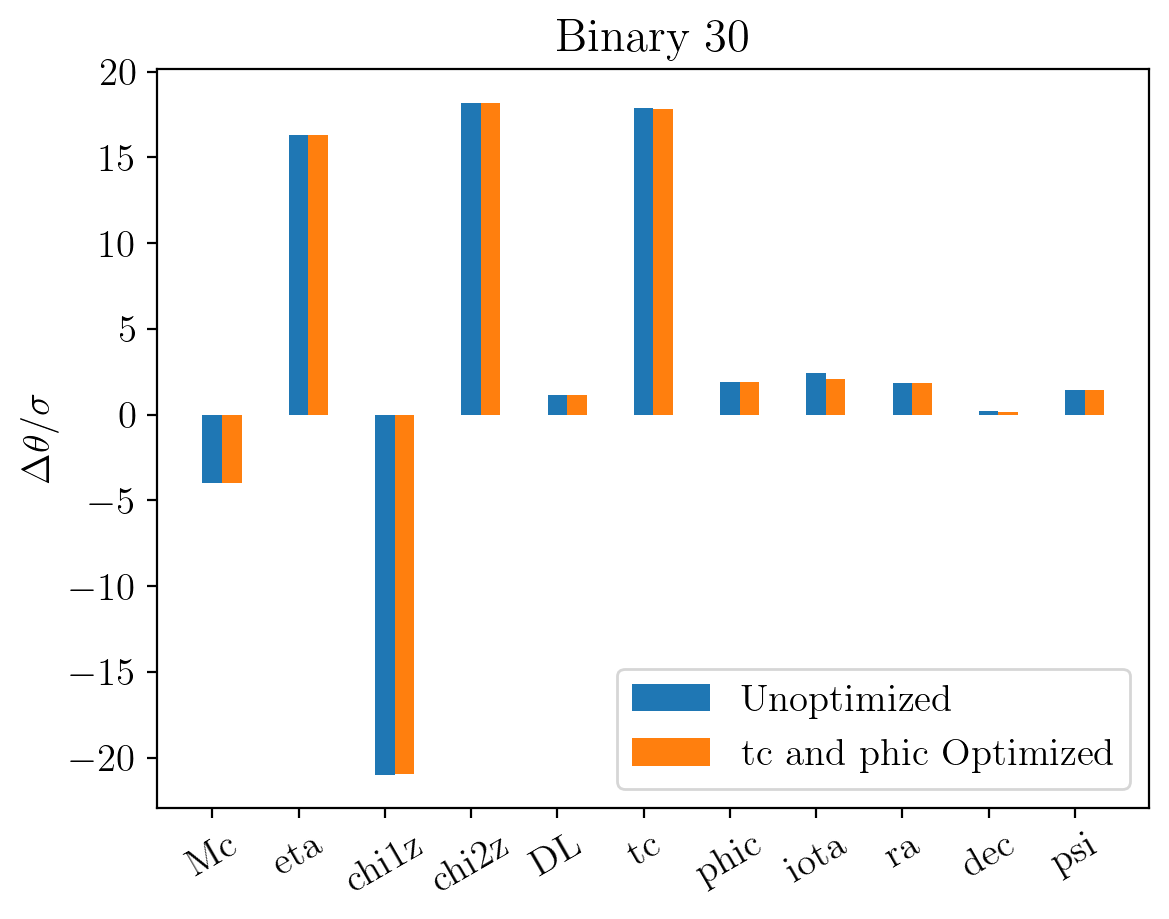

2023-10-17 09:31:24,959 - Network - INFO : Polarizations calculated.
2023-10-17 09:31:24,960 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:31:24,967 - Network - INFO : Polarizations calculated.


######  Binary 31  ######


2023-10-17 09:31:26,136 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:31:26,209 - Network - INFO : PSDs loaded.
2023-10-17 09:31:26,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:31:26,248 - Network - INFO : Detector responses calculated.
2023-10-17 09:31:26,249 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:31:26,250 - Network - INFO :    CE-40_C
2023-10-17 09:31:27,063 - Network - INFO :    CE-20_S
2023-10-17 09:31:27,877 - Network - INFO :    ET_ET1
2023-10-17 09:31:28,731 - Network - INFO :    ET_ET2
2023-10-17 09:31:29,558 - Network - INFO :    ET_ET3
2023-10-17 09:31:30,384 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:31:30,388 - Network - INFO : SNRs calculated.
2023-10-17 09:31:30,389 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:31:30,389 - Network - INFO :    CE-40_C
2023-10-17 09:31:30,453 - Network - INFO :

Mc bias diff: -0.62%
Mc, not: 5.498 sigma
Mc, opt: 5.532 sigma

eta bias diff: -0.36%
eta, not: 7.946 sigma
eta, opt: 7.975 sigma

chi1z bias diff: -0.28%
chi1z, not: -11.724 sigma
chi1z, opt: -11.757 sigma

chi2z bias diff: -0.28%
chi2z, not: 12.219 sigma
chi2z, opt: 12.253 sigma

DL bias diff: -2.11%
DL, not: 5.367 sigma
DL, opt: 5.481 sigma

tc bias diff: -0.28%
tc, not: 12.325 sigma
tc, opt: 12.359 sigma

phic bias diff: -0.07%
phic, not: 7.552 sigma
phic, opt: 7.558 sigma

iota bias diff: 33.39%
iota, not: -0.552 sigma
iota, opt: -0.368 sigma

ra bias diff: 49.34%
ra, not: 0.170 sigma
ra, opt: 0.086 sigma

dec bias diff: 142.67%
dec, not: 0.051 sigma
dec, opt: -0.022 sigma

psi bias diff: 0.66%
psi, not: -1.632 sigma
psi, opt: -1.621 sigma

######  Binary 32  ######


2023-10-17 09:31:37,108 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:31:37,180 - Network - INFO : PSDs loaded.
2023-10-17 09:31:37,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:31:37,217 - Network - INFO : Detector responses calculated.
2023-10-17 09:31:37,218 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:31:37,218 - Network - INFO :    CE-40_C
2023-10-17 09:31:37,752 - Network - INFO :    CE-20_S
2023-10-17 09:31:38,284 - Network - INFO :    ET_ET1
2023-10-17 09:31:38,814 - Network - INFO :    ET_ET2
2023-10-17 09:31:39,346 - Network - INFO :    ET_ET3
2023-10-17 09:31:39,879 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:31:39,883 - Network - INFO : SNRs calculated.
2023-10-17 09:31:39,884 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:31:39,884 - Network - INFO :    CE-40_C
2023-10-17 09:31:39,965 - Network - INFO :

Mc bias diff: -2.53%
Mc, not: -3.089 sigma
Mc, opt: -3.168 sigma

eta bias diff: 2.55%
eta, not: 6.690 sigma
eta, opt: 6.519 sigma

chi1z bias diff: 1.53%
chi1z, not: -6.921 sigma
chi1z, opt: -6.815 sigma

chi2z bias diff: 1.55%
chi2z, not: 6.986 sigma
chi2z, opt: 6.878 sigma

DL bias diff: 8.36%
DL, not: 8.023 sigma
DL, opt: 7.352 sigma

tc bias diff: 1.63%
tc, not: 6.909 sigma
tc, opt: 6.797 sigma

phic bias diff: 1.15%
phic, not: 6.727 sigma
phic, opt: 6.650 sigma

iota bias diff: -1136.67%
iota, not: 0.108 sigma
iota, opt: 1.336 sigma

ra bias diff: 67.07%
ra, not: -0.274 sigma
ra, opt: -0.090 sigma

dec bias diff: 61.73%
dec, not: 0.608 sigma
dec, opt: 0.233 sigma

psi bias diff: 17.75%
psi, not: -0.533 sigma
psi, opt: -0.438 sigma

######  Binary 33  ######


2023-10-17 09:31:46,307 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:31:46,350 - Network - INFO : PSDs loaded.
2023-10-17 09:31:46,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:31:46,391 - Network - INFO : Detector responses calculated.
2023-10-17 09:31:46,392 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:31:46,392 - Network - INFO :    CE-40_C
2023-10-17 09:31:47,802 - Network - INFO :    CE-20_S
2023-10-17 09:31:49,169 - Network - INFO :    ET_ET1
2023-10-17 09:31:50,622 - Network - INFO :    ET_ET2
2023-10-17 09:31:52,070 - Network - INFO :    ET_ET3
2023-10-17 09:31:53,464 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:31:53,467 - Network - INFO : SNRs calculated.
2023-10-17 09:31:53,468 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:31:53,468 - Network - INFO :    CE-40_C
2023-10-17 09:31:53,527 - Network - INFO :

Mc bias diff: 0.43%
Mc, not: -0.588 sigma
Mc, opt: -0.585 sigma

eta bias diff: 0.10%
eta, not: 0.891 sigma
eta, opt: 0.890 sigma

chi1z bias diff: -0.34%
chi1z, not: -0.599 sigma
chi1z, opt: -0.601 sigma

chi2z bias diff: -0.49%
chi2z, not: 0.573 sigma
chi2z, opt: 0.576 sigma

DL bias diff: 0.02%
DL, not: 13.410 sigma
DL, opt: 13.407 sigma

tc bias diff: -0.36%
tc, not: 0.595 sigma
tc, opt: 0.597 sigma

phic bias diff: -0.77%
phic, not: 0.863 sigma
phic, opt: 0.870 sigma

iota bias diff: 3.40%
iota, not: 0.130 sigma
iota, opt: 0.125 sigma

ra bias diff: -1.29%
ra, not: 0.091 sigma
ra, opt: 0.092 sigma

dec bias diff: -0.43%
dec, not: 0.053 sigma
dec, opt: 0.054 sigma

psi bias diff: 0.15%
psi, not: 0.325 sigma
psi, opt: 0.324 sigma

######  Binary 34  ######


2023-10-17 09:32:05,410 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:32:05,454 - Network - INFO : PSDs loaded.
2023-10-17 09:32:05,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:32:05,491 - Network - INFO : Detector responses calculated.
2023-10-17 09:32:05,491 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:32:05,492 - Network - INFO :    CE-40_C
2023-10-17 09:32:06,608 - Network - INFO :    CE-20_S
2023-10-17 09:32:07,746 - Network - INFO :    ET_ET1
2023-10-17 09:32:08,884 - Network - INFO :    ET_ET2
2023-10-17 09:32:10,049 - Network - INFO :    ET_ET3
2023-10-17 09:32:11,188 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:32:11,191 - Network - INFO : SNRs calculated.
2023-10-17 09:32:11,192 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:32:11,192 - Network - INFO :    CE-40_C
2023-10-17 09:32:11,256 - Network - INFO :

Mc bias diff: -0.13%
Mc, not: 2.888 sigma
Mc, opt: 2.892 sigma

eta bias diff: -0.21%
eta, not: 1.674 sigma
eta, opt: 1.678 sigma

chi1z bias diff: -0.20%
chi1z, not: -2.355 sigma
chi1z, opt: -2.360 sigma

chi2z bias diff: 0.01%
chi2z, not: 2.372 sigma
chi2z, opt: 2.372 sigma

DL bias diff: -0.85%
DL, not: 3.350 sigma
DL, opt: 3.378 sigma

tc bias diff: -0.18%
tc, not: 2.332 sigma
tc, opt: 2.337 sigma

phic bias diff: -5.83%
phic, not: 0.374 sigma
phic, opt: 0.396 sigma

iota bias diff: 174.04%
iota, not: -0.018 sigma
iota, opt: 0.013 sigma

ra bias diff: 3.37%
ra, not: 0.432 sigma
ra, opt: 0.418 sigma

dec bias diff: 4.18%
dec, not: -0.318 sigma
dec, opt: -0.305 sigma

psi bias diff: 76.59%
psi, not: 0.030 sigma
psi, opt: 0.007 sigma

######  Binary 35  ######


2023-10-17 09:32:20,949 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:32:21,022 - Network - INFO : PSDs loaded.
2023-10-17 09:32:21,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:32:21,066 - Network - INFO : Detector responses calculated.
2023-10-17 09:32:21,067 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:32:21,068 - Network - INFO :    CE-40_C
2023-10-17 09:32:22,003 - Network - INFO :    CE-20_S
2023-10-17 09:32:22,872 - Network - INFO :    ET_ET1
2023-10-17 09:32:23,748 - Network - INFO :    ET_ET2
2023-10-17 09:32:24,611 - Network - INFO :    ET_ET3
2023-10-17 09:32:25,479 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:32:25,482 - Network - INFO : SNRs calculated.
2023-10-17 09:32:25,482 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:32:25,483 - Network - INFO :    CE-40_C
2023-10-17 09:32:25,542 - Network - INFO :

Mc bias diff: -0.96%
Mc, not: 6.687 sigma
Mc, opt: 6.751 sigma

eta bias diff: 0.10%
eta, not: 5.840 sigma
eta, opt: 5.834 sigma

chi1z bias diff: 0.14%
chi1z, not: -7.441 sigma
chi1z, opt: -7.430 sigma

chi2z bias diff: 0.15%
chi2z, not: 7.475 sigma
chi2z, opt: 7.463 sigma

DL bias diff: -3.44%
DL, not: 6.955 sigma
DL, opt: 7.194 sigma

tc bias diff: 0.17%
tc, not: 7.902 sigma
tc, opt: 7.889 sigma

phic bias diff: 0.78%
phic, not: 6.165 sigma
phic, opt: 6.117 sigma

iota bias diff: 35.97%
iota, not: 1.371 sigma
iota, opt: 0.878 sigma

ra bias diff: -16.42%
ra, not: 0.401 sigma
ra, opt: 0.467 sigma

dec bias diff: -72.18%
dec, not: -0.104 sigma
dec, opt: -0.179 sigma

psi bias diff: 84.68%
psi, not: 0.069 sigma
psi, opt: 0.011 sigma

######  Binary 36  ######


2023-10-17 09:32:34,725 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:32:34,768 - Network - INFO : PSDs loaded.
2023-10-17 09:32:34,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:32:34,815 - Network - INFO : Detector responses calculated.
2023-10-17 09:32:34,816 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:32:34,817 - Network - INFO :    CE-40_C
2023-10-17 09:32:36,669 - Network - INFO :    CE-20_S
2023-10-17 09:32:38,417 - Network - INFO :    ET_ET1
2023-10-17 09:32:40,168 - Network - INFO :    ET_ET2
2023-10-17 09:32:41,999 - Network - INFO :    ET_ET3
2023-10-17 09:32:43,758 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:32:43,762 - Network - INFO : SNRs calculated.
2023-10-17 09:32:43,762 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:32:43,763 - Network - INFO :    CE-40_C
2023-10-17 09:32:43,827 - Network - INFO :

Mc bias diff: -0.03%
Mc, not: -7.578 sigma
Mc, opt: -7.581 sigma

eta bias diff: 0.19%
eta, not: 6.843 sigma
eta, opt: 6.829 sigma

chi1z bias diff: 0.30%
chi1z, not: -4.446 sigma
chi1z, opt: -4.433 sigma

chi2z bias diff: 0.42%
chi2z, not: 4.342 sigma
chi2z, opt: 4.323 sigma

DL bias diff: 6.47%
DL, not: 2.512 sigma
DL, opt: 2.350 sigma

tc bias diff: 0.13%
tc, not: 4.922 sigma
tc, opt: 4.916 sigma

phic bias diff: -32.96%
phic, not: 0.127 sigma
phic, opt: 0.170 sigma

iota bias diff: -46.25%
iota, not: 0.948 sigma
iota, opt: 1.386 sigma

ra bias diff: -294.24%
ra, not: -0.054 sigma
ra, opt: -0.213 sigma

dec bias diff: 23.49%
dec, not: 0.117 sigma
dec, opt: 0.090 sigma

psi bias diff: 7.04%
psi, not: -0.578 sigma
psi, opt: -0.537 sigma

######  Binary 37  ######


2023-10-17 09:32:58,523 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:32:58,566 - Network - INFO : PSDs loaded.
2023-10-17 09:32:58,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:32:58,613 - Network - INFO : Detector responses calculated.
2023-10-17 09:32:58,614 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:32:58,615 - Network - INFO :    CE-40_C
2023-10-17 09:33:00,327 - Network - INFO :    CE-20_S
2023-10-17 09:33:01,974 - Network - INFO :    ET_ET1
2023-10-17 09:33:03,630 - Network - INFO :    ET_ET2
2023-10-17 09:33:05,292 - Network - INFO :    ET_ET3
2023-10-17 09:33:06,985 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:33:06,989 - Network - INFO : SNRs calculated.
2023-10-17 09:33:06,990 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:33:06,990 - Network - INFO :    CE-40_C
2023-10-17 09:33:07,053 - Network - INFO :

Mc bias diff: 0.84%
Mc, not: -1.110 sigma
Mc, opt: -1.100 sigma

eta bias diff: 0.99%
eta, not: 1.233 sigma
eta, opt: 1.221 sigma

chi1z bias diff: -0.01%
chi1z, not: -1.001 sigma
chi1z, opt: -1.002 sigma

chi2z bias diff: -1.60%
chi2z, not: 0.924 sigma
chi2z, opt: 0.938 sigma

DL bias diff: 0.09%
DL, not: 10.836 sigma
DL, opt: 10.827 sigma

tc bias diff: -0.85%
tc, not: 0.920 sigma
tc, opt: 0.928 sigma

phic bias diff: 0.67%
phic, not: 1.792 sigma
phic, opt: 1.780 sigma

iota bias diff: -0.93%
iota, not: -0.449 sigma
iota, opt: -0.453 sigma

ra bias diff: 4.01%
ra, not: 0.088 sigma
ra, opt: 0.084 sigma

dec bias diff: -11.06%
dec, not: 0.090 sigma
dec, opt: 0.100 sigma

psi bias diff: -54.59%
psi, not: 0.026 sigma
psi, opt: 0.040 sigma

######  Binary 38  ######


2023-10-17 09:33:20,178 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:33:20,235 - Network - INFO : PSDs loaded.
2023-10-17 09:33:20,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:33:20,273 - Network - INFO : Detector responses calculated.
2023-10-17 09:33:20,273 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:33:20,274 - Network - INFO :    CE-40_C
2023-10-17 09:33:21,262 - Network - INFO :    CE-20_S
2023-10-17 09:33:22,221 - Network - INFO :    ET_ET1
2023-10-17 09:33:23,171 - Network - INFO :    ET_ET2
2023-10-17 09:33:24,117 - Network - INFO :    ET_ET3
2023-10-17 09:33:25,079 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:33:25,082 - Network - INFO : SNRs calculated.
2023-10-17 09:33:25,082 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:33:25,083 - Network - INFO :    CE-40_C
2023-10-17 09:33:25,138 - Network - INFO :

Mc bias diff: -0.03%
Mc, not: 8.576 sigma
Mc, opt: 8.579 sigma

eta bias diff: -0.44%
eta, not: 4.528 sigma
eta, opt: 4.548 sigma

chi1z bias diff: -0.31%
chi1z, not: -6.555 sigma
chi1z, opt: -6.575 sigma

chi2z bias diff: -0.35%
chi2z, not: 6.692 sigma
chi2z, opt: 6.715 sigma

DL bias diff: -6.02%
DL, not: 4.497 sigma
DL, opt: 4.768 sigma

tc bias diff: -0.31%
tc, not: 6.657 sigma
tc, opt: 6.678 sigma

phic bias diff: -2.66%
phic, not: 1.547 sigma
phic, opt: 1.588 sigma

iota bias diff: -732.26%
iota, not: -0.079 sigma
iota, opt: -0.662 sigma

ra bias diff: 18.59%
ra, not: -0.485 sigma
ra, opt: -0.395 sigma

dec bias diff: 64.84%
dec, not: 0.168 sigma
dec, opt: 0.059 sigma

psi bias diff: -14.77%
psi, not: 0.256 sigma
psi, opt: 0.293 sigma

######  Binary 39  ######


2023-10-17 09:33:33,924 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:33:33,976 - Network - INFO : PSDs loaded.
2023-10-17 09:33:33,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:33:34,016 - Network - INFO : Detector responses calculated.
2023-10-17 09:33:34,016 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:33:34,017 - Network - INFO :    CE-40_C
2023-10-17 09:33:35,045 - Network - INFO :    CE-20_S
2023-10-17 09:33:36,109 - Network - INFO :    ET_ET1
2023-10-17 09:33:37,158 - Network - INFO :    ET_ET2
2023-10-17 09:33:38,205 - Network - INFO :    ET_ET3
2023-10-17 09:33:39,252 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:33:39,255 - Network - INFO : SNRs calculated.
2023-10-17 09:33:39,255 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:33:39,256 - Network - INFO :    CE-40_C
2023-10-17 09:33:39,315 - Network - INFO :

Mc bias diff: 1.02%
Mc, not: 3.570 sigma
Mc, opt: 3.533 sigma

eta bias diff: 1.81%
eta, not: 3.247 sigma
eta, opt: 3.188 sigma

chi1z bias diff: 2.59%
chi1z, not: -3.031 sigma
chi1z, opt: -2.952 sigma

chi2z bias diff: 2.65%
chi2z, not: 3.057 sigma
chi2z, opt: 2.977 sigma

DL bias diff: 208.95%
DL, not: 0.116 sigma
DL, opt: -0.127 sigma

tc bias diff: 2.72%
tc, not: 3.212 sigma
tc, opt: 3.125 sigma

phic bias diff: 187.50%
phic, not: -0.444 sigma
phic, opt: 0.389 sigma

iota bias diff: 36.02%
iota, not: -3.000 sigma
iota, opt: -1.919 sigma

ra bias diff: -45.01%
ra, not: 0.247 sigma
ra, opt: 0.358 sigma

dec bias diff: -148.18%
dec, not: 0.032 sigma
dec, opt: 0.079 sigma

psi bias diff: 177.32%
psi, not: 0.434 sigma
psi, opt: -0.335 sigma

######  Binary 40  ######


2023-10-17 09:33:47,668 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:33:47,740 - Network - INFO : PSDs loaded.
2023-10-17 09:33:47,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:33:47,782 - Network - INFO : Detector responses calculated.
2023-10-17 09:33:47,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:33:47,784 - Network - INFO :    CE-40_C
2023-10-17 09:33:48,520 - Network - INFO :    CE-20_S
2023-10-17 09:33:49,254 - Network - INFO :    ET_ET1
2023-10-17 09:33:49,988 - Network - INFO :    ET_ET2
2023-10-17 09:33:50,735 - Network - INFO :    ET_ET3
2023-10-17 09:33:51,471 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:33:51,475 - Network - INFO : SNRs calculated.
2023-10-17 09:33:51,476 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:33:51,477 - Network - INFO :    CE-40_C
2023-10-17 09:33:51,553 - Network - INFO :

Mc bias diff: 33.15%
Mc, not: 0.080 sigma
Mc, opt: 0.053 sigma

eta bias diff: -0.37%
eta, not: 4.124 sigma
eta, opt: 4.139 sigma

chi1z bias diff: -1.93%
chi1z, not: -2.345 sigma
chi1z, opt: -2.390 sigma

chi2z bias diff: -1.72%
chi2z, not: 2.525 sigma
chi2z, opt: 2.569 sigma

DL bias diff: -0.37%
DL, not: 6.721 sigma
DL, opt: 6.746 sigma

tc bias diff: -1.19%
tc, not: 3.127 sigma
tc, opt: 3.164 sigma

phic bias diff: -1.37%
phic, not: 2.865 sigma
phic, opt: 2.904 sigma

iota bias diff: 5.47%
iota, not: -0.231 sigma
iota, opt: -0.219 sigma

ra bias diff: -0.81%
ra, not: -0.008 sigma
ra, opt: -0.008 sigma

dec bias diff: -4.07%
dec, not: 0.034 sigma
dec, opt: 0.036 sigma

psi bias diff: -0.73%
psi, not: -0.233 sigma
psi, opt: -0.235 sigma



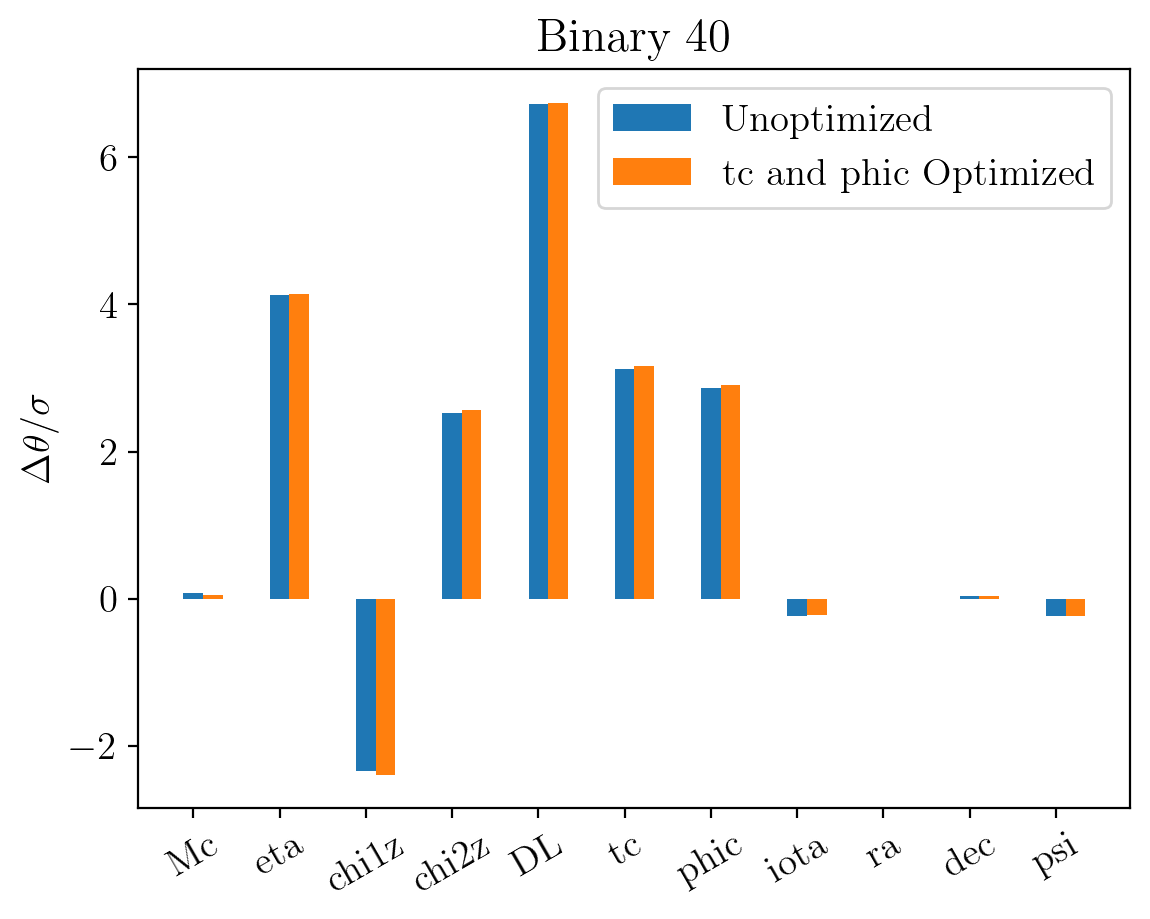

2023-10-17 09:33:57,299 - Network - INFO : Polarizations calculated.
2023-10-17 09:33:57,300 - Network - INFO : Calculate numeric derivatives of polarizations.


######  Binary 41  ######


2023-10-17 09:33:57,309 - Network - INFO : Polarizations calculated.
2023-10-17 09:33:59,544 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:33:59,588 - Network - INFO : PSDs loaded.
2023-10-17 09:33:59,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:33:59,630 - Network - INFO : Detector responses calculated.
2023-10-17 09:33:59,631 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:33:59,632 - Network - INFO :    CE-40_C
2023-10-17 09:34:01,108 - Network - INFO :    CE-20_S
2023-10-17 09:34:02,546 - Network - INFO :    ET_ET1
2023-10-17 09:34:04,004 - Network - INFO :    ET_ET2
2023-10-17 09:34:05,435 - Network - INFO :    ET_ET3
2023-10-17 09:34:06,908 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:34:06,911 - Network - INFO : SNRs calculated.
2023-10-17 09:34:06,911 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:34:06,912 - N

Mc bias diff: -19.78%
Mc, not: -0.202 sigma
Mc, opt: -0.242 sigma

eta bias diff: 1.23%
eta, not: 1.047 sigma
eta, opt: 1.034 sigma

chi1z bias diff: 3.45%
chi1z, not: -1.037 sigma
chi1z, opt: -1.001 sigma

chi2z bias diff: 1.78%
chi2z, not: 1.020 sigma
chi2z, opt: 1.002 sigma

DL bias diff: 0.65%
DL, not: 6.448 sigma
DL, opt: 6.406 sigma

tc bias diff: 3.60%
tc, not: 0.957 sigma
tc, opt: 0.923 sigma

phic bias diff: -11.48%
phic, not: 0.395 sigma
phic, opt: 0.441 sigma

iota bias diff: -651.11%
iota, not: -0.018 sigma
iota, opt: -0.138 sigma

ra bias diff: 634.74%
ra, not: 0.008 sigma
ra, opt: -0.041 sigma

dec bias diff: -762.30%
dec, not: 0.007 sigma
dec, opt: 0.065 sigma

psi bias diff: 10.12%
psi, not: 0.685 sigma
psi, opt: 0.616 sigma

######  Binary 42  ######


2023-10-17 09:34:19,065 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:34:19,111 - Network - INFO : PSDs loaded.
2023-10-17 09:34:19,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:34:19,146 - Network - INFO : Detector responses calculated.
2023-10-17 09:34:19,147 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:34:19,148 - Network - INFO :    CE-40_C
2023-10-17 09:34:20,288 - Network - INFO :    CE-20_S
2023-10-17 09:34:21,515 - Network - INFO :    ET_ET1
2023-10-17 09:34:22,693 - Network - INFO :    ET_ET2
2023-10-17 09:34:23,934 - Network - INFO :    ET_ET3
2023-10-17 09:34:25,129 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:34:25,132 - Network - INFO : SNRs calculated.
2023-10-17 09:34:25,133 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:34:25,133 - Network - INFO :    CE-40_C
2023-10-17 09:34:25,198 - Network - INFO :

Mc bias diff: 0.91%
Mc, not: 0.521 sigma
Mc, opt: 0.516 sigma

eta bias diff: -0.14%
eta, not: 2.347 sigma
eta, opt: 2.350 sigma

chi1z bias diff: -0.23%
chi1z, not: -2.114 sigma
chi1z, opt: -2.119 sigma

chi2z bias diff: -0.17%
chi2z, not: 2.039 sigma
chi2z, opt: 2.042 sigma

DL bias diff: -1.10%
DL, not: 2.125 sigma
DL, opt: 2.148 sigma

tc bias diff: -0.25%
tc, not: 2.040 sigma
tc, opt: 2.045 sigma

phic bias diff: 1.64%
phic, not: 0.893 sigma
phic, opt: 0.878 sigma

iota bias diff: 10.49%
iota, not: 0.700 sigma
iota, opt: 0.626 sigma

ra bias diff: -236.56%
ra, not: 0.010 sigma
ra, opt: 0.035 sigma

dec bias diff: 3.83%
dec, not: 0.251 sigma
dec, opt: 0.242 sigma

psi bias diff: 3.76%
psi, not: 0.499 sigma
psi, opt: 0.481 sigma

######  Binary 43  ######


2023-10-17 09:34:35,997 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:34:36,041 - Network - INFO : PSDs loaded.
2023-10-17 09:34:36,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:34:36,084 - Network - INFO : Detector responses calculated.
2023-10-17 09:34:36,085 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:34:36,085 - Network - INFO :    CE-40_C
2023-10-17 09:34:37,545 - Network - INFO :    CE-20_S
2023-10-17 09:34:38,984 - Network - INFO :    ET_ET1
2023-10-17 09:34:40,434 - Network - INFO :    ET_ET2
2023-10-17 09:34:41,952 - Network - INFO :    ET_ET3
2023-10-17 09:34:43,419 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:34:43,423 - Network - INFO : SNRs calculated.
2023-10-17 09:34:43,423 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:34:43,423 - Network - INFO :    CE-40_C
2023-10-17 09:34:43,483 - Network - INFO :

Mc bias diff: -0.61%
Mc, not: -1.368 sigma
Mc, opt: -1.376 sigma

eta bias diff: 0.20%
eta, not: 1.619 sigma
eta, opt: 1.616 sigma

chi1z bias diff: 1.07%
chi1z, not: -0.969 sigma
chi1z, opt: -0.959 sigma

chi2z bias diff: 1.16%
chi2z, not: 0.875 sigma
chi2z, opt: 0.865 sigma

DL bias diff: 2.28%
DL, not: 1.960 sigma
DL, opt: 1.915 sigma

tc bias diff: 0.98%
tc, not: 0.916 sigma
tc, opt: 0.907 sigma

phic bias diff: -16.06%
phic, not: 0.133 sigma
phic, opt: 0.154 sigma

iota bias diff: -69.81%
iota, not: 0.100 sigma
iota, opt: 0.170 sigma

ra bias diff: -21.91%
ra, not: 0.100 sigma
ra, opt: 0.121 sigma

dec bias diff: -9.98%
dec, not: 0.207 sigma
dec, opt: 0.228 sigma

psi bias diff: -68.83%
psi, not: 0.031 sigma
psi, opt: 0.052 sigma

######  Binary 44  ######


2023-10-17 09:34:56,418 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:34:56,462 - Network - INFO : PSDs loaded.
2023-10-17 09:34:56,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:34:56,510 - Network - INFO : Detector responses calculated.
2023-10-17 09:34:56,511 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:34:56,512 - Network - INFO :    CE-40_C
2023-10-17 09:34:58,385 - Network - INFO :    CE-20_S
2023-10-17 09:35:00,159 - Network - INFO :    ET_ET1
2023-10-17 09:35:01,933 - Network - INFO :    ET_ET2
2023-10-17 09:35:03,721 - Network - INFO :    ET_ET3
2023-10-17 09:35:05,530 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:35:05,534 - Network - INFO : SNRs calculated.
2023-10-17 09:35:05,535 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:35:05,535 - Network - INFO :    CE-40_C
2023-10-17 09:35:05,600 - Network - INFO :

Mc bias diff: -0.19%
Mc, not: -0.799 sigma
Mc, opt: -0.801 sigma

eta bias diff: 0.23%
eta, not: 0.650 sigma
eta, opt: 0.648 sigma

chi1z bias diff: 0.73%
chi1z, not: -0.314 sigma
chi1z, opt: -0.312 sigma

chi2z bias diff: 2.17%
chi2z, not: 0.271 sigma
chi2z, opt: 0.265 sigma

DL bias diff: 0.04%
DL, not: 17.464 sigma
DL, opt: 17.458 sigma

tc bias diff: 2.26%
tc, not: 0.274 sigma
tc, opt: 0.268 sigma

phic bias diff: 0.57%
phic, not: 1.141 sigma
phic, opt: 1.135 sigma

iota bias diff: -14.12%
iota, not: -0.074 sigma
iota, opt: -0.084 sigma

ra bias diff: -1.05%
ra, not: -0.080 sigma
ra, opt: -0.080 sigma

dec bias diff: -4.21%
dec, not: -0.050 sigma
dec, opt: -0.052 sigma

psi bias diff: -3.09%
psi, not: 0.288 sigma
psi, opt: 0.297 sigma

######  Binary 45  ######


2023-10-17 09:35:20,909 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:35:20,953 - Network - INFO : PSDs loaded.
2023-10-17 09:35:20,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:35:21,000 - Network - INFO : Detector responses calculated.
2023-10-17 09:35:21,000 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:35:21,001 - Network - INFO :    CE-40_C
2023-10-17 09:35:22,814 - Network - INFO :    CE-20_S
2023-10-17 09:35:24,482 - Network - INFO :    ET_ET1
2023-10-17 09:35:26,160 - Network - INFO :    ET_ET2
2023-10-17 09:35:27,843 - Network - INFO :    ET_ET3
2023-10-17 09:35:29,511 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:35:29,514 - Network - INFO : SNRs calculated.
2023-10-17 09:35:29,515 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:35:29,515 - Network - INFO :    CE-40_C
2023-10-17 09:35:29,578 - Network - INFO :

Mc bias diff: -7.32%
Mc, not: 0.169 sigma
Mc, opt: 0.181 sigma

eta bias diff: -0.84%
eta, not: -1.061 sigma
eta, opt: -1.070 sigma

chi1z bias diff: 0.02%
chi1z, not: 4.284 sigma
chi1z, opt: 4.283 sigma

chi2z bias diff: -0.40%
chi2z, not: -4.178 sigma
chi2z, opt: -4.195 sigma

DL bias diff: 6.27%
DL, not: 0.185 sigma
DL, opt: 0.173 sigma

tc bias diff: -0.36%
tc, not: -2.676 sigma
tc, opt: -2.686 sigma

phic bias diff: -107.07%
phic, not: 0.444 sigma
phic, opt: 0.920 sigma

iota bias diff: 0.28%
iota, not: 0.828 sigma
iota, opt: 0.825 sigma

ra bias diff: -64.63%
ra, not: -0.217 sigma
ra, opt: -0.357 sigma

dec bias diff: 13.44%
dec, not: 0.257 sigma
dec, opt: 0.222 sigma

psi bias diff: -104.46%
psi, not: 0.455 sigma
psi, opt: 0.931 sigma

######  Binary 46  ######


2023-10-17 09:35:43,175 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:35:43,225 - Network - INFO : PSDs loaded.
2023-10-17 09:35:43,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:35:43,263 - Network - INFO : Detector responses calculated.
2023-10-17 09:35:43,264 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:35:43,265 - Network - INFO :    CE-40_C
2023-10-17 09:35:44,277 - Network - INFO :    CE-20_S
2023-10-17 09:35:45,298 - Network - INFO :    ET_ET1
2023-10-17 09:35:46,260 - Network - INFO :    ET_ET2
2023-10-17 09:35:47,228 - Network - INFO :    ET_ET3
2023-10-17 09:35:48,185 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:35:48,188 - Network - INFO : SNRs calculated.
2023-10-17 09:35:48,189 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:35:48,189 - Network - INFO :    CE-40_C
2023-10-17 09:35:48,244 - Network - INFO :

Mc bias diff: 0.02%
Mc, not: 6.634 sigma
Mc, opt: 6.633 sigma

eta bias diff: -0.00%
eta, not: 6.141 sigma
eta, opt: 6.142 sigma

chi1z bias diff: -0.36%
chi1z, not: -3.844 sigma
chi1z, opt: -3.858 sigma

chi2z bias diff: -0.35%
chi2z, not: 4.524 sigma
chi2z, opt: 4.540 sigma

DL bias diff: -0.90%
DL, not: 6.028 sigma
DL, opt: 6.082 sigma

tc bias diff: -0.10%
tc, not: 7.312 sigma
tc, opt: 7.319 sigma

phic bias diff: -2.20%
phic, not: 1.757 sigma
phic, opt: 1.796 sigma

iota bias diff: -12.91%
iota, not: -0.662 sigma
iota, opt: -0.748 sigma

ra bias diff: 20.67%
ra, not: 0.241 sigma
ra, opt: 0.191 sigma

dec bias diff: 6.38%
dec, not: 0.483 sigma
dec, opt: 0.452 sigma

psi bias diff: 7.60%
psi, not: -0.537 sigma
psi, opt: -0.496 sigma

######  Binary 47  ######


2023-10-17 09:35:56,213 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:35:56,285 - Network - INFO : PSDs loaded.
2023-10-17 09:35:56,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:35:56,324 - Network - INFO : Detector responses calculated.
2023-10-17 09:35:56,325 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:35:56,326 - Network - INFO :    CE-40_C
2023-10-17 09:35:56,906 - Network - INFO :    CE-20_S
2023-10-17 09:35:57,485 - Network - INFO :    ET_ET1
2023-10-17 09:35:58,069 - Network - INFO :    ET_ET2
2023-10-17 09:35:58,664 - Network - INFO :    ET_ET3
2023-10-17 09:35:59,239 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:35:59,243 - Network - INFO : SNRs calculated.
2023-10-17 09:35:59,244 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:35:59,244 - Network - INFO :    CE-40_C
2023-10-17 09:35:59,326 - Network - INFO :

Mc bias diff: -0.28%
Mc, not: -11.093 sigma
Mc, opt: -11.124 sigma

eta bias diff: -0.11%
eta, not: 51.320 sigma
eta, opt: 51.375 sigma

chi1z bias diff: -0.12%
chi1z, not: -43.911 sigma
chi1z, opt: -43.962 sigma

chi2z bias diff: -0.11%
chi2z, not: 44.179 sigma
chi2z, opt: 44.228 sigma

DL bias diff: 85.27%
DL, not: -0.458 sigma
DL, opt: -0.068 sigma

tc bias diff: -0.11%
tc, not: 43.635 sigma
tc, opt: 43.684 sigma

phic bias diff: 12.34%
phic, not: 7.441 sigma
phic, opt: 6.523 sigma

iota bias diff: -18.23%
iota, not: 2.827 sigma
iota, opt: 3.342 sigma

ra bias diff: 0.70%
ra, not: 7.239 sigma
ra, opt: 7.188 sigma

dec bias diff: -2.79%
dec, not: 7.367 sigma
dec, opt: 7.572 sigma

psi bias diff: 12.96%
psi, not: 7.069 sigma
psi, opt: 6.153 sigma

######  Binary 48  ######


2023-10-17 09:36:06,659 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:36:06,781 - Network - INFO : PSDs loaded.
2023-10-17 09:36:06,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:36:06,830 - Network - INFO : Detector responses calculated.
2023-10-17 09:36:06,831 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:36:06,832 - Network - INFO :    CE-40_C
2023-10-17 09:36:08,714 - Network - INFO :    CE-20_S
2023-10-17 09:36:10,611 - Network - INFO :    ET_ET1
2023-10-17 09:36:12,518 - Network - INFO :    ET_ET2
2023-10-17 09:36:14,351 - Network - INFO :    ET_ET3
2023-10-17 09:36:16,184 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:36:16,188 - Network - INFO : SNRs calculated.
2023-10-17 09:36:16,189 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:36:16,189 - Network - INFO :    CE-40_C
2023-10-17 09:36:16,254 - Network - INFO :

Mc bias diff: 0.45%
Mc, not: -3.418 sigma
Mc, opt: -3.403 sigma

eta bias diff: 0.52%
eta, not: 3.243 sigma
eta, opt: 3.226 sigma

chi1z bias diff: 0.18%
chi1z, not: -2.888 sigma
chi1z, opt: -2.883 sigma

chi2z bias diff: 0.73%
chi2z, not: 2.757 sigma
chi2z, opt: 2.737 sigma

DL bias diff: 0.12%
DL, not: 12.034 sigma
DL, opt: 12.020 sigma

tc bias diff: 0.21%
tc, not: 2.770 sigma
tc, opt: 2.764 sigma

phic bias diff: -0.15%
phic, not: 3.702 sigma
phic, opt: 3.708 sigma

iota bias diff: 18.47%
iota, not: 0.118 sigma
iota, opt: 0.097 sigma

ra bias diff: 14.59%
ra, not: 0.069 sigma
ra, opt: 0.059 sigma

dec bias diff: 74.40%
dec, not: -0.016 sigma
dec, opt: -0.004 sigma

psi bias diff: -0.01%
psi, not: -0.323 sigma
psi, opt: -0.323 sigma

######  Binary 49  ######


2023-10-17 09:36:30,648 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:36:30,696 - Network - INFO : PSDs loaded.
2023-10-17 09:36:30,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:36:30,734 - Network - INFO : Detector responses calculated.
2023-10-17 09:36:30,736 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:36:30,737 - Network - INFO :    CE-40_C
2023-10-17 09:36:31,870 - Network - INFO :    CE-20_S
2023-10-17 09:36:33,032 - Network - INFO :    ET_ET1
2023-10-17 09:36:34,192 - Network - INFO :    ET_ET2
2023-10-17 09:36:35,354 - Network - INFO :    ET_ET3
2023-10-17 09:36:36,560 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:36:36,563 - Network - INFO : SNRs calculated.
2023-10-17 09:36:36,564 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:36:36,564 - Network - INFO :    CE-40_C
2023-10-17 09:36:36,627 - Network - INFO :

Mc bias diff: -9.05%
Mc, not: -0.124 sigma
Mc, opt: -0.135 sigma

eta bias diff: -0.15%
eta, not: 2.245 sigma
eta, opt: 2.249 sigma

chi1z bias diff: -0.09%
chi1z, not: -1.930 sigma
chi1z, opt: -1.932 sigma

chi2z bias diff: -0.07%
chi2z, not: 1.869 sigma
chi2z, opt: 1.870 sigma

DL bias diff: -0.02%
DL, not: 11.893 sigma
DL, opt: 11.896 sigma

tc bias diff: -0.08%
tc, not: 1.896 sigma
tc, opt: 1.898 sigma

phic bias diff: -0.74%
phic, not: 1.938 sigma
phic, opt: 1.952 sigma

iota bias diff: 4.82%
iota, not: -0.216 sigma
iota, opt: -0.205 sigma

ra bias diff: 3.76%
ra, not: -0.172 sigma
ra, opt: -0.165 sigma

dec bias diff: -2.85%
dec, not: -0.114 sigma
dec, opt: -0.117 sigma

psi bias diff: 3.65%
psi, not: 0.207 sigma
psi, opt: 0.199 sigma

######  Binary 50  ######


2023-10-17 09:36:48,413 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:36:48,459 - Network - INFO : PSDs loaded.
2023-10-17 09:36:48,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:36:48,516 - Network - INFO : Detector responses calculated.
2023-10-17 09:36:48,517 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:36:48,518 - Network - INFO :    CE-40_C
2023-10-17 09:36:50,692 - Network - INFO :    CE-20_S
2023-10-17 09:36:52,819 - Network - INFO :    ET_ET1
2023-10-17 09:36:54,916 - Network - INFO :    ET_ET2
2023-10-17 09:36:57,008 - Network - INFO :    ET_ET3
2023-10-17 09:36:59,077 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:36:59,081 - Network - INFO : SNRs calculated.
2023-10-17 09:36:59,082 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:36:59,082 - Network - INFO :    CE-40_C
2023-10-17 09:36:59,151 - Network - INFO :

Mc bias diff: 0.19%
Mc, not: -2.731 sigma
Mc, opt: -2.726 sigma

eta bias diff: 0.08%
eta, not: 2.478 sigma
eta, opt: 2.476 sigma

chi1z bias diff: -0.35%
chi1z, not: -1.963 sigma
chi1z, opt: -1.969 sigma

chi2z bias diff: 0.53%
chi2z, not: 1.930 sigma
chi2z, opt: 1.920 sigma

DL bias diff: -0.01%
DL, not: 41.860 sigma
DL, opt: 41.864 sigma

tc bias diff: 0.44%
tc, not: 1.854 sigma
tc, opt: 1.846 sigma

phic bias diff: -0.22%
phic, not: 3.643 sigma
phic, opt: 3.651 sigma

iota bias diff: -47.53%
iota, not: 0.041 sigma
iota, opt: 0.060 sigma

ra bias diff: -2.22%
ra, not: 0.241 sigma
ra, opt: 0.246 sigma

dec bias diff: -5.83%
dec, not: -0.122 sigma
dec, opt: -0.129 sigma

psi bias diff: -0.09%
psi, not: -0.336 sigma
psi, opt: -0.336 sigma



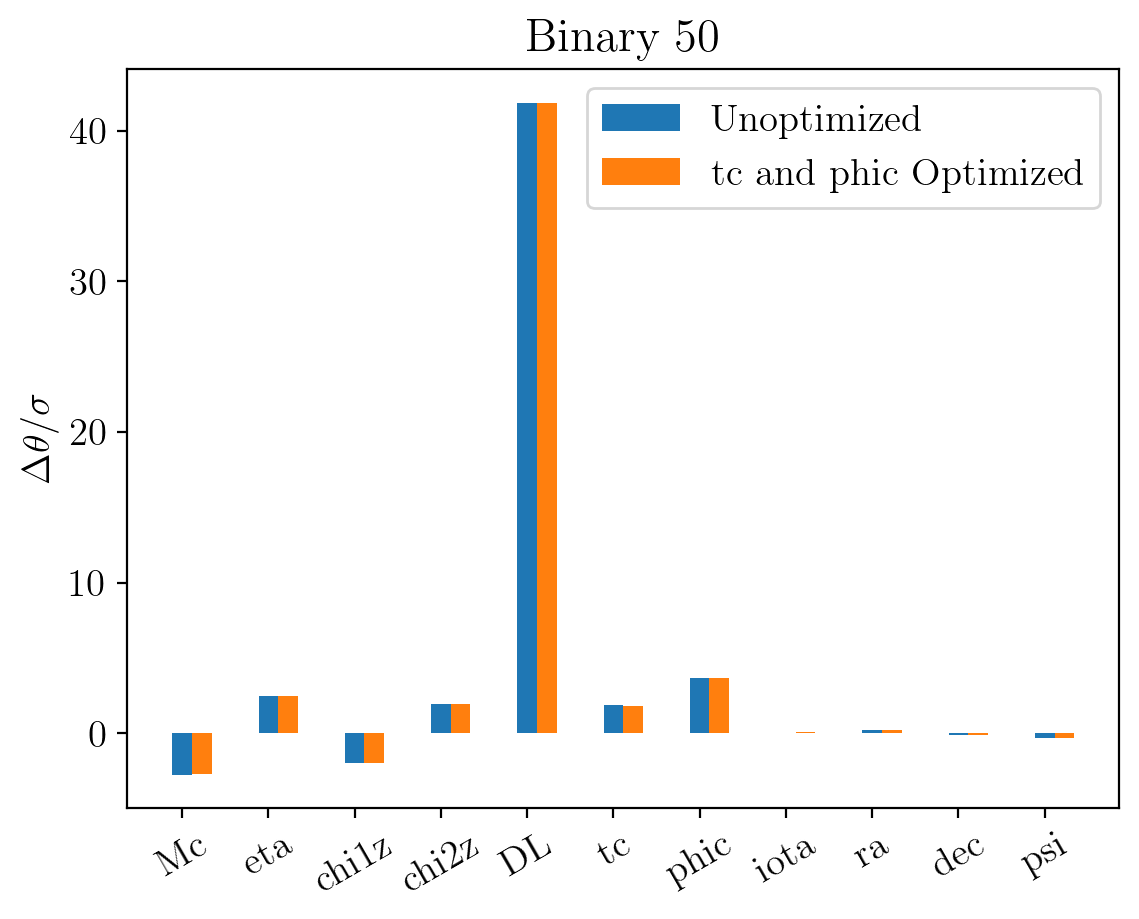

2023-10-17 09:37:14,060 - Network - INFO : Polarizations calculated.
2023-10-17 09:37:14,061 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:37:14,068 - Network - INFO : Polarizations calculated.


######  Binary 51  ######


2023-10-17 09:37:15,493 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:37:15,545 - Network - INFO : PSDs loaded.
2023-10-17 09:37:15,548 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:37:15,582 - Network - INFO : Detector responses calculated.
2023-10-17 09:37:15,583 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:37:15,584 - Network - INFO :    CE-40_C
2023-10-17 09:37:16,629 - Network - INFO :    CE-20_S
2023-10-17 09:37:17,693 - Network - INFO :    ET_ET1
2023-10-17 09:37:18,723 - Network - INFO :    ET_ET2
2023-10-17 09:37:19,766 - Network - INFO :    ET_ET3
2023-10-17 09:37:20,805 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:37:20,808 - Network - INFO : SNRs calculated.
2023-10-17 09:37:20,809 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:37:20,809 - Network - INFO :    CE-40_C
2023-10-17 09:37:20,866 - Network - INFO :

Mc bias diff: 0.33%
Mc, not: 1.740 sigma
Mc, opt: 1.734 sigma

eta bias diff: -0.43%
eta, not: 0.996 sigma
eta, opt: 1.000 sigma

chi1z bias diff: 5.43%
chi1z, not: -0.020 sigma
chi1z, opt: -0.019 sigma

chi2z bias diff: 0.33%
chi2z, not: 0.162 sigma
chi2z, opt: 0.162 sigma

DL bias diff: 0.07%
DL, not: 12.902 sigma
DL, opt: 12.893 sigma

tc bias diff: -0.41%
tc, not: 1.152 sigma
tc, opt: 1.156 sigma

phic bias diff: -1.31%
phic, not: 0.837 sigma
phic, opt: 0.848 sigma

iota bias diff: 3.42%
iota, not: -0.087 sigma
iota, opt: -0.084 sigma

ra bias diff: -2.13%
ra, not: 0.211 sigma
ra, opt: 0.216 sigma

dec bias diff: -3.27%
dec, not: -0.111 sigma
dec, opt: -0.115 sigma

psi bias diff: -1.76%
psi, not: -0.176 sigma
psi, opt: -0.179 sigma

######  Binary 52  ######


2023-10-17 09:37:29,773 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:37:29,823 - Network - INFO : PSDs loaded.
2023-10-17 09:37:29,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:37:29,858 - Network - INFO : Detector responses calculated.
2023-10-17 09:37:29,859 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:37:29,860 - Network - INFO :    CE-40_C
2023-10-17 09:37:30,905 - Network - INFO :    CE-20_S
2023-10-17 09:37:32,009 - Network - INFO :    ET_ET1
2023-10-17 09:37:33,086 - Network - INFO :    ET_ET2
2023-10-17 09:37:34,169 - Network - INFO :    ET_ET3
2023-10-17 09:37:35,257 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:37:35,261 - Network - INFO : SNRs calculated.
2023-10-17 09:37:35,275 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:37:35,280 - Network - INFO :    CE-40_C
2023-10-17 09:37:35,362 - Network - INFO :

Mc bias diff: 0.05%
Mc, not: 3.453 sigma
Mc, opt: 3.451 sigma

eta bias diff: 0.43%
eta, not: 1.540 sigma
eta, opt: 1.534 sigma

chi1z bias diff: 0.20%
chi1z, not: -2.434 sigma
chi1z, opt: -2.429 sigma

chi2z bias diff: 0.26%
chi2z, not: 2.458 sigma
chi2z, opt: 2.452 sigma

DL bias diff: 0.02%
DL, not: 14.023 sigma
DL, opt: 14.020 sigma

tc bias diff: 0.29%
tc, not: 2.452 sigma
tc, opt: 2.445 sigma

phic bias diff: 0.42%
phic, not: 1.523 sigma
phic, opt: 1.517 sigma

iota bias diff: 0.48%
iota, not: 0.227 sigma
iota, opt: 0.226 sigma

ra bias diff: 4.49%
ra, not: -0.119 sigma
ra, opt: -0.114 sigma

dec bias diff: 4.18%
dec, not: -0.099 sigma
dec, opt: -0.095 sigma

psi bias diff: -3.82%
psi, not: 0.040 sigma
psi, opt: 0.042 sigma

######  Binary 53  ######


2023-10-17 09:37:45,364 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:37:45,407 - Network - INFO : PSDs loaded.
2023-10-17 09:37:45,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:37:45,449 - Network - INFO : Detector responses calculated.
2023-10-17 09:37:45,450 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:37:45,451 - Network - INFO :    CE-40_C
2023-10-17 09:37:46,762 - Network - INFO :    CE-20_S
2023-10-17 09:37:48,094 - Network - INFO :    ET_ET1
2023-10-17 09:37:49,425 - Network - INFO :    ET_ET2
2023-10-17 09:37:50,750 - Network - INFO :    ET_ET3
2023-10-17 09:37:52,090 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:37:52,093 - Network - INFO : SNRs calculated.
2023-10-17 09:37:52,094 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:37:52,094 - Network - INFO :    CE-40_C
2023-10-17 09:37:52,151 - Network - INFO :

Mc bias diff: 1.63%
Mc, not: 0.155 sigma
Mc, opt: 0.152 sigma

eta bias diff: 0.19%
eta, not: 0.655 sigma
eta, opt: 0.654 sigma

chi1z bias diff: 0.77%
chi1z, not: -0.612 sigma
chi1z, opt: -0.607 sigma

chi2z bias diff: 0.33%
chi2z, not: 0.591 sigma
chi2z, opt: 0.589 sigma

DL bias diff: 0.01%
DL, not: 9.645 sigma
DL, opt: 9.644 sigma

tc bias diff: 0.44%
tc, not: 0.602 sigma
tc, opt: 0.599 sigma

phic bias diff: -0.33%
phic, not: 0.870 sigma
phic, opt: 0.873 sigma

iota bias diff: -1.35%
iota, not: -0.482 sigma
iota, opt: -0.489 sigma

ra bias diff: -6.60%
ra, not: -0.300 sigma
ra, opt: -0.320 sigma

dec bias diff: -6.82%
dec, not: -0.305 sigma
dec, opt: -0.326 sigma

psi bias diff: 0.30%
psi, not: 0.428 sigma
psi, opt: 0.427 sigma

######  Binary 54  ######


2023-10-17 09:38:03,791 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:38:03,834 - Network - INFO : PSDs loaded.
2023-10-17 09:38:03,837 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:38:03,877 - Network - INFO : Detector responses calculated.
2023-10-17 09:38:03,878 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:38:03,879 - Network - INFO :    CE-40_C
2023-10-17 09:38:05,360 - Network - INFO :    CE-20_S
2023-10-17 09:38:06,854 - Network - INFO :    ET_ET1
2023-10-17 09:38:08,321 - Network - INFO :    ET_ET2
2023-10-17 09:38:09,774 - Network - INFO :    ET_ET3
2023-10-17 09:38:11,262 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:38:11,266 - Network - INFO : SNRs calculated.
2023-10-17 09:38:11,266 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:38:11,267 - Network - INFO :    CE-40_C
2023-10-17 09:38:11,327 - Network - INFO :

Mc bias diff: 0.61%
Mc, not: -1.906 sigma
Mc, opt: -1.894 sigma

eta bias diff: -0.07%
eta, not: 2.190 sigma
eta, opt: 2.191 sigma

chi1z bias diff: -0.63%
chi1z, not: -1.508 sigma
chi1z, opt: -1.518 sigma

chi2z bias diff: -0.95%
chi2z, not: 1.398 sigma
chi2z, opt: 1.411 sigma

DL bias diff: 0.01%
DL, not: 15.789 sigma
DL, opt: 15.787 sigma

tc bias diff: -0.98%
tc, not: 1.472 sigma
tc, opt: 1.486 sigma

phic bias diff: -0.97%
phic, not: 1.724 sigma
phic, opt: 1.740 sigma

iota bias diff: 0.20%
iota, not: -0.105 sigma
iota, opt: -0.104 sigma

ra bias diff: -4.93%
ra, not: 0.101 sigma
ra, opt: 0.106 sigma

dec bias diff: -4.69%
dec, not: -0.087 sigma
dec, opt: -0.092 sigma

psi bias diff: 7.65%
psi, not: -0.068 sigma
psi, opt: -0.063 sigma

######  Binary 55  ######


2023-10-17 09:38:23,333 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:38:23,383 - Network - INFO : PSDs loaded.
2023-10-17 09:38:23,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:38:23,421 - Network - INFO : Detector responses calculated.
2023-10-17 09:38:23,422 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:38:23,423 - Network - INFO :    CE-40_C
2023-10-17 09:38:24,437 - Network - INFO :    CE-20_S
2023-10-17 09:38:25,515 - Network - INFO :    ET_ET1
2023-10-17 09:38:26,559 - Network - INFO :    ET_ET2
2023-10-17 09:38:27,623 - Network - INFO :    ET_ET3
2023-10-17 09:38:28,663 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:38:28,666 - Network - INFO : SNRs calculated.
2023-10-17 09:38:28,666 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:38:28,667 - Network - INFO :    CE-40_C
2023-10-17 09:38:28,730 - Network - INFO :

Mc bias diff: 0.19%
Mc, not: 0.779 sigma
Mc, opt: 0.777 sigma

eta bias diff: 0.08%
eta, not: 0.891 sigma
eta, opt: 0.890 sigma

chi1z bias diff: 0.10%
chi1z, not: -0.978 sigma
chi1z, opt: -0.977 sigma

chi2z bias diff: 0.11%
chi2z, not: 0.979 sigma
chi2z, opt: 0.978 sigma

DL bias diff: -0.14%
DL, not: 0.930 sigma
DL, opt: 0.932 sigma

tc bias diff: 0.11%
tc, not: 0.980 sigma
tc, opt: 0.979 sigma

phic bias diff: 0.03%
phic, not: 0.860 sigma
phic, opt: 0.860 sigma

iota bias diff: 1.35%
iota, not: -0.249 sigma
iota, opt: -0.246 sigma

ra bias diff: -0.30%
ra, not: -0.185 sigma
ra, opt: -0.185 sigma

dec bias diff: 0.18%
dec, not: 0.226 sigma
dec, opt: 0.226 sigma

psi bias diff: 13.85%
psi, not: 0.018 sigma
psi, opt: 0.016 sigma

######  Binary 56  ######


2023-10-17 09:38:38,804 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:38:38,848 - Network - INFO : PSDs loaded.
2023-10-17 09:38:38,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:38:38,891 - Network - INFO : Detector responses calculated.
2023-10-17 09:38:38,892 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:38:38,892 - Network - INFO :    CE-40_C
2023-10-17 09:38:40,339 - Network - INFO :    CE-20_S
2023-10-17 09:38:41,773 - Network - INFO :    ET_ET1
2023-10-17 09:38:43,276 - Network - INFO :    ET_ET2
2023-10-17 09:38:44,757 - Network - INFO :    ET_ET3
2023-10-17 09:38:46,225 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:38:46,229 - Network - INFO : SNRs calculated.
2023-10-17 09:38:46,229 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:38:46,230 - Network - INFO :    CE-40_C
2023-10-17 09:38:46,290 - Network - INFO :

Mc bias diff: 0.32%
Mc, not: -3.057 sigma
Mc, opt: -3.047 sigma

eta bias diff: -0.11%
eta, not: 4.430 sigma
eta, opt: 4.435 sigma

chi1z bias diff: -0.26%
chi1z, not: -3.787 sigma
chi1z, opt: -3.797 sigma

chi2z bias diff: -0.28%
chi2z, not: 3.588 sigma
chi2z, opt: 3.598 sigma

DL bias diff: -0.01%
DL, not: 13.679 sigma
DL, opt: 13.681 sigma

tc bias diff: -0.38%
tc, not: 3.587 sigma
tc, opt: 3.600 sigma

phic bias diff: -0.24%
phic, not: 3.452 sigma
phic, opt: 3.460 sigma

iota bias diff: -3.35%
iota, not: 0.223 sigma
iota, opt: 0.230 sigma

ra bias diff: -1.05%
ra, not: 0.852 sigma
ra, opt: 0.861 sigma

dec bias diff: -1.18%
dec, not: -0.825 sigma
dec, opt: -0.835 sigma

psi bias diff: -1.60%
psi, not: -0.325 sigma
psi, opt: -0.330 sigma

######  Binary 57  ######


2023-10-17 09:38:57,474 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:38:57,546 - Network - INFO : PSDs loaded.
2023-10-17 09:38:57,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:38:57,585 - Network - INFO : Detector responses calculated.
2023-10-17 09:38:57,587 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:38:57,587 - Network - INFO :    CE-40_C
2023-10-17 09:38:58,171 - Network - INFO :    CE-20_S
2023-10-17 09:38:58,753 - Network - INFO :    ET_ET1
2023-10-17 09:38:59,336 - Network - INFO :    ET_ET2
2023-10-17 09:38:59,922 - Network - INFO :    ET_ET3
2023-10-17 09:39:00,508 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:39:00,511 - Network - INFO : SNRs calculated.
2023-10-17 09:39:00,512 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:39:00,513 - Network - INFO :    CE-40_C
2023-10-17 09:39:00,595 - Network - INFO :

Mc bias diff: 4.15%
Mc, not: 1.330 sigma
Mc, opt: 1.275 sigma

eta bias diff: 4.65%
eta, not: -0.460 sigma
eta, opt: -0.438 sigma

chi1z bias diff: -1.94%
chi1z, not: -7.011 sigma
chi1z, opt: -7.147 sigma

chi2z bias diff: -1.93%
chi2z, not: 7.112 sigma
chi2z, opt: 7.249 sigma

DL bias diff: 0.94%
DL, not: 5.778 sigma
DL, opt: 5.724 sigma

tc bias diff: -0.64%
tc, not: 3.536 sigma
tc, opt: 3.559 sigma

phic bias diff: -1.72%
phic, not: 2.941 sigma
phic, opt: 2.991 sigma

iota bias diff: -42.97%
iota, not: -0.429 sigma
iota, opt: -0.613 sigma

ra bias diff: -13.36%
ra, not: -0.428 sigma
ra, opt: -0.485 sigma

dec bias diff: -25.23%
dec, not: -0.496 sigma
dec, opt: -0.622 sigma

psi bias diff: 16.34%
psi, not: 0.306 sigma
psi, opt: 0.256 sigma

######  Binary 58  ######


2023-10-17 09:39:06,118 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:39:06,190 - Network - INFO : PSDs loaded.
2023-10-17 09:39:06,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:39:06,232 - Network - INFO : Detector responses calculated.
2023-10-17 09:39:06,233 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:39:06,234 - Network - INFO :    CE-40_C
2023-10-17 09:39:06,960 - Network - INFO :    CE-20_S
2023-10-17 09:39:07,683 - Network - INFO :    ET_ET1
2023-10-17 09:39:08,405 - Network - INFO :    ET_ET2
2023-10-17 09:39:09,131 - Network - INFO :    ET_ET3
2023-10-17 09:39:09,853 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:39:09,857 - Network - INFO : SNRs calculated.
2023-10-17 09:39:09,858 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:39:09,859 - Network - INFO :    CE-40_C
2023-10-17 09:39:09,939 - Network - INFO :

Mc bias diff: 1.90%
Mc, not: 3.708 sigma
Mc, opt: 3.637 sigma

eta bias diff: -0.25%
eta, not: 7.672 sigma
eta, opt: 7.691 sigma

chi1z bias diff: -0.27%
chi1z, not: -9.369 sigma
chi1z, opt: -9.394 sigma

chi2z bias diff: -0.26%
chi2z, not: 9.633 sigma
chi2z, opt: 9.657 sigma

DL bias diff: 30.84%
DL, not: 1.968 sigma
DL, opt: 1.361 sigma

tc bias diff: -0.25%
tc, not: 9.440 sigma
tc, opt: 9.464 sigma

phic bias diff: 1.59%
phic, not: 3.634 sigma
phic, opt: 3.576 sigma

iota bias diff: -164.08%
iota, not: 1.459 sigma
iota, opt: 3.853 sigma

ra bias diff: 758.04%
ra, not: -0.025 sigma
ra, opt: 0.168 sigma

dec bias diff: -2343.58%
dec, not: 0.006 sigma
dec, opt: 0.154 sigma

psi bias diff: -16.45%
psi, not: -0.580 sigma
psi, opt: -0.675 sigma

######  Binary 59  ######


2023-10-17 09:39:17,470 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:39:17,513 - Network - INFO : PSDs loaded.
2023-10-17 09:39:17,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:39:17,556 - Network - INFO : Detector responses calculated.
2023-10-17 09:39:17,557 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:39:17,558 - Network - INFO :    CE-40_C
2023-10-17 09:39:19,003 - Network - INFO :    CE-20_S
2023-10-17 09:39:20,387 - Network - INFO :    ET_ET1
2023-10-17 09:39:21,796 - Network - INFO :    ET_ET2
2023-10-17 09:39:23,285 - Network - INFO :    ET_ET3
2023-10-17 09:39:24,738 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:39:24,741 - Network - INFO : SNRs calculated.
2023-10-17 09:39:24,742 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:39:24,742 - Network - INFO :    CE-40_C
2023-10-17 09:39:24,801 - Network - INFO :

Mc bias diff: -0.68%
Mc, not: -0.065 sigma
Mc, opt: -0.066 sigma

eta bias diff: 0.99%
eta, not: 0.288 sigma
eta, opt: 0.285 sigma

chi1z bias diff: 1.56%
chi1z, not: -0.229 sigma
chi1z, opt: -0.226 sigma

chi2z bias diff: 3.01%
chi2z, not: 0.216 sigma
chi2z, opt: 0.210 sigma

DL bias diff: 0.04%
DL, not: 13.198 sigma
DL, opt: 13.192 sigma

tc bias diff: 2.43%
tc, not: 0.213 sigma
tc, opt: 0.208 sigma

phic bias diff: 0.50%
phic, not: 0.439 sigma
phic, opt: 0.436 sigma

iota bias diff: 4.62%
iota, not: -0.102 sigma
iota, opt: -0.098 sigma

ra bias diff: -2.49%
ra, not: -0.089 sigma
ra, opt: -0.091 sigma

dec bias diff: 4.02%
dec, not: 0.070 sigma
dec, opt: 0.067 sigma

psi bias diff: -3.05%
psi, not: -0.171 sigma
psi, opt: -0.177 sigma

######  Binary 60  ######


2023-10-17 09:39:37,590 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:39:37,633 - Network - INFO : PSDs loaded.
2023-10-17 09:39:37,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:39:37,677 - Network - INFO : Detector responses calculated.
2023-10-17 09:39:37,678 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:39:37,679 - Network - INFO :    CE-40_C
2023-10-17 09:39:39,242 - Network - INFO :    CE-20_S
2023-10-17 09:39:40,774 - Network - INFO :    ET_ET1
2023-10-17 09:39:42,313 - Network - INFO :    ET_ET2
2023-10-17 09:39:43,856 - Network - INFO :    ET_ET3
2023-10-17 09:39:45,382 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:39:45,385 - Network - INFO : SNRs calculated.
2023-10-17 09:39:45,386 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:39:45,386 - Network - INFO :    CE-40_C
2023-10-17 09:39:45,447 - Network - INFO :

Mc bias diff: -0.25%
Mc, not: -1.254 sigma
Mc, opt: -1.257 sigma

eta bias diff: 0.16%
eta, not: 1.387 sigma
eta, opt: 1.385 sigma

chi1z bias diff: 0.17%
chi1z, not: -1.000 sigma
chi1z, opt: -0.998 sigma

chi2z bias diff: 0.29%
chi2z, not: 0.928 sigma
chi2z, opt: 0.925 sigma

DL bias diff: -0.09%
DL, not: 10.132 sigma
DL, opt: 10.141 sigma

tc bias diff: 0.20%
tc, not: 0.924 sigma
tc, opt: 0.922 sigma

phic bias diff: -0.49%
phic, not: 1.324 sigma
phic, opt: 1.331 sigma

iota bias diff: -0.87%
iota, not: 0.211 sigma
iota, opt: 0.213 sigma

ra bias diff: 4.24%
ra, not: 0.089 sigma
ra, opt: 0.086 sigma

dec bias diff: 3.01%
dec, not: -0.059 sigma
dec, opt: -0.057 sigma

psi bias diff: -2.76%
psi, not: -0.049 sigma
psi, opt: -0.050 sigma



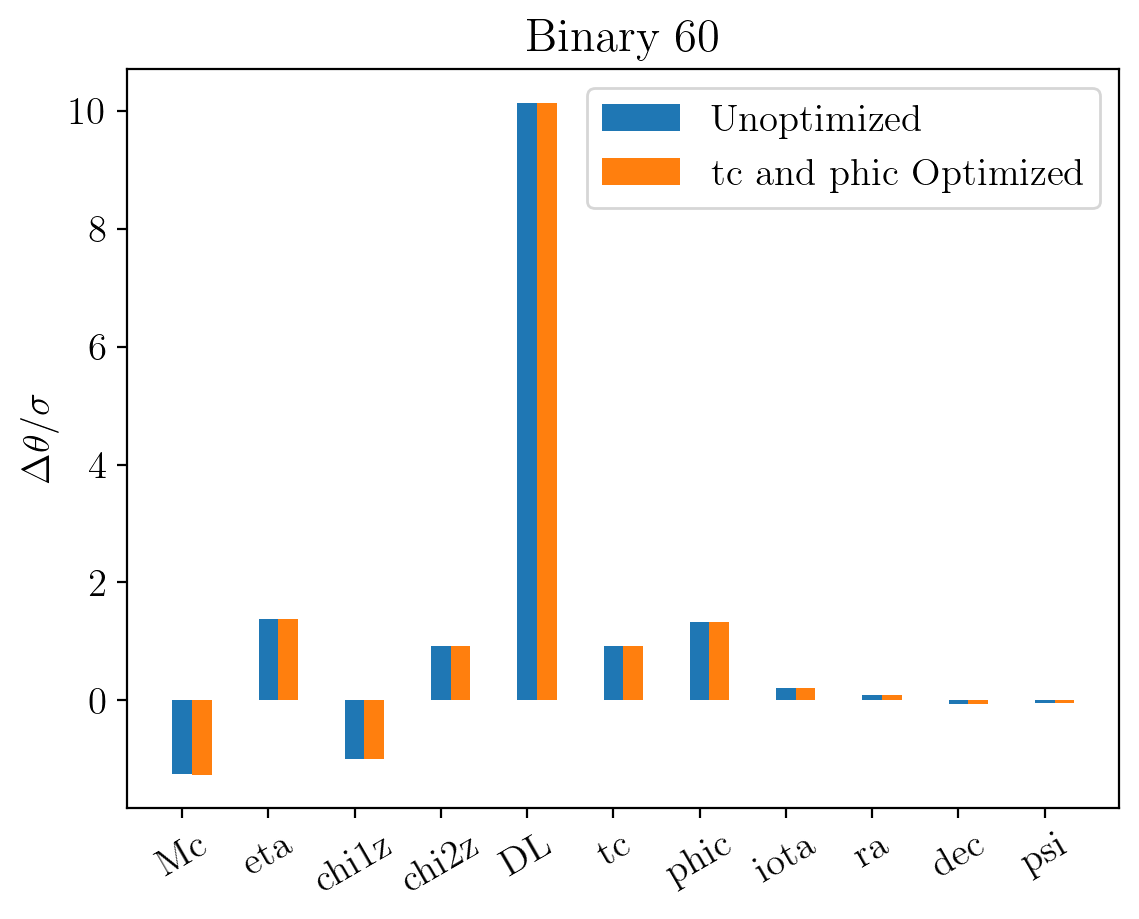

2023-10-17 09:39:56,608 - Network - INFO : Polarizations calculated.
2023-10-17 09:39:56,609 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:39:56,616 - Network - INFO : Polarizations calculated.


######  Binary 61  ######


2023-10-17 09:39:57,502 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:39:57,574 - Network - INFO : PSDs loaded.
2023-10-17 09:39:57,578 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:39:57,616 - Network - INFO : Detector responses calculated.
2023-10-17 09:39:57,617 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:39:57,618 - Network - INFO :    CE-40_C
2023-10-17 09:39:58,281 - Network - INFO :    CE-20_S
2023-10-17 09:39:59,123 - Network - INFO :    ET_ET1
2023-10-17 09:39:59,792 - Network - INFO :    ET_ET2
2023-10-17 09:40:00,433 - Network - INFO :    ET_ET3
2023-10-17 09:40:01,088 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:40:01,091 - Network - INFO : SNRs calculated.
2023-10-17 09:40:01,092 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:40:01,093 - Network - INFO :    CE-40_C
2023-10-17 09:40:01,173 - Network - INFO :

Mc bias diff: 0.23%
Mc, not: 2.816 sigma
Mc, opt: 2.810 sigma

eta bias diff: -0.05%
eta, not: 5.897 sigma
eta, opt: 5.899 sigma

chi1z bias diff: -0.07%
chi1z, not: -6.113 sigma
chi1z, opt: -6.117 sigma

chi2z bias diff: -0.06%
chi2z, not: 6.110 sigma
chi2z, opt: 6.114 sigma

DL bias diff: 0.01%
DL, not: 18.658 sigma
DL, opt: 18.656 sigma

tc bias diff: -0.08%
tc, not: 6.001 sigma
tc, opt: 6.006 sigma

phic bias diff: -0.09%
phic, not: 5.861 sigma
phic, opt: 5.867 sigma

iota bias diff: -1.27%
iota, not: -0.236 sigma
iota, opt: -0.239 sigma

ra bias diff: -3.23%
ra, not: -0.089 sigma
ra, opt: -0.091 sigma

dec bias diff: -0.18%
dec, not: 0.431 sigma
dec, opt: 0.432 sigma

psi bias diff: -0.89%
psi, not: 0.406 sigma
psi, opt: 0.410 sigma

######  Binary 62  ######


2023-10-17 09:40:06,929 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:40:07,002 - Network - INFO : PSDs loaded.
2023-10-17 09:40:07,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:40:07,042 - Network - INFO : Detector responses calculated.
2023-10-17 09:40:07,043 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:40:07,044 - Network - INFO :    CE-40_C
2023-10-17 09:40:07,556 - Network - INFO :    CE-20_S
2023-10-17 09:40:08,067 - Network - INFO :    ET_ET1
2023-10-17 09:40:08,577 - Network - INFO :    ET_ET2
2023-10-17 09:40:09,092 - Network - INFO :    ET_ET3
2023-10-17 09:40:09,911 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:40:09,914 - Network - INFO : SNRs calculated.
2023-10-17 09:40:09,915 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:40:09,915 - Network - INFO :    CE-40_C
2023-10-17 09:40:09,989 - Network - INFO :

Mc bias diff: -0.04%
Mc, not: -6.639 sigma
Mc, opt: -6.642 sigma

eta bias diff: 0.21%
eta, not: 10.158 sigma
eta, opt: 10.137 sigma

chi1z bias diff: 0.21%
chi1z, not: -10.933 sigma
chi1z, opt: -10.910 sigma

chi2z bias diff: 0.22%
chi2z, not: 11.419 sigma
chi2z, opt: 11.394 sigma

DL bias diff: 0.10%
DL, not: 18.889 sigma
DL, opt: 18.869 sigma

tc bias diff: 0.22%
tc, not: 11.229 sigma
tc, opt: 11.205 sigma

phic bias diff: 0.18%
phic, not: 11.198 sigma
phic, opt: 11.178 sigma

iota bias diff: 8.59%
iota, not: 0.198 sigma
iota, opt: 0.181 sigma

ra bias diff: 0.14%
ra, not: 1.652 sigma
ra, opt: 1.650 sigma

dec bias diff: 0.19%
dec, not: 1.457 sigma
dec, opt: 1.454 sigma

psi bias diff: 1.02%
psi, not: -0.302 sigma
psi, opt: -0.299 sigma

######  Binary 63  ######


2023-10-17 09:40:15,886 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:40:15,959 - Network - INFO : PSDs loaded.
2023-10-17 09:40:15,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:40:15,999 - Network - INFO : Detector responses calculated.
2023-10-17 09:40:15,999 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:40:16,000 - Network - INFO :    CE-40_C
2023-10-17 09:40:16,820 - Network - INFO :    CE-20_S
2023-10-17 09:40:17,646 - Network - INFO :    ET_ET1
2023-10-17 09:40:18,468 - Network - INFO :    ET_ET2
2023-10-17 09:40:19,291 - Network - INFO :    ET_ET3
2023-10-17 09:40:20,110 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:40:20,114 - Network - INFO : SNRs calculated.
2023-10-17 09:40:20,115 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:40:20,115 - Network - INFO :    CE-40_C
2023-10-17 09:40:20,179 - Network - INFO :

Mc bias diff: 0.26%
Mc, not: 3.973 sigma
Mc, opt: 3.962 sigma

eta bias diff: -0.08%
eta, not: 5.455 sigma
eta, opt: 5.459 sigma

chi1z bias diff: -0.06%
chi1z, not: -5.820 sigma
chi1z, opt: -5.824 sigma

chi2z bias diff: -0.05%
chi2z, not: 5.866 sigma
chi2z, opt: 5.869 sigma

DL bias diff: -0.01%
DL, not: 28.191 sigma
DL, opt: 28.193 sigma

tc bias diff: -0.06%
tc, not: 5.787 sigma
tc, opt: 5.790 sigma

phic bias diff: -0.09%
phic, not: 5.659 sigma
phic, opt: 5.664 sigma

iota bias diff: -15.60%
iota, not: 0.032 sigma
iota, opt: 0.037 sigma

ra bias diff: 907.72%
ra, not: -0.000 sigma
ra, opt: 0.003 sigma

dec bias diff: 0.21%
dec, not: -0.653 sigma
dec, opt: -0.652 sigma

psi bias diff: 27.86%
psi, not: -0.030 sigma
psi, opt: -0.021 sigma

######  Binary 64  ######


2023-10-17 09:40:32,151 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:40:32,200 - Network - INFO : PSDs loaded.
2023-10-17 09:40:32,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:40:32,248 - Network - INFO : Detector responses calculated.
2023-10-17 09:40:32,249 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:40:32,250 - Network - INFO :    CE-40_C
2023-10-17 09:40:33,529 - Network - INFO :    CE-20_S
2023-10-17 09:40:34,810 - Network - INFO :    ET_ET1
2023-10-17 09:40:36,130 - Network - INFO :    ET_ET2
2023-10-17 09:40:37,414 - Network - INFO :    ET_ET3
2023-10-17 09:40:38,753 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:40:38,757 - Network - INFO : SNRs calculated.
2023-10-17 09:40:38,757 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:40:38,758 - Network - INFO :    CE-40_C
2023-10-17 09:40:38,817 - Network - INFO :

Mc bias diff: 0.15%
Mc, not: 0.285 sigma
Mc, opt: 0.285 sigma

eta bias diff: 1.02%
eta, not: -0.097 sigma
eta, opt: -0.096 sigma

chi1z bias diff: -0.30%
chi1z, not: 0.297 sigma
chi1z, opt: 0.298 sigma

chi2z bias diff: 1.23%
chi2z, not: -0.324 sigma
chi2z, opt: -0.320 sigma

DL bias diff: 0.07%
DL, not: 6.564 sigma
DL, opt: 6.560 sigma

tc bias diff: 0.98%
tc, not: -0.352 sigma
tc, opt: -0.349 sigma

phic bias diff: -3.64%
phic, not: 0.396 sigma
phic, opt: 0.411 sigma

iota bias diff: 2.10%
iota, not: 0.295 sigma
iota, opt: 0.289 sigma

ra bias diff: -4.87%
ra, not: 0.174 sigma
ra, opt: 0.182 sigma

dec bias diff: -4.92%
dec, not: 0.182 sigma
dec, opt: 0.191 sigma

psi bias diff: -4.38%
psi, not: 0.195 sigma
psi, opt: 0.203 sigma

######  Binary 65  ######


2023-10-17 09:40:51,997 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:40:52,042 - Network - INFO : PSDs loaded.
2023-10-17 09:40:52,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:40:52,079 - Network - INFO : Detector responses calculated.
2023-10-17 09:40:52,080 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:40:52,080 - Network - INFO :    CE-40_C
2023-10-17 09:40:53,011 - Network - INFO :    CE-20_S
2023-10-17 09:40:54,109 - Network - INFO :    ET_ET1
2023-10-17 09:40:55,316 - Network - INFO :    ET_ET2
2023-10-17 09:40:56,467 - Network - INFO :    ET_ET3
2023-10-17 09:40:57,640 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:40:57,644 - Network - INFO : SNRs calculated.
2023-10-17 09:40:57,644 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:40:57,645 - Network - INFO :    CE-40_C
2023-10-17 09:40:57,711 - Network - INFO :

Mc bias diff: 0.16%
Mc, not: -2.169 sigma
Mc, opt: -2.165 sigma

eta bias diff: 0.03%
eta, not: 4.856 sigma
eta, opt: 4.855 sigma

chi1z bias diff: 0.06%
chi1z, not: -2.962 sigma
chi1z, opt: -2.960 sigma

chi2z bias diff: 0.08%
chi2z, not: 2.384 sigma
chi2z, opt: 2.382 sigma

DL bias diff: -0.01%
DL, not: 21.879 sigma
DL, opt: 21.881 sigma

tc bias diff: 0.08%
tc, not: 2.566 sigma
tc, opt: 2.564 sigma

phic bias diff: 0.25%
phic, not: 2.981 sigma
phic, opt: 2.974 sigma

iota bias diff: -4.03%
iota, not: 0.104 sigma
iota, opt: 0.108 sigma

ra bias diff: -4.64%
ra, not: -0.056 sigma
ra, opt: -0.059 sigma

dec bias diff: 5.72%
dec, not: 0.021 sigma
dec, opt: 0.020 sigma

psi bias diff: 0.84%
psi, not: -0.463 sigma
psi, opt: -0.459 sigma

######  Binary 66  ######


2023-10-17 09:41:09,361 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:41:09,406 - Network - INFO : PSDs loaded.
2023-10-17 09:41:09,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:41:09,459 - Network - INFO : Detector responses calculated.
2023-10-17 09:41:09,459 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:41:09,460 - Network - INFO :    CE-40_C
2023-10-17 09:41:11,646 - Network - INFO :    CE-20_S
2023-10-17 09:41:13,756 - Network - INFO :    ET_ET1
2023-10-17 09:41:15,852 - Network - INFO :    ET_ET2
2023-10-17 09:41:17,953 - Network - INFO :    ET_ET3
2023-10-17 09:41:20,070 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:41:20,075 - Network - INFO : SNRs calculated.
2023-10-17 09:41:20,075 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:41:20,075 - Network - INFO :    CE-40_C
2023-10-17 09:41:20,142 - Network - INFO :

Mc bias diff: -0.24%
Mc, not: -8.993 sigma
Mc, opt: -9.014 sigma

eta bias diff: -0.17%
eta, not: 7.972 sigma
eta, opt: 7.985 sigma

chi1z bias diff: -0.32%
chi1z, not: -6.606 sigma
chi1z, opt: -6.627 sigma

chi2z bias diff: 0.06%
chi2z, not: 6.174 sigma
chi2z, opt: 6.170 sigma

DL bias diff: -0.10%
DL, not: 17.309 sigma
DL, opt: 17.327 sigma

tc bias diff: -0.19%
tc, not: 6.200 sigma
tc, opt: 6.211 sigma

phic bias diff: -0.42%
phic, not: 4.658 sigma
phic, opt: 4.678 sigma

iota bias diff: 0.18%
iota, not: 0.554 sigma
iota, opt: 0.553 sigma

ra bias diff: -1.74%
ra, not: -0.402 sigma
ra, opt: -0.409 sigma

dec bias diff: -11.49%
dec, not: -0.012 sigma
dec, opt: -0.013 sigma

psi bias diff: 1.41%
psi, not: -0.807 sigma
psi, opt: -0.796 sigma

######  Binary 67  ######


2023-10-17 09:41:37,458 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:41:37,503 - Network - INFO : PSDs loaded.
2023-10-17 09:41:37,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:41:37,551 - Network - INFO : Detector responses calculated.
2023-10-17 09:41:37,552 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:41:37,552 - Network - INFO :    CE-40_C
2023-10-17 09:41:39,235 - Network - INFO :    CE-20_S
2023-10-17 09:41:40,807 - Network - INFO :    ET_ET1
2023-10-17 09:41:42,386 - Network - INFO :    ET_ET2
2023-10-17 09:41:43,980 - Network - INFO :    ET_ET3
2023-10-17 09:41:45,556 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:41:45,559 - Network - INFO : SNRs calculated.
2023-10-17 09:41:45,560 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:41:45,560 - Network - INFO :    CE-40_C
2023-10-17 09:41:45,621 - Network - INFO :

Mc bias diff: 1.16%
Mc, not: -0.713 sigma
Mc, opt: -0.705 sigma

eta bias diff: 2.80%
eta, not: 0.351 sigma
eta, opt: 0.341 sigma

chi1z bias diff: -2.75%
chi1z, not: 0.456 sigma
chi1z, opt: 0.468 sigma

chi2z bias diff: -0.93%
chi2z, not: -0.644 sigma
chi2z, opt: -0.650 sigma

DL bias diff: 0.01%
DL, not: 10.882 sigma
DL, opt: 10.881 sigma

tc bias diff: -0.46%
tc, not: -0.620 sigma
tc, opt: -0.622 sigma

phic bias diff: -0.59%
phic, not: 0.327 sigma
phic, opt: 0.329 sigma

iota bias diff: -6.05%
iota, not: 0.337 sigma
iota, opt: 0.357 sigma

ra bias diff: 0.62%
ra, not: -0.111 sigma
ra, opt: -0.110 sigma

dec bias diff: 4.56%
dec, not: 0.096 sigma
dec, opt: 0.091 sigma

psi bias diff: -0.58%
psi, not: 0.443 sigma
psi, opt: 0.445 sigma

######  Binary 68  ######


2023-10-17 09:41:57,534 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:41:57,703 - Network - INFO : PSDs loaded.
2023-10-17 09:41:57,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:41:57,735 - Network - INFO : Detector responses calculated.
2023-10-17 09:41:57,735 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:41:57,736 - Network - INFO :    CE-40_C
2023-10-17 09:41:58,412 - Network - INFO :    CE-20_S
2023-10-17 09:41:59,145 - Network - INFO :    ET_ET1
2023-10-17 09:41:59,877 - Network - INFO :    ET_ET2
2023-10-17 09:42:00,613 - Network - INFO :    ET_ET3
2023-10-17 09:42:01,341 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:42:01,345 - Network - INFO : SNRs calculated.
2023-10-17 09:42:01,346 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:42:01,346 - Network - INFO :    CE-40_C
2023-10-17 09:42:01,422 - Network - INFO :

Mc bias diff: -1.81%
Mc, not: 6.252 sigma
Mc, opt: 6.365 sigma

eta bias diff: 0.33%
eta, not: 22.898 sigma
eta, opt: 22.822 sigma

chi1z bias diff: 0.37%
chi1z, not: -29.236 sigma
chi1z, opt: -29.129 sigma

chi2z bias diff: 0.35%
chi2z, not: 30.543 sigma
chi2z, opt: 30.435 sigma

DL bias diff: -5.75%
DL, not: 4.724 sigma
DL, opt: 4.996 sigma

tc bias diff: 0.36%
tc, not: 30.241 sigma
tc, opt: 30.131 sigma

phic bias diff: 15.90%
phic, not: 0.491 sigma
phic, opt: 0.413 sigma

iota bias diff: -52.44%
iota, not: -1.400 sigma
iota, opt: -2.134 sigma

ra bias diff: 9.94%
ra, not: -0.630 sigma
ra, opt: -0.567 sigma

dec bias diff: -3.14%
dec, not: -2.134 sigma
dec, opt: -2.200 sigma

psi bias diff: -97.40%
psi, not: -0.077 sigma
psi, opt: -0.152 sigma

######  Binary 69  ######


2023-10-17 09:42:08,888 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:42:08,931 - Network - INFO : PSDs loaded.
2023-10-17 09:42:08,934 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:42:08,969 - Network - INFO : Detector responses calculated.
2023-10-17 09:42:08,970 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:42:08,970 - Network - INFO :    CE-40_C
2023-10-17 09:42:10,248 - Network - INFO :    CE-20_S
2023-10-17 09:42:11,602 - Network - INFO :    ET_ET1
2023-10-17 09:42:13,170 - Network - INFO :    ET_ET2
2023-10-17 09:42:15,059 - Network - INFO :    ET_ET3
2023-10-17 09:42:16,905 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:42:16,908 - Network - INFO : SNRs calculated.
2023-10-17 09:42:16,909 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:42:16,909 - Network - INFO :    CE-40_C
2023-10-17 09:42:16,969 - Network - INFO :

Mc bias diff: -2.82%
Mc, not: 0.259 sigma
Mc, opt: 0.266 sigma

eta bias diff: -1.36%
eta, not: 0.424 sigma
eta, opt: 0.430 sigma

chi1z bias diff: -1.52%
chi1z, not: -0.380 sigma
chi1z, opt: -0.386 sigma

chi2z bias diff: -2.06%
chi2z, not: 0.368 sigma
chi2z, opt: 0.376 sigma

DL bias diff: 0.01%
DL, not: 16.574 sigma
DL, opt: 16.573 sigma

tc bias diff: -1.80%
tc, not: 0.361 sigma
tc, opt: 0.367 sigma

phic bias diff: 0.04%
phic, not: 1.013 sigma
phic, opt: 1.012 sigma

iota bias diff: -3.37%
iota, not: -0.119 sigma
iota, opt: -0.123 sigma

ra bias diff: 1.70%
ra, not: 0.140 sigma
ra, opt: 0.138 sigma

dec bias diff: 5.77%
dec, not: 0.083 sigma
dec, opt: 0.078 sigma

psi bias diff: 0.07%
psi, not: -0.127 sigma
psi, opt: -0.127 sigma

######  Binary 70  ######


2023-10-17 09:42:31,228 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:42:31,284 - Network - INFO : PSDs loaded.
2023-10-17 09:42:31,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:42:31,326 - Network - INFO : Detector responses calculated.
2023-10-17 09:42:31,327 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:42:31,328 - Network - INFO :    CE-40_C
2023-10-17 09:42:32,499 - Network - INFO :    CE-20_S
2023-10-17 09:42:33,693 - Network - INFO :    ET_ET1
2023-10-17 09:42:34,763 - Network - INFO :    ET_ET2
2023-10-17 09:42:36,196 - Network - INFO :    ET_ET3
2023-10-17 09:42:37,430 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:42:37,436 - Network - INFO : SNRs calculated.
2023-10-17 09:42:37,437 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:42:37,438 - Network - INFO :    CE-40_C
2023-10-17 09:42:37,535 - Network - INFO :

Mc bias diff: 0.13%
Mc, not: 3.965 sigma
Mc, opt: 3.960 sigma

eta bias diff: 0.11%
eta, not: 2.085 sigma
eta, opt: 2.082 sigma

chi1z bias diff: -0.67%
chi1z, not: -3.056 sigma
chi1z, opt: -3.077 sigma

chi2z bias diff: -0.64%
chi2z, not: 3.033 sigma
chi2z, opt: 3.052 sigma

DL bias diff: 0.01%
DL, not: 11.554 sigma
DL, opt: 11.554 sigma

tc bias diff: -0.49%
tc, not: 3.515 sigma
tc, opt: 3.532 sigma

phic bias diff: -0.64%
phic, not: 2.717 sigma
phic, opt: 2.734 sigma

iota bias diff: -0.37%
iota, not: 0.558 sigma
iota, opt: 0.560 sigma

ra bias diff: 2.95%
ra, not: 0.220 sigma
ra, opt: 0.214 sigma

dec bias diff: 0.51%
dec, not: 0.358 sigma
dec, opt: 0.356 sigma

psi bias diff: -0.39%
psi, not: -0.711 sigma
psi, opt: -0.714 sigma



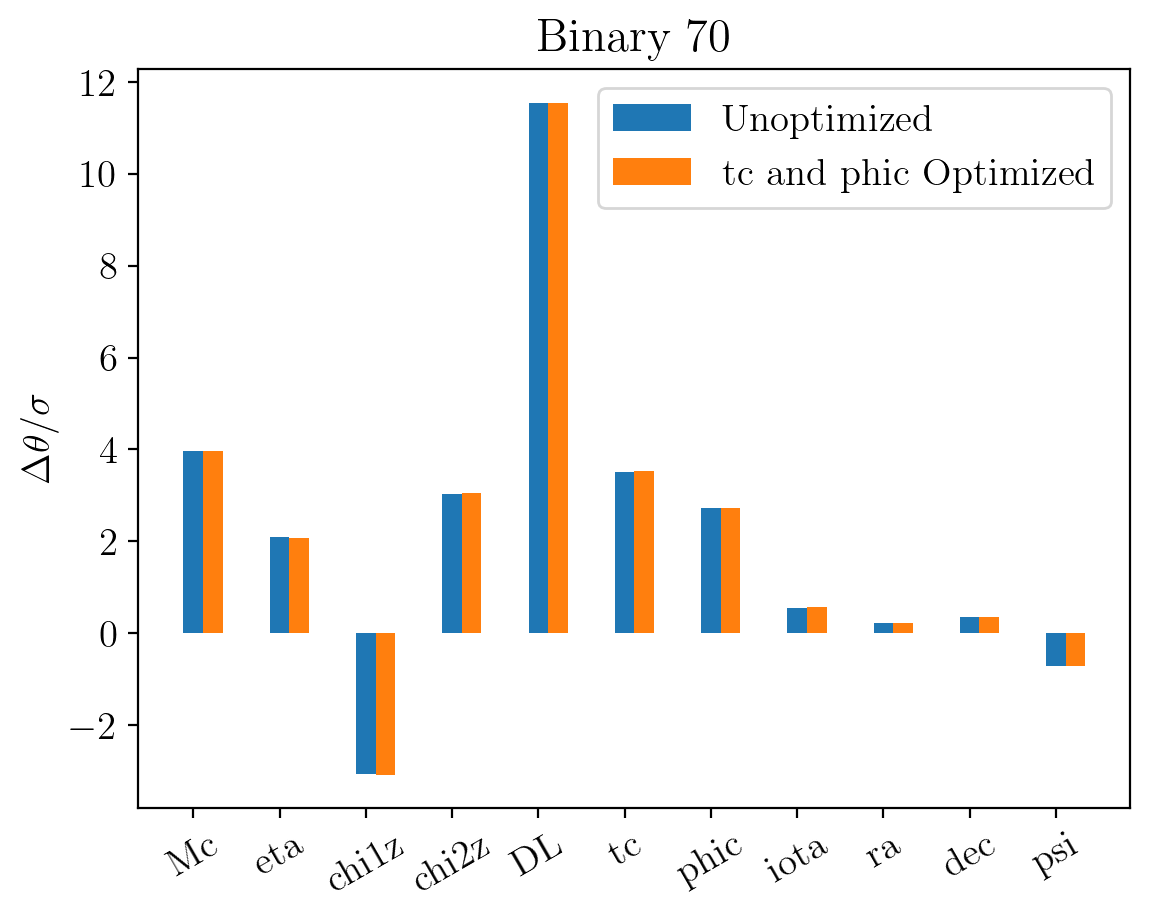

2023-10-17 09:42:47,578 - Network - INFO : Polarizations calculated.
2023-10-17 09:42:47,578 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:42:47,590 - Network - INFO : Polarizations calculated.


######  Binary 71  ######


2023-10-17 09:42:50,163 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:42:50,215 - Network - INFO : PSDs loaded.
2023-10-17 09:42:50,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:42:50,262 - Network - INFO : Detector responses calculated.
2023-10-17 09:42:50,263 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:42:50,263 - Network - INFO :    CE-40_C
2023-10-17 09:42:52,131 - Network - INFO :    CE-20_S
2023-10-17 09:42:53,959 - Network - INFO :    ET_ET1
2023-10-17 09:42:55,869 - Network - INFO :    ET_ET2
2023-10-17 09:42:57,500 - Network - INFO :    ET_ET3
2023-10-17 09:42:59,164 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:42:59,168 - Network - INFO : SNRs calculated.
2023-10-17 09:42:59,169 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:42:59,169 - Network - INFO :    CE-40_C
2023-10-17 09:42:59,231 - Network - INFO :

Mc bias diff: 0.75%
Mc, not: -0.890 sigma
Mc, opt: -0.883 sigma

eta bias diff: 0.55%
eta, not: 1.202 sigma
eta, opt: 1.196 sigma

chi1z bias diff: 0.53%
chi1z, not: -1.101 sigma
chi1z, opt: -1.095 sigma

chi2z bias diff: 0.45%
chi2z, not: 1.068 sigma
chi2z, opt: 1.063 sigma

DL bias diff: 0.03%
DL, not: 17.483 sigma
DL, opt: 17.478 sigma

tc bias diff: 0.19%
tc, not: 1.053 sigma
tc, opt: 1.051 sigma

phic bias diff: 1.20%
phic, not: 0.927 sigma
phic, opt: 0.916 sigma

iota bias diff: 1.42%
iota, not: 0.054 sigma
iota, opt: 0.053 sigma

ra bias diff: 18.11%
ra, not: 0.025 sigma
ra, opt: 0.021 sigma

dec bias diff: 5.16%
dec, not: 0.036 sigma
dec, opt: 0.034 sigma

psi bias diff: -6.64%
psi, not: -0.052 sigma
psi, opt: -0.055 sigma

######  Binary 72  ######


2023-10-17 09:43:11,553 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:43:11,625 - Network - INFO : PSDs loaded.
2023-10-17 09:43:11,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:43:11,700 - Network - INFO : Detector responses calculated.
2023-10-17 09:43:11,701 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:43:11,702 - Network - INFO :    CE-40_C
2023-10-17 09:43:12,602 - Network - INFO :    CE-20_S
2023-10-17 09:43:13,340 - Network - INFO :    ET_ET1
2023-10-17 09:43:14,055 - Network - INFO :    ET_ET2
2023-10-17 09:43:14,797 - Network - INFO :    ET_ET3
2023-10-17 09:43:15,657 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:43:15,661 - Network - INFO : SNRs calculated.
2023-10-17 09:43:15,662 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:43:15,663 - Network - INFO :    CE-40_C
2023-10-17 09:43:15,743 - Network - INFO :

Mc bias diff: -1.53%
Mc, not: 5.829 sigma
Mc, opt: 5.918 sigma

eta bias diff: 0.33%
eta, not: 9.031 sigma
eta, opt: 9.001 sigma

chi1z bias diff: 0.29%
chi1z, not: -11.738 sigma
chi1z, opt: -11.704 sigma

chi2z bias diff: 0.28%
chi2z, not: 12.008 sigma
chi2z, opt: 11.975 sigma

DL bias diff: 10.19%
DL, not: 3.266 sigma
DL, opt: 2.933 sigma

tc bias diff: 0.30%
tc, not: 11.934 sigma
tc, opt: 11.898 sigma

phic bias diff: 0.03%
phic, not: 4.528 sigma
phic, opt: 4.527 sigma

iota bias diff: 683.08%
iota, not: -0.074 sigma
iota, opt: 0.433 sigma

ra bias diff: -49.29%
ra, not: 0.523 sigma
ra, opt: 0.781 sigma

dec bias diff: -43.28%
dec, not: 0.680 sigma
dec, opt: 0.974 sigma

psi bias diff: 3.02%
psi, not: -0.403 sigma
psi, opt: -0.391 sigma

######  Binary 73  ######


2023-10-17 09:43:23,456 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:43:23,580 - Network - INFO : PSDs loaded.
2023-10-17 09:43:23,583 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:43:23,621 - Network - INFO : Detector responses calculated.
2023-10-17 09:43:23,622 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:43:23,623 - Network - INFO :    CE-40_C
2023-10-17 09:43:25,017 - Network - INFO :    CE-20_S
2023-10-17 09:43:26,432 - Network - INFO :    ET_ET1
2023-10-17 09:43:27,863 - Network - INFO :    ET_ET2
2023-10-17 09:43:29,300 - Network - INFO :    ET_ET3
2023-10-17 09:43:30,711 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:43:30,714 - Network - INFO : SNRs calculated.
2023-10-17 09:43:30,714 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:43:30,715 - Network - INFO :    CE-40_C
2023-10-17 09:43:30,773 - Network - INFO :

Mc bias diff: 5.91%
Mc, not: 0.375 sigma
Mc, opt: 0.353 sigma

eta bias diff: -0.21%
eta, not: 1.941 sigma
eta, opt: 1.946 sigma

chi1z bias diff: -0.35%
chi1z, not: -1.975 sigma
chi1z, opt: -1.982 sigma

chi2z bias diff: -2.41%
chi2z, not: 1.952 sigma
chi2z, opt: 1.999 sigma

DL bias diff: 0.00%
DL, not: 14.936 sigma
DL, opt: 14.936 sigma

tc bias diff: -0.60%
tc, not: 1.762 sigma
tc, opt: 1.773 sigma

phic bias diff: 0.04%
phic, not: 1.538 sigma
phic, opt: 1.538 sigma

iota bias diff: 0.94%
iota, not: -0.429 sigma
iota, opt: -0.425 sigma

ra bias diff: 2.90%
ra, not: -0.088 sigma
ra, opt: -0.085 sigma

dec bias diff: 2.33%
dec, not: 0.097 sigma
dec, opt: 0.095 sigma

psi bias diff: 2.75%
psi, not: -0.430 sigma
psi, opt: -0.418 sigma

######  Binary 74  ######


2023-10-17 09:43:42,691 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:43:42,735 - Network - INFO : PSDs loaded.
2023-10-17 09:43:42,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:43:42,779 - Network - INFO : Detector responses calculated.
2023-10-17 09:43:42,780 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:43:42,780 - Network - INFO :    CE-40_C
2023-10-17 09:43:44,321 - Network - INFO :    CE-20_S
2023-10-17 09:43:45,866 - Network - INFO :    ET_ET1
2023-10-17 09:43:47,400 - Network - INFO :    ET_ET2
2023-10-17 09:43:48,906 - Network - INFO :    ET_ET3
2023-10-17 09:43:50,422 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:43:50,425 - Network - INFO : SNRs calculated.
2023-10-17 09:43:50,426 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:43:50,426 - Network - INFO :    CE-40_C
2023-10-17 09:43:50,487 - Network - INFO :

Mc bias diff: 0.13%
Mc, not: -4.041 sigma
Mc, opt: -4.036 sigma

eta bias diff: 0.09%
eta, not: 3.832 sigma
eta, opt: 3.829 sigma

chi1z bias diff: 0.12%
chi1z, not: -2.083 sigma
chi1z, opt: -2.081 sigma

chi2z bias diff: 0.11%
chi2z, not: 1.904 sigma
chi2z, opt: 1.902 sigma

DL bias diff: 0.04%
DL, not: 29.546 sigma
DL, opt: 29.535 sigma

tc bias diff: 0.11%
tc, not: 2.125 sigma
tc, opt: 2.123 sigma

phic bias diff: 0.12%
phic, not: 3.874 sigma
phic, opt: 3.870 sigma

iota bias diff: -4.53%
iota, not: -0.128 sigma
iota, opt: -0.133 sigma

ra bias diff: 8.26%
ra, not: 0.053 sigma
ra, opt: 0.049 sigma

dec bias diff: 1.74%
dec, not: 0.343 sigma
dec, opt: 0.337 sigma

psi bias diff: -0.36%
psi, not: -0.367 sigma
psi, opt: -0.369 sigma

######  Binary 75  ######


2023-10-17 09:44:03,527 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:44:03,571 - Network - INFO : PSDs loaded.
2023-10-17 09:44:03,574 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:44:03,616 - Network - INFO : Detector responses calculated.
2023-10-17 09:44:03,617 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:44:03,617 - Network - INFO :    CE-40_C
2023-10-17 09:44:05,218 - Network - INFO :    CE-20_S
2023-10-17 09:44:06,774 - Network - INFO :    ET_ET1
2023-10-17 09:44:08,333 - Network - INFO :    ET_ET2
2023-10-17 09:44:09,885 - Network - INFO :    ET_ET3
2023-10-17 09:44:11,949 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:44:11,953 - Network - INFO : SNRs calculated.
2023-10-17 09:44:11,954 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:44:11,954 - Network - INFO :    CE-40_C
2023-10-17 09:44:12,016 - Network - INFO :

Mc bias diff: -32.53%
Mc, not: 0.025 sigma
Mc, opt: 0.033 sigma

eta bias diff: -1.85%
eta, not: -0.559 sigma
eta, opt: -0.569 sigma

chi1z bias diff: -0.22%
chi1z, not: 2.297 sigma
chi1z, opt: 2.302 sigma

chi2z bias diff: -0.31%
chi2z, not: -2.229 sigma
chi2z, opt: -2.236 sigma

DL bias diff: 0.01%
DL, not: 42.521 sigma
DL, opt: 42.516 sigma

tc bias diff: -0.54%
tc, not: -1.522 sigma
tc, opt: -1.530 sigma

phic bias diff: 2.28%
phic, not: 0.519 sigma
phic, opt: 0.507 sigma

iota bias diff: -19.45%
iota, not: -0.044 sigma
iota, opt: -0.052 sigma

ra bias diff: -2.17%
ra, not: 0.043 sigma
ra, opt: 0.044 sigma

dec bias diff: -2.81%
dec, not: -0.045 sigma
dec, opt: -0.046 sigma

psi bias diff: -0.99%
psi, not: -0.227 sigma
psi, opt: -0.230 sigma

######  Binary 76  ######


2023-10-17 09:44:26,693 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:44:26,737 - Network - INFO : PSDs loaded.
2023-10-17 09:44:26,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:44:26,798 - Network - INFO : Detector responses calculated.
2023-10-17 09:44:26,799 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:44:26,800 - Network - INFO :    CE-40_C
2023-10-17 09:44:29,319 - Network - INFO :    CE-20_S
2023-10-17 09:44:31,683 - Network - INFO :    ET_ET1
2023-10-17 09:44:34,030 - Network - INFO :    ET_ET2
2023-10-17 09:44:36,348 - Network - INFO :    ET_ET3
2023-10-17 09:44:38,678 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:44:38,683 - Network - INFO : SNRs calculated.
2023-10-17 09:44:38,684 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:44:38,684 - Network - INFO :    CE-40_C
2023-10-17 09:44:38,756 - Network - INFO :

Mc bias diff: -0.11%
Mc, not: -1.875 sigma
Mc, opt: -1.877 sigma

eta bias diff: 0.98%
eta, not: 1.619 sigma
eta, opt: 1.603 sigma

chi1z bias diff: -0.07%
chi1z, not: -1.144 sigma
chi1z, opt: -1.145 sigma

chi2z bias diff: 0.21%
chi2z, not: 1.078 sigma
chi2z, opt: 1.076 sigma

DL bias diff: 0.02%
DL, not: 20.810 sigma
DL, opt: 20.807 sigma

tc bias diff: 0.33%
tc, not: 1.095 sigma
tc, opt: 1.091 sigma

phic bias diff: 0.92%
phic, not: 2.668 sigma
phic, opt: 2.644 sigma

iota bias diff: 28.90%
iota, not: -0.087 sigma
iota, opt: -0.062 sigma

ra bias diff: -5.59%
ra, not: 0.144 sigma
ra, opt: 0.152 sigma

dec bias diff: -5.34%
dec, not: -0.135 sigma
dec, opt: -0.142 sigma

psi bias diff: -16.07%
psi, not: -0.269 sigma
psi, opt: -0.312 sigma

######  Binary 77  ######


2023-10-17 09:44:58,711 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:44:58,755 - Network - INFO : PSDs loaded.
2023-10-17 09:44:58,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:44:58,818 - Network - INFO : Detector responses calculated.
2023-10-17 09:44:58,819 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:44:58,820 - Network - INFO :    CE-40_C
2023-10-17 09:45:01,363 - Network - INFO :    CE-20_S
2023-10-17 09:45:03,909 - Network - INFO :    ET_ET1
2023-10-17 09:45:06,447 - Network - INFO :    ET_ET2
2023-10-17 09:45:09,018 - Network - INFO :    ET_ET3
2023-10-17 09:45:11,594 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:45:11,600 - Network - INFO : SNRs calculated.
2023-10-17 09:45:11,600 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:45:11,601 - Network - INFO :    CE-40_C
2023-10-17 09:45:11,676 - Network - INFO :

Mc bias diff: 0.65%
Mc, not: -4.260 sigma
Mc, opt: -4.232 sigma

eta bias diff: 0.30%
eta, not: 3.744 sigma
eta, opt: 3.732 sigma

chi1z bias diff: 0.65%
chi1z, not: -2.805 sigma
chi1z, opt: -2.786 sigma

chi2z bias diff: -1.06%
chi2z, not: 2.629 sigma
chi2z, opt: 2.656 sigma

DL bias diff: 0.20%
DL, not: 8.023 sigma
DL, opt: 8.007 sigma

tc bias diff: 0.26%
tc, not: 2.652 sigma
tc, opt: 2.645 sigma

phic bias diff: -1.51%
phic, not: 2.141 sigma
phic, opt: 2.173 sigma

iota bias diff: -4.78%
iota, not: 0.868 sigma
iota, opt: 0.909 sigma

ra bias diff: -8.39%
ra, not: -0.183 sigma
ra, opt: -0.199 sigma

dec bias diff: -3.69%
dec, not: -0.025 sigma
dec, opt: -0.026 sigma

psi bias diff: -5.48%
psi, not: 0.526 sigma
psi, opt: 0.555 sigma

######  Binary 78  ######


2023-10-17 09:45:32,141 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:45:32,185 - Network - INFO : PSDs loaded.
2023-10-17 09:45:32,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:45:32,238 - Network - INFO : Detector responses calculated.
2023-10-17 09:45:32,239 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:45:32,240 - Network - INFO :    CE-40_C
2023-10-17 09:45:34,168 - Network - INFO :    CE-20_S
2023-10-17 09:45:36,099 - Network - INFO :    ET_ET1
2023-10-17 09:45:38,059 - Network - INFO :    ET_ET2
2023-10-17 09:45:40,008 - Network - INFO :    ET_ET3
2023-10-17 09:45:41,986 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:45:41,990 - Network - INFO : SNRs calculated.
2023-10-17 09:45:41,991 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:45:41,991 - Network - INFO :    CE-40_C
2023-10-17 09:45:42,059 - Network - INFO :

Mc bias diff: -0.05%
Mc, not: -1.896 sigma
Mc, opt: -1.897 sigma

eta bias diff: -0.08%
eta, not: 1.796 sigma
eta, opt: 1.798 sigma

chi1z bias diff: -0.04%
chi1z, not: -1.515 sigma
chi1z, opt: -1.515 sigma

chi2z bias diff: -0.03%
chi2z, not: 1.462 sigma
chi2z, opt: 1.463 sigma

DL bias diff: 0.00%
DL, not: 15.804 sigma
DL, opt: 15.804 sigma

tc bias diff: -0.01%
tc, not: 1.464 sigma
tc, opt: 1.464 sigma

phic bias diff: -0.04%
phic, not: 2.113 sigma
phic, opt: 2.114 sigma

iota bias diff: 0.38%
iota, not: 0.240 sigma
iota, opt: 0.239 sigma

ra bias diff: -1.71%
ra, not: 0.047 sigma
ra, opt: 0.048 sigma

dec bias diff: 0.82%
dec, not: -0.014 sigma
dec, opt: -0.014 sigma

psi bias diff: -1.19%
psi, not: 0.138 sigma
psi, opt: 0.140 sigma

######  Binary 79  ######


2023-10-17 09:45:58,303 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:45:58,346 - Network - INFO : PSDs loaded.
2023-10-17 09:45:58,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:45:58,393 - Network - INFO : Detector responses calculated.
2023-10-17 09:45:58,394 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:45:58,394 - Network - INFO :    CE-40_C
2023-10-17 09:46:00,121 - Network - INFO :    CE-20_S
2023-10-17 09:46:01,731 - Network - INFO :    ET_ET1
2023-10-17 09:46:03,394 - Network - INFO :    ET_ET2
2023-10-17 09:46:05,027 - Network - INFO :    ET_ET3
2023-10-17 09:46:06,702 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:46:06,706 - Network - INFO : SNRs calculated.
2023-10-17 09:46:06,706 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:46:06,706 - Network - INFO :    CE-40_C
2023-10-17 09:46:06,769 - Network - INFO :

Mc bias diff: 0.44%
Mc, not: -1.889 sigma
Mc, opt: -1.880 sigma

eta bias diff: 0.30%
eta, not: 1.880 sigma
eta, opt: 1.875 sigma

chi1z bias diff: 0.02%
chi1z, not: -1.519 sigma
chi1z, opt: -1.518 sigma

chi2z bias diff: -0.05%
chi2z, not: 1.427 sigma
chi2z, opt: 1.428 sigma

DL bias diff: 0.02%
DL, not: 17.481 sigma
DL, opt: 17.477 sigma

tc bias diff: 0.17%
tc, not: 1.432 sigma
tc, opt: 1.429 sigma

phic bias diff: 0.45%
phic, not: 1.981 sigma
phic, opt: 1.972 sigma

iota bias diff: 47.54%
iota, not: -0.027 sigma
iota, opt: -0.014 sigma

ra bias diff: -6.17%
ra, not: -0.044 sigma
ra, opt: -0.047 sigma

dec bias diff: -1.06%
dec, not: -0.045 sigma
dec, opt: -0.045 sigma

psi bias diff: -10.39%
psi, not: 0.105 sigma
psi, opt: 0.116 sigma

######  Binary 80  ######


2023-10-17 09:46:20,437 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:46:20,482 - Network - INFO : PSDs loaded.
2023-10-17 09:46:20,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:46:20,525 - Network - INFO : Detector responses calculated.
2023-10-17 09:46:20,526 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:46:20,526 - Network - INFO :    CE-40_C
2023-10-17 09:46:21,945 - Network - INFO :    CE-20_S
2023-10-17 09:46:23,427 - Network - INFO :    ET_ET1
2023-10-17 09:46:24,887 - Network - INFO :    ET_ET2
2023-10-17 09:46:26,347 - Network - INFO :    ET_ET3
2023-10-17 09:46:27,835 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:46:27,839 - Network - INFO : SNRs calculated.
2023-10-17 09:46:27,839 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:46:27,839 - Network - INFO :    CE-40_C
2023-10-17 09:46:27,899 - Network - INFO :

Mc bias diff: 5.17%
Mc, not: 0.105 sigma
Mc, opt: 0.099 sigma

eta bias diff: -1.23%
eta, not: 0.346 sigma
eta, opt: 0.350 sigma

chi1z bias diff: -24.71%
chi1z, not: -0.089 sigma
chi1z, opt: -0.111 sigma

chi2z bias diff: 9.68%
chi2z, not: 0.080 sigma
chi2z, opt: 0.073 sigma

DL bias diff: 0.26%
DL, not: 3.604 sigma
DL, opt: 3.595 sigma

tc bias diff: 6.09%
tc, not: -0.008 sigma
tc, opt: -0.007 sigma

phic bias diff: 4.81%
phic, not: 0.693 sigma
phic, opt: 0.659 sigma

iota bias diff: -2.16%
iota, not: 0.254 sigma
iota, opt: 0.260 sigma

ra bias diff: -4.14%
ra, not: 0.153 sigma
ra, opt: 0.160 sigma

dec bias diff: -5.50%
dec, not: 0.231 sigma
dec, opt: 0.244 sigma

psi bias diff: 6.09%
psi, not: 0.582 sigma
psi, opt: 0.547 sigma



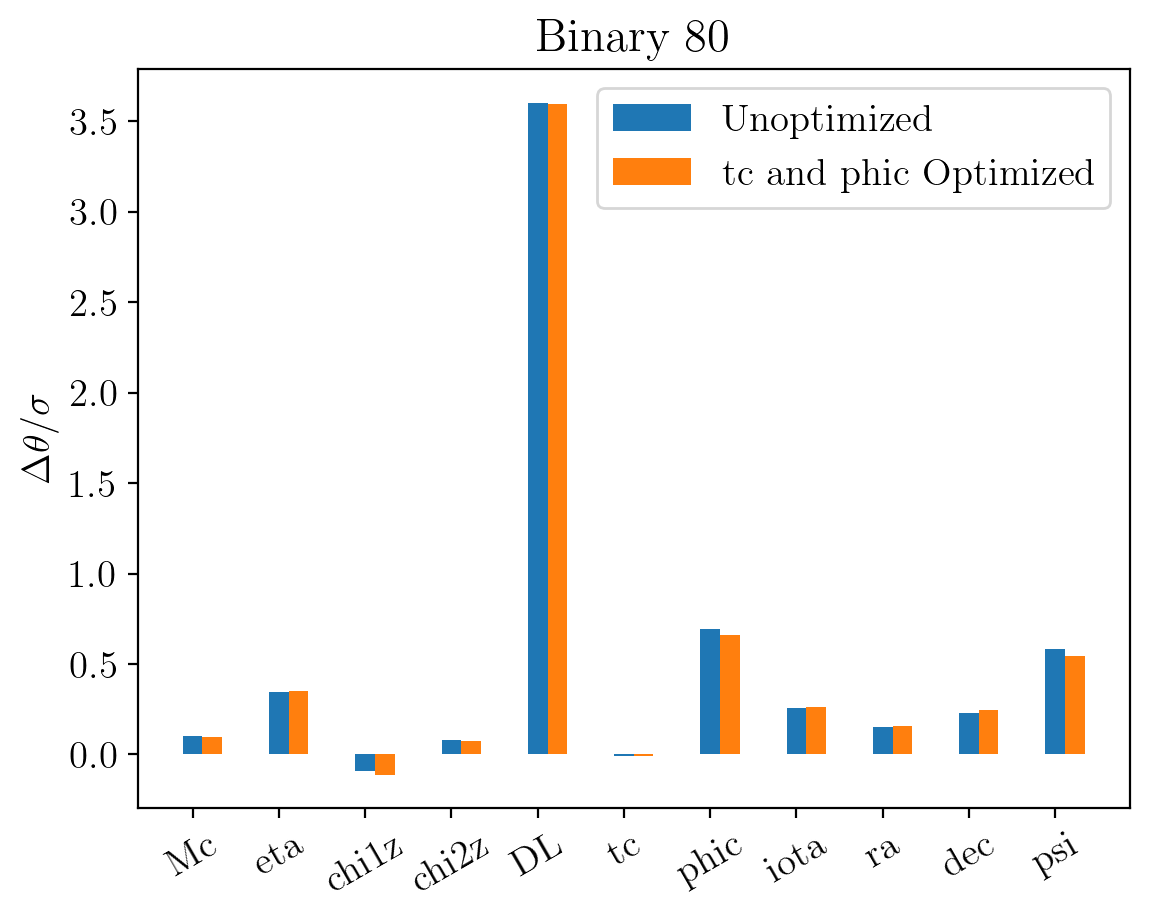

2023-10-17 09:46:38,641 - Network - INFO : Polarizations calculated.
2023-10-17 09:46:38,642 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:46:38,653 - Network - INFO : Polarizations calculated.


######  Binary 81  ######


2023-10-17 09:46:41,363 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:46:41,409 - Network - INFO : PSDs loaded.
2023-10-17 09:46:41,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:46:41,453 - Network - INFO : Detector responses calculated.
2023-10-17 09:46:41,453 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:46:41,454 - Network - INFO :    CE-40_C
2023-10-17 09:46:43,308 - Network - INFO :    CE-20_S
2023-10-17 09:46:45,079 - Network - INFO :    ET_ET1
2023-10-17 09:46:46,788 - Network - INFO :    ET_ET2
2023-10-17 09:46:48,544 - Network - INFO :    ET_ET3
2023-10-17 09:46:50,284 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:46:50,288 - Network - INFO : SNRs calculated.
2023-10-17 09:46:50,288 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:46:50,289 - Network - INFO :    CE-40_C
2023-10-17 09:46:50,352 - Network - INFO :

Mc bias diff: -0.05%
Mc, not: -1.715 sigma
Mc, opt: -1.716 sigma

eta bias diff: 0.25%
eta, not: 1.802 sigma
eta, opt: 1.798 sigma

chi1z bias diff: 0.17%
chi1z, not: -1.546 sigma
chi1z, opt: -1.544 sigma

chi2z bias diff: 0.06%
chi2z, not: 1.476 sigma
chi2z, opt: 1.475 sigma

DL bias diff: 0.01%
DL, not: 21.994 sigma
DL, opt: 21.992 sigma

tc bias diff: 0.20%
tc, not: 1.471 sigma
tc, opt: 1.468 sigma

phic bias diff: 0.13%
phic, not: 2.258 sigma
phic, opt: 2.255 sigma

iota bias diff: 0.09%
iota, not: 0.147 sigma
iota, opt: 0.147 sigma

ra bias diff: 0.55%
ra, not: 0.174 sigma
ra, opt: 0.173 sigma

dec bias diff: 0.59%
dec, not: -0.172 sigma
dec, opt: -0.171 sigma

psi bias diff: -1.24%
psi, not: -0.364 sigma
psi, opt: -0.369 sigma

######  Binary 82  ######


2023-10-17 09:47:04,549 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:47:04,594 - Network - INFO : PSDs loaded.
2023-10-17 09:47:04,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:47:04,634 - Network - INFO : Detector responses calculated.
2023-10-17 09:47:04,635 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:47:04,635 - Network - INFO :    CE-40_C
2023-10-17 09:47:06,021 - Network - INFO :    CE-20_S
2023-10-17 09:47:07,399 - Network - INFO :    ET_ET1
2023-10-17 09:47:08,758 - Network - INFO :    ET_ET2
2023-10-17 09:47:10,103 - Network - INFO :    ET_ET3
2023-10-17 09:47:11,480 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:47:11,483 - Network - INFO : SNRs calculated.
2023-10-17 09:47:11,483 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:47:11,484 - Network - INFO :    CE-40_C
2023-10-17 09:47:11,542 - Network - INFO :

Mc bias diff: -0.28%
Mc, not: -2.496 sigma
Mc, opt: -2.503 sigma

eta bias diff: 0.48%
eta, not: 3.530 sigma
eta, opt: 3.513 sigma

chi1z bias diff: 1.06%
chi1z, not: -2.344 sigma
chi1z, opt: -2.319 sigma

chi2z bias diff: 0.98%
chi2z, not: 2.139 sigma
chi2z, opt: 2.118 sigma

DL bias diff: 3.15%
DL, not: 3.078 sigma
DL, opt: 2.981 sigma

tc bias diff: 1.03%
tc, not: 2.240 sigma
tc, opt: 2.217 sigma

phic bias diff: 2.22%
phic, not: 0.037 sigma
phic, opt: 0.036 sigma

iota bias diff: -20.70%
iota, not: -0.800 sigma
iota, opt: -0.966 sigma

ra bias diff: -66.77%
ra, not: -0.024 sigma
ra, opt: -0.041 sigma

dec bias diff: -19.13%
dec, not: 0.087 sigma
dec, opt: 0.104 sigma

psi bias diff: -0.31%
psi, not: 0.310 sigma
psi, opt: 0.311 sigma

######  Binary 83  ######


2023-10-17 09:47:23,313 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:47:23,439 - Network - INFO : PSDs loaded.
2023-10-17 09:47:23,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:47:23,477 - Network - INFO : Detector responses calculated.
2023-10-17 09:47:23,478 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:47:23,478 - Network - INFO :    CE-40_C
2023-10-17 09:47:24,744 - Network - INFO :    CE-20_S
2023-10-17 09:47:26,032 - Network - INFO :    ET_ET1
2023-10-17 09:47:27,358 - Network - INFO :    ET_ET2
2023-10-17 09:47:28,669 - Network - INFO :    ET_ET3
2023-10-17 09:47:29,988 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:47:29,991 - Network - INFO : SNRs calculated.
2023-10-17 09:47:29,992 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:47:29,992 - Network - INFO :    CE-40_C
2023-10-17 09:47:30,054 - Network - INFO :

Mc bias diff: -0.46%
Mc, not: 1.007 sigma
Mc, opt: 1.012 sigma

eta bias diff: -0.16%
eta, not: 4.581 sigma
eta, opt: 4.589 sigma

chi1z bias diff: -0.32%
chi1z, not: -4.381 sigma
chi1z, opt: -4.395 sigma

chi2z bias diff: -0.05%
chi2z, not: 4.354 sigma
chi2z, opt: 4.356 sigma

DL bias diff: -0.08%
DL, not: 16.905 sigma
DL, opt: 16.919 sigma

tc bias diff: -0.25%
tc, not: 4.367 sigma
tc, opt: 4.378 sigma

phic bias diff: 0.13%
phic, not: 2.947 sigma
phic, opt: 2.943 sigma

iota bias diff: -6.37%
iota, not: -0.334 sigma
iota, opt: -0.355 sigma

ra bias diff: -10.08%
ra, not: -0.079 sigma
ra, opt: -0.086 sigma

dec bias diff: -12.30%
dec, not: -0.119 sigma
dec, opt: -0.134 sigma

psi bias diff: 0.66%
psi, not: 1.328 sigma
psi, opt: 1.319 sigma

######  Binary 84  ######


2023-10-17 09:47:41,877 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:47:41,921 - Network - INFO : PSDs loaded.
2023-10-17 09:47:41,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:47:41,966 - Network - INFO : Detector responses calculated.
2023-10-17 09:47:41,967 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:47:41,967 - Network - INFO :    CE-40_C
2023-10-17 09:47:43,683 - Network - INFO :    CE-20_S
2023-10-17 09:47:45,326 - Network - INFO :    ET_ET1
2023-10-17 09:47:46,937 - Network - INFO :    ET_ET2
2023-10-17 09:47:48,546 - Network - INFO :    ET_ET3
2023-10-17 09:47:50,146 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:47:50,149 - Network - INFO : SNRs calculated.
2023-10-17 09:47:50,150 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:47:50,150 - Network - INFO :    CE-40_C
2023-10-17 09:47:50,212 - Network - INFO :

Mc bias diff: 0.60%
Mc, not: -1.579 sigma
Mc, opt: -1.570 sigma

eta bias diff: 0.11%
eta, not: 1.958 sigma
eta, opt: 1.955 sigma

chi1z bias diff: 0.12%
chi1z, not: -1.871 sigma
chi1z, opt: -1.869 sigma

chi2z bias diff: -0.08%
chi2z, not: 1.830 sigma
chi2z, opt: 1.831 sigma

DL bias diff: 0.13%
DL, not: 12.098 sigma
DL, opt: 12.082 sigma

tc bias diff: 0.10%
tc, not: 1.836 sigma
tc, opt: 1.834 sigma

phic bias diff: 0.49%
phic, not: 2.105 sigma
phic, opt: 2.095 sigma

iota bias diff: 16.32%
iota, not: -0.219 sigma
iota, opt: -0.183 sigma

ra bias diff: 1.61%
ra, not: -0.223 sigma
ra, opt: -0.220 sigma

dec bias diff: -3.94%
dec, not: 0.257 sigma
dec, opt: 0.267 sigma

psi bias diff: -45.27%
psi, not: -0.013 sigma
psi, opt: -0.019 sigma

######  Binary 85  ######


2023-10-17 09:48:03,045 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:48:03,131 - Network - INFO : PSDs loaded.
2023-10-17 09:48:03,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:48:03,173 - Network - INFO : Detector responses calculated.
2023-10-17 09:48:03,174 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:48:03,174 - Network - INFO :    CE-40_C
2023-10-17 09:48:04,148 - Network - INFO :    CE-20_S
2023-10-17 09:48:05,056 - Network - INFO :    ET_ET1
2023-10-17 09:48:05,977 - Network - INFO :    ET_ET2
2023-10-17 09:48:06,895 - Network - INFO :    ET_ET3
2023-10-17 09:48:07,814 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:48:07,816 - Network - INFO : SNRs calculated.
2023-10-17 09:48:07,817 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:48:07,818 - Network - INFO :    CE-40_C
2023-10-17 09:48:07,876 - Network - INFO :

Mc bias diff: 0.22%
Mc, not: 1.927 sigma
Mc, opt: 1.923 sigma

eta bias diff: 0.04%
eta, not: 3.072 sigma
eta, opt: 3.071 sigma

chi1z bias diff: 0.10%
chi1z, not: -3.442 sigma
chi1z, opt: -3.438 sigma

chi2z bias diff: 0.11%
chi2z, not: 3.449 sigma
chi2z, opt: 3.446 sigma

DL bias diff: 3.88%
DL, not: 0.541 sigma
DL, opt: 0.520 sigma

tc bias diff: 0.11%
tc, not: 3.417 sigma
tc, opt: 3.414 sigma

phic bias diff: 4.83%
phic, not: 0.243 sigma
phic, opt: 0.232 sigma

iota bias diff: -10.64%
iota, not: 0.462 sigma
iota, opt: 0.511 sigma

ra bias diff: -32.12%
ra, not: -0.083 sigma
ra, opt: -0.109 sigma

dec bias diff: 16.40%
dec, not: 0.136 sigma
dec, opt: 0.114 sigma

psi bias diff: -168.84%
psi, not: -0.007 sigma
psi, opt: -0.020 sigma

######  Binary 86  ######


2023-10-17 09:48:16,756 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:48:16,800 - Network - INFO : PSDs loaded.
2023-10-17 09:48:16,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:48:16,839 - Network - INFO : Detector responses calculated.
2023-10-17 09:48:16,841 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:48:16,841 - Network - INFO :    CE-40_C
2023-10-17 09:48:18,097 - Network - INFO :    CE-20_S
2023-10-17 09:48:19,392 - Network - INFO :    ET_ET1
2023-10-17 09:48:20,667 - Network - INFO :    ET_ET2
2023-10-17 09:48:21,971 - Network - INFO :    ET_ET3
2023-10-17 09:48:23,271 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:48:23,274 - Network - INFO : SNRs calculated.
2023-10-17 09:48:23,275 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:48:23,275 - Network - INFO :    CE-40_C
2023-10-17 09:48:23,341 - Network - INFO :

Mc bias diff: -0.01%
Mc, not: 0.894 sigma
Mc, opt: 0.894 sigma

eta bias diff: 0.08%
eta, not: 1.230 sigma
eta, opt: 1.229 sigma

chi1z bias diff: 0.11%
chi1z, not: -1.472 sigma
chi1z, opt: -1.471 sigma

chi2z bias diff: 0.11%
chi2z, not: 1.504 sigma
chi2z, opt: 1.503 sigma

DL bias diff: -0.10%
DL, not: 4.323 sigma
DL, opt: 4.328 sigma

tc bias diff: 0.14%
tc, not: 1.500 sigma
tc, opt: 1.498 sigma

phic bias diff: 1.11%
phic, not: 0.618 sigma
phic, opt: 0.611 sigma

iota bias diff: -0.40%
iota, not: 0.162 sigma
iota, opt: 0.163 sigma

ra bias diff: -0.97%
ra, not: 0.209 sigma
ra, opt: 0.211 sigma

dec bias diff: 0.30%
dec, not: 0.295 sigma
dec, opt: 0.294 sigma

psi bias diff: -2.19%
psi, not: -0.368 sigma
psi, opt: -0.376 sigma

######  Binary 87  ######


2023-10-17 09:48:35,300 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:48:35,344 - Network - INFO : PSDs loaded.
2023-10-17 09:48:35,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:48:35,392 - Network - INFO : Detector responses calculated.
2023-10-17 09:48:35,393 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:48:35,394 - Network - INFO :    CE-40_C
2023-10-17 09:48:37,249 - Network - INFO :    CE-20_S
2023-10-17 09:48:39,095 - Network - INFO :    ET_ET1
2023-10-17 09:48:41,108 - Network - INFO :    ET_ET2
2023-10-17 09:48:43,201 - Network - INFO :    ET_ET3
2023-10-17 09:48:45,094 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:48:45,098 - Network - INFO : SNRs calculated.
2023-10-17 09:48:45,098 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:48:45,099 - Network - INFO :    CE-40_C
2023-10-17 09:48:45,163 - Network - INFO :

Mc bias diff: 0.09%
Mc, not: -5.039 sigma
Mc, opt: -5.034 sigma

eta bias diff: 0.03%
eta, not: 4.813 sigma
eta, opt: 4.812 sigma

chi1z bias diff: -0.04%
chi1z, not: -3.933 sigma
chi1z, opt: -3.934 sigma

chi2z bias diff: -0.15%
chi2z, not: 3.756 sigma
chi2z, opt: 3.762 sigma

DL bias diff: 0.01%
DL, not: 12.113 sigma
DL, opt: 12.112 sigma

tc bias diff: 0.03%
tc, not: 3.806 sigma
tc, opt: 3.805 sigma

phic bias diff: 0.06%
phic, not: 4.245 sigma
phic, opt: 4.242 sigma

iota bias diff: -0.45%
iota, not: -0.574 sigma
iota, opt: -0.576 sigma

ra bias diff: -11.16%
ra, not: -0.037 sigma
ra, opt: -0.042 sigma

dec bias diff: -10.66%
dec, not: -0.089 sigma
dec, opt: -0.099 sigma

psi bias diff: 1.20%
psi, not: 0.281 sigma
psi, opt: 0.278 sigma

######  Binary 88  ######


2023-10-17 09:49:02,144 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:49:02,191 - Network - INFO : PSDs loaded.
2023-10-17 09:49:02,194 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:49:02,246 - Network - INFO : Detector responses calculated.
2023-10-17 09:49:02,247 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:49:02,247 - Network - INFO :    CE-40_C
2023-10-17 09:49:04,472 - Network - INFO :    CE-20_S
2023-10-17 09:49:06,595 - Network - INFO :    ET_ET1
2023-10-17 09:49:08,851 - Network - INFO :    ET_ET2
2023-10-17 09:49:11,133 - Network - INFO :    ET_ET3
2023-10-17 09:49:13,346 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:49:13,351 - Network - INFO : SNRs calculated.
2023-10-17 09:49:13,351 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:49:13,352 - Network - INFO :    CE-40_C
2023-10-17 09:49:13,418 - Network - INFO :

Mc bias diff: 3.29%
Mc, not: -2.149 sigma
Mc, opt: -2.078 sigma

eta bias diff: 0.64%
eta, not: -5.794 sigma
eta, opt: -5.757 sigma

chi1z bias diff: -16.31%
chi1z, not: 1.456 sigma
chi1z, opt: 1.694 sigma

chi2z bias diff: 11.13%
chi2z, not: -1.880 sigma
chi2z, opt: -1.671 sigma

DL bias diff: -0.23%
DL, not: 5.072 sigma
DL, opt: 5.084 sigma

tc bias diff: 0.40%
tc, not: -5.992 sigma
tc, opt: -5.968 sigma

phic bias diff: -0.37%
phic, not: -0.641 sigma
phic, opt: -0.643 sigma

iota bias diff: -4.76%
iota, not: -0.348 sigma
iota, opt: -0.364 sigma

ra bias diff: 2.25%
ra, not: -0.359 sigma
ra, opt: -0.351 sigma

dec bias diff: 0.18%
dec, not: 0.449 sigma
dec, opt: 0.448 sigma

psi bias diff: -2.43%
psi, not: 0.935 sigma
psi, opt: 0.957 sigma

######  Binary 89  ######


2023-10-17 09:49:28,565 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:49:28,625 - Network - INFO : PSDs loaded.
2023-10-17 09:49:28,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:49:28,660 - Network - INFO : Detector responses calculated.
2023-10-17 09:49:28,661 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:49:28,662 - Network - INFO :    CE-40_C
2023-10-17 09:49:29,558 - Network - INFO :    CE-20_S
2023-10-17 09:49:30,437 - Network - INFO :    ET_ET1
2023-10-17 09:49:31,300 - Network - INFO :    ET_ET2
2023-10-17 09:49:32,169 - Network - INFO :    ET_ET3
2023-10-17 09:49:33,048 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:49:33,051 - Network - INFO : SNRs calculated.
2023-10-17 09:49:33,052 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:49:33,052 - Network - INFO :    CE-40_C
2023-10-17 09:49:33,112 - Network - INFO :

Mc bias diff: -2.43%
Mc, not: -0.756 sigma
Mc, opt: -0.774 sigma

eta bias diff: -0.32%
eta, not: 2.782 sigma
eta, opt: 2.791 sigma

chi1z bias diff: 3.56%
chi1z, not: 0.200 sigma
chi1z, opt: 0.193 sigma

chi2z bias diff: 0.88%
chi2z, not: -0.576 sigma
chi2z, opt: -0.571 sigma

DL bias diff: -2.21%
DL, not: 3.768 sigma
DL, opt: 3.851 sigma

tc bias diff: 1.82%
tc, not: -0.370 sigma
tc, opt: -0.364 sigma

phic bias diff: 0.04%
phic, not: 0.272 sigma
phic, opt: 0.272 sigma

iota bias diff: 14.76%
iota, not: 1.052 sigma
iota, opt: 0.897 sigma

ra bias diff: 9.18%
ra, not: 0.331 sigma
ra, opt: 0.301 sigma

dec bias diff: 10.02%
dec, not: 0.224 sigma
dec, opt: 0.201 sigma

psi bias diff: 39.32%
psi, not: 0.016 sigma
psi, opt: 0.010 sigma

######  Binary 90  ######


2023-10-17 09:49:41,726 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:49:41,769 - Network - INFO : PSDs loaded.
2023-10-17 09:49:41,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:49:41,808 - Network - INFO : Detector responses calculated.
2023-10-17 09:49:41,808 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:49:41,809 - Network - INFO :    CE-40_C
2023-10-17 09:49:43,102 - Network - INFO :    CE-20_S
2023-10-17 09:49:44,415 - Network - INFO :    ET_ET1
2023-10-17 09:49:45,736 - Network - INFO :    ET_ET2
2023-10-17 09:49:47,078 - Network - INFO :    ET_ET3
2023-10-17 09:49:48,376 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:49:48,380 - Network - INFO : SNRs calculated.
2023-10-17 09:49:48,380 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:49:48,381 - Network - INFO :    CE-40_C
2023-10-17 09:49:48,447 - Network - INFO :

Mc bias diff: -0.32%
Mc, not: 1.052 sigma
Mc, opt: 1.055 sigma

eta bias diff: 0.08%
eta, not: 1.435 sigma
eta, opt: 1.434 sigma

chi1z bias diff: 0.07%
chi1z, not: -1.875 sigma
chi1z, opt: -1.873 sigma

chi2z bias diff: -0.08%
chi2z, not: 1.933 sigma
chi2z, opt: 1.935 sigma

DL bias diff: 5.18%
DL, not: 2.644 sigma
DL, opt: 2.507 sigma

tc bias diff: -0.06%
tc, not: 1.953 sigma
tc, opt: 1.954 sigma

phic bias diff: -4.71%
phic, not: 0.795 sigma
phic, opt: 0.833 sigma

iota bias diff: -133.53%
iota, not: -0.202 sigma
iota, opt: -0.472 sigma

ra bias diff: 9.93%
ra, not: 0.330 sigma
ra, opt: 0.297 sigma

dec bias diff: 5.83%
dec, not: -0.267 sigma
dec, opt: -0.251 sigma

psi bias diff: -12.52%
psi, not: -0.398 sigma
psi, opt: -0.448 sigma



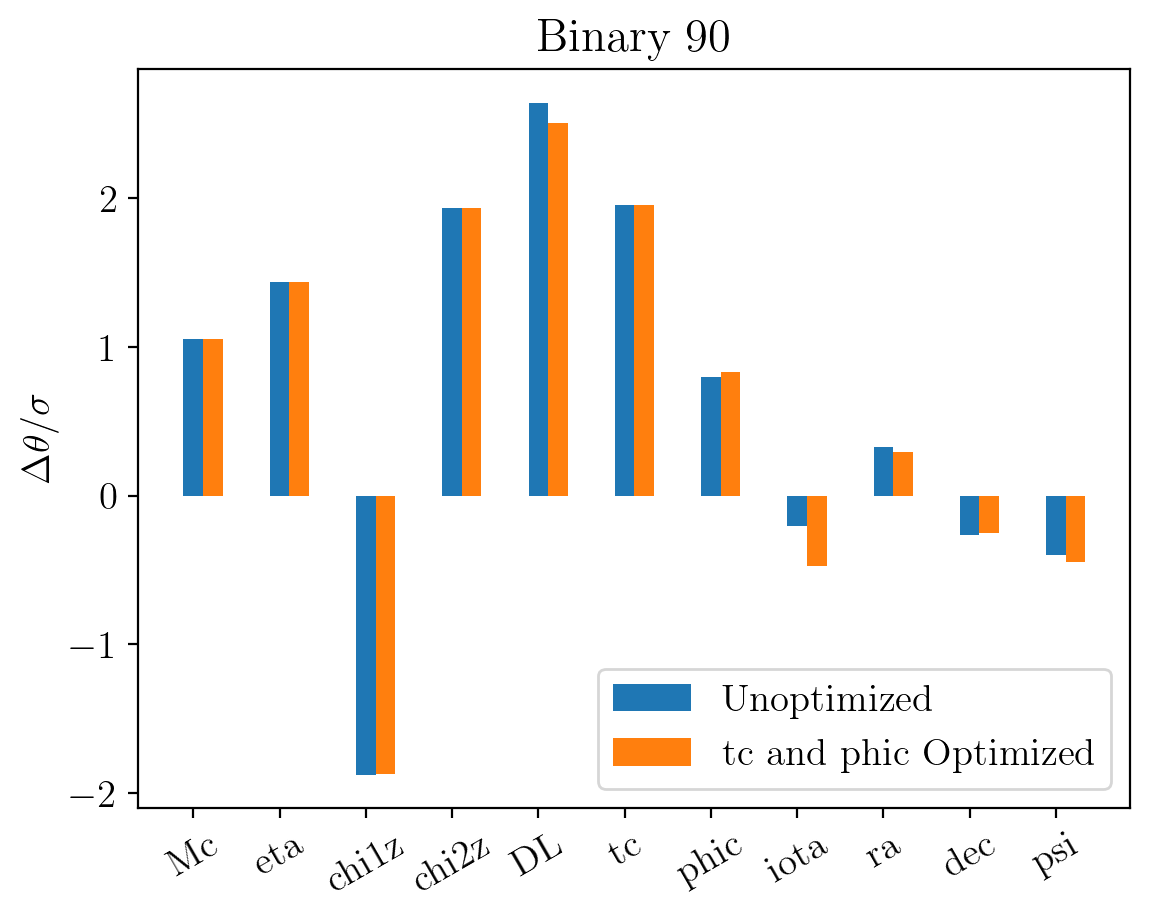

2023-10-17 09:49:58,469 - Network - INFO : Polarizations calculated.
2023-10-17 09:49:58,469 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-10-17 09:49:58,481 - Network - INFO : Polarizations calculated.


######  Binary 91  ######


2023-10-17 09:50:00,442 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:50:00,487 - Network - INFO : PSDs loaded.
2023-10-17 09:50:00,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:50:00,522 - Network - INFO : Detector responses calculated.
2023-10-17 09:50:00,523 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:50:00,524 - Network - INFO :    CE-40_C
2023-10-17 09:50:01,726 - Network - INFO :    CE-20_S
2023-10-17 09:50:02,965 - Network - INFO :    ET_ET1
2023-10-17 09:50:04,194 - Network - INFO :    ET_ET2
2023-10-17 09:50:05,449 - Network - INFO :    ET_ET3
2023-10-17 09:50:06,689 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:50:06,693 - Network - INFO : SNRs calculated.
2023-10-17 09:50:06,693 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:50:06,694 - Network - INFO :    CE-40_C
2023-10-17 09:50:06,758 - Network - INFO :

Mc bias diff: -0.03%
Mc, not: 3.375 sigma
Mc, opt: 3.376 sigma

eta bias diff: -0.07%
eta, not: 2.051 sigma
eta, opt: 2.052 sigma

chi1z bias diff: -0.10%
chi1z, not: -2.806 sigma
chi1z, opt: -2.809 sigma

chi2z bias diff: -0.02%
chi2z, not: 2.887 sigma
chi2z, opt: 2.887 sigma

DL bias diff: -9.57%
DL, not: 0.253 sigma
DL, opt: 0.277 sigma

tc bias diff: -0.07%
tc, not: 2.860 sigma
tc, opt: 2.863 sigma

phic bias diff: 3.78%
phic, not: -0.036 sigma
phic, opt: -0.035 sigma

iota bias diff: 24.79%
iota, not: 1.363 sigma
iota, opt: 1.025 sigma

ra bias diff: 0.88%
ra, not: 1.198 sigma
ra, opt: 1.188 sigma

dec bias diff: 1.19%
dec, not: -0.976 sigma
dec, opt: -0.964 sigma

psi bias diff: 3.45%
psi, not: -0.044 sigma
psi, opt: -0.043 sigma

######  Binary 92  ######


2023-10-17 09:50:17,622 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:50:17,775 - Network - INFO : PSDs loaded.
2023-10-17 09:50:17,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:50:17,839 - Network - INFO : Detector responses calculated.
2023-10-17 09:50:17,840 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:50:17,841 - Network - INFO :    CE-40_C
2023-10-17 09:50:18,685 - Network - INFO :    CE-20_S
2023-10-17 09:50:19,494 - Network - INFO :    ET_ET1
2023-10-17 09:50:20,374 - Network - INFO :    ET_ET2
2023-10-17 09:50:21,165 - Network - INFO :    ET_ET3
2023-10-17 09:50:21,980 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:50:21,983 - Network - INFO : SNRs calculated.
2023-10-17 09:50:21,984 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:50:21,985 - Network - INFO :    CE-40_C
2023-10-17 09:50:22,051 - Network - INFO :

Mc bias diff: -0.18%
Mc, not: 8.531 sigma
Mc, opt: 8.546 sigma

eta bias diff: -0.04%
eta, not: 23.160 sigma
eta, opt: 23.169 sigma

chi1z bias diff: -0.09%
chi1z, not: -22.498 sigma
chi1z, opt: -22.518 sigma

chi2z bias diff: -0.09%
chi2z, not: 22.446 sigma
chi2z, opt: 22.467 sigma

DL bias diff: -0.30%
DL, not: 6.206 sigma
DL, opt: 6.224 sigma

tc bias diff: -0.09%
tc, not: 22.237 sigma
tc, opt: 22.257 sigma

phic bias diff: -0.15%
phic, not: 5.141 sigma
phic, opt: 5.149 sigma

iota bias diff: -2.75%
iota, not: -1.767 sigma
iota, opt: -1.815 sigma

ra bias diff: -0.81%
ra, not: -0.962 sigma
ra, opt: -0.970 sigma

dec bias diff: -1.17%
dec, not: 1.431 sigma
dec, opt: 1.447 sigma

psi bias diff: 0.50%
psi, not: 0.695 sigma
psi, opt: 0.691 sigma

######  Binary 93  ######


2023-10-17 09:50:29,623 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:50:29,865 - Network - INFO : PSDs loaded.
2023-10-17 09:50:29,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:50:29,901 - Network - INFO : Detector responses calculated.
2023-10-17 09:50:29,901 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:50:29,902 - Network - INFO :    CE-40_C
2023-10-17 09:50:30,733 - Network - INFO :    CE-20_S
2023-10-17 09:50:31,607 - Network - INFO :    ET_ET1
2023-10-17 09:50:32,428 - Network - INFO :    ET_ET2
2023-10-17 09:50:33,297 - Network - INFO :    ET_ET3
2023-10-17 09:50:34,255 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:50:34,259 - Network - INFO : SNRs calculated.
2023-10-17 09:50:34,260 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:50:34,261 - Network - INFO :    CE-40_C
2023-10-17 09:50:34,326 - Network - INFO :

Mc bias diff: 3.46%
Mc, not: -0.554 sigma
Mc, opt: -0.535 sigma

eta bias diff: 0.13%
eta, not: 7.623 sigma
eta, opt: 7.613 sigma

chi1z bias diff: 0.25%
chi1z, not: -4.973 sigma
chi1z, opt: -4.961 sigma

chi2z bias diff: 0.26%
chi2z, not: 4.629 sigma
chi2z, opt: 4.617 sigma

DL bias diff: 0.03%
DL, not: 24.799 sigma
DL, opt: 24.791 sigma

tc bias diff: 0.25%
tc, not: 4.846 sigma
tc, opt: 4.834 sigma

phic bias diff: 0.28%
phic, not: 4.799 sigma
phic, opt: 4.785 sigma

iota bias diff: -1.92%
iota, not: -0.457 sigma
iota, opt: -0.466 sigma

ra bias diff: -1.98%
ra, not: -0.489 sigma
ra, opt: -0.499 sigma

dec bias diff: 2.30%
dec, not: -0.104 sigma
dec, opt: -0.102 sigma

psi bias diff: 3.65%
psi, not: 0.469 sigma
psi, opt: 0.452 sigma

######  Binary 94  ######


2023-10-17 09:50:43,149 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:50:43,194 - Network - INFO : PSDs loaded.
2023-10-17 09:50:43,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:50:43,241 - Network - INFO : Detector responses calculated.
2023-10-17 09:50:43,242 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:50:43,242 - Network - INFO :    CE-40_C
2023-10-17 09:50:44,986 - Network - INFO :    CE-20_S
2023-10-17 09:50:46,656 - Network - INFO :    ET_ET1
2023-10-17 09:50:48,319 - Network - INFO :    ET_ET2
2023-10-17 09:50:49,972 - Network - INFO :    ET_ET3
2023-10-17 09:50:51,635 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:50:51,639 - Network - INFO : SNRs calculated.
2023-10-17 09:50:51,639 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:50:51,640 - Network - INFO :    CE-40_C
2023-10-17 09:50:51,703 - Network - INFO :

Mc bias diff: 0.19%
Mc, not: -2.958 sigma
Mc, opt: -2.952 sigma

eta bias diff: -0.05%
eta, not: 2.830 sigma
eta, opt: 2.832 sigma

chi1z bias diff: -0.36%
chi1z, not: -2.191 sigma
chi1z, opt: -2.199 sigma

chi2z bias diff: -0.14%
chi2z, not: 2.060 sigma
chi2z, opt: 2.063 sigma

DL bias diff: -10.19%
DL, not: 1.561 sigma
DL, opt: 1.720 sigma

tc bias diff: -0.48%
tc, not: 2.069 sigma
tc, opt: 2.079 sigma

phic bias diff: 16.50%
phic, not: -0.134 sigma
phic, opt: -0.112 sigma

iota bias diff: 195.10%
iota, not: 0.170 sigma
iota, opt: -0.161 sigma

ra bias diff: 75.39%
ra, not: 0.131 sigma
ra, opt: 0.032 sigma

dec bias diff: 302.52%
dec, not: -0.027 sigma
dec, opt: 0.054 sigma

psi bias diff: 9.34%
psi, not: -0.239 sigma
psi, opt: -0.217 sigma

######  Binary 95  ######


2023-10-17 09:51:06,369 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:51:06,426 - Network - INFO : PSDs loaded.
2023-10-17 09:51:06,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:51:06,469 - Network - INFO : Detector responses calculated.
2023-10-17 09:51:06,470 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:51:06,471 - Network - INFO :    CE-40_C
2023-10-17 09:51:07,881 - Network - INFO :    CE-20_S
2023-10-17 09:51:08,974 - Network - INFO :    ET_ET1
2023-10-17 09:51:10,151 - Network - INFO :    ET_ET2
2023-10-17 09:51:11,263 - Network - INFO :    ET_ET3
2023-10-17 09:51:12,426 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:51:12,430 - Network - INFO : SNRs calculated.
2023-10-17 09:51:12,430 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:51:12,431 - Network - INFO :    CE-40_C
2023-10-17 09:51:12,530 - Network - INFO :

Mc bias diff: -0.35%
Mc, not: 7.086 sigma
Mc, opt: 7.111 sigma

eta bias diff: -0.60%
eta, not: 3.690 sigma
eta, opt: 3.712 sigma

chi1z bias diff: -0.58%
chi1z, not: -5.400 sigma
chi1z, opt: -5.431 sigma

chi2z bias diff: -0.59%
chi2z, not: 5.514 sigma
chi2z, opt: 5.547 sigma

DL bias diff: -4.98%
DL, not: 1.254 sigma
DL, opt: 1.317 sigma

tc bias diff: -0.58%
tc, not: 5.663 sigma
tc, opt: 5.696 sigma

phic bias diff: 1.74%
phic, not: -0.131 sigma
phic, opt: -0.129 sigma

iota bias diff: -16.10%
iota, not: 0.448 sigma
iota, opt: 0.520 sigma

ra bias diff: -2.42%
ra, not: -0.813 sigma
ra, opt: -0.832 sigma

dec bias diff: 2.76%
dec, not: 0.101 sigma
dec, opt: 0.098 sigma

psi bias diff: -0.27%
psi, not: -0.349 sigma
psi, opt: -0.350 sigma

######  Binary 96  ######


2023-10-17 09:51:23,490 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:51:23,545 - Network - INFO : PSDs loaded.
2023-10-17 09:51:23,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:51:23,585 - Network - INFO : Detector responses calculated.
2023-10-17 09:51:23,586 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:51:23,587 - Network - INFO :    CE-40_C
2023-10-17 09:51:24,713 - Network - INFO :    CE-20_S
2023-10-17 09:51:26,010 - Network - INFO :    ET_ET1
2023-10-17 09:51:27,161 - Network - INFO :    ET_ET2
2023-10-17 09:51:28,161 - Network - INFO :    ET_ET3
2023-10-17 09:51:29,097 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:51:29,100 - Network - INFO : SNRs calculated.
2023-10-17 09:51:29,101 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:51:29,101 - Network - INFO :    CE-40_C
2023-10-17 09:51:29,160 - Network - INFO :

Mc bias diff: 1.38%
Mc, not: 0.016 sigma
Mc, opt: 0.016 sigma

eta bias diff: 0.30%
eta, not: 1.286 sigma
eta, opt: 1.282 sigma

chi1z bias diff: 0.10%
chi1z, not: -1.127 sigma
chi1z, opt: -1.125 sigma

chi2z bias diff: 0.04%
chi2z, not: 1.048 sigma
chi2z, opt: 1.048 sigma

DL bias diff: 0.94%
DL, not: 3.056 sigma
DL, opt: 3.027 sigma

tc bias diff: 0.05%
tc, not: 1.052 sigma
tc, opt: 1.052 sigma

phic bias diff: -0.28%
phic, not: 1.049 sigma
phic, opt: 1.052 sigma

iota bias diff: 89.55%
iota, not: -0.039 sigma
iota, opt: -0.004 sigma

ra bias diff: 140.02%
ra, not: -0.021 sigma
ra, opt: 0.008 sigma

dec bias diff: -45.87%
dec, not: 0.046 sigma
dec, opt: 0.067 sigma

psi bias diff: -136.88%
psi, not: 0.032 sigma
psi, opt: 0.075 sigma

######  Binary 97  ######


2023-10-17 09:51:38,277 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:51:38,321 - Network - INFO : PSDs loaded.
2023-10-17 09:51:38,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:51:38,365 - Network - INFO : Detector responses calculated.
2023-10-17 09:51:38,366 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:51:38,367 - Network - INFO :    CE-40_C
2023-10-17 09:51:39,861 - Network - INFO :    CE-20_S
2023-10-17 09:51:41,326 - Network - INFO :    ET_ET1
2023-10-17 09:51:42,813 - Network - INFO :    ET_ET2
2023-10-17 09:51:44,272 - Network - INFO :    ET_ET3
2023-10-17 09:51:45,727 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:51:45,730 - Network - INFO : SNRs calculated.
2023-10-17 09:51:45,731 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:51:45,731 - Network - INFO :    CE-40_C
2023-10-17 09:51:45,791 - Network - INFO :

Mc bias diff: 0.56%
Mc, not: -1.797 sigma
Mc, opt: -1.787 sigma

eta bias diff: 0.35%
eta, not: 2.157 sigma
eta, opt: 2.149 sigma

chi1z bias diff: 0.42%
chi1z, not: -1.695 sigma
chi1z, opt: -1.688 sigma

chi2z bias diff: 0.49%
chi2z, not: 1.613 sigma
chi2z, opt: 1.605 sigma

DL bias diff: 0.62%
DL, not: 8.077 sigma
DL, opt: 8.027 sigma

tc bias diff: 0.47%
tc, not: 1.637 sigma
tc, opt: 1.629 sigma

phic bias diff: 0.95%
phic, not: 1.934 sigma
phic, opt: 1.916 sigma

iota bias diff: -27.59%
iota, not: -0.336 sigma
iota, opt: -0.429 sigma

ra bias diff: 31.96%
ra, not: -0.010 sigma
ra, opt: -0.007 sigma

dec bias diff: -5.39%
dec, not: 0.154 sigma
dec, opt: 0.162 sigma

psi bias diff: -10.34%
psi, not: 0.111 sigma
psi, opt: 0.123 sigma

######  Binary 98  ######


2023-10-17 09:51:57,768 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:51:57,818 - Network - INFO : PSDs loaded.
2023-10-17 09:51:57,821 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:51:57,857 - Network - INFO : Detector responses calculated.
2023-10-17 09:51:57,858 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:51:57,858 - Network - INFO :    CE-40_C
2023-10-17 09:51:58,884 - Network - INFO :    CE-20_S
2023-10-17 09:52:00,146 - Network - INFO :    ET_ET1
2023-10-17 09:52:01,468 - Network - INFO :    ET_ET2
2023-10-17 09:52:02,572 - Network - INFO :    ET_ET3
2023-10-17 09:52:04,044 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:52:04,047 - Network - INFO : SNRs calculated.
2023-10-17 09:52:04,047 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:52:04,048 - Network - INFO :    CE-40_C
2023-10-17 09:52:04,104 - Network - INFO :

Mc bias diff: -0.10%
Mc, not: 5.348 sigma
Mc, opt: 5.353 sigma

eta bias diff: 0.12%
eta, not: 4.399 sigma
eta, opt: 4.394 sigma

chi1z bias diff: 0.07%
chi1z, not: -5.645 sigma
chi1z, opt: -5.641 sigma

chi2z bias diff: 0.01%
chi2z, not: 5.675 sigma
chi2z, opt: 5.674 sigma

DL bias diff: 0.49%
DL, not: 3.545 sigma
DL, opt: 3.528 sigma

tc bias diff: 0.07%
tc, not: 5.816 sigma
tc, opt: 5.812 sigma

phic bias diff: 0.44%
phic, not: 1.680 sigma
phic, opt: 1.673 sigma

iota bias diff: -3.68%
iota, not: -0.509 sigma
iota, opt: -0.528 sigma

ra bias diff: -5.01%
ra, not: -0.135 sigma
ra, opt: -0.142 sigma

dec bias diff: -6.82%
dec, not: -0.122 sigma
dec, opt: -0.130 sigma

psi bias diff: -0.22%
psi, not: 0.783 sigma
psi, opt: 0.785 sigma

######  Binary 99  ######


2023-10-17 09:52:16,574 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-10-17 09:52:16,620 - Network - INFO : PSDs loaded.
2023-10-17 09:52:16,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-10-17 09:52:16,671 - Network - INFO : Detector responses calculated.
2023-10-17 09:52:16,673 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-10-17 09:52:16,674 - Network - INFO :    CE-40_C
2023-10-17 09:52:19,045 - Network - INFO :    CE-20_S
2023-10-17 09:52:20,990 - Network - INFO :    ET_ET1
2023-10-17 09:52:22,954 - Network - INFO :    ET_ET2
2023-10-17 09:52:25,057 - Network - INFO :    ET_ET3
2023-10-17 09:52:26,930 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-10-17 09:52:26,934 - Network - INFO : SNRs calculated.
2023-10-17 09:52:26,934 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-10-17 09:52:26,935 - Network - INFO :    CE-40_C
2023-10-17 09:52:27,000 - Network - INFO :

Mc bias diff: 0.33%
Mc, not: -5.716 sigma
Mc, opt: -5.697 sigma

eta bias diff: 0.69%
eta, not: 5.299 sigma
eta, opt: 5.262 sigma

chi1z bias diff: 0.51%
chi1z, not: -4.129 sigma
chi1z, opt: -4.108 sigma

chi2z bias diff: 0.27%
chi2z, not: 3.935 sigma
chi2z, opt: 3.924 sigma

DL bias diff: 35.92%
DL, not: 1.292 sigma
DL, opt: 0.828 sigma

tc bias diff: 0.55%
tc, not: 3.989 sigma
tc, opt: 3.967 sigma

phic bias diff: 3.67%
phic, not: 0.810 sigma
phic, opt: 0.780 sigma

iota bias diff: -733.70%
iota, not: -0.124 sigma
iota, opt: -1.030 sigma

ra bias diff: -459.01%
ra, not: -0.055 sigma
ra, opt: -0.306 sigma

dec bias diff: -44.29%
dec, not: -0.191 sigma
dec, opt: -0.276 sigma

psi bias diff: 3.83%
psi, not: -0.737 sigma
psi, opt: -0.709 sigma



In [147]:
# Takes ~0.5 min per binary
N_BINARIES = 100

avg_param_bias_diff_phic = np.zeros(len(net_ap.deriv_variables))
avg_param_bias_diff_phic_perc = np.zeros(len(net_ap.deriv_variables))

for i in range(N_BINARIES):

    print("######  Binary", i, " ######")
    # Generate compute waveforms and biases using the reference parameters
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0,
        'hybr': 0.0
    } 

    net_key = '3G'

    approx1 = 'IMRPhenomXAS'
    approx2 = 'IMRPhenomD'

    d_f = 2**-4
    f_low = 5.0
    mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
    f_high = np.round(4*br.f_isco_Msolar(mtotal))

    net_ap = gwnet.get_hybrid_network_response(inj_params=inj_params, network_key=net_key, f_max=f_high,
                                approximant1=approx1, approximant2=approx2, cond_num=1e25)
    
    net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)

    # Compute pycbc versions of the waveforms (to plot and compute mismatch)
    fd_waveforms_no_opt = get_pycbc_waveforms_fd(net_true, net_ap)
    td_waveforms_no_opt = get_pycbc_waveforms_td(net_true, net_ap)

    h1_fs = fd_waveforms_no_opt[0]
    h2_fs = fd_waveforms_no_opt[3]
    h1_ts = td_waveforms_no_opt[0]

    
    # Optimize over tc and phic
    match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
    # delta_t = h1_ts.delta_t
    # tc = -index * delta_t
    phic = -phi

    inj_params_opt = inj_params.copy()
    inj_params_opt['phic'] = phic

    # Compute biases for optimized waveform 2
    net_ap_opt_phic = gwnet.get_hybrid_network_response(inj_params=inj_params_opt, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)
    

    # Plot the differences in Biases
    bias_opt_phic = net_ap_opt_phic.cutler_vallisneri_bias.tolist()[0]
    err_opt_phic = np.zeros(len(bias_opt_phic))

    bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
    err_no_opt = np.zeros(len(bias_no_opt))

    
    for j, param in enumerate(net_ap_opt_phic.deriv_variables):
        err_no_opt[j] = net_ap.errs[param]
        err_opt_phic[j] = net_ap_opt_phic.errs[param]

        bias1 = bias_no_opt[j]/net_ap.errs[param]
        bias2 = bias_opt_phic[j]/net_ap_opt_phic.errs[param]

        # Keep track of the difference in bias/sigma for each param
        bias_diff_perc = 100*(bias1-bias2)/bias1
        avg_param_bias_diff_phic_perc[j] += np.abs(bias_diff_perc)
        avg_param_bias_diff_phic[j] += np.abs(bias1-bias2)

        print(f"{param} bias diff: {bias_diff_perc :.2f}%")
        print(f"{param}, not: {bias_no_opt[j]/net_ap.errs[param]:.3f} sigma")
        print(f"{param}, opt: {bias_opt_phic[j]/net_ap_opt_phic.errs[param]:.3f} sigma")
        print()

    if (i%10 == 0):
        # plot the differences in bias
        x = np.linspace(0, len(bias_opt_phic), len(bias_opt_phic))
        width = 0.25
        plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
        plt.bar(x+width, bias_opt_phic/err_opt_phic, width=width, label='tc and phic Optimized')

        plt.xticks(x, net_ap_opt_phic.deriv_variables, rotation=30)
        plt.title(f"Binary {i}")
        plt.ylabel('$\Delta \\theta / \\sigma$')
        # plt.yscale('symlog')
        plt.legend()
        plt.show()

avg_param_bias_diff_phic = avg_param_bias_diff_phic/i
avg_param_bias_diff_phic_perc = avg_param_bias_diff_phic_perc/i

In [149]:
for j, param in enumerate(net_ap.deriv_variables):
    print(f"|{param} bias diff|: {avg_param_bias_diff_phic[j] :.2f} ({avg_param_bias_diff_phic_perc[j] :.2f})%")

|Mc bias diff|: 0.02 (2.56)%
|eta bias diff|: 0.01 (1.09)%
|chi1z bias diff|: 0.02 (1.96)%
|chi2z bias diff|: 0.02 (0.90)%
|DL bias diff|: 0.06 (6.93)%
|tc bias diff|: 0.01 (0.80)%
|phic bias diff|: 0.04 (6.04)%
|iota bias diff|: 0.15 (86.17)%
|ra bias diff|: 0.03 (142.61)%
|dec bias diff|: 0.03 (60.25)%
|psi bias diff|: 0.04 (18.60)%
